# Metodologia Final - Avaliação na Base REDD / Residência 3

Com os resultados obtidos até aqui foi possível consolidar a metodologia final que será adotada na pesquisa, a qual é estruturada em:

1. Taxa Amostral e Janela flexível por Aparelho;
2. Gráfico de Recorrência como ferramenta de pré-processamento da série temporal;
3. Rede Neural Convolucional como modelo classificador;
4. Estratégia de treinamento do modelo:
    * Transfer Learning do Aparelho em Outras residências;
    * Treinamento utilizando Punição para o Desbalanceamento de classes;
    * Adoção de Parada Antecipada (em função de AUC, a fim de otimizar sensibilidade);
    * Uso de Threshold-adaptativo;
    * Avaliação de Carga Descartada (threshold).
    
Sendo assim, neste estudo iremos aplicar a metodologia nos dados da base REDD, especificamente na `residência 3`.


# Configurações

In [1]:
import os
import sys
import gc
from pprint import pprint
from collections import Counter
import copy
import warnings
warnings.filterwarnings(action="ignore")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display

from tqdm import *

from pretty_confusion_matrix import *

# TODO: implementar rotina na classe PyNILM.utils
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def listar_variaveis_memoria(ambiente):
    print("* Variáveis instanciadas em memória:")
    print("---")
    total = 0
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in ambiente.items()),
                             key= lambda x: -x[1])[:10]:
        total += size
        print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
    print("---")
    print("Total:", sizeof_fmt(total))
    
# TODO: implementar na classe utils
def highlight_col(x):
    r = 'background-color: #D9D9D9'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.iloc[:, -2] = r
    return df1   

In [2]:
# CONSTANTES FUNDAMENTAIS DE ORGANIZACAO DE PASTAS/ARQUIVOS
RESIDENCIA = 3

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK) e outros insumos fundamentais
caminho_dados = "D:/Projetos/phd-thesis/datasets/"

# Definir diretorios onde iremos salvar os insumos gerados do notebook (dados, imagens, etc.)
caminho_dados_notebook = os.path.join(caminho_dados, "20", f"residencia_{RESIDENCIA}") # Num. notebook
if not os.path.isdir(caminho_dados_notebook):
    os.makedirs(caminho_dados_notebook)
caminho_imagens_notebook = os.path.join(caminho_dados_notebook, "imagens") # Num. notebook
if not os.path.isdir(caminho_imagens_notebook):
    os.makedirs(caminho_imagens_notebook)

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK)
caminho_redd = os.path.join(caminho_dados, "REDD/low_freq")

# Path completo do arquivo REDD
arquivo_dataset = os.path.join(caminho_redd, "redd.h5")

# VARIAVEL AUXILIAR
# Path dos arquivos relacionados as janelas
caminho_janelas = os.path.join(caminho_redd, "../../phd")
if not os.path.isdir(caminho_janelas):
    os.makedirs(caminho_janelas)

# Dados

## Base REDD

In [3]:
# Gerar arquivo H5 (Nilmtk) do dataset REDD, caso n exista
if not os.path.isfile(arquivo_dataset):
    from nilmtk.dataset_converters import convert_redd
    
    print("Gerando arquivo H5 (NILMTK) da base REDD, aguarde...")
    print("-----")
    convert_redd(caminho_redd, arquivo_dataset)

# Carregando dataset REDD no objeto NILMTK
# Exemplo de carregamento da base REDD no NILMTK
import h5py # * Evitar erro de incompatibilidade entre h5py e nilmtk
from nilmtk import DataSet
from nilmtk.utils import print_dict
redd = DataSet(arquivo_dataset)
print("NILMTK -> Detalhes sobre o dataset REDD:")
print_dict(redd.metadata)
print()

NILMTK -> Detalhes sobre o dataset REDD:


In [4]:
# Parametros dos dados
PARAMETROS_DATASET_GERAL = {
    "base":redd,
    "id_residencia": RESIDENCIA,
    "inicio_intervalo": '2011-04-16', # 01:11:27',
    "fim_intervalo": '2011-05-30',    # 20:19:54',
    "debug": False    
}

# Dados de treino
PARAMETROS_DATASET_TREINO = {
    "base": DataSet(arquivo_dataset),
    "id_residencia": RESIDENCIA,
    "inicio_intervalo": '2011-04-16', #, # MUDANCA
    "fim_intervalo": '2011-05-16', #'2011-05-30 20:19:54', #,
    "debug": False    
}

# Dados de teste
PARAMETROS_DATASET_TESTE = {
    "base": DataSet(arquivo_dataset),
    "id_residencia": RESIDENCIA,
    "inicio_intervalo": '2011-05-17', #, # MUDANCA
    "fim_intervalo": '2011-05-30', #'2011-05-30 20:19:54', #,
    "debug": False    
}

## Melhores Combinações de Taxas e Janelas para cada Aparelho (estudo 19)

In [5]:
df_melhores_taxas_janelas = pd.read_csv(os.path.join(caminho_dados, "19", "melhores_taxa_janela_aparelhos.csv"), index_col=0)
df_melhores_taxas_janelas

,carga,taxa_amostragem,janela,loss,acuracia,precisao,recall,f1,f1_macro
0,dish_washer - 9,2,720,0.05,95.33,20.00,25.00,22.22,59.91
1,fridge - 7,2,1080,0.00,100.00,100.00,100.00,100.00,100.00
2,microwave - 16,2,900,0.04,95.83,66.67,33.33,44.44,71.14
3,washer_dryer - 13,2,60,0.00,99.89,100.00,95.74,97.83,98.88
4,washer_dryer - 14,3,360,0.02,97.99,100.00,55.56,71.43,85.19


In [6]:
# TODO: 
# - Desenvolver módulo da metodologia na lib PyNILM

## Parâmetros de RP dos Aparelhos (estudo 18)

In [7]:
# Carregando arquivos de parametros, caso n estejam (kernel reiniciado)
if not 'parametros_rp_aparelho' in locals():
    with open(os.path.join(caminho_dados, "18", "parametros_rp_aparelho.json"),'r') as arquivo:
        parametros_rp_aparelho = json.load(arquivo)

# Metodologia
---

Aplicação da metodologia nos aparelhos.

## Ambiente e Funções Auxiliares

### Preparando ambiente de desenvolvimento 

In [13]:
%load_ext autoreload
%autoreload 2

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from pyts.image import RecurrencePlot, GramianAngularField

# import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras import backend as K
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
# from PyNILM.dados.janelas import Janelas
from PyNILM.dados.janelas import Janelas
from PyNILM.dados.utils import *

from PyNILM.avaliacao.metricas import *
from PyNILM.avaliacao.graficos import *
from PyNILM.avaliacao.analises import *

from PyNILM.modelos.utils import *

# Inicializar uso GPU
start_tf_session(memory_limit=int(1024*4))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Virtual devices cannot be modified after being initialized


### Rotinas da Etapa de Modelagem de DL

In [14]:
def convnet_metodologia(
    input_shape_ = (32, 32, 1), 
    output_dim=1, 
    optimizer='adam',
    loss_function = 'binary_crossentropy', 
    metrics=['accuracy'],
    output_activation = 'sigmoid',
    bias_output = None,
):
    
    if bias_output is not None:
        bias_output = tf.keras.initializers.Constant(bias_output)
        
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=input_shape_))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(output_dim, bias_initializer=bias_output, activation=output_activation))

    model.compile(optimizer=optimizer, loss=[loss_function], metrics=metrics)
    
    return model

### Rotinas do Gráfico de Recorrências

In [15]:
# Construindo o pipeline de dados
# ----------

# import cv2


# TIPO_DADOS = np.float32
# def serie_para_imagem(serie, params_rp = PARAMETROS_RP, tam_imagem=TAMANHO_IMAGEM, 
#                       normalizar=False, padronizar=False):
#     """
#     Funcao responsavel por gerar e tratar a imagem RP (baseado estudo #17).
#     """
#     # Gerando imagem RP/redimensiona_prndo
#     imagem = RecurrencePlot(**params_rp).fit_transform([serie])[0]
#     imagem = cv2.resize(
#             imagem, 
#             dsize=tam_imagem[:2], 
#             interpolation=cv2.INTER_CUBIC
#         ).astype(TIPO_DADOS)
    
#     if np.sum(imagem) > 0:
#         # Normalizar
#         if normalizar:
#                 imagem = (imagem - imagem.min()) / (imagem.max() - imagem.min()) # MinMax (0,1)
#             #imagem = (imagem - imagem.mean()) / np.max([imagem.std(), 1e-4])

#     #     # centralizar
#     #     if centralizar:
#     #         imagem -= imagem.mean()

#         # Padronizar
#         elif padronizar:
#             imagem = (imagem - imagem.mean())/imagem.std()#tf.image.per_image_standardization(imagem).numpy()

#     # N canais
#     imagem = np.stack([imagem for i in range(tam_imagem[-1])],axis=-1).astype(TIPO_DADOS)     
    
#     return imagem

# def preparar_amostras(X, y, params_rp=PARAMETROS_RP, tam_imagem=TAMANHO_IMAGEM, normalizar=False, padronizar=False):
#     X_imagem = np.empty((len(X), *TAMANHO_IMAGEM))
#     for i, x in tqdm_notebook(enumerate(X), total=len(X)):
#         X_imagem[i,] = serie_para_imagem(
#             x, 
#             params_rp=PARAMETROS_RP, 
#             tam_imagem=TAMANHO_IMAGEM,
#             normalizar=normalizar,
#             padronizar=padronizar,
#         )
#     return X_imagem, y



In [16]:
from nolitsa import delay, dimension, utils    

def obter_delay_autocorrelacao(x):
    # Compute autocorrelation and delayed mutual information.
    try:
        if np.unique(x).shape[0] > 1:
            r = delay.acorr(x, maxtau=x.shape[0])
            r_delay = np.argmax(r < 1.0 / np.e)
        else:
            r_delay = 1
    except:
        r_delay = 1
    finally:
        return r_delay

def dimensoes_validas(serie, dimensoes, delay, maxnum=None):
    """
    Baseado em:
        (linha 97 - https://github.com/manu-mannattil/nolitsa/blob/master/nolitsa/dimension.py); e
        (linha 165 - https://github.com/manu-mannattil/nolitsa/blob/master/nolitsa/utils.py)
    """
    
    
    if not maxnum:
        maxnum = (delay + 1) + 1 + (delay + 1)
    else:
        maxnum = max(1, maxnum)
        
    d = []
    comprimento_serie = len(serie)
    for dimensao in (dimensoes):
        # Reconstrucao do espaço de fases, se viavel
        try:
            y = utils.reconstruct(serie[:-delay], dimensao, delay)
            if maxnum < len(y):
                d.append(dimensao)
        except:
            pass
    return d

def obter_dimensao_falsosvizinhos(serie, dimensoes_avaliacao, delay, metrica="euclidean"):
    
    try: 
        f1, f2, f3 = dimension.fnn(
            serie, 
            tau=delay, 
            dim=dimensoes_avaliacao, 
            window=delay, 
            metric=metrica
        ) 
        embedding_dimension = f3.argmin()+1
    except:
        embedding_dimension = 1
    finally:
        return embedding_dimension
    
def k_valores_mais_frequentes(valores, k=10, ascendente=True):
    ordernado = sorted(Counter(valores).most_common(k), key=lambda tup: tup[0])
    counter_ordenado = sorted(ordernado, key=lambda tup: tup[1], reverse=True)
    return counter_ordenado

# Aplicação da Metodologia

In [17]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

janelas_treino = Janelas(**PARAMETROS_DATASET_TREINO)
janelas_teste = Janelas(**PARAMETROS_DATASET_TESTE)

def classificacao_threshold(modelo, X, y, threshold={0:0.5, 1:0.5}, grafico=True, debug=False):
    y_hat = modelo.predict(X_teste_imagem).round().astype(np.int16)
    y_proba = np.array([y[0] for y in modelo.predict(X_teste_imagem).round(3)])
    y_proba_ = np.array([1-proba if proba <= .5 else proba for proba in y_proba])

    # Graficos de analise
    if grafico:
        fig,axes = plt.subplots(2,2, figsize=(20,10));

        sns.distplot(y_proba, ax=axes[0,0], color='black')
        axes[0,0].set_title("Saída Sigmoid Modelo");

        sns.distplot(y_proba_, ax=axes[0,1], color="orange")
        axes[0,1].set_title("Probabilidades Escalanodas [0,1]");

        plt.suptitle("Distribuição de Probabilidades Inferidas", size=18, y=1.05);

        sns.distplot(y_proba_[y_teste==0], ax=axes[1,0], color='red')
        axes[1,0].set_title("Probabilidades p/ CLASSE `0`");

        sns.distplot(y_proba_[y_teste==1], ax=axes[1,1], color='g')
        axes[1,1].set_title("Probabilidades p/ CLASSE `1`");

        plt.tight_layout();
        plt.show()

    # Registros avaliados threshold p/ classe
    y_teste_ = []
    y_pred_ =  []
    idx_descartados = []
    
    for i, c in enumerate(threshold.keys()):
        
        # Selecionando registros por classe
        idx_classe = [y_[0] for y_ in np.argwhere(y_teste == c)]
        y_teste_classe = np.array(y_teste[idx_classe])
        y_pred_classe = np.array(y_hat[idx_classe])
        y_proba_classe = np.array(y_proba_[idx_classe])

        # Filtrando pela probabilidade da classe
        idx_threshold = [y_[0] for y_ in np.argwhere(y_proba_classe >= threshold[c])]
        idx_descartados_classe = list(
            set(range(len(y_proba_classe))) - set(idx_threshold)
        ) 
        
        y_teste_.extend(y_teste_classe[idx_threshold])
        y_pred_.extend(y_pred_classe[idx_threshold])
        if i == 0:
            idx_descartados.extend(idx_descartados_classe)
        else:
            idx_descartados.extend(np.array(idx_descartados_classe) + len(idx_classe))
    
    # Verificar o impacto do threshold
    suporte_relativo = (len(y_teste_)/len(y_teste))*100
    if debug:
        print("   - Análise de Suporte: {:.1f}% dos registros de teste considerados".format(
            suporte_relativo
        ) )
        print()

        print("   - Métricas:")
        print()
        
    acc = accuracy_score(y_teste_, y_pred_)
    f1_ = f1_score(y_teste_, y_pred_, average="macro")
    try:
        auc_ = roc_auc_score(y_teste_, y_pred_)
    except:
        if f1_ == 1:
            auc_ = 1
        else:
            auc_ = 0.5
    if debug:
        print("     _ Accuracy: {:.2f}%".format(acc))
        print("     _ F1-macro: {:.2f}%".format(f1_))
        print("     _ AUC     : {:.3f}".format(auc_))
        print()
        print("   - Relatório de classificação:")
        print()
        print(classification_report(y_teste_, y_pred_))
        print("   - Matrix de confusao:")
        print()
        print(confusion_matrix(y_teste_, y_pred_))

    return y_teste_, y_pred_, acc, f1_, auc_, suporte_relativo, idx_descartados

def calcular_carga_desconsiderada(y_pred, y_teste, X_teste, modo_calculo = "positivo"):
    if len(y_hat.shape)>1:
        y_pred = np.squeeze(y_pred)

    # Erros de classificacao
    idx_erros = [y_[0] for y_ in np.argwhere(np.equal(y_pred, y_teste) == False)]

    # Totalizar por erro cometido pelo modelo
    if modo_calculo == "positivo":
        total_por_erro = []
        for ie in idx_erros:
            if y_teste[ie] == 1:
                total_por_erro.append(np.sum(X_teste[ie]))
    elif modo_calculo == "negativo":
        total_por_erro = []
        for ie in idx_erros:
            if y_teste[ie] == 0:
                total_por_erro.append(np.sum(X_teste[ie]))
    else:
        total_por_erro = np.sum(X_teste[idx_erros], axis=1)
    return total_por_erro
    #np.sum(total_por_erro)

In [18]:
# def instancia_aparelho_residencia(aparelho, residencia, base = redd):
#     """Função para coletar o id/instancia do aparelho na residencia,
#     permitindo executar os testes independente da residencia"""
#     instancia = []
#     #for e in base.buildings[residencia].elec.all_meters():
#     for e_i in range(1, len(janelas.base.buildings[3].elec.all_meters())):

#         # Selecionando canal/aparelho
#         e = janelas.base.buildings[3].elec[e_i]
        
#         if not hasattr(e,'meters'):
#             if e.label().lower().replace(" ","_") == aparelho:
#                 instancia.append( e.instance() )
#         else:
#             for e_ in e.meters:
#                 if e_.label().lower().replace(" ","_") == aparelho:
#                     instancia.append( e_.instance() )
#     return instancia

## Metodologia Baseline

In [19]:
# Avaliando N vezes o conjunto treino/teste (consitencia)
N = 5

resultados = {
    "aparelho": [],
    "teste": [],
    "acuracia": [],
    "f1": [],
    "auc":[],
    "base": [],
    "fold": [],
    "iteracao": []
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    #INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = PARAMETROS_RP
    
    # Percorrer instancias do aparelho na residencia
    for INSTANCIA in instancia_aparelho_residencia(CARGA, RESIDENCIA, base = redd):
        
        ###############################################################
        #                        BASE DE TREINO                       #
        ###############################################################
        # Extrair series divididas em janelas para cada medidor
        print("   - Carregando dados TREINO (taxa={:.0f}, janela={:.0f})...".format(
            TAXA, TAMANHO_JANELA
        ))
        X, y = carregar_dados_aparelho(
            janelas=janelas_treino,
            instancia=INSTANCIA,
            aparelho=CARGA,
            tamanho_janela=TAMANHO_JANELA,
            taxa=TAXA,
            eliminar_janelas_vazias=True
        )
        print()

        print("   - Detalhes da amostragem (lotes):")
        print("   ---")
        for item in Counter(y).items():
            print(f"      - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
        print()

        # Checando series estaveis
        estavel = []
        for i, x in enumerate(X):
            if len(np.unique(x)) == 1:
                estavel.append(i)
        print("      - Séries estáveis (1 amplitude)         : {} ({:.2f}%)".format(len(estavel), len(estavel)/len(X)*100) )
        print("      - Distribuicao de classes nestas séries :", Counter(y[estavel]))
        print()

        print("      - Estatísticas das séries: = Min. / Max. / Média / STD:", X.min(), X.max(), X.mean(), X.std())
        print()

        # Convertendo series para imagem (CV)
        for it, (idx_treino, idx_teste) in enumerate(kfold.split(X, y)):

            iteracao = it + 1

            print(f"   - Preparando dados para modelagem (cv-{iteracao})...")
            print("   ---")
            X_treino, X_teste = X[idx_treino], X[idx_teste]
            y_treino, y_teste = y[idx_treino], y[idx_teste]
            print()

            print("      - Distribuições dos lotes:")
            print("        -> Treino:", Counter(y_treino))
            print("        -> Teste :", Counter(y_teste))

            X_treino_imagem, _ = preparar_amostras(
                X_treino, y_treino, 
                params_rp=CONFIG_RP_APARELHO,
                tam_imagem=TAMANHO_IMAGEM,
                normalizar=False # config. estudo 17 = False
            )
            X_teste_imagem, _ = preparar_amostras(
                X_teste, y_teste, 
                params_rp=CONFIG_RP_APARELHO,
                tam_imagem=TAMANHO_IMAGEM,
                normalizar=False # config. estudo 17 = False
            )

            # Normalizar dados p/ modelo
            X_treino_imagem = normalizar_dados(X_treino_imagem)
            X_teste_imagem = normalizar_dados(X_teste_imagem)

            print()

            print("   - Avaliando modelo, aguarde...")
            print("   ---")
            y_true, y_pred = [], []
            accs = []
            scores = []
            aucs = []

            # Avaliando N vezes o conjunto treino/teste (consitencia)
            # N = 10
            for i in tqdm_notebook(range(N)):

                ##################### METODOLOGIA ANTIGA #####################
                # Modelo baseline
                modelo = convnet_metodologia(
                    input_shape_= TAMANHO_IMAGEM,
                    output_dim = 1,
                    loss_function='binary_crossentropy',
                    metrics=['accuracy'],
                    output_activation='sigmoid'
                )
                # Treinando
                historico = modelo.fit(
                    X_treino_imagem, y_treino,
                    validation_data=(X_teste_imagem, y_teste),
                    epochs=EPOCAS,
                    batch_size=TAMANHO_LOTE,
                    #verbose=VERBOSIDADE
                    verbose=0
                )

                # Avaliando
                y_hat = modelo.predict(X_teste_imagem).round().astype(np.int16)
                ##################### METODOLOGIA ANTIGA #####################

                # Incrementando resultados
                acc = accuracy_score(y_teste, y_hat)
                score = f1_score(y_teste, y_hat, average="macro")
                try:
                    auc_score = roc_auc_score(y_teste, y_hat)
                except:
                    if score == 1:
                        auc_score = 1
                    else:
                        auc_score = 0.5
                print("      -> # TENTATIVA #{}: Acurácia = {:.2f}% / F1-score = {:.2f}% / AUC = {:.3f}".format(
                    i+1, 
                    acc*100,
                    score*100,
                    auc_score,
                ))
                accs.append(acc)
                scores.append(score)
                aucs.append(auc_score)
                y_true.extend(y_teste)
                y_pred.extend(y_hat)

                # Guardando resultados do modelo
                resultados["aparelho"].append(rotulo_aparelho)
                resultados["iteracao"].append(iteracao)
                resultados["teste"].append(i+1)
                resultados["acuracia"].append(acc)
                resultados["f1"].append(score)
                resultados["auc"].append(auc_score)
                resultados["fold"].append(it)
                resultados["base"].append("treino")
                
                # tf.keras.backend.clear_session()
                reset_tf_session('modelo')

        ###############################################################
        #                        BASE DE TREINO                       #
        ###############################################################
        # Extrair series divididas em janelas para cada medidor
        print("   - Carregando dados TESTE (taxa={:.0f}, janela={:.0f})...".format(
            TAXA, TAMANHO_JANELA
        ))
        X_teste, y_teste = carregar_dados_aparelho(
            janelas=janelas_teste,
            instancia=INSTANCIA,
            aparelho=CARGA,
            tamanho_janela=TAMANHO_JANELA,
            taxa=TAXA,
            eliminar_janelas_vazias=True
        )
        print()

        print("   - Detalhes da amostragem (lotes):")
        print("   ---")
        for item in Counter(y_teste).items():
            print(f"      - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y_teste)*100,1)}%)" )
        print()

        # Checando series estaveis
        estavel = []
        for i, x in enumerate(X_teste):
            if len(np.unique(x)) == 1:
                estavel.append(i)
        print("      - Séries estáveis (1 amplitude)         : {} ({:.2f}%)".format(len(estavel), len(estavel)/len(X_teste)*100) )
        print("      - Distribuicao de classes nestas séries :", Counter(y_teste[estavel]))
        print()

        print("      - Estatísticas das séries: = Min. / Max. / Média / STD:", X_teste.min(), X_teste.max(), X_teste.mean(), X_teste.std())
        print()
        
        # Seq -> RP
        X_treino_imagem, y_treino = preparar_amostras(
            X, y, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )
        X_teste_imagem, _ = preparar_amostras(
            X_teste, y_teste, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )

        # Normalizar dados p/ modelo
        X_treino_imagem = normalizar_dados(X_treino_imagem)
        X_teste_imagem = normalizar_dados(X_teste_imagem)
        
        ##################### METODOLOGIA ANTIGA #####################
        # Modelo baseline
        modelo = convnet_metodologia(
            input_shape_= TAMANHO_IMAGEM,
            output_dim = 1,
            loss_function='binary_crossentropy',
            metrics=['accuracy'],
            output_activation='sigmoid'
        )
        # Treinando
        historico = modelo.fit(
            X_treino_imagem, y_treino,
            validation_data=(X_teste_imagem, y_teste),
            epochs=EPOCAS,
            batch_size=TAMANHO_LOTE,
            #verbose=VERBOSIDADE
            verbose=0
        )

        # Avaliando
        y_hat = modelo.predict(X_teste_imagem).round().astype(np.int16)
        ##################### METODOLOGIA ANTIGA #####################

        # Incrementando resultados
        acc = accuracy_score(y_teste, y_hat)
        score = f1_score(y_teste, y_hat, average="macro")
        try:
            auc_score = roc_auc_score(y_teste, y_hat)
        except:
            if score == 1:
                auc_score = 1
            else:
                auc_score = 0.5
        print("      -> # TENTATIVA #{}: Acurácia = {:.2f}% / F1-score = {:.2f}% / AUC = {:.3f}".format(
            i+1, 
            acc*100,
            score*100,
            auc_score,
        ))
        accs.append(acc)
        scores.append(score)
        aucs.append(auc_score)
        y_true.extend(y_teste)
        y_pred.extend(y_hat)

        # Guardando resultados do modelo
        resultados["aparelho"].append(rotulo_aparelho)
        resultados["iteracao"].append(0)
        resultados["teste"].append(i+1)
        resultados["acuracia"].append(acc)
        resultados["f1"].append(score)
        resultados["auc"].append(auc_score)
        resultados["fold"].append(0)
        resultados["base"].append("teste")

        # tf.keras.backend.clear_session()
        reset_tf_session('modelo')

        print()
        
    print()
    print("   - Resultados finais:")
    print("   ---")
    print()

    print("      -> Acurácia:")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(accs)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(accs)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(accs)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(accs)*100) )
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
# Exportando resultados
df_resultados_baseline = pd.DataFrame(resultados)
df_resultados_baseline["metodologia"] = "Baseline"
df_resultados_baseline.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_baseline.xlsx"),
    index=False
)

* Aparelho DISH_WASHER - 9:

Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.
   - Carregando dados TREINO (taxa=2, janela=720)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `0`: 623 amostras (97.5%)
      - Classe `1`: 16 amostras (2.5%)

      - Séries estáveis (1 amplitude)         : 0 (0.00%)
      - Distribuicao de classes nestas séries : Counter()

      - Estatísticas das séries: = Min. / Max. / Média / STD: 0.0 7864.84 426.47427 691.36444

   - Preparando dados para modelagem (cv-1)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 560, 1: 15})
        -> Teste : Counter({0: 63, 1: 1})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 98.44% / F1-score = 49.61% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 96.88% / F1-score = 49.21% / AUC = 0.492
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 98.44% / F1-score = 49.61% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 96.88% / F1-score = 49.21% / AUC = 0.492
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 98.44% / F1-score = 49.61% / AUC = 0.500
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 560, 1: 15})
        -> Teste : Counter({0: 63, 1: 1})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 98.44% / F1-score = 49.61% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 98.44% / F1-score = 49.61% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 96.88% / F1-score = 49.21% / AUC = 0.492
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 95.31% / F1-score = 48.80% / AUC = 0.484
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 98.44% / F1-score = 49.61% / AUC = 0.500
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 560, 1: 15})
        -> Teste : Counter({0: 63, 1: 1})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 98.44% / F1-score = 49.61% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 98.44% / F1-score = 49.61% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 98.44% / F1-score = 49.61% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 98.44% / F1-score = 49.61% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 98.44% / F1-score = 49.61% / AUC = 0.500
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 561, 1: 14})
        -> Teste : Counter({0: 62, 1: 2})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 90.62% / F1-score = 47.54% / AUC = 0.468
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 89.06% / F1-score = 47.11% / AUC = 0.460
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 96.88% / F1-score = 49.21% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 95.31% / F1-score = 48.80% / AUC = 0.492
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 90.62% / F1-score = 47.54% / AUC = 0.468
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 561, 1: 14})
        -> Teste : Counter({0: 62, 1: 2})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 95.31% / F1-score = 48.80% / AUC = 0.492
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 95.31% / F1-score = 48.80% / AUC = 0.492
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 95.31% / F1-score = 48.80% / AUC = 0.492
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 96.88% / F1-score = 49.21% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 96.88% / F1-score = 49.21% / AUC = 0.500
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 561, 1: 14})
        -> Teste : Counter({0: 62, 1: 2})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 93.75% / F1-score = 48.39% / AUC = 0.484
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 95.31% / F1-score = 48.80% / AUC = 0.492
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 93.75% / F1-score = 48.39% / AUC = 0.484
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 93.75% / F1-score = 48.39% / AUC = 0.484
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 93.75% / F1-score = 48.39% / AUC = 0.484
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 561, 1: 14})
        -> Teste : Counter({0: 62, 1: 2})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 96.88% / F1-score = 49.21% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 96.88% / F1-score = 49.21% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 96.88% / F1-score = 49.21% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 96.88% / F1-score = 49.21% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 96.88% / F1-score = 49.21% / AUC = 0.500
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 561, 1: 14})
        -> Teste : Counter({0: 62, 1: 2})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 95.31% / F1-score = 48.80% / AUC = 0.492
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 95.31% / F1-score = 48.80% / AUC = 0.492
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 95.31% / F1-score = 48.80% / AUC = 0.492
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 96.88% / F1-score = 49.21% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 96.88% / F1-score = 49.21% / AUC = 0.500
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 561, 1: 14})
        -> Teste : Counter({0: 62, 1: 2})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 96.88% / F1-score = 49.21% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 96.88% / F1-score = 49.21% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 95.31% / F1-score = 48.80% / AUC = 0.492
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 96.88% / F1-score = 49.21% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 96.88% / F1-score = 49.21% / AUC = 0.500
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 561, 1: 15})
        -> Teste : Counter({0: 62, 1: 1})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 98.41% / F1-score = 49.60% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 98.41% / F1-score = 49.60% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 96.83% / F1-score = 49.19% / AUC = 0.492
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 96.83% / F1-score = 49.19% / AUC = 0.492
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 98.41% / F1-score = 49.60% / AUC = 0.500
Virtual devices cannot be modified after being initialized
   - Carregando dados TESTE (taxa=2, janela=720)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `0`: 395 amostras (96.8%)
      - Classe `1`: 13 amostras (3.2%)

     

  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 382, 0: 2})
        -> Teste : Counter({1: 43})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 382, 0: 2})
        -> Teste : Counter({1: 43})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 382, 0: 2})
        -> Teste : Counter({1: 43})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 382, 0: 2})
        -> Teste : Counter({1: 43})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 383, 0: 1})
        -> Teste : Counter({1: 42, 0: 1})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 383, 0: 1})
        -> Teste : Counter({1: 42, 0: 1})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 383, 0: 2})
        -> Teste : Counter({1: 42})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 97.62% / F1-score = 49.40% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 97.62% / F1-score = 49.40% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 97.62% / F1-score = 49.40% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 97.62% / F1-score = 49.40% / AUC = 0.500
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 383, 0: 2})
        -> Teste : Counter({1: 42})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 383, 0: 2})
        -> Teste : Counter({1: 42})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
Virtual devices cannot be modified after being initialized
   - Carregando dados TESTE (taxa=2, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `1`: 269 amostras (98.2%)
      - Classe `0`: 5 amostras (1.

  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 84.62% / F1-score = 45.83% / AUC = 0.449
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 88.46% / F1-score = 46.94% / AUC = 0.469
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 86.54% / F1-score = 46.39% / AUC = 0.459
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 86.54% / F1-score = 46.39% / AUC = 0.459
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 84.62% / F1-score = 45.83% / AUC = 0.449
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 434, 1: 26})
        -> Teste : Counter({0: 49, 1: 2})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 92.16% / F1-score = 47.96% / AUC = 0.480
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 92.16% / F1-score = 47.96% / AUC = 0.480
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.490
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 92.16% / F1-score = 47.96% / AUC = 0.480
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 90.20% / F1-score = 47.42% / AUC = 0.469
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 434, 1: 26})
        -> Teste : Counter({0: 49, 1: 2})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 98.04% / F1-score = 82.83% / AUC = 0.750
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 96.08% / F1-score = 73.98% / AUC = 0.740
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 98.04% / F1-score = 82.83% / AUC = 0.750
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 96.08% / F1-score = 73.98% / AUC = 0.740
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 98.04% / F1-score = 82.83% / AUC = 0.750
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 435, 1: 25})
        -> Teste : Counter({0: 48, 1: 3})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 92.16% / F1-score = 47.96% / AUC = 0.490
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 90.20% / F1-score = 47.42% / AUC = 0.479
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 435, 1: 25})
        -> Teste : Counter({0: 48, 1: 3})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 90.20% / F1-score = 47.42% / AUC = 0.479
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 90.20% / F1-score = 47.42% / AUC = 0.479
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 435, 1: 25})
        -> Teste : Counter({0: 48, 1: 3})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 96.08% / F1-score = 73.98% / AUC = 0.667
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 94.12% / F1-score = 68.45% / AUC = 0.656
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 92.16% / F1-score = 64.58% / AUC = 0.646
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 96.08% / F1-score = 73.98% / AUC = 0.667
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 435, 1: 25})
        -> Teste : Counter({0: 48, 1: 3})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 92.16% / F1-score = 47.96% / AUC = 0.490
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 92.16% / F1-score = 47.96% / AUC = 0.490
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 435, 1: 25})
        -> Teste : Counter({0: 48, 1: 3})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 90.20% / F1-score = 47.42% / AUC = 0.479
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 90.20% / F1-score = 47.42% / AUC = 0.479
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 92.16% / F1-score = 47.96% / AUC = 0.490
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 86.27% / F1-score = 46.32% / AUC = 0.458
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 435, 1: 25})
        -> Teste : Counter({0: 48, 1: 3})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 92.16% / F1-score = 47.96% / AUC = 0.490
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 90.20% / F1-score = 47.42% / AUC = 0.479
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 90.20% / F1-score = 47.42% / AUC = 0.479
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 92.16% / F1-score = 47.96% / AUC = 0.490
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 435, 1: 25})
        -> Teste : Counter({0: 48, 1: 3})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 98.04% / F1-score = 89.48% / AUC = 0.833
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 96.08% / F1-score = 73.98% / AUC = 0.667
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 96.08% / F1-score = 82.29% / AUC = 0.823
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 94.12% / F1-score = 68.45% / AUC = 0.656
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 96.08% / F1-score = 73.98% / AUC = 0.667
Virtual devices cannot be modified after being initialized
   - Carregando dados TESTE (taxa=2, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `0`: 306 amostras (93.9%)
      - Classe `1`: 20 amostras (6.1%)

     

  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 98.14% / F1-score = 77.65% / AUC = 0.747
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 97.88% / F1-score = 74.46% / AUC = 0.718
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 97.75% / F1-score = 67.94% / AUC = 0.636
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 98.14% / F1-score = 76.19% / AUC = 0.720
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 97.88% / F1-score = 74.46% / AUC = 0.718
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 6617, 1: 169})
        -> Teste : Counter({0: 736, 1: 18})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 97.61% / F1-score = 67.25% / AUC = 0.635
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 97.61% / F1-score = 61.89% / AUC = 0.581
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 98.01% / F1-score = 69.49% / AUC = 0.638
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 97.88% / F1-score = 72.79% / AUC = 0.691
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 97.75% / F1-score = 67.94% / AUC = 0.636
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 6617, 1: 169})
        -> Teste : Counter({0: 736, 1: 18})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 97.48% / F1-score = 64.17% / AUC = 0.608
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 97.88% / F1-score = 63.10% / AUC = 0.583
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 97.61% / F1-score = 67.25% / AUC = 0.635
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 97.61% / F1-score = 69.39% / AUC = 0.663
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 97.75% / F1-score = 54.69% / AUC = 0.528
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 6618, 1: 168})
        -> Teste : Counter({0: 735, 1: 19})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 97.35% / F1-score = 60.86% / AUC = 0.576
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 96.95% / F1-score = 62.12% / AUC = 0.600
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 95.36% / F1-score = 65.78% / AUC = 0.720
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 96.02% / F1-score = 59.51% / AUC = 0.595
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 96.55% / F1-score = 63.01% / AUC = 0.623
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 6618, 1: 168})
        -> Teste : Counter({0: 735, 1: 19})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 96.82% / F1-score = 70.61% / AUC = 0.727
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 97.21% / F1-score = 65.42% / AUC = 0.627
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 97.21% / F1-score = 70.91% / AUC = 0.704
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 97.35% / F1-score = 69.91% / AUC = 0.679
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 96.68% / F1-score = 65.37% / AUC = 0.650
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 6618, 1: 168})
        -> Teste : Counter({0: 735, 1: 19})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 98.14% / F1-score = 82.02% / AUC = 0.837
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 98.14% / F1-score = 80.08% / AUC = 0.785
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 97.61% / F1-score = 72.92% / AUC = 0.706
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 98.28% / F1-score = 79.86% / AUC = 0.760
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 98.28% / F1-score = 79.86% / AUC = 0.760
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 6618, 1: 168})
        -> Teste : Counter({0: 735, 1: 19})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 97.35% / F1-score = 68.07% / AUC = 0.653
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 97.61% / F1-score = 67.25% / AUC = 0.629
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 97.75% / F1-score = 70.11% / AUC = 0.655
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 97.08% / F1-score = 68.70% / AUC = 0.677
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 97.35% / F1-score = 68.07% / AUC = 0.653
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 6618, 1: 168})
        -> Teste : Counter({0: 735, 1: 19})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 97.48% / F1-score = 70.57% / AUC = 0.679
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 97.88% / F1-score = 68.69% / AUC = 0.630
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 97.48% / F1-score = 68.71% / AUC = 0.654
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 97.08% / F1-score = 64.88% / AUC = 0.626
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 96.95% / F1-score = 72.47% / AUC = 0.754
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 6618, 1: 168})
        -> Teste : Counter({0: 735, 1: 19})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 97.08% / F1-score = 53.43% / AUC = 0.524
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 97.48% / F1-score = 66.60% / AUC = 0.628
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 97.61% / F1-score = 67.25% / AUC = 0.629
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 97.21% / F1-score = 67.47% / AUC = 0.652
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 97.21% / F1-score = 60.40% / AUC = 0.576
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 6618, 1: 168})
        -> Teste : Counter({0: 735, 1: 19})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 97.21% / F1-score = 63.08% / AUC = 0.601
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 97.21% / F1-score = 65.42% / AUC = 0.627
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 97.61% / F1-score = 67.25% / AUC = 0.629
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 97.75% / F1-score = 67.94% / AUC = 0.630
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 96.95% / F1-score = 62.12% / AUC = 0.600
Virtual devices cannot be modified after being initialized
   - Carregando dados TESTE (taxa=2, janela=60)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `0`: 4643 amostras (96.0%)
      - Classe `1`: 192 amostras (4.0%)

    

  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 96.82% / F1-score = 67.60% / AUC = 0.623
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 96.55% / F1-score = 66.61% / AUC = 0.622
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 97.08% / F1-score = 70.30% / AUC = 0.641
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 96.95% / F1-score = 73.66% / AUC = 0.692
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 97.35% / F1-score = 73.00% / AUC = 0.660
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 6531, 1: 255})
        -> Teste : Counter({0: 726, 1: 28})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 96.42% / F1-score = 60.51% / AUC = 0.569
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 96.15% / F1-score = 59.83% / AUC = 0.568
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 96.55% / F1-score = 58.49% / AUC = 0.553
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 96.42% / F1-score = 58.18% / AUC = 0.552
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 96.29% / F1-score = 62.21% / AUC = 0.586
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 6531, 1: 255})
        -> Teste : Counter({0: 726, 1: 28})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 96.68% / F1-score = 71.37% / AUC = 0.674
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 95.89% / F1-score = 69.69% / AUC = 0.687
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 96.29% / F1-score = 65.71% / AUC = 0.620
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 96.55% / F1-score = 73.11% / AUC = 0.707
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 96.82% / F1-score = 75.18% / AUC = 0.726
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 6531, 1: 255})
        -> Teste : Counter({0: 726, 1: 28})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 94.96% / F1-score = 57.40% / AUC = 0.562
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 95.76% / F1-score = 60.81% / AUC = 0.583
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 94.56% / F1-score = 59.91% / AUC = 0.594
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 94.83% / F1-score = 58.87% / AUC = 0.578
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 95.89% / F1-score = 64.50% / AUC = 0.618
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 6531, 1: 255})
        -> Teste : Counter({0: 726, 1: 28})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 95.36% / F1-score = 58.11% / AUC = 0.564
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 94.96% / F1-score = 60.70% / AUC = 0.596
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 95.76% / F1-score = 60.81% / AUC = 0.583
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 95.62% / F1-score = 60.50% / AUC = 0.582
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 96.29% / F1-score = 62.21% / AUC = 0.586
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 6531, 1: 255})
        -> Teste : Counter({0: 726, 1: 28})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 95.76% / F1-score = 60.81% / AUC = 0.583
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 96.15% / F1-score = 63.65% / AUC = 0.602
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 96.42% / F1-score = 67.68% / AUC = 0.638
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 95.76% / F1-score = 58.91% / AUC = 0.566
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 95.49% / F1-score = 63.42% / AUC = 0.616
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 6531, 1: 255})
        -> Teste : Counter({0: 726, 1: 28})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 95.76% / F1-score = 54.47% / AUC = 0.532
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 95.62% / F1-score = 54.28% / AUC = 0.531
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 95.62% / F1-score = 54.28% / AUC = 0.531
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 94.96% / F1-score = 55.52% / AUC = 0.545
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 96.02% / F1-score = 54.86% / AUC = 0.533
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 6532, 1: 254})
        -> Teste : Counter({0: 725, 1: 29})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 95.49% / F1-score = 61.88% / AUC = 0.596
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 96.29% / F1-score = 64.05% / AUC = 0.600
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 96.42% / F1-score = 62.60% / AUC = 0.584
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 95.62% / F1-score = 58.63% / AUC = 0.563
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 96.02% / F1-score = 64.88% / AUC = 0.615
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 6532, 1: 254})
        -> Teste : Counter({0: 725, 1: 29})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 95.89% / F1-score = 67.30% / AUC = 0.648
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 96.15% / F1-score = 65.29% / AUC = 0.616
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 95.89% / F1-score = 61.14% / AUC = 0.581
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 96.02% / F1-score = 66.37% / AUC = 0.632
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 96.29% / F1-score = 60.16% / AUC = 0.567
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 6532, 1: 254})
        -> Teste : Counter({0: 725, 1: 29})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 96.42% / F1-score = 64.47% / AUC = 0.601
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 95.62% / F1-score = 62.21% / AUC = 0.597
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 96.15% / F1-score = 63.65% / AUC = 0.599
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 96.29% / F1-score = 62.21% / AUC = 0.583
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 96.02% / F1-score = 63.26% / AUC = 0.599
Virtual devices cannot be modified after being initialized
   - Carregando dados TESTE (taxa=2, janela=60)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `0`: 4582 amostras (94.8%)
      - Classe `1`: 253 amostras (5.2%)

    

  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 95.29% / F1-score = 73.77% / AUC = 0.815
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 95.29% / F1-score = 73.77% / AUC = 0.815
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 95.29% / F1-score = 65.45% / AUC = 0.654
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 94.12% / F1-score = 70.67% / AUC = 0.809
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 96.47% / F1-score = 77.65% / AUC = 0.821
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 737, 1: 27})
        -> Teste : Counter({0: 82, 1: 3})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 98.82% / F1-score = 89.70% / AUC = 0.833
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 95.29% / F1-score = 65.45% / AUC = 0.654
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.488
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 95.29% / F1-score = 73.77% / AUC = 0.815
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 95.29% / F1-score = 73.77% / AUC = 0.815
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 737, 1: 27})
        -> Teste : Counter({0: 82, 1: 3})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 97.65% / F1-score = 82.72% / AUC = 0.827
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 97.65% / F1-score = 82.72% / AUC = 0.827
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 97.65% / F1-score = 82.72% / AUC = 0.827
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 97.65% / F1-score = 82.72% / AUC = 0.827
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 96.47% / F1-score = 69.09% / AUC = 0.661
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 737, 1: 27})
        -> Teste : Counter({0: 82, 1: 3})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 95.29% / F1-score = 73.77% / AUC = 0.815
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 96.47% / F1-score = 77.65% / AUC = 0.821
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 97.65% / F1-score = 82.72% / AUC = 0.827
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 96.47% / F1-score = 77.65% / AUC = 0.821
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 96.47% / F1-score = 77.65% / AUC = 0.821
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 737, 1: 27})
        -> Teste : Counter({0: 82, 1: 3})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.488
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.488
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.488
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.488
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.488
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 737, 1: 27})
        -> Teste : Counter({0: 82, 1: 3})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 97.65% / F1-score = 82.72% / AUC = 0.827
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 95.29% / F1-score = 48.80% / AUC = 0.494
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 96.47% / F1-score = 49.10% / AUC = 0.500
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 97.65% / F1-score = 82.72% / AUC = 0.827
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 97.65% / F1-score = 82.72% / AUC = 0.827
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 737, 1: 27})
        -> Teste : Counter({0: 82, 1: 3})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 97.65% / F1-score = 82.72% / AUC = 0.827
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 98.82% / F1-score = 89.70% / AUC = 0.833
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 97.65% / F1-score = 82.72% / AUC = 0.827
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 97.65% / F1-score = 82.72% / AUC = 0.827
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 97.65% / F1-score = 82.72% / AUC = 0.827
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 737, 1: 27})
        -> Teste : Counter({0: 82, 1: 3})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 95.29% / F1-score = 65.45% / AUC = 0.654
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 95.29% / F1-score = 65.45% / AUC = 0.654
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.488
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 95.29% / F1-score = 65.45% / AUC = 0.654
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 92.94% / F1-score = 60.65% / AUC = 0.642
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 737, 1: 27})
        -> Teste : Counter({0: 82, 1: 3})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 96.47% / F1-score = 69.09% / AUC = 0.661
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 96.47% / F1-score = 69.09% / AUC = 0.661
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 95.29% / F1-score = 65.45% / AUC = 0.654
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 96.47% / F1-score = 69.09% / AUC = 0.661
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 97.65% / F1-score = 74.40% / AUC = 0.667
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 738, 1: 27})
        -> Teste : Counter({0: 81, 1: 3})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 98.81% / F1-score = 89.69% / AUC = 0.833
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 97.62% / F1-score = 82.72% / AUC = 0.827
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 98.81% / F1-score = 89.69% / AUC = 0.833
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 98.81% / F1-score = 89.69% / AUC = 0.833
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 98.81% / F1-score = 89.69% / AUC = 0.833
Virtual devices cannot be modified after being initialized
   - Carregando dados TESTE (taxa=3, janela=360)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `0`: 514 amostras (94.8%)
      - Classe `1`: 28 amostras (5.2%)

     

  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 95.29% / F1-score = 65.45% / AUC = 0.619
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 95.29% / F1-score = 65.45% / AUC = 0.619
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 96.47% / F1-score = 69.09% / AUC = 0.625
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 96.47% / F1-score = 69.09% / AUC = 0.625
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 96.47% / F1-score = 77.65% / AUC = 0.744
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 729, 1: 35})
        -> Teste : Counter({0: 81, 1: 4})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 94.12% / F1-score = 62.75% / AUC = 0.613
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 92.94% / F1-score = 60.65% / AUC = 0.606
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 94.12% / F1-score = 70.67% / AUC = 0.731
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 94.12% / F1-score = 70.67% / AUC = 0.731
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 94.12% / F1-score = 62.75% / AUC = 0.613
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 729, 1: 35})
        -> Teste : Counter({0: 81, 1: 4})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 95.29% / F1-score = 73.77% / AUC = 0.738
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 95.29% / F1-score = 73.77% / AUC = 0.738
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 96.47% / F1-score = 77.65% / AUC = 0.744
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 95.29% / F1-score = 78.75% / AUC = 0.856
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 95.29% / F1-score = 78.75% / AUC = 0.856
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 729, 1: 35})
        -> Teste : Counter({0: 81, 1: 4})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 94.12% / F1-score = 70.67% / AUC = 0.731
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 97.65% / F1-score = 82.72% / AUC = 0.750
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 95.29% / F1-score = 73.77% / AUC = 0.738
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 96.47% / F1-score = 77.65% / AUC = 0.744
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 96.47% / F1-score = 69.09% / AUC = 0.625
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 729, 1: 35})
        -> Teste : Counter({0: 81, 1: 4})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 91.76% / F1-score = 65.98% / AUC = 0.719
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 92.94% / F1-score = 68.12% / AUC = 0.725
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 94.12% / F1-score = 70.67% / AUC = 0.731
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 94.12% / F1-score = 70.67% / AUC = 0.731
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 91.76% / F1-score = 65.98% / AUC = 0.719
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 729, 1: 35})
        -> Teste : Counter({0: 81, 1: 4})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 97.65% / F1-score = 82.72% / AUC = 0.750
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 97.65% / F1-score = 82.72% / AUC = 0.750
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 96.47% / F1-score = 69.09% / AUC = 0.625
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 97.65% / F1-score = 82.72% / AUC = 0.750
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 97.65% / F1-score = 82.72% / AUC = 0.750
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 729, 1: 35})
        -> Teste : Counter({0: 81, 1: 4})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 91.76% / F1-score = 58.94% / AUC = 0.600
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 94.12% / F1-score = 62.75% / AUC = 0.613
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 91.76% / F1-score = 58.94% / AUC = 0.600
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 91.76% / F1-score = 58.94% / AUC = 0.600
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 95.29% / F1-score = 65.45% / AUC = 0.619
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 729, 1: 35})
        -> Teste : Counter({0: 81, 1: 4})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 96.47% / F1-score = 69.09% / AUC = 0.625
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 95.29% / F1-score = 65.45% / AUC = 0.619
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 94.12% / F1-score = 62.75% / AUC = 0.613
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 95.29% / F1-score = 65.45% / AUC = 0.619
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 96.47% / F1-score = 69.09% / AUC = 0.625
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 729, 1: 35})
        -> Teste : Counter({0: 81, 1: 4})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 92.94% / F1-score = 60.65% / AUC = 0.606
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 92.94% / F1-score = 48.17% / AUC = 0.488
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 91.76% / F1-score = 65.98% / AUC = 0.719
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 92.94% / F1-score = 60.65% / AUC = 0.606
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 95.29% / F1-score = 48.80% / AUC = 0.500
Virtual devices cannot be modified after being initialized
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 729, 1: 36})
        -> Teste : Counter({0: 81, 1: 3})

   - Avaliando modelo, aguarde...
   ---


  0%|          | 0/5 [00:00<?, ?it/s]

      -> # TENTATIVA #1: Acurácia = 97.62% / F1-score = 74.39% / AUC = 0.667
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #2: Acurácia = 97.62% / F1-score = 74.39% / AUC = 0.667
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #3: Acurácia = 97.62% / F1-score = 74.39% / AUC = 0.667
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #4: Acurácia = 97.62% / F1-score = 74.39% / AUC = 0.667
Virtual devices cannot be modified after being initialized
      -> # TENTATIVA #5: Acurácia = 97.62% / F1-score = 74.39% / AUC = 0.667
Virtual devices cannot be modified after being initialized
   - Carregando dados TESTE (taxa=3, janela=360)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `0`: 508 amostras (93.7%)
      - Classe `1`: 34 amostras (6.3%)

     

In [20]:
df_resultados_baseline.groupby(["aparelho","base"]).agg({
    "acuracia": ["mean","std","max","min"],
    "f1": ["mean","std","max","min"],
    "auc": ["mean","std","max","min"]
})

acuracia                                      f1  \
                              mean       std       max       min      mean   
aparelho          base                                                       
dish_washer - 9   teste   0.953431       NaN  0.953431  0.953431  0.535669   
                  treino  0.963403  0.021299  0.984375  0.890625  0.490620   
fridge - 7        teste   0.985401       NaN  0.985401  0.985401  0.746296   
                  treino  0.993444  0.010620  1.000000  0.976190  0.858342   
microwave - 16    teste   0.929448       NaN  0.929448  0.929448  0.632937   
                  treino  0.927330  0.033290  0.980392  0.846154  0.556930   
washer_dryer - 13 teste   0.959462  0.009945  0.966494  0.952430  0.683467   
                  treino  0.967321  0.009131  0.982759  0.945623  0.655065   
washer_dryer - 14 teste   0.958487  0.003914  0.961255  0.955720  0.766586   
                  treino  0.957272  0.018643  0.988235  0.917647  0.707029   

                                                             auc            \
                               std       max       min      mean       std   
aparelho          base                                                       
dish_washer - 9   teste        NaN  0.535669  0.535669  0.529601       NaN   
                  treino  0.005619  0.496063  0.471074  0.494045  0.009182   
fridge - 7        teste        NaN  0.746296  0.746296  0.698141       NaN   
                  treino  0.229465  1.000000  0.493976  0.860000  0.226779   
microwave - 16    teste        NaN  0.632937  0.632937  0.611928       NaN   
                  treino  0.133725  0.894845  0.458333  0.548890  0.110359   
washer_dryer - 13 teste   0.029233  0.704138  0.662797  0.635647  0.024569   
                  treino  0.061608  0.820232  0.534254  0.627758  0.061825   
washer_dryer - 14 teste   0.012704  0.775569  0.757603  0.722568  0.029165   
                  treino  0.111258  0.896970  0.481707  0.698929  0.109940   

                                              
                               max       min  
aparelho          base                        
dish_washer - 9   teste   0.529601  0.529601  
                  treino  0.500000  0.459677  
fridge - 7        teste   0.698141  0.698141  
                  treino  1.000000  0.500000  
microwave - 16    teste   0.611928  0.611928  
                  treino  0.833333  0.448980  
washer_dryer - 13 teste   0.653019  0.618274  
                  treino  0.836663  0.523595  
washer_dryer - 14 teste   0.743191  0.701945  
                  treino  0.856481  0.487654

In [ ]:
# resultados = {
#     "aparelho": [],
#     "teste": [],
#     "acuracia": [],
#     "f1": [],
#     "auc":[],
#     "base": [],
#     "fold": []
# }

# for rotulo_aparelho in df_melhores_taxas_janelas.loc[
#     df_melhores_taxas_janelas["carga"].isin(
#         ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
#          'washer_dryer - 14']),
#     : ]["carga"].values:
    
#     print(f"* Aparelho {rotulo_aparelho.upper()}:")
#     print()
    
#     # Informacoes da carga selecionada
#     CARGA = rotulo_aparelho.split(" - ")[0]
#     #INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

#     config_aparelho = df_melhores_taxas_janelas[
#         df_melhores_taxas_janelas["carga"]==rotulo_aparelho
#     ].to_dict("records")[0]
#     TAXA = config_aparelho["taxa_amostragem"]
#     TAMANHO_JANELA = config_aparelho["janela"]
#     CONFIG_RP_APARELHO = PARAMETROS_RP

#     # Percorrer instancias do aparelho na residencia
#     for INSTANCIA in instancia_aparelho_residencia(CARGA, RESIDENCIA, base = redd):
        
#         # Extrair series divididas em janelas para cada medidor
#         print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
#             TAXA, TAMANHO_JANELA
#         ))
#         X, y = carregar_dados_aparelho(
#             janelas=janelas,
#             instancia=INSTANCIA,
#             aparelho=CARGA,
#             tamanho_janela=TAMANHO_JANELA,
#             taxa=TAXA,
#             eliminar_janelas_vazias=True
#         )
#         print()

#         print("   - Detalhes da amostragem (lotes):")
#         print("   ---")
#         for item in Counter(y).items():
#             print(f"      - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
#         print()

#         # Checando series estaveis
#         estavel = []
#         for i, x in enumerate(X):
#             if len(np.unique(x)) == 1:
#                 estavel.append(i)
#         print("      - Séries estáveis (1 amplitude)         : {} ({:.2f}%)".format(len(estavel), len(estavel)/len(X)*100) )
#         print("      - Distribuicao de classes nestas séries :", Counter(y[estavel]))
#         print()

#         print("      - Estatísticas das séries: = Min. / Max. / Média / STD:", X.min(), X.max(), X.mean(), X.std())
#         print()

#         # Convertendo series para imagem
#         print("   - Preparando dados para modelagem (treino/teste)...")
#         print("   ---")
#         # Fazendo split dos dados (treino/teste)
#         X_treino, X_teste, y_treino, y_teste = train_test_split(
#             X, y, 
#             test_size=FRACAO_TESTE,
#             stratify=y if Counter(y)[0] > 1 and Counter(y)[1] > 1 else None,
#             random_state=SEED
#         )
#         print()

#         print("      - Distribuições dos lotes:")
#         print("        -> Treino:", Counter(y_treino))
#         print("        -> Teste :", Counter(y_teste))

#         X_treino_imagem, _ = preparar_amostras(
#             X_treino, y_treino, 
#             params_rp=CONFIG_RP_APARELHO,
#             tam_imagem=TAMANHO_IMAGEM,
#             normalizar=False # config. estudo 17 = False
#         )
#         X_teste_imagem, _ = preparar_amostras(
#             X_teste, y_teste, 
#             params_rp=CONFIG_RP_APARELHO,
#             tam_imagem=TAMANHO_IMAGEM,
#             normalizar=False # config. estudo 17 = False
#         )

#         # Normalizar dados p/ modelo
#         X_treino_imagem = normalizar_dados(X_treino_imagem)
#         X_teste_imagem = normalizar_dados(X_teste_imagem)

#         print()

#         print("   - Avaliando modelo, aguarde...")
#         print("   ---")
#         y_true, y_pred = [], []
#         accs = []
#         scores = []
#         aucs = []

#         # Avaliando N vezes o conjunto treino/teste (consitencia)
#         N = 10
#         for i in tqdm_notebook(range(N)):

#             ##################### METODOLOGIA ANTIGA #####################
#             # Modelo baseline
#             modelo = convnet_metodologia(
#                 input_shape_= TAMANHO_IMAGEM,
#                 output_dim = 1,
#                 loss_function='binary_crossentropy',
#                 metrics=['accuracy'],
#                 output_activation='sigmoid'
#             )
#             # Treinando
#             historico = modelo.fit(
#                 X_treino_imagem, y_treino,
#                 validation_data=(X_teste_imagem, y_teste),
#                 epochs=EPOCAS,
#                 batch_size=TAMANHO_LOTE,
#                 #verbose=VERBOSIDADE
#                 verbose=0
#             )

#             # Avaliando
#             y_hat = modelo.predict(X_teste_imagem).round().astype(np.int16)
#             ##################### METODOLOGIA ANTIGA #####################

#             tf.keras.backend.clear_session()

#             # Incrementando resultados
#             acc = accuracy_score(y_teste, y_hat)
#             score = f1_score(y_teste, y_hat, average="macro")
#             try:
#                 auc_score = roc_auc_score(y_teste, y_hat)
#             except:
#                 if score == 1:
#                     auc_score = 1
#                 else:
#                     auc_score = 0.5
#             print("      -> # TENTATIVA #{}: Acurácia = {:.2f}% / F1-score = {:.2f}% / AUC = {:.3f}".format(
#                 i+1, 
#                 acc*100,
#                 score*100,
#                 auc_score,
#             ))
#             accs.append(acc)
#             scores.append(score)
#             aucs.append(auc_score)
#             y_true.extend(y_teste)
#             y_pred.extend(y_hat)

#             # Guardando resultados do modelo
#             resultados["aparelho"].append(rotulo_aparelho)
#             resultados["teste"].append(i+1)
#             resultados["acuracia"].append(acc)
#             resultados["f1"].append(score)
#             resultados["auc"].append(auc_score)

#     print()
#     print("   - Resultados finais:")
#     print("   ---")
#     print()

#     print("      -> Acurácia:")
#     print()
#     print("         . Média geral   : {:.2f}%".format(np.mean(accs)*100 ) )
#     print("         . Desvio padrão : {:.2f}%".format(np.std(accs)*100) )
#     print("         . Mínimo        : {:.2f}%".format(np.min(accs)*100) )
#     print("         . Máximo        : {:.2f}%".format(np.max(accs)*100) )
#     print()

#     print("      -> F1-score (macro):")
#     print()
#     print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
#     print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
#     print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
#     print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
#     print()
#     print("      -> AUC:")
#     print()
#     print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
#     print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
#     print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
#     print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
#     print()

#     print("      -> Relatório de classificação:")
#     print()
#     print(classification_report(y_true, y_pred))
#     print("      -> Matrix de confusao:")
#     print()
#     print(confusion_matrix(y_true, y_pred))
    
#     print()
#     print("-"*80)
#     print()
    
# # Exportando resultados
# df_baseline = pd.DataFrame(resultados)
# df_baseline["metodologia"] = "Baseline"
# df_baseline.to_excel(
#     os.path.join(caminho_dados_notebook, "resultados_baseline.xlsx"),
#     index=False
# )

### Split Treino/Teste

### Validação Cruzada

In [95]:
resultados = {
    "aparelho": [],
    "iteracao": [],
    "teste": [],
    "acuracia": [],
    "f1": [],
    "auc":[],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    #INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = PARAMETROS_RP
    
    # Percorrer instancias do aparelho na residencia
    for INSTANCIA in instancia_aparelho_residencia(CARGA, RESIDENCIA, base = redd):
        
        # Extrair series divididas em janelas para cada medidor
        print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
            TAXA, TAMANHO_JANELA
        ))
        X, y = carregar_dados_aparelho(
            janelas=janelas,
            instancia=INSTANCIA,
            aparelho=CARGA,
            tamanho_janela=TAMANHO_JANELA,
            taxa=TAXA,
            eliminar_janelas_vazias=True
        )
        print()

        print("   - Detalhes da amostragem (lotes):")
        print("   ---")
        for item in Counter(y).items():
            print(f"      - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
        print()

        # Checando series estaveis
        estavel = []
        for i, x in enumerate(X):
            if len(np.unique(x)) == 1:
                estavel.append(i)
        print("      - Séries estáveis (1 amplitude)         : {} ({:.2f}%)".format(len(estavel), len(estavel)/len(X)*100) )
        print("      - Distribuicao de classes nestas séries :", Counter(y[estavel]))
        print()

        print("      - Estatísticas das séries: = Min. / Max. / Média / STD:", X.min(), X.max(), X.mean(), X.std())
        print()

        # Convertendo series para imagem (CV)
        for it, (idx_treino, idx_teste) in enumerate(kfold.split(X, y)):

            iteracao = it + 1

            print(f"   - Preparando dados para modelagem (cv-{iteracao})...")
            print("   ---")
            X_treino, X_teste = X[idx_treino], X[idx_teste]
            y_treino, y_teste = y[idx_treino], y[idx_teste]
            print()

            print("      - Distribuições dos lotes:")
            print("        -> Treino:", Counter(y_treino))
            print("        -> Teste :", Counter(y_teste))

            X_treino_imagem, _ = preparar_amostras(
                X_treino, y_treino, 
                params_rp=CONFIG_RP_APARELHO,
                tam_imagem=TAMANHO_IMAGEM,
                normalizar=False # config. estudo 17 = False
            )
            X_teste_imagem, _ = preparar_amostras(
                X_teste, y_teste, 
                params_rp=CONFIG_RP_APARELHO,
                tam_imagem=TAMANHO_IMAGEM,
                normalizar=False # config. estudo 17 = False
            )

            # Normalizar dados p/ modelo
            X_treino_imagem = normalizar_dados(X_treino_imagem)
            X_teste_imagem = normalizar_dados(X_teste_imagem)

            print()

            print("   - Avaliando modelo, aguarde...")
            print("   ---")
            y_true, y_pred = [], []
            accs = []
            scores = []
            aucs = []

            # Avaliando N vezes o conjunto treino/teste (consitencia)
            N = 10
            for i in tqdm_notebook(range(N)):

                ##################### METODOLOGIA ANTIGA #####################
                # Modelo baseline
                modelo = convnet_metodologia(
                    input_shape_= TAMANHO_IMAGEM,
                    output_dim = 1,
                    loss_function='binary_crossentropy',
                    metrics=['accuracy'],
                    output_activation='sigmoid'
                )
                # Treinando
                historico = modelo.fit(
                    X_treino_imagem, y_treino,
                    validation_data=(X_teste_imagem, y_teste),
                    epochs=EPOCAS,
                    batch_size=TAMANHO_LOTE,
                    #verbose=VERBOSIDADE
                    verbose=0
                )

                # Avaliando
                y_hat = modelo.predict(X_teste_imagem).round().astype(np.int16)
                ##################### METODOLOGIA ANTIGA #####################

                tf.keras.backend.clear_session()

                # Incrementando resultados
                acc = accuracy_score(y_teste, y_hat)
                score = f1_score(y_teste, y_hat, average="macro")
                try:
                    auc_score = roc_auc_score(y_teste, y_hat)
                except:
                    if score == 1:
                        auc_score = 1
                    else:
                        auc_score = 0.5
                print("      -> # TENTATIVA #{}: Acurácia = {:.2f}% / F1-score = {:.2f}% / AUC = {:.3f}".format(
                    i+1, 
                    acc*100,
                    score*100,
                    auc_score,
                ))
                accs.append(acc)
                scores.append(score)
                aucs.append(auc_score)
                y_true.extend(y_teste)
                y_pred.extend(y_hat)

                # Guardando resultados do modelo
                resultados["aparelho"].append(rotulo_aparelho)
                resultados["iteracao"].append(iteracao)
                resultados["teste"].append(i+1)
                resultados["acuracia"].append(acc)
                resultados["f1"].append(score)
                resultados["auc"].append(auc_score)

    print()
    print("   - Resultados finais:")
    print("   ---")
    print()

    print("      -> Acurácia:")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(accs)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(accs)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(accs)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(accs)*100) )
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
# Exportando resultados
df_baseline_cv = pd.DataFrame(resultados)
df_baseline_cv["metodologia"] = "Baseline"
df_baseline_cv.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_baseline_cv.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.
   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `1`: 60 amostras (84.5%)
      - Classe `0`: 11 amostras (15.5%)

      - Séries estáveis (1 amplitude)         : 11 (15.49%)
      - Distribuicao de classes nestas séries : Counter({0: 11})

      - Estatísticas das séries: = Min. / Max. / Média / STD: 120.127144 7648.587 414.62894 672.1024

   - Preparando dados para modelagem (cv-1)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 9})
        -> Teste : Counter({1: 6, 0: 2})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 75.00% / F1-score = 42.86% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #2: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #3: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #4: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #5: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #6: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #7: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> F1-score


   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 94.29% / F1-score = 48.53% / AUC = 0.485
      -> # TENTATIVA #2: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 88.24% / F1-score = 46.88% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 88.24% / F1-score = 46.88% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 91.18% / F1-score = 47.69% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 85.29% / F1-score = 46.03% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 88.24% / F1-score = 46.88% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 91.18% / F1-score = 47.69% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 85.29% / F1-score = 46.03% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 85.29% / F1-score = 46.03% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 88.24% / F1-score = 46.88% / AUC = 0.500
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #10: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #3: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #5: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #8: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #10: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 95.88%
         . Desvio padrão : 1.44%
         . Mínimo        : 94.12%
         . Máximo        : 97.06%

      -> F1-score (macro):

         . M


   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #2: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #3: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostrag


   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #3: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.45% / F1-score = 82.11% / AUC = 0.976
      -> # TENTATIVA #3: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 90.91% / F1-score = 72.50% / AUC = 0.952
      -> # TENTATIVA #7: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #2: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #3: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #4: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #5: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #6: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #7: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #8: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #9: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #10: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 90.91%
         . Desvio padrão : 0.00%
         . Mínimo        : 90.91%
         . Máximo        : 90.91%

      -> F1-score (macro):

         . M


   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #2: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #3: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem


   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #3: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 90.91% / F1-score = 72.50% / AUC = 0.952
      -> # TENTATIVA #9: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #2: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #3: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #4: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #5: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #6: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #7: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #8: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #9: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #10: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 90.91%
         . Desvio padrão : 0.00%
         . Mínimo        : 90.91%
         . Máximo        : 90.91%

      -> F1-score (macro):

         . M


   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #3: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #4: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #5: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #6: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #7: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #8: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #10: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #2: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #3: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #4: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #5: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #6: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #7: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #8: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #9: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #10: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #5: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #6: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #7: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #8: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #2: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #3: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #4: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #5: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #6: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #7: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #8: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #9: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #10: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #2: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #4: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #5: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #6: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #7: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #8: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #10: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #3: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #4: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #5: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #6: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #7: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #10: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 18})
        -> Teste : Counter({0: 40, 1: 3})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.667
      -> # TENTATIVA #4: Acurácia = 88.37% / F1-score = 46.91% / AUC = 0.475
      -> # TENTATIVA #5: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.667
      -> # TENTATIVA #7: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.487
      -> # TENTATIVA #8: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.487
      -> # TENTATIVA #9: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.24% / F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #2: Acurácia = 92.86% / F1-score = 68.10% / AUC = 0.725
      -> # TENTATIVA #3: Acurácia = 90.48% / F1-score = 64.10% / AUC = 0.713
      -> # TENTATIVA #4: Acurácia = 92.86% / F1-score = 68.10% / AUC = 0.725
      -> # TENTATIVA #5: Acurácia = 92.86% / F1-score = 68.10% / AUC = 0.725
      -> # TENTATIVA #6: Acurácia = 92.86% / F1-score = 68.10% / AUC = 0.725
      -> # TENTATIVA #7: Acurácia = 92.86% / F1-score = 68.10% / AUC = 0.725
      -> # TENTATIVA #8: Acurácia = 92.86% / F1-score = 68.10% / AUC = 0.725
      -> # TENTATIVA #9: Acurácia = 90.48% / F1-score = 64.10% / AUC = 0.713
      -> # TENTATIVA #10: Acurácia = 95.24% / F1-score = 73.75% / AUC = 0.737
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #2: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #3: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #4: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #5: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #6: Acurácia = 90.48% / F1-score = 47.50% / AUC = 0.475
      -> # TENTATIVA #7: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #8: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #9: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #10: Acurácia = 95.24% / F1-score = 73.75% / AUC = 0.737

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 92.86%
         . Desvio padrão : 1.06%
         . Mínimo        : 90.48%
         . Máximo        : 95.24%

      -> F1-score (macro):

         . M

### Outros testes

NameError: name 'X_treino_imagem_norm' is not defined

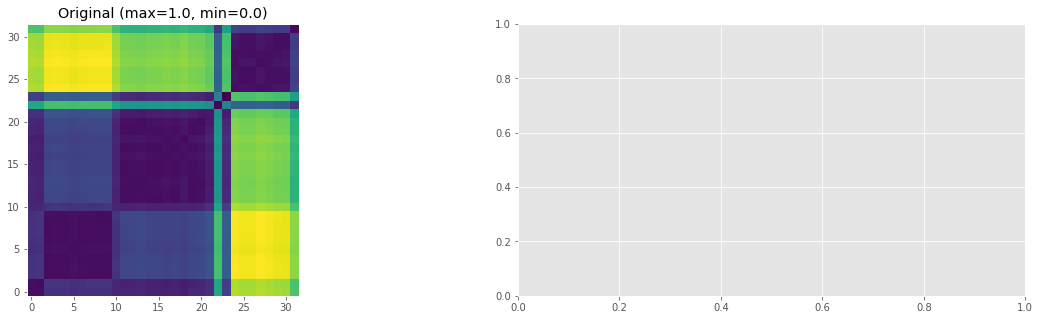

In [35]:
fig, axes = plt.subplots(1,2, figsize=(20,5))

original = X_treino_imagem[0,:,:,0]

axes[0].imshow(original, origin="lower");
axes[0].set_title("Original (max={:.1f}, min={:.1f})".format(np.max(original), np.min(original)));
axes[0].grid(False)

processada = X_treino_imagem_norm[0,:,:,0]
axes[1].imshow(processada, origin="lower");
axes[1].set_title("Processada (max={:.1f}, min={:.1f})".format(np.max(processada), np.min(processada)));
axes[1].grid(False)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(20,5))

axes[0].plot(np.arange(len(X_treino[0])), X_treino[0]);
axes[0].set_title("Original (max={:.1f}, min={:.1f})".format(np.max(X_treino[0]), np.min(X_treino[0])))

serie_convertida = normalizar_dados([X_treino[0]])[0]
axes[1].plot(np.arange(len(serie_convertida)), serie_convertida);
axes[1].set_title("Convertida (max={:.1f}, min={:.1f})".format(np.max(serie_convertida), np.min(serie_convertida)))


## Metodologia Final/TCE (Transfer Learning, Class Weight e Early Stopping)

In [96]:
metricas = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]
early_stopping_auc = tf.keras.callbacks.EarlyStopping(
    min_delta=1e-5,
    monitor='val_auc', 
    verbose=0,
    patience=10,
    mode='max',
    restore_best_weights=True
)

### Split Treino/Teste

In [98]:
resultados = {
    "aparelho": [],
    "teste": [],
    "acuracia": [],
    "f1": [],
    #"suporte_relativo": [],
    "auc":[],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    #INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = PARAMETROS_RP

    # Percorrer instancias do aparelho na residencia
    for INSTANCIA in instancia_aparelho_residencia(CARGA, RESIDENCIA, base = redd):

        # Extrair series divididas em janelas para cada medidor
        print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
            TAXA, TAMANHO_JANELA
        ))
        X, y = carregar_dados_aparelho(
            janelas=janelas,
            instancia=INSTANCIA,
            aparelho=CARGA,
            tamanho_janela=TAMANHO_JANELA,
            taxa=TAXA,
            eliminar_janelas_vazias=True
        )
        print()

        print("   - Detalhes da amostragem (lotes):")
        print("   ---")
        for item in Counter(y).items():
            print(f"      - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
        print()

        # Checando series estaveis
        estavel = []
        for i, x in enumerate(X):
            if len(np.unique(x)) == 1:
                estavel.append(i)
        print("      - Séries estáveis (1 amplitude)         : {} ({:.2f}%)".format(len(estavel), len(estavel)/len(X)*100) )
        print("      - Distribuicao de classes nestas séries :", Counter(y[estavel]))
        print()

        print("      - Estatísticas das séries: = Min. / Max. / Média / STD:", X.min(), X.max(), X.mean(), X.std())
        print()

        # Convertendo series para imagem
        print("   - Preparando dados para modelagem (treino/teste)...")
        print("   ---")
        # Fazendo split dos dados (treino/teste)
        X_treino, X_teste, y_treino, y_teste = train_test_split(
            X, y, 
            test_size=FRACAO_TESTE,
            stratify=y if Counter(y)[0] > 1 and Counter(y)[1] > 1 else None,
            random_state=SEED
        )
        print()

        print("      - Distribuições dos lotes:")
        print("        -> Treino:", Counter(y_treino))
        print("        -> Teste :", Counter(y_teste))

        X_treino_imagem, _ = preparar_amostras(
            X_treino, y_treino, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )
        X_teste_imagem, _ = preparar_amostras(
            X_teste, y_teste, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )

        # Normalizar dados p/ modelo
        X_treino_imagem = normalizar_dados(X_treino_imagem)
        X_teste_imagem = normalizar_dados(X_teste_imagem)

        print()

        ########################### METODOLOGIA FINAL ###########################
        # Selecionar informacoes sobre aparelhos em outras residencias
        dados_pretreino = {}
        for r in list(set([1,2,3,4,5,6]) - set([RESIDENCIA])):
            for e in redd.buildings[r].elec.meters:
                if e.label().lower().replace(" ","_") == CARGA:
                    dados_pretreino[r] = e.instance() if not hasattr(e,'meters') else e.instance()[0]
        modelo_pretreino = convnet_metodologia(
            metrics=metricas,
            optimizer=tf.keras.optimizers.Adam(1e-3), 
            #bias_output=bias_inicial_output
        )    
        # Realizando pre-treinamento
        print(f"   - Realizando pré-treinamento do modelo ({dados_pretreino})...")
        for res, inst in dados_pretreino.items():
            try:
                X_pretreino, y_pretreino = carregar_dados_aparelho(
                    janelas=Janelas(
                        base=redd,
                        id_residencia=res,
                        inicio_intervalo=PARAMETROS_DATASET["inicio_intervalo"],
                        fim_intervalo=PARAMETROS_DATASET["fim_intervalo"],
                        debug=False
                    ),
                    instancia=inst, 
                    aparelho=CARGA, 
                    taxa=TAXA,
                    tamanho_janela=TAMANHO_JANELA,
                )
                X_pretreino, y_pretreino = preparar_amostras(
                    X_pretreino, y_pretreino, 
                    params_rp=CONFIG_RP_APARELHO,
                    tam_imagem=TAMANHO_IMAGEM,
                    normalizar=False 
                ) 

                # Normalizar dados p/ modelo
                X_pretreino = normalizar_dados(X_pretreino)

                # calculando punicao para classes (desbalanceamento)
                neg, pos = np.bincount(y_pretreino)
                total = neg + pos
                p0 = (1 / neg)*(total)/2.0 
                p1 = (1 / pos)*(total)/2.0
                pesos_classes_tl = {
                    0: p0 if not np.isinf(p0) else 1e-3, 
                    1: p1 if not np.isinf(p1) else 1e-3
                }

                # Treinando
                historico = modelo_pretreino.fit(
                    X_pretreino, y_pretreino,
                    validation_data=(X_pretreino, y_pretreino),
                    epochs=EPOCAS,
                    batch_size=int(len(y_pretreino)/3),#TAMANHO_LOTE_AUMENTADO,
                    class_weight=pesos_classes_tl,
                    callbacks=[early_stopping_auc],
                    #verbose=VERBOSIDADE
                    verbose=0
                )

                # Avaliando
                y_hat = modelo_pretreino.predict(X_pretreino).round().astype(np.int16)

                print(classification_report(y_pretreino, y_hat))
                print()
                print(confusion_matrix(y_pretreino, y_hat))
                print()

                tf.keras.backend.clear_session()

                # Incrementando resultados
                score = f1_score(y_pretreino, y_hat, average="macro")
                auc_score = roc_auc_score(y_pretreino, y_hat) if np.unique(y_pretreino).shape[0]>1 else 1
                print("      -> Resultados residencia #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
                    res,
                    score*100,
                    auc_score,
                ))
                print()
            except Exception as e:
                print(f"      -> Resultados residencia #{res}: Não foi possível "+\
                      "pré-treinar o modelo com os dados desta residência.")
                print(f"         # MOTIVO: {str(e)}")
                print()


        # calculando punicao para classes (desbalanceamento)
        neg, pos = np.bincount(y_treino)
        total = neg + pos
        p0 = (1 / neg)*(total)/2.0 
        p1 = (1 / pos)*(total)/2.0
        pesos_classes = {
            0: p0 if not np.isinf(p0) else 1e-3, 
            1: p1 if not np.isinf(p1) else 1e-3
        }
        print("   - Punição de classes:", pesos_classes)
        print()

        print("   - Avaliando modelo, aguarde...")
        print("   ---")
        y_true, y_pred = [], []
        accs = []
        scores = []
        aucs = []
        suportes_relativos = []

        # Avaliando N vezes o conjunto treino/teste (consitencia)
        N = 10
        for i in tqdm_notebook(range(N)):

            # Instanciando modelo pre-treinado
            modelo = modelo_pretreino
            modelo.set_weights(modelo_pretreino.get_weights())

            # Treinando
            historico = modelo.fit(
                X_treino_imagem, y_treino,
                validation_data=(X_teste_imagem, y_teste),
                epochs=EPOCAS,
                batch_size=int(len(y_treino)/4),#TAMANHO_LOTE**2, # TODO: Validar heuristica do tamanho do lote
                class_weight=pesos_classes,
                callbacks=[early_stopping_auc],
                #verbose=VERBOSIDADE
                verbose=0
            )

            y_teste_, y_pred_, acc, score, auc_score, suporte_relativo, idx_descartados = \
                classificacao_threshold(
                    modelo, X_teste_imagem, y_teste, 
                    threshold={0:0, 1:0}, # TODO: validar melhor corte por aparelho
                    grafico=False
                )

            tf.keras.backend.clear_session()

            # Incrementando resultados
            print("      -> # TENTATIVA #{}: Acurácia = {:.2f}% / F1-score = {:.2f}% / AUC = {:.3f}".format(
                i+1, 
                acc*100,
                score*100,
                auc_score,
            ))
            accs.append(acc)
            scores.append(score)
            aucs.append(auc_score)
            y_true.extend(y_teste_)
            y_pred.extend(y_pred_)

            # Guardando resultados do modelo
            resultados["aparelho"].append(rotulo_aparelho)
            #resultados["iteracao"].append(iteracao) # APENAS PARA VALIDACAO CRUZADA
            resultados["teste"].append(i+1)
            resultados["acuracia"].append(acc)
            resultados["f1"].append(score)
            resultados["auc"].append(auc_score)


    print()
    print("   - Resultados finais:")
    print("   ---")
    print()


    print("      -> Acurácia:")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(accs)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(accs)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(accs)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(accs)*100) )
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()

* Aparelho FRIDGE - 7:

Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.
   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `1`: 60 amostras (84.5%)
      - Classe `0`: 11 amostras (15.5%)

      - Séries estáveis (1 amplitude)         : 11 (15.49%)
      - Distribuicao de classes nestas séries : Counter({0: 11})

      - Estatísticas das séries: = Min. / Max. / Média / STD: 120.127144 7648.587 414.62894 672.1024

   - Preparando dados para modelagem (treino/teste)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 45, 0: 8})
        -> Teste : Counter({1: 15, 0: 3})



   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:02:00.277549  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:00.320549  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0802 13:02:05.910560  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:05.948551  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:02:08.413547  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:08.447547  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.89      0.94        19

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32


[[13  0]
 [ 2 17]]

      -> Resultados residencia #5: F1-score = 93.65% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.3125, 1: 0.5888888888888889}

   - Avaliando modelo, aguarde...
   ---


W0802 13:02:09.362576  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:09.403549  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:02:10.171547  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:10.205545  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:02:11.009546  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:11.041576  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:02:11.876546  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:11.921547  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:02:12.722549  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:12.760545  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:02:13.610588  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:13.645548  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:02:14.439546  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:14.472544  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:02:15.294587  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:15.330546  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:02:16.188546  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:16.224551  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:02:17.092549  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:17.130548  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> F1-score (macro):

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 1.000
         . Desvio padrão : 0.000
         . Mínimo        : 1.000
         . Máximo        : 1.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00       150

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180

      -> Matrix de confusao:

[[ 30   0]
 [  0 1


   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:02:24.467546  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:24.511559  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.26      0.41       227
           1       0.06      1.00      0.12        11

    accuracy                           0.29       238
   macro avg       0.53      0.63      0.26       238
weighted avg       0.96      0.29      0.40       238


[[ 59 168]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 26.42% / AUC = 0.630




W0802 13:02:31.954365  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:31.992377  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.76      0.86       248
           1       0.09      1.00      0.17         6

    accuracy                           0.76       254
   macro avg       0.55      0.88      0.51       254
weighted avg       0.98      0.76      0.85       254


[[188  60]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 51.45% / AUC = 0.879

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:02:38.227628  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:38.271626  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       303
           1       0.02      1.00      0.04         7

    accuracy                           0.02       310
   macro avg       0.01      0.50      0.02       310
weighted avg       0.00      0.02      0.00       310


[[  0 303]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 2.21% / AUC = 0.500

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:02:41.015995  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:41.047958  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       153
           1       0.20      1.00      0.33         3

    accuracy                           0.92       156
   macro avg       0.60      0.96      0.65       156
weighted avg       0.98      0.92      0.95       156


[[141  12]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 64.63% / AUC = 0.961

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099206349206349, 1: 25.700000000000003}

   - Avaliando modelo, aguarde...
   ---


W0802 13:02:46.131108  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:46.171109  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 61.63% / F1-score = 40.81% / AUC = 0.560


W0802 13:02:47.284107  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:47.325109  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 60.47% / F1-score = 40.28% / AUC = 0.554


W0802 13:02:48.158106  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:48.196105  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 60.47% / F1-score = 40.28% / AUC = 0.554


W0802 13:02:49.002789  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:49.045790  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 60.47% / F1-score = 40.28% / AUC = 0.554


W0802 13:02:50.023586  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:50.062586  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 60.47% / F1-score = 40.28% / AUC = 0.554


W0802 13:02:50.887585  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:50.921615  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 60.47% / F1-score = 40.28% / AUC = 0.554


W0802 13:02:51.738514  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:51.784511  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 59.30% / F1-score = 39.74% / AUC = 0.548


W0802 13:02:52.636554  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:52.675511  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 63.95% / F1-score = 41.88% / AUC = 0.571


W0802 13:02:53.524550  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:53.566513  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 66.28% / F1-score = 42.94% / AUC = 0.583


W0802 13:02:54.661514  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:02:54.697542  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 67.44% / F1-score = 43.47% / AUC = 0.589

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 62.09%
         . Desvio padrão : 2.66%
         . Mínimo        : 59.30%
         . Máximo        : 67.44%

      -> F1-score (macro):

         . Média geral   : 41.02%
         . Desvio padrão : 1.22%
         . Mínimo        : 39.74%
         . Máximo        : 43.47%

      -> AUC:

         . Média geral   : 0.562
         . Desvio padrão : 0.014
         . Mínimo        : 0.548
         . Máximo        : 0.589

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       0.98      0.62      0.76       840
           1       0.03      0.50      0.06        20

    accuracy                           0.62       860
   macro avg       0.51      0.56      0.41       860
weighted avg       0.96      0.62      0.75       860

      -> Matrix de confusao:

[[524 316]
 [ 10  10]]

--


   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:03:05.006235  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:03:05.039263  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.68      0.81       158
           1       0.02      1.00      0.04         1

    accuracy                           0.69       159
   macro avg       0.51      0.84      0.43       159
weighted avg       0.99      0.69      0.81       159


[[108  50]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 42.52% / AUC = 0.842




W0802 13:03:10.920253  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:03:10.955224  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.74      0.85       168
           1       0.02      1.00      0.04         1

    accuracy                           0.75       169
   macro avg       0.51      0.87      0.45       169
weighted avg       0.99      0.75      0.85       169


[[125  43]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 44.88% / AUC = 0.872

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:03:18.098906  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:03:18.131907  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       195
           1       0.60      1.00      0.75        12

    accuracy                           0.96       207
   macro avg       0.80      0.98      0.86       207
weighted avg       0.98      0.96      0.97       207


[[187   8]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 86.45% / AUC = 0.979

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:03:26.793896  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:03:26.836884  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       103
           1       0.10      1.00      0.18         1

    accuracy                           0.91       104
   macro avg       0.55      0.96      0.57       104
weighted avg       0.99      0.91      0.95       104


[[94  9]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 56.81% / AUC = 0.956

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5181818181818182, 1: 14.25}

   - Avaliando modelo, aguarde...
   ---


W0802 13:03:28.135614  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:03:28.179590  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 96.49% / F1-score = 82.41% / AUC = 0.982


W0802 13:03:31.426995  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:03:31.460955  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 96.49% / F1-score = 82.41% / AUC = 0.982


W0802 13:03:32.261954  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:03:32.311958  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 96.49% / F1-score = 74.09% / AUC = 0.741


W0802 13:03:33.109984  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:03:33.145992  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750


W0802 13:03:34.008168  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:03:34.046170  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750


W0802 13:03:35.327205  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:03:35.365197  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750


W0802 13:03:36.277192  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:03:36.325167  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750


W0802 13:03:37.175168  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:03:37.208194  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750


W0802 13:03:38.021970  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:03:38.055000  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750


W0802 13:03:38.927803  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:03:38.969799  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `0`: 218 amostras (95.6%)
      - Classe `1`: 10 amostras (4.4%)

      - Séries estáveis (1 amplitude)         : 45 (19.74%)
      - Distribuicao de classes nestas séries : Counter({0: 45})

      - Estatísticas das séries: = Min. / Max. / Média / STD: 120.03001 7898.8433 413.83813 674.82117

   - Preparando dados para modelagem (treino/teste)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 163, 1: 8})
        -> Teste : Counter({0: 55, 1: 2})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:03:49.236698  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:03:49.267726  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.72      0.84       158
           1       0.02      1.00      0.04         1

    accuracy                           0.72       159
   macro avg       0.51      0.86      0.44       159
weighted avg       0.99      0.72      0.83       159


[[114  44]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 44.09% / AUC = 0.861




W0802 13:03:55.213705  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:03:55.253706  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.82      0.90       168
           1       0.03      1.00      0.06         1

    accuracy                           0.82       169
   macro avg       0.52      0.91      0.48       169
weighted avg       0.99      0.82      0.90       169


[[138  30]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 48.22% / AUC = 0.911

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:04:02.644457  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:04:02.690448  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.97       195
           1       0.48      1.00      0.65        12

    accuracy                           0.94       207
   macro avg       0.74      0.97      0.81       207
weighted avg       0.97      0.94      0.95       207


[[182  13]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 80.71% / AUC = 0.967

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:04:11.269405  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:04:11.305407  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.82      0.90       103
           1       0.05      1.00      0.10         1

    accuracy                           0.82       104
   macro avg       0.53      0.91      0.50       104
weighted avg       0.99      0.82      0.89       104


[[84 19]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 49.68% / AUC = 0.908

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5245398773006135, 1: 10.6875}

   - Avaliando modelo, aguarde...
   ---


W0802 13:04:12.503407  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:04:12.539406  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 84.21% / F1-score = 60.93% / AUC = 0.918


W0802 13:04:14.982405  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:04:15.014435  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 87.72% / F1-score = 64.78% / AUC = 0.936


W0802 13:04:15.922408  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:04:15.967405  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 89.47% / F1-score = 67.12% / AUC = 0.945


W0802 13:04:16.876405  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:04:16.912407  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 91.23% / F1-score = 69.84% / AUC = 0.955


W0802 13:04:17.958406  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:04:18.001407  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 94.74% / F1-score = 77.17% / AUC = 0.973


W0802 13:04:19.101010  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:04:19.141971  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 94.74% / F1-score = 77.17% / AUC = 0.973


W0802 13:04:20.510968  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:04:20.542966  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 94.74% / F1-score = 77.17% / AUC = 0.973


W0802 13:04:21.616968  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:04:21.660969  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 94.74% / F1-score = 77.17% / AUC = 0.973


W0802 13:04:22.441150  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:04:22.484188  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 91.23% / F1-score = 69.84% / AUC = 0.955


W0802 13:04:23.508145  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:04:23.546148  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 96.49% / F1-score = 82.41% / AUC = 0.982

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 91.93%
         . Desvio padrão : 3.70%
         . Mínimo        : 84.21%
         . Máximo        : 96.49%

      -> F1-score (macro):

         . Média geral   : 72.36%
         . Desvio padrão : 6.49%
         . Mínimo        : 60.93%
         . Máximo        : 82.41%

      -> AUC:

         . Média geral   : 0.958
         . Desvio padrão : 0.019
         . Mínimo        : 0.918
         . Máximo        : 0.982

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       550
           1       0.30      1.00      0.47        20

    accuracy                           0.92       570
   macro avg       0.65      0.96      0.71       570
weighted avg       0.98      0.92      0.94       570

      -> Matrix de confusao:

[[504  46]
 [  0  20]]

--


   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:04:33.818819  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:04:33.854799  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.79      0.88       158
           1       0.03      1.00      0.06         1

    accuracy                           0.79       159
   macro avg       0.51      0.90      0.47       159
weighted avg       0.99      0.79      0.88       159


[[125  33]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 47.03% / AUC = 0.896




W0802 13:04:39.489908  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:04:39.526912  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       168
           1       0.06      1.00      0.11         1

    accuracy                           0.90       169
   macro avg       0.53      0.95      0.53       169
weighted avg       0.99      0.90      0.94       169


[[151  17]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 52.60% / AUC = 0.949

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:04:46.895775  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:04:46.929773  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       195
           1       0.57      1.00      0.73        12

    accuracy                           0.96       207
   macro avg       0.79      0.98      0.85       207
weighted avg       0.98      0.96      0.96       207


[[186   9]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 85.18% / AUC = 0.977

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:04:55.524703  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:04:55.565740  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.85      0.92       103
           1       0.06      1.00      0.12         1

    accuracy                           0.86       104
   macro avg       0.53      0.93      0.52       104
weighted avg       0.99      0.86      0.91       104


[[88 15]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 51.96% / AUC = 0.927

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5181818181818182, 1: 14.25}

   - Avaliando modelo, aguarde...
   ---


W0802 13:04:56.727704  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:04:56.769703  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750


W0802 13:04:59.072733  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:04:59.106706  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750


W0802 13:04:59.919811  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:04:59.952808  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:05:00.776811  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:05:00.826848  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750


W0802 13:05:01.795813  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:05:01.836812  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750


W0802 13:05:02.636820  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:05:02.670810  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:05:03.499812  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:05:03.538809  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991


W0802 13:05:04.374810  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:05:04.418810  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750


W0802 13:05:05.206812  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:05:05.239811  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:05:06.077811  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:05:06.113811  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `0`: 218 amostras (95.6%)
      - Classe `1`: 10 amostras (4.4%)

      - Séries estáveis (1 amplitude)         : 45 (19.74%)
      - Distribuicao de classes nestas séries : Counter({0: 45})

      - Estatísticas das séries: = Min. / Max. / Média / STD: 120.03001 7898.8433 413.83813 674.82117

   - Preparando dados para modelagem (treino/teste)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 163, 1: 8})
        -> Teste : Counter({0: 55, 1: 2})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:05:16.524386  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:05:16.557385  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 13:05:22.436561  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:05:22.477557  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       168
           1       0.07      1.00      0.13         1

    accuracy                           0.92       169
   macro avg       0.54      0.96      0.55       169
weighted avg       0.99      0.92      0.95       169


[[155  13]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 54.65% / AUC = 0.961

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:05:30.052511  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:05:30.088512  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.88      0.93       195
           1       0.33      1.00      0.50        12

    accuracy                           0.88       207
   macro avg       0.67      0.94      0.72       207
weighted avg       0.96      0.88      0.91       207


[[171  24]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 71.72% / AUC = 0.938

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:05:38.758508  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:05:38.791510  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       103
           1       0.17      1.00      0.29         1

    accuracy                           0.95       104
   macro avg       0.58      0.98      0.63       104
weighted avg       0.99      0.95      0.97       104


[[98  5]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 63.04% / AUC = 0.976

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5245398773006135, 1: 10.6875}

   - Avaliando modelo, aguarde...
   ---


W0802 13:05:40.348507  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:05:40.382510  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 49.12% / F1-score = 38.16% / AUC = 0.736


W0802 13:05:41.284507  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:05:41.319505  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 77.19% / F1-score = 55.06% / AUC = 0.882


W0802 13:05:42.310506  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:05:42.353513  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 77.19% / F1-score = 55.06% / AUC = 0.882


W0802 13:05:43.191506  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:05:43.223536  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 75.44% / F1-score = 53.82% / AUC = 0.873


W0802 13:05:44.072508  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:05:44.108507  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 75.44% / F1-score = 53.82% / AUC = 0.873


W0802 13:05:44.908506  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:05:44.941507  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 82.46% / F1-score = 59.29% / AUC = 0.909


W0802 13:05:45.771506  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:05:45.805508  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 77.19% / F1-score = 55.06% / AUC = 0.882


W0802 13:05:46.664506  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:05:46.697536  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 78.95% / F1-score = 56.38% / AUC = 0.891


W0802 13:05:47.566506  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:05:47.600508  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 84.21% / F1-score = 60.93% / AUC = 0.918


W0802 13:05:48.439506  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:05:48.472537  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 80.70% / F1-score = 57.78% / AUC = 0.900

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 75.79%
         . Desvio padrão : 9.31%
         . Mínimo        : 49.12%
         . Máximo        : 84.21%

      -> F1-score (macro):

         . Média geral   : 54.54%
         . Desvio padrão : 5.89%
         . Mínimo        : 38.16%
         . Máximo        : 60.93%

      -> AUC:

         . Média geral   : 0.875
         . Desvio padrão : 0.048
         . Mínimo        : 0.736
         . Máximo        : 0.918

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       1.00      0.75      0.86       550
           1       0.13      1.00      0.22        20

    accuracy                           0.76       570
   macro avg       0.56      0.87      0.54       570
weighted avg       0.97      0.76      0.83       570

      -> Matrix de confusao:

[[412 138]
 [  0  20]]

--


   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:05:55.675042  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:05:55.714056  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.97      0.96      0.96       260
           1       0.73      0.79      0.76        38

    accuracy                           0.94       298
   macro avg       0.85      0.87      0.86       298
weighted avg       0.94      0.94      0.94       298


[[249  11]
 [  8  30]]

      -> Resultados residencia #1: F1-score = 86.14% / AUC = 0.874




W0802 13:06:03.736111  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:06:03.773111  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.94      0.85      0.90       271
           1       0.44      0.70      0.54        46

    accuracy                           0.83       317
   macro avg       0.69      0.77      0.72       317
weighted avg       0.87      0.83      0.84       317


[[231  40]
 [ 14  32]]

      -> Resultados residencia #2: F1-score = 71.89% / AUC = 0.774

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:06:12.785109  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:06:12.823111  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.97      0.81      0.88       108
           1       0.80      0.97      0.88        87

    accuracy                           0.88       195
   macro avg       0.88      0.89      0.88       195
weighted avg       0.89      0.88      0.88       195


[[87 21]
 [ 3 84]]

      -> Resultados residencia #5: F1-score = 87.69% / AUC = 0.886

   - Punição de classes: {0: 0.5262295081967213, 1: 10.03125}

   - Avaliando modelo, aguarde...
   ---


W0802 13:06:19.651125  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:06:19.698126  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 93.46% / F1-score = 74.91% / AUC = 0.871


W0802 13:06:23.851129  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:06:23.886154  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 95.33% / F1-score = 79.53% / AUC = 0.880


W0802 13:06:25.036125  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:06:25.076125  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 92.52% / F1-score = 72.98% / AUC = 0.866


W0802 13:06:26.091510  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:06:26.127512  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 94.39% / F1-score = 77.07% / AUC = 0.875


W0802 13:06:27.212530  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:06:27.254539  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 94.39% / F1-score = 77.07% / AUC = 0.875


W0802 13:06:28.093113  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:06:28.127139  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 93.46% / F1-score = 74.91% / AUC = 0.871


W0802 13:06:29.017513  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:06:29.051474  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 93.46% / F1-score = 71.34% / AUC = 0.775


W0802 13:06:30.485866  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:06:30.522829  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 94.39% / F1-score = 77.07% / AUC = 0.875


W0802 13:06:31.403869  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:06:31.437855  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 92.52% / F1-score = 72.98% / AUC = 0.866


W0802 13:06:32.416831  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:06:32.461869  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 93.46% / F1-score = 74.91% / AUC = 0.871

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 93.74%
         . Desvio padrão : 0.84%
         . Mínimo        : 92.52%
         . Máximo        : 95.33%

      -> F1-score (macro):

         . Média geral   : 75.28%
         . Desvio padrão : 2.33%
         . Mínimo        : 71.34%
         . Máximo        : 79.53%

      -> AUC:

         . Média geral   : 0.863
         . Desvio padrão : 0.029
         . Mínimo        : 0.775
         . Máximo        : 0.880

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1020
           1       0.41      0.78      0.54        50

    accuracy                           0.94      1070
   macro avg       0.70      0.86      0.75      1070
weighted avg       0.96      0.94      0.95      1070

      -> Matrix de confusao:

[[964  56]
 [ 11  39]]

--

In [106]:
# Exportando resultados
df_tce = pd.DataFrame(resultados)
df_tce["metodologia"] = "Fnal/TCE"
df_tce.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_tce.xlsx"),
    index=False
)

### Validação Cruzada

In [107]:
resultados = {
    "aparelho": [],
    "iteracao": [],
    "teste": [],
    "acuracia": [],
    "f1": [],
    #"suporte_relativo": [],
    "auc":[],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    #INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = PARAMETROS_RP

    # Percorrer instancias do aparelho na residencia
    for INSTANCIA in instancia_aparelho_residencia(CARGA, RESIDENCIA, base = redd):

        # Extrair series divididas em janelas para cada medidor
        print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
            TAXA, TAMANHO_JANELA
        ))
        X, y = carregar_dados_aparelho(
            janelas=janelas,
            instancia=INSTANCIA,
            aparelho=CARGA,
            tamanho_janela=TAMANHO_JANELA,
            taxa=TAXA,
            eliminar_janelas_vazias=True
        )
        print()

        print("   - Detalhes da amostragem (lotes):")
        print("   ---")
        for item in Counter(y).items():
            print(f"      - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
        print()

        # Checando series estaveis
        estavel = []
        for i, x in enumerate(X):
            if len(np.unique(x)) == 1:
                estavel.append(i)
        print("      - Séries estáveis (1 amplitude)         : {} ({:.2f}%)".format(len(estavel), len(estavel)/len(X)*100) )
        print("      - Distribuicao de classes nestas séries :", Counter(y[estavel]))
        print()

        print("      - Estatísticas das séries: = Min. / Max. / Média / STD:", X.min(), X.max(), X.mean(), X.std())
        print()

        # Convertendo series para imagem (CV)
        for it, (idx_treino, idx_teste) in enumerate(kfold.split(X, y)):

            iteracao = it + 1    
            print(f"   - Preparando dados para modelagem (cv-{iteracao})...")
            print("   ---")
            X_treino, X_teste = X[idx_treino], X[idx_teste]
            y_treino, y_teste = y[idx_treino], y[idx_teste]
            print()

            print("      - Distribuições dos lotes:")
            print("        -> Treino:", Counter(y_treino))
            print("        -> Teste :", Counter(y_teste))

            X_treino_imagem, _ = preparar_amostras(
                X_treino, y_treino, 
                params_rp=CONFIG_RP_APARELHO,
                tam_imagem=TAMANHO_IMAGEM,
                normalizar=False # config. estudo 17 = False
            )
            X_teste_imagem, _ = preparar_amostras(
                X_teste, y_teste, 
                params_rp=CONFIG_RP_APARELHO,
                tam_imagem=TAMANHO_IMAGEM,
                normalizar=False # config. estudo 17 = False
            )

            # Normalizar dados p/ modelo
            X_treino_imagem = normalizar_dados(X_treino_imagem)
            X_teste_imagem = normalizar_dados(X_teste_imagem)

            print()

            ########################### METODOLOGIA FINAL ###########################
            # Selecionar informacoes sobre aparelhos em outras residencias
            dados_pretreino = {}
            for r in list(set([1,2,3,4,5,6]) - set([RESIDENCIA])):
                for e in redd.buildings[r].elec.meters:
                    if e.label().lower().replace(" ","_") == CARGA:
                        dados_pretreino[r] = e.instance() if not hasattr(e,'meters') else e.instance()[0]
            modelo_pretreino = convnet_metodologia(
                metrics=metricas,
                optimizer=tf.keras.optimizers.Adam(1e-3), 
                #bias_output=bias_inicial_output
            )    
            # Realizando pre-treinamento
            print(f"   - Realizando pré-treinamento do modelo ({dados_pretreino})...")
            for res, inst in dados_pretreino.items():
                try:
                    X_pretreino, y_pretreino = carregar_dados_aparelho(
                        janelas=Janelas(
                            base=redd,
                            id_residencia=res,
                            inicio_intervalo=PARAMETROS_DATASET["inicio_intervalo"],
                            fim_intervalo=PARAMETROS_DATASET["fim_intervalo"],
                            debug=False
                        ),
                        instancia=inst, 
                        aparelho=CARGA, 
                        taxa=TAXA,
                        tamanho_janela=TAMANHO_JANELA,
                    )
                    X_pretreino, y_pretreino = preparar_amostras(
                        X_pretreino, y_pretreino, 
                        params_rp=CONFIG_RP_APARELHO,
                        tam_imagem=TAMANHO_IMAGEM,
                        normalizar=False 
                    ) 

                    # Normalizar dados p/ modelo
                    X_pretreino = normalizar_dados(X_pretreino)

                    # calculando punicao para classes (desbalanceamento)
                    neg, pos = np.bincount(y_pretreino)
                    total = neg + pos
                    p0 = (1 / neg)*(total)/2.0 
                    p1 = (1 / pos)*(total)/2.0
                    pesos_classes_tl = {
                        0: p0 if not np.isinf(p0) else 1e-3, 
                        1: p1 if not np.isinf(p1) else 1e-3
                    }

                    # Treinando
                    historico = modelo_pretreino.fit(
                        X_pretreino, y_pretreino,
                        validation_data=(X_pretreino, y_pretreino),
                        epochs=EPOCAS,
                        batch_size=int(len(y_pretreino)/3),#TAMANHO_LOTE_AUMENTADO,
                        class_weight=pesos_classes_tl,
                        callbacks=[early_stopping_auc],
                        #verbose=VERBOSIDADE
                        verbose=0
                    )

                    # Avaliando
                    y_hat = modelo_pretreino.predict(X_pretreino).round().astype(np.int16)

                    print(classification_report(y_pretreino, y_hat))
                    print()
                    print(confusion_matrix(y_pretreino, y_hat))
                    print()

                    tf.keras.backend.clear_session()

                    # Incrementando resultados
                    score = f1_score(y_pretreino, y_hat, average="macro")
                    auc_score = roc_auc_score(y_pretreino, y_hat) if np.unique(y_pretreino).shape[0]>1 else 1
                    print("      -> Resultados residencia #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
                        res,
                        score*100,
                        auc_score,
                    ))
                    print()
                except Exception as e:
                    print(f"      -> Resultados residencia #{res}: Não foi possível "+\
                          "pré-treinar o modelo com os dados desta residência.")
                    print(f"         # MOTIVO: {str(e)}")
                    print()


            # calculando punicao para classes (desbalanceamento)
            neg, pos = np.bincount(y_treino)
            total = neg + pos
            p0 = (1 / neg)*(total)/2.0 
            p1 = (1 / pos)*(total)/2.0
            pesos_classes = {
                0: p0 if not np.isinf(p0) else 1e-3, 
                1: p1 if not np.isinf(p1) else 1e-3
            }
            print("   - Punição de classes:", pesos_classes)
            print()

            print("   - Avaliando modelo, aguarde...")
            print("   ---")
            y_true, y_pred = [], []
            accs = []
            scores = []
            aucs = []
            suportes_relativos = []

            # Avaliando N vezes o conjunto treino/teste (consitencia)
            N = 10
            for i in tqdm_notebook(range(N)):

                # Instanciando modelo pre-treinado
                modelo = modelo_pretreino
                modelo.set_weights(modelo_pretreino.get_weights())

                # Treinando
                historico = modelo.fit(
                    X_treino_imagem, y_treino,
                    validation_data=(X_teste_imagem, y_teste),
                    epochs=EPOCAS,
                    batch_size=int(len(y_treino)/4),#TAMANHO_LOTE**2, # TODO: Validar heuristica do tamanho do lote
                    class_weight=pesos_classes,
                    callbacks=[early_stopping_auc],
                    #verbose=VERBOSIDADE
                    verbose=0
                )

                y_teste_, y_pred_, acc, score, auc_score, suporte_relativo, idx_descartados = \
                    classificacao_threshold(
                        modelo, X_teste_imagem, y_teste, 
                        threshold={0:0, 1:0}, # TODO: validar melhor corte por aparelho
                        grafico=False
                    )


                tf.keras.backend.clear_session()

                # Incrementando resultados
                print("      -> # TENTATIVA #{}: Acurácia = {:.2f}% / F1-score = {:.2f}% / AUC = {:.3f}".format(
                    i+1, 
                    acc*100,
                    score*100,
                    auc_score,
                ))
                accs.append(acc)
                scores.append(score)
                aucs.append(auc_score)
                y_true.extend(y_teste_)
                y_pred.extend(y_pred_)


                # Guardando resultados do modelo
                resultados["aparelho"].append(rotulo_aparelho)
                resultados["iteracao"].append(iteracao) # APENAS PARA VALIDACAO CRUZADA
                resultados["teste"].append(i+1)
                resultados["acuracia"].append(acc)
                resultados["f1"].append(score)
                resultados["auc"].append(auc_score)
                
    print("      -> Acurácia:")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(accs)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(accs)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(accs)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(accs)*100) )
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
# Exportando resultados
df_tce_cv = pd.DataFrame(resultados)
df_tce_cv["metodologia"] = "Fnal/TCE"
df_tce_cv.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_tce_cv.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.
   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `1`: 60 amostras (84.5%)
      - Classe `0`: 11 amostras (15.5%)

      - Séries estáveis (1 amplitude)         : 11 (15.49%)
      - Distribuicao de classes nestas séries : Counter({0: 11})

      - Estatísticas das séries: = Min. / Max. / Média / STD: 120.127144 7648.587 414.62894 672.1024

   - Preparando dados para modelagem (cv-1)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 9})
        -> Teste : Counter({1: 6, 0: 2})



   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:13:05.108220  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:05.142246  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.94      0.97        49

    accuracy                           0.94        49
   macro avg       0.50      0.47      0.48        49
weighted avg       1.00      0.94      0.97        49


[[ 0  0]
 [ 3 46]]

      -> Resultados residencia #1: F1-score = 48.42% / AUC = 1.000




W0802 13:13:10.715263  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:10.748262  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:13:13.391498  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:13.430468  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.89      0.94        19

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32


[[13  0]
 [ 2 17]]

      -> Resultados residencia #5: F1-score = 93.65% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.5, 1: 0.5833333333333333}

   - Avaliando modelo, aguarde...
   ---


W0802 13:13:14.287465  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:14.318463  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:13:15.070493  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:15.103465  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:13:15.792504  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:15.831463  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:13:16.590463  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:16.624505  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:13:17.339463  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:17.385466  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:13:18.203461  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:18.238466  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:13:18.960501  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:18.995502  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:13:19.709504  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:19.743474  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:13:20.439474  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:20.474471  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:13:21.209472  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:21.245501  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:13:26.064470  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:26.097499  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0802 13:13:31.398655  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:31.437613  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:13:33.994601  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:34.029574  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.89      0.94        19

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32


[[13  0]
 [ 2 17]]

      -> Resultados residencia #5: F1-score = 93.65% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0802 13:13:34.888571  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:34.916570  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:13:36.280573  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:36.308572  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:13:36.915573  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:36.943600  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:13:37.555613  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:37.587600  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:13:38.211592  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:38.244572  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:13:38.863601  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:38.891599  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:13:39.495575  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:39.524602  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:13:40.131603  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:40.159571  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:13:40.830570  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:40.863572  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:13:41.513615  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:41.550572  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:13:46.194990  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:46.233961  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.90      0.95        49

    accuracy                           0.90        49
   macro avg       0.50      0.45      0.47        49
weighted avg       1.00      0.90      0.95        49


[[ 0  0]
 [ 5 44]]

      -> Resultados residencia #1: F1-score = 47.31% / AUC = 1.000




W0802 13:13:51.472980  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:51.511942  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:13:54.185764  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:54.223737  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.89      0.94        19

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32


[[13  0]
 [ 2 17]]

      -> Resultados residencia #5: F1-score = 93.65% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0802 13:13:55.118268  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:55.147287  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:13:56.482165  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:56.512171  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:13:57.107167  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:57.135172  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:13:57.767170  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:57.802170  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:13:58.410168  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:58.445166  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:13:59.073169  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:59.100195  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:13:59.751169  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:13:59.785167  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:14:00.402167  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:00.432169  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:14:01.068168  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:01.101194  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:14:01.763169  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:01.793169  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:14:06.502189  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:06.536154  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0802 13:14:11.482411  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:11.523376  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:14:13.974377  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:14.014402  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.75        19

    accuracy                           0.59        32
   macro avg       0.30      0.50      0.37        32
weighted avg       0.35      0.59      0.44        32


[[ 0 13]
 [ 0 19]]

      -> Resultados residencia #5: F1-score = 37.25% / AUC = 0.500

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0802 13:14:14.852372  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:14.892372  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500


W0802 13:14:16.112494  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:16.144495  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500


W0802 13:14:16.722497  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:16.750484  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500


W0802 13:14:17.347531  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:17.380559  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500


W0802 13:14:17.994123  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:18.026123  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500


W0802 13:14:18.633163  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:18.663152  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500


W0802 13:14:19.235130  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:19.265152  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500


W0802 13:14:19.865170  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:19.897125  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500


W0802 13:14:20.477166  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:20.506163  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500


W0802 13:14:21.062168  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:21.092152  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:14:25.502531  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:25.536531  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.92      0.96        49

    accuracy                           0.92        49
   macro avg       0.50      0.46      0.48        49
weighted avg       1.00      0.92      0.96        49


[[ 0  0]
 [ 4 45]]

      -> Resultados residencia #1: F1-score = 47.87% / AUC = 1.000




W0802 13:14:30.375022  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:30.415989  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:14:32.804783  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:32.846789  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.89      0.94        19

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32


[[13  0]
 [ 2 17]]

      -> Resultados residencia #5: F1-score = 93.65% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0802 13:14:33.721975  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:33.753981  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:14:34.969432  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:35.000471  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:14:35.591087  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:35.625086  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:14:36.200088  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:36.231076  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:14:36.815053  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:36.857075  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:14:37.463414  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:37.494414  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:14:38.064486  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:38.094486  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:14:38.666775  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:38.695772  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:14:39.301522  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:39.329483  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:14:39.915108  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:39.945120  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:14:44.305349  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:44.340355  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0802 13:14:49.141068  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:49.176070  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:14:51.599136  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:51.632137  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.89      0.94        19

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32


[[13  0]
 [ 2 17]]

      -> Resultados residencia #5: F1-score = 93.65% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0802 13:14:52.464180  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:52.494172  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:14:53.732988  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:53.762985  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:14:54.372242  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:54.403225  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:14:54.981939  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:55.012949  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:14:55.599922  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:55.630947  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:14:56.201961  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:56.231946  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:14:56.800625  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:56.832593  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:14:57.405591  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:57.433590  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:14:58.035350  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:58.066393  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:14:58.641997  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:14:58.671021  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:15:03.345200  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:03.386202  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0802 13:15:08.531842  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:08.567838  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:15:10.945509  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:10.980504  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.75        19

    accuracy                           0.59        32
   macro avg       0.30      0.50      0.37        32
weighted avg       0.35      0.59      0.44        32


[[ 0 13]
 [ 0 19]]

      -> Resultados residencia #5: F1-score = 37.25% / AUC = 0.500

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0802 13:15:11.842811  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:11.872809  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500


W0802 13:15:13.127138  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:13.157166  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500


W0802 13:15:13.760168  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:13.788166  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500


W0802 13:15:14.358176  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:14.393140  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500


W0802 13:15:14.957180  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:14.987166  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500


W0802 13:15:15.584304  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:15.619275  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500


W0802 13:15:16.207956  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:16.236984  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500


W0802 13:15:16.829693  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:16.857685  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500


W0802 13:15:17.426686  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:17.455714  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500


W0802 13:15:18.041636  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:18.075635  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:15:22.847620  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:22.886654  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0802 13:15:27.799048  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:27.832009  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:15:30.247290  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:30.282316  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.89      0.94        19

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32


[[13  0]
 [ 2 17]]

      -> Resultados residencia #5: F1-score = 93.65% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0802 13:15:31.169814  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:31.199840  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:15:32.455863  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:32.484864  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:15:33.111677  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:33.140668  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:15:33.719679  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:33.750668  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:15:34.361059  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:34.395035  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:15:35.006214  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:35.039224  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:15:35.638188  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:35.670186  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:15:36.251238  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:36.280269  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:15:36.858281  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:36.888278  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:15:37.454282  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:37.485279  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:15:42.029839  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:42.063843  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.82      0.90        49

    accuracy                           0.82        49
   macro avg       0.50      0.41      0.45        49
weighted avg       1.00      0.82      0.90        49


[[ 0  0]
 [ 9 40]]

      -> Resultados residencia #1: F1-score = 44.94% / AUC = 1.000




W0802 13:15:46.980762  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:47.026759  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:15:49.667698  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:49.703693  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.89      0.94        19

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32


[[13  0]
 [ 2 17]]

      -> Resultados residencia #5: F1-score = 93.65% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0802 13:15:50.536693  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:50.567696  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:15:51.857694  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:51.891693  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:15:52.525731  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:52.558696  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:15:53.212582  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:53.248584  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:15:53.857582  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:53.889581  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:15:54.483502  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:54.513504  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:15:55.121511  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:55.151503  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:15:55.767759  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:55.796758  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:15:56.385759  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:56.420759  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:15:57.029725  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:15:57.058721  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:16:01.710293  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:01.745319  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0802 13:16:06.610103  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:06.644074  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:16:09.069006  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:09.103010  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.89      0.94        19

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32


[[13  0]
 [ 2 17]]

      -> Resultados residencia #5: F1-score = 93.65% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0802 13:16:09.954012  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:09.983030  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:16:11.187328  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:11.215317  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:16:11.799953  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:11.832981  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:16:12.460978  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:12.504951  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:16:13.072087  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:13.104096  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:16:13.703058  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:13.732057  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:16:14.345339  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:14.375336  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:16:14.968863  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:15.001866  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:16:15.585703  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:15.613675  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 13:16:16.196040  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:16.225029  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> Acurácia:

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> F1-score (macro):

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 1.000
         . Desvio padrão : 0.000
         . Mínimo        : 1.000
         . Máximo        : 1.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        60

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70

      -> Matrix de confusao:

[[10  0]
 [ 0 60]]

-------------------------------


   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:16:23.029831  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:23.074825  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       227
           1       0.31      1.00      0.48        11

    accuracy                           0.90       238
   macro avg       0.66      0.95      0.71       238
weighted avg       0.97      0.90      0.92       238


[[203  24]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 71.12% / AUC = 0.947




W0802 13:16:32.711700  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:32.749701  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.88      0.94       248
           1       0.17      1.00      0.29         6

    accuracy                           0.89       254
   macro avg       0.59      0.94      0.62       254
weighted avg       0.98      0.89      0.92       254


[[219  29]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 61.53% / AUC = 0.942

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:16:38.835961  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:38.875963  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.83      0.91       303
           1       0.11      0.86      0.19         7

    accuracy                           0.84       310
   macro avg       0.55      0.85      0.55       310
weighted avg       0.98      0.84      0.89       310


[[253  50]
 [  1   6]]

      -> Resultados residencia #4: F1-score = 54.95% / AUC = 0.846

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:16:43.060856  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:43.093895  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.97       153
           1       0.27      1.00      0.43         3

    accuracy                           0.95       156
   macro avg       0.64      0.97      0.70       156
weighted avg       0.99      0.95      0.96       156


[[145   8]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 70.09% / AUC = 0.974

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099337748344371, 1: 25.666666666666664}

   - Avaliando modelo, aguarde...
   ---


W0802 13:16:48.608783  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:48.638785  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 88.57% / F1-score = 63.54% / AUC = 0.941


W0802 13:16:50.093244  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:50.124245  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 88.57% / F1-score = 63.54% / AUC = 0.941


W0802 13:16:50.805746  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:50.841748  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 85.71% / F1-score = 60.32% / AUC = 0.926


W0802 13:16:51.516976  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:51.545973  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 85.71% / F1-score = 60.32% / AUC = 0.926


W0802 13:16:52.218972  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:52.248974  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 88.57% / F1-score = 63.54% / AUC = 0.941


W0802 13:16:52.930938  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:52.960926  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 85.71% / F1-score = 60.32% / AUC = 0.926


W0802 13:16:53.644929  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:53.676928  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 85.71% / F1-score = 60.32% / AUC = 0.926


W0802 13:16:54.324931  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:54.357954  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 82.86% / F1-score = 57.66% / AUC = 0.912


W0802 13:16:55.017284  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:55.052277  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 91.43% / F1-score = 47.76% / AUC = 0.471


W0802 13:16:56.370698  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:16:56.402728  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 91.43% / F1-score = 47.76% / AUC = 0.471
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:17:00.317032  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:17:00.360070  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.83      0.91       227
           1       0.22      1.00      0.37        11

    accuracy                           0.84       238
   macro avg       0.61      0.92      0.64       238
weighted avg       0.96      0.84      0.88       238


[[189  38]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 63.77% / AUC = 0.916




W0802 13:17:07.987646  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:17:08.025647  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       248
           1       0.18      1.00      0.30         6

    accuracy                           0.89       254
   macro avg       0.59      0.94      0.62       254
weighted avg       0.98      0.89      0.93       254


[[220  28]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 62.01% / AUC = 0.944

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:17:12.598779  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:17:12.636754  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      0.85      0.92       303
           1       0.10      0.71      0.18         7

    accuracy                           0.85       310
   macro avg       0.55      0.78      0.55       310
weighted avg       0.97      0.85      0.90       310


[[258  45]
 [  2   5]]

      -> Resultados residencia #4: F1-score = 54.60% / AUC = 0.783

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:17:16.844859  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:17:16.877856  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.97       153
           1       0.27      1.00      0.43         3

    accuracy                           0.95       156
   macro avg       0.64      0.97      0.70       156
weighted avg       0.99      0.95      0.96       156


[[145   8]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 70.09% / AUC = 0.974

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099337748344371, 1: 25.666666666666664}

   - Avaliando modelo, aguarde...
   ---


W0802 13:17:23.013633  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:17:23.051638  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 82.86% / F1-score = 57.66% / AUC = 0.912


W0802 13:17:24.512485  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:17:24.546525  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 82.86% / F1-score = 57.66% / AUC = 0.912


W0802 13:17:25.214054  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:17:25.245047  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 80.00% / F1-score = 55.37% / AUC = 0.897


W0802 13:17:25.915283  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:17:25.945262  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 80.00% / F1-score = 55.37% / AUC = 0.897


W0802 13:17:26.624852  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:17:26.659862  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 80.00% / F1-score = 55.37% / AUC = 0.897


W0802 13:17:27.318636  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:17:27.352674  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 80.00% / F1-score = 55.37% / AUC = 0.897


W0802 13:17:28.051634  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:17:28.081634  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 80.00% / F1-score = 55.37% / AUC = 0.897


W0802 13:17:28.740112  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:17:28.771138  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 80.00% / F1-score = 55.37% / AUC = 0.897


W0802 13:17:29.450893  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:17:29.488933  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 77.14% / F1-score = 53.33% / AUC = 0.882


W0802 13:17:30.140929  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:17:30.170920  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 77.14% / F1-score = 53.33% / AUC = 0.882
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:17:34.102651  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:17:34.139653  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       227
           1       0.38      1.00      0.55        11

    accuracy                           0.92       238
   macro avg       0.69      0.96      0.75       238
weighted avg       0.97      0.92      0.94       238


[[209  18]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 75.44% / AUC = 0.960




W0802 13:17:44.508635  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:17:44.547608  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       248
           1       0.19      1.00      0.32         6

    accuracy                           0.90       254
   macro avg       0.60      0.95      0.64       254
weighted avg       0.98      0.90      0.93       254


[[223  25]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 63.56% / AUC = 0.950

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:17:51.024441  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:17:51.074438  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.82      0.90       303
           1       0.11      1.00      0.21         7

    accuracy                           0.83       310
   macro avg       0.56      0.91      0.55       310
weighted avg       0.98      0.83      0.89       310


[[249  54]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 55.40% / AUC = 0.911

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:17:59.479761  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:17:59.515762  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       153
           1       0.21      1.00      0.35         3

    accuracy                           0.93       156
   macro avg       0.61      0.96      0.66       156
weighted avg       0.98      0.93      0.95       156


[[142  11]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 65.78% / AUC = 0.964

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099337748344371, 1: 25.666666666666664}

   - Avaliando modelo, aguarde...
   ---


W0802 13:18:05.599383  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:05.630390  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 82.86% / F1-score = 45.31% / AUC = 0.426


W0802 13:18:07.067823  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:07.108862  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 82.86% / F1-score = 45.31% / AUC = 0.426


W0802 13:18:07.803103  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:07.839105  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 82.86% / F1-score = 45.31% / AUC = 0.426


W0802 13:18:08.519103  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:08.554102  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 82.86% / F1-score = 45.31% / AUC = 0.426


W0802 13:18:09.289067  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:09.327064  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 82.86% / F1-score = 45.31% / AUC = 0.426


W0802 13:18:10.062946  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:10.095973  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 77.14% / F1-score = 43.55% / AUC = 0.397


W0802 13:18:10.744975  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:10.774950  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 82.86% / F1-score = 45.31% / AUC = 0.426


W0802 13:18:11.452676  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:11.485652  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 82.86% / F1-score = 45.31% / AUC = 0.426


W0802 13:18:12.163685  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:12.195685  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 82.86% / F1-score = 45.31% / AUC = 0.426


W0802 13:18:12.866684  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:12.894688  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.441
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})



   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:18:17.037710  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:17.077710  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.15      0.27       227
           1       0.05      1.00      0.10        11

    accuracy                           0.19       238
   macro avg       0.53      0.58      0.18       238
weighted avg       0.96      0.19      0.26       238


[[ 35 192]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 18.50% / AUC = 0.577




W0802 13:18:24.042612  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:24.080615  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.86      0.93       248
           1       0.15      1.00      0.26         6

    accuracy                           0.87       254
   macro avg       0.57      0.93      0.59       254
weighted avg       0.98      0.87      0.91       254


[[214  34]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 59.36% / AUC = 0.931

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:18:30.382255  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:30.427253  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.41      0.58       303
           1       0.04      1.00      0.07         7

    accuracy                           0.43       310
   macro avg       0.52      0.71      0.33       310
weighted avg       0.98      0.43      0.57       310


[[125 178]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 32.85% / AUC = 0.706

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:18:34.799940  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:34.831931  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.76      0.87       153
           1       0.08      1.00      0.14         3

    accuracy                           0.77       156
   macro avg       0.54      0.88      0.50       156
weighted avg       0.98      0.77      0.85       156


[[117  36]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 50.48% / AUC = 0.882

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5115894039735099, 1: 22.07142857142857}

   - Avaliando modelo, aguarde...
   ---


W0802 13:18:38.337374  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:38.380377  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 41.18% / F1-score = 29.17% / AUC = 0.500


W0802 13:18:39.159254  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:39.194254  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 41.18% / F1-score = 29.17% / AUC = 0.500


W0802 13:18:39.987120  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:40.020083  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 41.18% / F1-score = 29.17% / AUC = 0.500


W0802 13:18:40.776126  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:40.811114  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 41.18% / F1-score = 29.17% / AUC = 0.500


W0802 13:18:41.579113  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:41.613114  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 41.18% / F1-score = 29.17% / AUC = 0.500


W0802 13:18:42.372123  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:42.406115  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 41.18% / F1-score = 29.17% / AUC = 0.500


W0802 13:18:43.157929  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:43.197928  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 41.18% / F1-score = 29.17% / AUC = 0.500


W0802 13:18:44.022891  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:44.056852  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 41.18% / F1-score = 29.17% / AUC = 0.500


W0802 13:18:44.830887  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:44.863878  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 41.18% / F1-score = 29.17% / AUC = 0.500


W0802 13:18:45.641848  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:45.685849  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 38.24% / F1-score = 27.66% / AUC = 0.500
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})



   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:18:49.900974  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:49.948974  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.62      0.76       227
           1       0.11      1.00      0.20        11

    accuracy                           0.63       238
   macro avg       0.56      0.81      0.48       238
weighted avg       0.96      0.63      0.74       238


[[140  87]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 48.24% / AUC = 0.808




W0802 13:18:56.963902  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:18:57.001903  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.80      0.89       248
           1       0.11      1.00      0.19         6

    accuracy                           0.80       254
   macro avg       0.55      0.90      0.54       254
weighted avg       0.98      0.80      0.87       254


[[198  50]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 54.07% / AUC = 0.899

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:19:03.393450  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:03.432444  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      0.82      0.89       303
           1       0.08      0.71      0.15         7

    accuracy                           0.81       310
   macro avg       0.54      0.76      0.52       310
weighted avg       0.97      0.81      0.88       310


[[247  56]
 [  2   5]]

      -> Resultados residencia #4: F1-score = 52.10% / AUC = 0.765

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:19:07.768941  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:07.806902  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       153
           1       0.19      1.00      0.32         3

    accuracy                           0.92       156
   macro avg       0.59      0.96      0.64       156
weighted avg       0.98      0.92      0.94       156


[[140  13]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 63.57% / AUC = 0.958

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5115894039735099, 1: 22.07142857142857}

   - Avaliando modelo, aguarde...
   ---


W0802 13:19:13.944258  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:13.981300  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 64.71% / F1-score = 39.29% / AUC = 0.500


W0802 13:19:14.803255  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:14.835283  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 58.82% / F1-score = 37.04% / AUC = 0.500


W0802 13:19:15.633259  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:15.673261  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 55.88% / F1-score = 35.85% / AUC = 0.500


W0802 13:19:16.479081  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:16.517108  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 55.88% / F1-score = 35.85% / AUC = 0.500


W0802 13:19:17.329082  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:17.362107  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 55.88% / F1-score = 35.85% / AUC = 0.500


W0802 13:19:18.176725  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:18.209726  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 55.88% / F1-score = 35.85% / AUC = 0.500


W0802 13:19:18.998813  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:19.031840  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 58.82% / F1-score = 37.04% / AUC = 0.500


W0802 13:19:19.845147  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:19.878109  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 55.88% / F1-score = 35.85% / AUC = 0.500


W0802 13:19:20.690565  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:20.731605  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 55.88% / F1-score = 35.85% / AUC = 0.500


W0802 13:19:21.549603  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:21.588566  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 55.88% / F1-score = 35.85% / AUC = 0.500
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})



   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:19:25.658245  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:25.700247  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.01      0.02       227
           1       0.05      1.00      0.09        11

    accuracy                           0.05       238
   macro avg       0.52      0.50      0.05       238
weighted avg       0.96      0.05      0.02       238


[[  2 225]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 5.33% / AUC = 0.504




W0802 13:19:32.951419  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:32.989419  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.81      0.90       248
           1       0.12      1.00      0.21         6

    accuracy                           0.82       254
   macro avg       0.56      0.91      0.55       254
weighted avg       0.98      0.82      0.88       254


[[202  46]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 55.23% / AUC = 0.907

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:19:39.415832  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:39.459835  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.48      0.64       303
           1       0.04      1.00      0.08         7

    accuracy                           0.49       310
   macro avg       0.52      0.74      0.36       310
weighted avg       0.98      0.49      0.63       310


[[144 159]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 36.26% / AUC = 0.738

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:19:43.787807  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:43.820843  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.78      0.88       153
           1       0.08      1.00      0.15         3

    accuracy                           0.79       156
   macro avg       0.54      0.89      0.52       156
weighted avg       0.98      0.79      0.87       156


[[120  33]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 51.65% / AUC = 0.892

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5115894039735099, 1: 22.07142857142857}

   - Avaliando modelo, aguarde...
   ---


W0802 13:19:48.046806  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:48.081820  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 41.18% / F1-score = 29.17% / AUC = 0.500


W0802 13:19:48.843712  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:48.876709  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 38.24% / F1-score = 27.66% / AUC = 0.500


W0802 13:19:49.652817  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:49.690819  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 41.18% / F1-score = 29.17% / AUC = 0.500


W0802 13:19:50.454435  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:50.495435  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 44.12% / F1-score = 30.61% / AUC = 0.500


W0802 13:19:51.278753  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:51.310742  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 47.06% / F1-score = 32.00% / AUC = 0.500


W0802 13:19:52.091716  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:52.126713  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 55.88% / F1-score = 35.85% / AUC = 0.500


W0802 13:19:52.892716  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:52.926715  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 55.88% / F1-score = 35.85% / AUC = 0.500


W0802 13:19:53.702097  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:53.734057  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 55.88% / F1-score = 35.85% / AUC = 0.500


W0802 13:19:54.565792  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:54.601796  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 55.88% / F1-score = 35.85% / AUC = 0.500


W0802 13:19:55.402460  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:55.442461  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 55.88% / F1-score = 35.85% / AUC = 0.500
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:19:59.691383  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:19:59.732356  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       227
           1       0.33      1.00      0.50        11

    accuracy                           0.91       238
   macro avg       0.67      0.95      0.72       238
weighted avg       0.97      0.91      0.93       238


[[205  22]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 72.45% / AUC = 0.952




W0802 13:20:09.047275  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:20:09.085309  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       248
           1       0.18      1.00      0.30         6

    accuracy                           0.89       254
   macro avg       0.59      0.94      0.62       254
weighted avg       0.98      0.89      0.93       254


[[220  28]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 62.01% / AUC = 0.944

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:20:13.637823  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:20:13.678823  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.73      0.84       303
           1       0.07      0.86      0.13         7

    accuracy                           0.74       310
   macro avg       0.53      0.79      0.49       310
weighted avg       0.97      0.74      0.83       310


[[222  81]
 [  1   6]]

      -> Resultados residencia #4: F1-score = 48.59% / AUC = 0.795

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:20:17.993035  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:20:18.027998  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.80      0.89       153
           1       0.09      1.00      0.17         3

    accuracy                           0.81       156
   macro avg       0.55      0.90      0.53       156
weighted avg       0.98      0.81      0.88       156


[[123  30]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 52.90% / AUC = 0.902

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099009900990099, 1: 25.75}

   - Avaliando modelo, aguarde...
   ---


W0802 13:20:21.711895  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:20:21.744885  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 55.88% / F1-score = 41.18% / AUC = 0.773


W0802 13:20:22.870697  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:20:22.903723  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 55.88% / F1-score = 41.18% / AUC = 0.773


W0802 13:20:23.677750  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:20:23.713725  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 52.94% / F1-score = 34.62% / AUC = 0.273


W0802 13:20:24.470733  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:20:24.507725  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 52.94% / F1-score = 34.62% / AUC = 0.273


W0802 13:20:25.258723  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:20:25.291723  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 79.41% / F1-score = 44.26% / AUC = 0.409


W0802 13:20:26.688649  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:20:26.724691  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 73.53% / F1-score = 42.37% / AUC = 0.379


W0802 13:20:27.532682  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:20:27.565690  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 79.41% / F1-score = 44.26% / AUC = 0.409


W0802 13:20:28.321260  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:20:28.354288  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 82.35% / F1-score = 45.16% / AUC = 0.424


W0802 13:20:29.170260  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:20:29.205259  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 85.29% / F1-score = 46.03% / AUC = 0.439


W0802 13:20:29.970258  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:20:30.009301  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 85.29% / F1-score = 46.03% / AUC = 0.439
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:20:34.112246  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:20:34.157204  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       227
           1       0.33      1.00      0.50        11

    accuracy                           0.91       238
   macro avg       0.67      0.95      0.72       238
weighted avg       0.97      0.91      0.93       238


[[205  22]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 72.45% / AUC = 0.952




W0802 13:20:44.115319  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:20:44.159320  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.85      0.92       248
           1       0.14      1.00      0.25         6

    accuracy                           0.86       254
   macro avg       0.57      0.93      0.59       254
weighted avg       0.98      0.86      0.91       254


[[212  36]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 58.59% / AUC = 0.927

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:20:48.394686  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:20:48.439726  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.81      0.90       303
           1       0.11      1.00      0.20         7

    accuracy                           0.82       310
   macro avg       0.55      0.91      0.55       310
weighted avg       0.98      0.82      0.88       310


[[246  57]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 54.67% / AUC = 0.906

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:20:57.060773  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:20:57.091729  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       153
           1       0.21      1.00      0.35         3

    accuracy                           0.93       156
   macro avg       0.61      0.96      0.66       156
weighted avg       0.98      0.93      0.95       156


[[142  11]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 65.78% / AUC = 0.964

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099009900990099, 1: 25.75}

   - Avaliando modelo, aguarde...
   ---


W0802 13:21:01.046370  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:01.083369  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 73.53% / F1-score = 51.20% / AUC = 0.864


W0802 13:21:02.040373  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:02.081377  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 67.65% / F1-score = 47.69% / AUC = 0.833


W0802 13:21:02.877371  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:02.911401  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 70.59% / F1-score = 49.40% / AUC = 0.848


W0802 13:21:03.710369  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:03.746401  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 67.65% / F1-score = 47.69% / AUC = 0.833


W0802 13:21:04.519370  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:04.552374  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 85.29% / F1-score = 46.03% / AUC = 0.439


W0802 13:21:05.490373  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:05.524406  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 79.41% / F1-score = 55.18% / AUC = 0.894


W0802 13:21:06.418410  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:06.452376  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 85.29% / F1-score = 60.19% / AUC = 0.924


W0802 13:21:08.494119  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:08.525087  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 82.35% / F1-score = 57.50% / AUC = 0.909


W0802 13:21:09.353286  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:09.392287  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 85.29% / F1-score = 60.19% / AUC = 0.924


W0802 13:21:10.173323  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:10.208284  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 85.29% / F1-score = 60.19% / AUC = 0.924
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:21:14.609815  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:14.648785  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       227
           1       0.32      1.00      0.49        11

    accuracy                           0.90       238
   macro avg       0.66      0.95      0.72       238
weighted avg       0.97      0.90      0.93       238


[[204  23]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 71.78% / AUC = 0.949




W0802 13:21:24.536770  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:24.582764  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.85      0.92       248
           1       0.14      1.00      0.24         6

    accuracy                           0.85       254
   macro avg       0.57      0.93      0.58       254
weighted avg       0.98      0.85      0.90       254


[[211  37]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 58.21% / AUC = 0.925

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:21:29.296330  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:29.335330  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.84      0.91       303
           1       0.11      0.86      0.20         7

    accuracy                           0.84       310
   macro avg       0.55      0.85      0.55       310
weighted avg       0.98      0.84      0.90       310


[[255  48]
 [  1   6]]

      -> Resultados residencia #4: F1-score = 55.45% / AUC = 0.849

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:21:34.784691  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:34.818686  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.84      0.91       153
           1       0.11      1.00      0.20         3

    accuracy                           0.85       156
   macro avg       0.56      0.92      0.56       156
weighted avg       0.98      0.85      0.90       156


[[129  24]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 55.74% / AUC = 0.922

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099009900990099, 1: 25.75}

   - Avaliando modelo, aguarde...
   ---


W0802 13:21:38.436961  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:38.475962  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485


W0802 13:21:40.940429  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:40.974428  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 91.18% / F1-score = 47.69% / AUC = 0.470


W0802 13:21:41.746057  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:41.781057  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485


W0802 13:21:42.729035  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:42.772001  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 13:21:44.029657  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:44.068623  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 13:21:44.896620  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:44.933646  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 13:21:46.090094  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:46.122088  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 13:21:47.288058  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:47.322088  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 13:21:48.104450  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:48.139452  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 13:21:48.907822  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:48.942813  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:21:52.912054  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:21:52.949086  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.40      0.57       227
           1       0.07      1.00      0.14        11

    accuracy                           0.42       238
   macro avg       0.54      0.70      0.35       238
weighted avg       0.96      0.42      0.55       238


[[ 90 137]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 35.31% / AUC = 0.698




W0802 13:22:00.469834  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:22:00.515841  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.77      0.87       248
           1       0.09      1.00      0.17         6

    accuracy                           0.77       254
   macro avg       0.55      0.88      0.52       254
weighted avg       0.98      0.77      0.85       254


[[190  58]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 51.95% / AUC = 0.883

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:22:05.756579  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:22:05.799541  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.76      0.87       303
           1       0.09      1.00      0.16         7

    accuracy                           0.77       310
   macro avg       0.54      0.88      0.51       310
weighted avg       0.98      0.77      0.85       310


[[231  72]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 51.40% / AUC = 0.881

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:22:09.710581  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:22:09.746546  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       153
           1       0.19      1.00      0.32         3

    accuracy                           0.92       156
   macro avg       0.59      0.96      0.64       156
weighted avg       0.98      0.92      0.94       156


[[140  13]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 63.57% / AUC = 0.958

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099009900990099, 1: 25.75}

   - Avaliando modelo, aguarde...
   ---


W0802 13:22:14.941855  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:22:14.977856  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 64.71% / F1-score = 39.29% / AUC = 0.333


W0802 13:22:15.929682  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:22:15.963712  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 70.59% / F1-score = 41.38% / AUC = 0.364


W0802 13:22:16.777390  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:22:16.813388  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 70.59% / F1-score = 41.38% / AUC = 0.364


W0802 13:22:17.612989  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:22:17.646962  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 70.59% / F1-score = 41.38% / AUC = 0.364


W0802 13:22:18.414960  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:22:18.454005  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 73.53% / F1-score = 42.37% / AUC = 0.379


W0802 13:22:19.400552  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:22:19.438550  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 79.41% / F1-score = 44.26% / AUC = 0.409


W0802 13:22:20.358553  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:22:20.393553  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 76.47% / F1-score = 43.33% / AUC = 0.394


W0802 13:22:21.277579  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:22:21.310579  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 82.35% / F1-score = 45.16% / AUC = 0.424


W0802 13:22:22.829187  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:22:22.868173  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485


W0802 13:22:24.320135  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:22:24.357133  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485
      -> Acurácia:

         . Média geral   : 77.65%
         . Desvio padrão : 9.50%
         . Mínimo        : 64.71%
         . Máximo        : 94.12%

      -> F1-score (macro):

         . Média geral   : 43.55%
         . Desvio padrão : 2.93%
         . Mínimo        : 39.29%
         . Máximo        : 48.48%

      -> AUC:

         . Média geral   : 0.400
         . Desvio padrão : 0.049
         . Mínimo        : 0.333
         . Máximo        : 0.485

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       0.96      0.80      0.87       330
           1       0.00      0.00      0.00        10

    accuracy                           0.78       340
   macro avg       0.48      0.40      0.44       340
weighted avg       0.94      0.78      0.85       340

      -> Matrix de confusao:

[[264  66]
 [ 10   0]]

-----------------------------------


   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:22:34.420980  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:22:34.458980  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.72      0.84       158
           1       0.02      1.00      0.04         1

    accuracy                           0.72       159
   macro avg       0.51      0.86      0.44       159
weighted avg       0.99      0.72      0.83       159


[[114  44]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 44.09% / AUC = 0.861




W0802 13:22:39.892628  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:22:39.928656  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.83      0.91       168
           1       0.03      1.00      0.07         1

    accuracy                           0.83       169
   macro avg       0.52      0.92      0.49       169
weighted avg       0.99      0.83      0.90       169


[[140  28]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 48.79% / AUC = 0.917

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:22:46.798197  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:22:46.846197  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.98       195
           1       0.67      1.00      0.80        12

    accuracy                           0.97       207
   macro avg       0.83      0.98      0.89       207
weighted avg       0.98      0.97      0.97       207


[[189   6]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 89.22% / AUC = 0.985

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:22:55.215761  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:22:55.253765  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.85      0.92       103
           1       0.06      1.00      0.12         1

    accuracy                           0.86       104
   macro avg       0.53      0.93      0.52       104
weighted avg       0.99      0.86      0.91       104


[[88 15]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 51.96% / AUC = 0.927

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 13:22:56.332765  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:22:56.368765  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 21.74% / F1-score = 20.38% / AUC = 0.591


W0802 13:22:57.319763  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:22:57.353764  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 30.43% / F1-score = 26.98% / AUC = 0.636


W0802 13:22:58.156936  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:22:58.189907  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 43.48% / F1-score = 35.70% / AUC = 0.705


W0802 13:22:58.937574  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:22:58.971577  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:22:59.873575  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:22:59.908606  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818


W0802 13:23:00.676578  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:23:00.713575  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818


W0802 13:23:01.512579  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:23:01.555578  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:23:02.279576  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:23:02.312605  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:23:03.053653  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:23:03.086681  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:23:03.831761  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:23:03.865762  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:23:10.151372  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:23:10.185410  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.80      0.89       158
           1       0.03      1.00      0.06         1

    accuracy                           0.80       159
   macro avg       0.52      0.90      0.47       159
weighted avg       0.99      0.80      0.88       159


[[126  32]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 47.31% / AUC = 0.899




W0802 13:23:15.634536  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:23:15.676571  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.88      0.94       168
           1       0.05      1.00      0.09         1

    accuracy                           0.88       169
   macro avg       0.52      0.94      0.51       169
weighted avg       0.99      0.88      0.93       169


[[148  20]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 51.38% / AUC = 0.940

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:23:22.521599  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:23:22.554639  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       195
           1       0.44      1.00      0.62        12

    accuracy                           0.93       207
   macro avg       0.72      0.96      0.79       207
weighted avg       0.97      0.93      0.94       207


[[180  15]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 78.77% / AUC = 0.962

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:23:30.140741  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:23:30.175786  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       103
           1       0.20      1.00      0.33         1

    accuracy                           0.96       104
   macro avg       0.60      0.98      0.66       104
weighted avg       0.99      0.96      0.97       104


[[99  4]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 65.68% / AUC = 0.981

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 13:23:31.302062  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:23:31.335066  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795


W0802 13:23:32.398092  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:23:32.432092  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 52.17% / F1-score = 41.03% / AUC = 0.750


W0802 13:23:33.208780  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:23:33.243745  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 52.17% / F1-score = 41.03% / AUC = 0.750


W0802 13:23:34.005761  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:23:34.038742  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 56.52% / F1-score = 43.63% / AUC = 0.773


W0802 13:23:34.814588  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:23:34.850561  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795


W0802 13:23:35.613422  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:23:35.656446  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 56.52% / F1-score = 43.63% / AUC = 0.773


W0802 13:23:36.383869  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:23:36.416827  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 52.17% / F1-score = 41.03% / AUC = 0.750


W0802 13:23:37.136856  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:23:37.170855  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 52.17% / F1-score = 41.03% / AUC = 0.750


W0802 13:23:37.916829  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:23:37.950855  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 56.52% / F1-score = 43.63% / AUC = 0.773


W0802 13:23:38.683856  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:23:38.724831  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:23:45.278778  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:23:45.314777  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       158
           1       0.05      1.00      0.10         1

    accuracy                           0.89       159
   macro avg       0.53      0.94      0.52       159
weighted avg       0.99      0.89      0.93       159


[[140  18]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 51.98% / AUC = 0.943




W0802 13:23:51.484189  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:23:51.521216  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.97       168
           1       0.10      1.00      0.18         1

    accuracy                           0.95       169
   macro avg       0.55      0.97      0.58       169
weighted avg       0.99      0.95      0.97       169


[[159   9]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 57.71% / AUC = 0.973

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:23:59.118619  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:23:59.155618  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.94      0.76      0.84       195
           1       0.04      0.17      0.07        12

    accuracy                           0.72       207
   macro avg       0.49      0.46      0.45       207
weighted avg       0.88      0.72      0.79       207


[[148  47]
 [ 10   2]]

      -> Resultados residencia #4: F1-score = 45.21% / AUC = 0.463

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:24:03.410397  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:03.446430  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       103
           1       0.11      1.00      0.20         1

    accuracy                           0.92       104
   macro avg       0.56      0.96      0.58       104
weighted avg       0.99      0.92      0.95       104


[[95  8]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 57.98% / AUC = 0.961

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 13:24:05.424395  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:05.457400  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 47.83% / F1-score = 38.39% / AUC = 0.727


W0802 13:24:06.299397  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:06.332396  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795


W0802 13:24:07.052397  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:07.091428  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:24:07.856429  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:07.890399  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864


W0802 13:24:08.631216  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:08.669206  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864


W0802 13:24:09.439101  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:09.475071  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864


W0802 13:24:10.247107  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:10.283074  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:24:11.009100  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:11.042100  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:24:11.781106  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:11.814071  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909


W0802 13:24:12.560380  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:12.594379  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:24:19.110761  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:19.143763  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 13:24:24.491220  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:24.528220  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       168
           1       0.14      1.00      0.25         1

    accuracy                           0.96       169
   macro avg       0.57      0.98      0.62       169
weighted avg       0.99      0.96      0.98       169


[[162   6]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 61.59% / AUC = 0.982

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:24:31.526552  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:31.558582  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.86      0.93       195
           1       0.31      1.00      0.47        12

    accuracy                           0.87       207
   macro avg       0.65      0.93      0.70       207
weighted avg       0.96      0.87      0.90       207


[[168  27]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 69.81% / AUC = 0.931

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:24:39.637962  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:39.673002  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       103
           1       0.09      1.00      0.17         1

    accuracy                           0.90       104
   macro avg       0.55      0.95      0.56       104
weighted avg       0.99      0.90      0.94       104


[[93 10]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 55.78% / AUC = 0.951

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 13:24:40.920960  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:40.954961  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 34.78% / F1-score = 30.02% / AUC = 0.659


W0802 13:24:41.690003  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:41.724965  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795


W0802 13:24:42.612788  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:42.646763  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:24:43.464799  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:43.502798  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:24:44.297726  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:44.338690  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:24:45.110690  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:45.146717  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:24:45.924394  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:45.958394  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:24:46.800013  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:46.833014  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:24:47.566449  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:47.598445  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:24:48.331449  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:48.368475  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:24:54.982364  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:24:55.019365  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 13:25:00.415184  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:00.453183  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       168
           1       0.00      0.00      0.00         1

    accuracy                           0.99       169
   macro avg       0.50      0.50      0.50       169
weighted avg       0.99      0.99      0.99       169


[[168   0]
 [  1   0]]

      -> Resultados residencia #2: F1-score = 49.85% / AUC = 0.500

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:25:06.968831  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:07.000831  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.94      1.00      0.97       195
           1       0.00      0.00      0.00        12

    accuracy                           0.94       207
   macro avg       0.47      0.50      0.49       207
weighted avg       0.89      0.94      0.91       207


[[195   0]
 [ 12   0]]

      -> Resultados residencia #4: F1-score = 48.51% / AUC = 0.500

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:25:11.235453  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:11.272497  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.88      0.94       103
           1       0.08      1.00      0.14         1

    accuracy                           0.88       104
   macro avg       0.54      0.94      0.54       104
weighted avg       0.99      0.88      0.93       104


[[91 12]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 54.05% / AUC = 0.942

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 13:25:12.785454  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:12.821455  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:25:13.621455  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:13.655457  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:25:14.403848  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:14.436845  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:25:15.169908  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:15.201871  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:25:15.988013  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:16.023041  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:25:16.762923  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:16.804913  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:25:17.597235  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:17.631231  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:25:18.384644  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:18.418636  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909


W0802 13:25:19.187644  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:19.225663  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909


W0802 13:25:19.986665  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:20.019636  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:25:26.261347  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:26.292304  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.67      0.80       158
           1       0.02      1.00      0.04         1

    accuracy                           0.67       159
   macro avg       0.51      0.84      0.42       159
weighted avg       0.99      0.67      0.80       159


[[106  52]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 42.00% / AUC = 0.835




W0802 13:25:32.157800  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:32.193799  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.82      0.90       168
           1       0.03      1.00      0.06         1

    accuracy                           0.82       169
   macro avg       0.52      0.91      0.48       169
weighted avg       0.99      0.82      0.90       169


[[138  30]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 48.22% / AUC = 0.911

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:25:39.245162  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:39.285161  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       195
           1       0.50      1.00      0.67        12

    accuracy                           0.94       207
   macro avg       0.75      0.97      0.82       207
weighted avg       0.97      0.94      0.95       207


[[183  12]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 81.75% / AUC = 0.969

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:25:47.336585  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:47.373617  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       103
           1       0.10      1.00      0.18         1

    accuracy                           0.91       104
   macro avg       0.55      0.96      0.57       104
weighted avg       0.99      0.91      0.95       104


[[94  9]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 56.81% / AUC = 0.956

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 13:25:48.443587  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:48.477628  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 69.57% / F1-score = 41.03% / AUC = 0.364


W0802 13:25:49.208554  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:49.242583  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 69.57% / F1-score = 41.03% / AUC = 0.364


W0802 13:25:50.021568  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:50.061532  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 69.57% / F1-score = 41.03% / AUC = 0.364


W0802 13:25:50.834530  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:50.867558  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 69.57% / F1-score = 41.03% / AUC = 0.364


W0802 13:25:51.638113  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:51.675152  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 69.57% / F1-score = 41.03% / AUC = 0.364


W0802 13:25:52.401487  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:52.445487  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 69.57% / F1-score = 41.03% / AUC = 0.364


W0802 13:25:53.175251  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:53.208252  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 69.57% / F1-score = 41.03% / AUC = 0.364


W0802 13:25:53.951268  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:53.983253  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 73.91% / F1-score = 42.50% / AUC = 0.386


W0802 13:25:54.714222  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:54.754263  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 69.57% / F1-score = 41.03% / AUC = 0.364


W0802 13:25:55.506577  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:25:55.540606  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 73.91% / F1-score = 42.50% / AUC = 0.386
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:26:02.161150  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:26:02.196189  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.86      0.93       158
           1       0.04      1.00      0.08         1

    accuracy                           0.86       159
   macro avg       0.52      0.93      0.50       159
weighted avg       0.99      0.86      0.92       159


[[136  22]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 50.43% / AUC = 0.930




W0802 13:26:08.276583  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:26:08.312576  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.98       168
           1       0.17      1.00      0.29         1

    accuracy                           0.97       169
   macro avg       0.58      0.99      0.64       169
weighted avg       1.00      0.97      0.98       169


[[163   5]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 63.53% / AUC = 0.985

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:26:14.995918  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:26:15.036879  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       195
           1       0.36      1.00      0.53        12

    accuracy                           0.90       207
   macro avg       0.68      0.95      0.74       207
weighted avg       0.96      0.90      0.92       207


[[174  21]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 73.82% / AUC = 0.946

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:26:22.944469  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:26:22.979459  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       103
           1       0.17      1.00      0.29         1

    accuracy                           0.95       104
   macro avg       0.58      0.98      0.63       104
weighted avg       0.99      0.95      0.97       104


[[98  5]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 63.04% / AUC = 0.976

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 13:26:24.106432  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:26:24.140460  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795


W0802 13:26:24.938810  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:26:24.972800  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795


W0802 13:26:25.741769  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:26:25.774798  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818


W0802 13:26:26.511771  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:26:26.547770  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818


W0802 13:26:27.290555  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:26:27.326584  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818


W0802 13:26:28.071363  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:26:28.107393  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818


W0802 13:26:28.847342  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:26:28.881342  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:26:29.658262  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:26:29.694249  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:26:30.419201  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:26:30.452201  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:26:31.203202  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:26:31.237210  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:26:37.721683  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:26:37.752711  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       158
           1       0.25      1.00      0.40         1

    accuracy                           0.98       159
   macro avg       0.62      0.99      0.70       159
weighted avg       1.00      0.98      0.99       159


[[155   3]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 69.52% / AUC = 0.991




W0802 13:26:43.457430  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:26:43.498430  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.98       168
           1       0.17      1.00      0.29         1

    accuracy                           0.97       169
   macro avg       0.58      0.99      0.64       169
weighted avg       1.00      0.97      0.98       169


[[163   5]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 63.53% / AUC = 0.985

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:26:51.156794  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:26:51.195759  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       195
           1       0.50      1.00      0.67        12

    accuracy                           0.94       207
   macro avg       0.75      0.97      0.82       207
weighted avg       0.97      0.94      0.95       207


[[183  12]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 81.75% / AUC = 0.969

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:26:59.776028  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:26:59.824022  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       103
           1       0.09      1.00      0.17         1

    accuracy                           0.90       104
   macro avg       0.55      0.95      0.56       104
weighted avg       0.99      0.90      0.94       104


[[93 10]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 55.78% / AUC = 0.951

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 13:27:01.353023  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:01.395027  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:27:02.206821  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:02.238823  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909


W0802 13:27:03.009861  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:03.042821  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932


W0802 13:27:03.798821  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:03.831825  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932


W0802 13:27:04.529364  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:04.564394  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909


W0802 13:27:05.308389  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:05.347396  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 13:27:06.061395  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:06.098395  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 13:27:06.807407  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:06.840395  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 13:27:07.615536  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:07.651549  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 13:27:08.441695  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:08.475665  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:27:14.977840  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:15.014879  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       158
           1       0.06      1.00      0.11         1

    accuracy                           0.89       159
   macro avg       0.53      0.95      0.52       159
weighted avg       0.99      0.89      0.94       159


[[141  17]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 52.42% / AUC = 0.946




W0802 13:27:21.560765  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:21.601765  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.98       168
           1       0.17      1.00      0.29         1

    accuracy                           0.97       169
   macro avg       0.58      0.99      0.64       169
weighted avg       1.00      0.97      0.98       169


[[163   5]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 63.53% / AUC = 0.985

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:27:30.209157  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:30.247192  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.88      0.94       195
           1       0.34      1.00      0.51        12

    accuracy                           0.89       207
   macro avg       0.67      0.94      0.72       207
weighted avg       0.96      0.89      0.91       207


[[172  23]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 72.40% / AUC = 0.941

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:27:38.839302  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:38.879299  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       103
           1       0.20      1.00      0.33         1

    accuracy                           0.96       104
   macro avg       0.60      0.98      0.66       104
weighted avg       0.99      0.96      0.97       104


[[99  4]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 65.68% / AUC = 0.981

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5202020202020202, 1: 12.875}

   - Avaliando modelo, aguarde...
   ---


W0802 13:27:40.165297  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:40.199301  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 63.64% / F1-score = 38.89% / AUC = 0.500


W0802 13:27:40.948170  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:40.982161  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 77.27% / F1-score = 43.59% / AUC = 0.500


W0802 13:27:41.713135  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:41.747161  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.500


W0802 13:27:42.499177  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:42.532174  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 72.73% / F1-score = 42.11% / AUC = 0.500


W0802 13:27:43.299649  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:43.335677  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.500


W0802 13:27:44.082687  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:44.117678  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500


W0802 13:27:44.903243  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:44.937247  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.500


W0802 13:27:45.714323  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:45.747311  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500


W0802 13:27:46.511924  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:46.544914  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500


W0802 13:27:47.294403  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:47.327399  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:27:53.920387  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:53.964387  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.75      0.86       158
           1       0.03      1.00      0.05         1

    accuracy                           0.75       159
   macro avg       0.51      0.88      0.45       159
weighted avg       0.99      0.75      0.85       159


[[119  39]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 45.40% / AUC = 0.877




W0802 13:27:59.822764  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:27:59.864742  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       168
           1       0.05      1.00      0.10         1

    accuracy                           0.89       169
   macro avg       0.53      0.95      0.52       169
weighted avg       0.99      0.89      0.94       169


[[150  18]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 52.17% / AUC = 0.946

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:28:07.471550  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:28:07.518552  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       195
           1       0.50      1.00      0.67        12

    accuracy                           0.94       207
   macro avg       0.75      0.97      0.82       207
weighted avg       0.97      0.94      0.95       207


[[183  12]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 81.75% / AUC = 0.969

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:28:15.891553  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:28:15.928591  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       103
           1       0.11      1.00      0.20         1

    accuracy                           0.92       104
   macro avg       0.56      0.96      0.58       104
weighted avg       0.99      0.92      0.95       104


[[95  8]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 57.98% / AUC = 0.961

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5202020202020202, 1: 12.875}

   - Avaliando modelo, aguarde...
   ---


W0802 13:28:17.053551  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:28:17.087579  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 68.18% / F1-score = 40.54% / AUC = 0.500


W0802 13:28:17.845474  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:28:17.880470  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 63.64% / F1-score = 38.89% / AUC = 0.500


W0802 13:28:18.631514  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:28:18.664477  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 63.64% / F1-score = 38.89% / AUC = 0.500


W0802 13:28:19.436513  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:28:19.469539  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 63.64% / F1-score = 38.89% / AUC = 0.500


W0802 13:28:20.243513  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:28:20.279512  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 68.18% / F1-score = 40.54% / AUC = 0.500


W0802 13:28:20.997513  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:28:21.033512  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 72.73% / F1-score = 42.11% / AUC = 0.500


W0802 13:28:21.764513  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:28:21.799540  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 77.27% / F1-score = 43.59% / AUC = 0.500


W0802 13:28:22.554341  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:28:22.594330  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 77.27% / F1-score = 43.59% / AUC = 0.500


W0802 13:28:23.333330  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:28:23.368342  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.500


W0802 13:28:24.153342  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:28:24.186302  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.500
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `0`: 218 amostras (95.6%)
      - Classe `1`: 10 amostras (4.4%)

      - Séries estáveis (1 amplitude)         : 45 (19.74%)
      - Distribuicao de classes nestas séries : Counter({0: 45})

      - Estatísticas das séries: = Min. / Max. / Média / STD: 120.03001 7898.8433 413.83813 674.82117

   - Preparando dados para modelagem (cv-1)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:28:34.197220  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:28:34.236219  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       158
           1       0.05      1.00      0.10         1

    accuracy                           0.89       159
   macro avg       0.53      0.94      0.52       159
weighted avg       0.99      0.89      0.93       159


[[140  18]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 51.98% / AUC = 0.943




W0802 13:28:40.335876  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:28:40.372874  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       168
           1       0.09      1.00      0.17         1

    accuracy                           0.94       169
   macro avg       0.55      0.97      0.57       169
weighted avg       0.99      0.94      0.96       169


[[158  10]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 56.80% / AUC = 0.970

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:28:48.160936  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:28:48.203891  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.87      0.93       195
           1       0.32      1.00      0.48        12

    accuracy                           0.87       207
   macro avg       0.66      0.93      0.70       207
weighted avg       0.96      0.87      0.90       207


[[169  26]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 70.43% / AUC = 0.933

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:28:56.722554  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:28:56.767590  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       103
           1       0.17      1.00      0.29         1

    accuracy                           0.95       104
   macro avg       0.58      0.98      0.63       104
weighted avg       0.99      0.95      0.97       104


[[98  5]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 63.04% / AUC = 0.976

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0802 13:28:58.058858  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:28:58.093888  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864


W0802 13:28:59.319272  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:28:59.353234  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 39.13% / F1-score = 32.92% / AUC = 0.682


W0802 13:29:00.132236  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:29:00.165235  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 34.78% / F1-score = 30.02% / AUC = 0.659


W0802 13:29:00.904233  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:29:00.943237  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 30.43% / F1-score = 26.98% / AUC = 0.636


W0802 13:29:01.722279  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:29:01.757261  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 30.43% / F1-score = 26.98% / AUC = 0.636


W0802 13:29:02.491272  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:29:02.533234  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 30.43% / F1-score = 26.98% / AUC = 0.636


W0802 13:29:03.317106  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:29:03.352110  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 30.43% / F1-score = 26.98% / AUC = 0.636


W0802 13:29:04.090113  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:29:04.127133  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 30.43% / F1-score = 26.98% / AUC = 0.636


W0802 13:29:04.882909  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:29:04.916897  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 34.78% / F1-score = 30.02% / AUC = 0.659


W0802 13:29:05.638883  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:29:05.670894  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 39.13% / F1-score = 32.92% / AUC = 0.682
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:29:12.102716  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:29:12.139756  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.73      0.84       158
           1       0.02      1.00      0.04         1

    accuracy                           0.73       159
   macro avg       0.51      0.86      0.44       159
weighted avg       0.99      0.73      0.84       159


[[115  43]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 44.35% / AUC = 0.864




W0802 13:29:17.836865  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:29:17.874865  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.82      0.90       168
           1       0.03      1.00      0.06         1

    accuracy                           0.82       169
   macro avg       0.52      0.91      0.48       169
weighted avg       0.99      0.82      0.90       169


[[138  30]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 48.22% / AUC = 0.911

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:29:25.208971  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:29:25.241933  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       195
           1       0.50      1.00      0.67        12

    accuracy                           0.94       207
   macro avg       0.75      0.97      0.82       207
weighted avg       0.97      0.94      0.95       207


[[183  12]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 81.75% / AUC = 0.969

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:29:33.511621  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:29:33.547620  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.81      0.89       103
           1       0.05      1.00      0.09         1

    accuracy                           0.81       104
   macro avg       0.52      0.90      0.49       104
weighted avg       0.99      0.81      0.88       104


[[83 20]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 49.17% / AUC = 0.903

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0802 13:29:34.634336  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:29:34.668328  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 47.83% / F1-score = 38.39% / AUC = 0.727


W0802 13:29:35.392298  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:29:35.426337  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 47.83% / F1-score = 38.39% / AUC = 0.727


W0802 13:29:36.146297  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:29:36.180297  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 47.83% / F1-score = 38.39% / AUC = 0.727


W0802 13:29:36.963909  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:29:36.997899  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 82.61% / F1-score = 45.24% / AUC = 0.432


W0802 13:29:38.267871  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:29:38.304873  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 82.61% / F1-score = 45.24% / AUC = 0.432


W0802 13:29:39.263871  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:29:39.296899  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 82.61% / F1-score = 45.24% / AUC = 0.432


W0802 13:29:40.024899  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:29:40.059911  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 82.61% / F1-score = 45.24% / AUC = 0.432


W0802 13:29:41.001910  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:29:41.035900  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 82.61% / F1-score = 45.24% / AUC = 0.432


W0802 13:29:42.253620  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:29:42.286591  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 82.61% / F1-score = 45.24% / AUC = 0.432


W0802 13:29:43.076721  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:29:43.113711  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 82.61% / F1-score = 45.24% / AUC = 0.432
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:29:49.508819  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:29:49.545817  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.77      0.87       158
           1       0.03      1.00      0.05         1

    accuracy                           0.77       159
   macro avg       0.51      0.89      0.46       159
weighted avg       0.99      0.77      0.87       159


[[122  36]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 46.20% / AUC = 0.886




W0802 13:29:55.520865  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:29:55.565863  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       168
           1       0.06      1.00      0.11         1

    accuracy                           0.90       169
   macro avg       0.53      0.95      0.53       169
weighted avg       0.99      0.90      0.94       169


[[151  17]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 52.60% / AUC = 0.949

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:30:02.829191  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:02.863187  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       195
           1       0.75      1.00      0.86        12

    accuracy                           0.98       207
   macro avg       0.88      0.99      0.92       207
weighted avg       0.99      0.98      0.98       207


[[191   4]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 92.34% / AUC = 0.990

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:30:10.934778  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:10.974790  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       103
           1       0.20      1.00      0.33         1

    accuracy                           0.96       104
   macro avg       0.60      0.98      0.66       104
weighted avg       0.99      0.96      0.97       104


[[99  4]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 65.68% / AUC = 0.981

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0802 13:30:12.151752  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:12.188754  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 13:30:13.838789  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:13.872750  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:30:14.614750  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:14.651751  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932


W0802 13:30:15.390779  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:15.422749  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 13:30:16.184253  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:16.221280  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 13:30:16.995865  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:17.028864  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 13:30:17.787896  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:17.821863  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 13:30:18.982315  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:19.020312  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 13:30:19.763313  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:19.798284  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 13:30:20.541133  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:20.575159  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:30:27.054786  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:27.091746  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.77      0.87       158
           1       0.03      1.00      0.05         1

    accuracy                           0.77       159
   macro avg       0.51      0.88      0.46       159
weighted avg       0.99      0.77      0.86       159


[[121  37]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 45.93% / AUC = 0.883




W0802 13:30:32.607301  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:32.649299  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.83      0.91       168
           1       0.03      1.00      0.06         1

    accuracy                           0.83       169
   macro avg       0.52      0.91      0.49       169
weighted avg       0.99      0.83      0.90       169


[[139  29]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 48.50% / AUC = 0.914

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:30:39.950578  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:39.983603  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       195
           1       0.80      1.00      0.89        12

    accuracy                           0.99       207
   macro avg       0.90      0.99      0.94       207
weighted avg       0.99      0.99      0.99       207


[[192   3]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 94.06% / AUC = 0.992

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:30:48.300183  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:48.339186  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.86      0.93       103
           1       0.07      1.00      0.12         1

    accuracy                           0.87       104
   macro avg       0.53      0.93      0.53       104
weighted avg       0.99      0.87      0.92       104


[[89 14]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 52.60% / AUC = 0.932

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0802 13:30:49.486182  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:49.524183  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864


W0802 13:30:51.581183  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:51.616194  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:30:52.348184  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:52.383185  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864


W0802 13:30:53.152654  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:53.191653  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:30:53.935691  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:53.970653  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864


W0802 13:30:54.696656  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:54.732682  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864


W0802 13:30:55.526652  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:55.560683  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864


W0802 13:30:56.343693  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:56.378659  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864


W0802 13:30:57.129651  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:57.162656  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909


W0802 13:30:57.916257  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:30:57.954244  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:31:04.564960  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:31:04.595986  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.72      0.84       158
           1       0.02      1.00      0.04         1

    accuracy                           0.72       159
   macro avg       0.51      0.86      0.44       159
weighted avg       0.99      0.72      0.83       159


[[114  44]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 44.09% / AUC = 0.861




W0802 13:31:09.978444  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:31:10.025414  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.83      0.91       168
           1       0.03      1.00      0.06         1

    accuracy                           0.83       169
   macro avg       0.52      0.91      0.49       169
weighted avg       0.99      0.83      0.90       169


[[139  29]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 48.50% / AUC = 0.914

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:31:16.767391  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:31:16.802390  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       195
           1       0.57      1.00      0.73        12

    accuracy                           0.96       207
   macro avg       0.79      0.98      0.85       207
weighted avg       0.98      0.96      0.96       207


[[186   9]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 85.18% / AUC = 0.977

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:31:25.599376  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:31:25.640366  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       103
           1       0.10      1.00      0.18         1

    accuracy                           0.91       104
   macro avg       0.55      0.96      0.57       104
weighted avg       0.99      0.91      0.95       104


[[94  9]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 56.81% / AUC = 0.956

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0802 13:31:26.711338  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:31:26.753363  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:31:27.670376  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:31:27.708337  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795


W0802 13:31:28.490340  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:31:28.524300  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795


W0802 13:31:29.265309  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:31:29.299301  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795


W0802 13:31:30.039337  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:31:30.075327  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795


W0802 13:31:30.795301  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:31:30.840301  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795


W0802 13:31:31.553256  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:31:31.592257  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864


W0802 13:31:32.339258  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:31:32.377255  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864


W0802 13:31:33.103684  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:31:33.137674  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864


W0802 13:31:33.874646  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:31:33.918674  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:31:41.695494  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:31:41.726531  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.77      0.87       158
           1       0.03      1.00      0.05         1

    accuracy                           0.77       159
   macro avg       0.51      0.89      0.46       159
weighted avg       0.99      0.77      0.87       159


[[122  36]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 46.20% / AUC = 0.886




W0802 13:31:47.514204  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:31:47.551205  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.83      0.91       168
           1       0.03      1.00      0.06         1

    accuracy                           0.83       169
   macro avg       0.52      0.91      0.49       169
weighted avg       0.99      0.83      0.90       169


[[139  29]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 48.50% / AUC = 0.914

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:31:54.707523  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:31:54.745535  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       195
           1       0.40      1.00      0.57        12

    accuracy                           0.91       207
   macro avg       0.70      0.95      0.76       207
weighted avg       0.97      0.91      0.93       207


[[177  18]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 76.15% / AUC = 0.954

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:32:03.163004  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:03.203002  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       103
           1       0.17      1.00      0.29         1

    accuracy                           0.95       104
   macro avg       0.58      0.98      0.63       104
weighted avg       0.99      0.95      0.97       104


[[98  5]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 63.04% / AUC = 0.976

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0802 13:32:04.334005  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:04.368032  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:32:05.135917  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:05.175887  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818


W0802 13:32:05.922885  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:05.959887  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:32:06.709890  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:06.747889  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:32:07.484644  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:07.519641  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:32:08.260641  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:08.299642  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864


W0802 13:32:09.022644  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:09.058641  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:32:09.842980  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:09.875953  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:32:10.628952  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:10.662954  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:32:11.377950  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:11.415955  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:32:19.685802  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:19.719830  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 13:32:25.454310  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:25.491338  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       168
           1       0.00      0.00      0.00         1

    accuracy                           0.99       169
   macro avg       0.50      0.50      0.50       169
weighted avg       0.99      0.99      0.99       169


[[168   0]
 [  1   0]]

      -> Resultados residencia #2: F1-score = 49.85% / AUC = 0.500

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:32:32.368392  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:32.406394  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.94      1.00      0.97       195
           1       0.00      0.00      0.00        12

    accuracy                           0.94       207
   macro avg       0.47      0.50      0.49       207
weighted avg       0.89      0.94      0.91       207


[[195   0]
 [ 12   0]]

      -> Resultados residencia #4: F1-score = 48.51% / AUC = 0.500

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:32:36.784494  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:36.819495  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.87      0.93       103
           1       0.07      1.00      0.13         1

    accuracy                           0.88       104
   macro avg       0.54      0.94      0.53       104
weighted avg       0.99      0.88      0.92       104


[[90 13]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 53.30% / AUC = 0.937

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0802 13:32:38.370536  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:38.404497  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 13:32:39.526497  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:39.558500  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 13:32:40.304370  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:40.339371  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909


W0802 13:32:41.057410  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:41.095399  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909


W0802 13:32:41.838374  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:41.875374  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864


W0802 13:32:42.641373  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:42.680400  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864


W0802 13:32:43.441400  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:43.480418  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:32:44.252442  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:44.291414  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909


W0802 13:32:45.044334  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:45.077306  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:32:45.847138  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:45.879139  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:32:52.672466  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:52.705455  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 13:32:58.079202  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:32:58.117172  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.97       168
           1       0.08      1.00      0.15         1

    accuracy                           0.93       169
   macro avg       0.54      0.97      0.56       169
weighted avg       0.99      0.93      0.96       169


[[157  11]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 56.00% / AUC = 0.967

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:33:05.576732  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:33:05.617732  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       195
           1       0.36      1.00      0.53        12

    accuracy                           0.90       207
   macro avg       0.68      0.95      0.74       207
weighted avg       0.96      0.90      0.92       207


[[174  21]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 73.82% / AUC = 0.946

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:33:14.115568  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:33:14.150558  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.84      0.92       103
           1       0.06      1.00      0.11         1

    accuracy                           0.85       104
   macro avg       0.53      0.92      0.51       104
weighted avg       0.99      0.85      0.91       104


[[87 16]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 51.35% / AUC = 0.922

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0802 13:33:15.545542  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:33:15.580542  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 13:33:17.900537  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:33:17.946579  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 13:33:19.002541  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:33:19.048544  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 13:33:20.016539  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:33:20.063542  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 13:33:21.147538  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:33:21.180542  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 13:33:22.002542  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:33:22.040540  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455


W0802 13:33:22.854011  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:33:22.893046  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 13:33:23.692274  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:33:23.731275  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 13:33:24.545275  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:33:24.583237  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 13:33:25.356647  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:33:25.396672  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:33:31.795120  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:33:31.833146  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.77      0.87       158
           1       0.03      1.00      0.05         1

    accuracy                           0.77       159
   macro avg       0.51      0.89      0.46       159
weighted avg       0.99      0.77      0.87       159


[[122  36]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 46.20% / AUC = 0.886




W0802 13:33:37.697501  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:33:37.734503  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.83      0.91       168
           1       0.03      1.00      0.07         1

    accuracy                           0.83       169
   macro avg       0.52      0.92      0.49       169
weighted avg       0.99      0.83      0.90       169


[[140  28]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 48.79% / AUC = 0.917

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:33:44.776029  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:33:44.809028  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.98       195
           1       0.67      1.00      0.80        12

    accuracy                           0.97       207
   macro avg       0.83      0.98      0.89       207
weighted avg       0.98      0.97      0.97       207


[[189   6]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 89.22% / AUC = 0.985

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:33:52.949917  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:33:52.988915  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.83      0.91       103
           1       0.06      1.00      0.11         1

    accuracy                           0.84       104
   macro avg       0.53      0.92      0.51       104
weighted avg       0.99      0.84      0.90       104


[[86 17]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 50.77% / AUC = 0.917

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5228426395939086, 1: 11.444444444444445}

   - Avaliando modelo, aguarde...
   ---


W0802 13:33:54.134270  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:33:54.168273  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 68.18% / F1-score = 51.11% / AUC = 0.833


W0802 13:33:55.225805  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:33:55.261811  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 72.73% / F1-score = 54.17% / AUC = 0.857


W0802 13:33:56.042960  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:33:56.076936  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 72.73% / F1-score = 54.17% / AUC = 0.857


W0802 13:33:56.807933  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:33:56.839931  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 72.73% / F1-score = 54.17% / AUC = 0.857


W0802 13:33:57.595972  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:33:57.635932  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 72.73% / F1-score = 54.17% / AUC = 0.857


W0802 13:33:58.416162  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:33:58.453163  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 72.73% / F1-score = 54.17% / AUC = 0.857


W0802 13:33:59.300165  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:33:59.334164  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 72.73% / F1-score = 54.17% / AUC = 0.857


W0802 13:34:00.256163  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:34:00.300161  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 72.73% / F1-score = 54.17% / AUC = 0.857


W0802 13:34:01.017166  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:34:01.051166  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 72.73% / F1-score = 54.17% / AUC = 0.857


W0802 13:34:01.954190  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:34:01.988190  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 81.82% / F1-score = 61.40% / AUC = 0.905
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:34:08.641889  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:34:08.677888  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.75      0.86       158
           1       0.03      1.00      0.05         1

    accuracy                           0.75       159
   macro avg       0.51      0.88      0.45       159
weighted avg       0.99      0.75      0.85       159


[[119  39]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 45.40% / AUC = 0.877




W0802 13:34:14.688691  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:34:14.730692  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.84      0.91       168
           1       0.04      1.00      0.07         1

    accuracy                           0.84       169
   macro avg       0.52      0.92      0.49       169
weighted avg       0.99      0.84      0.91       169


[[141  27]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 49.08% / AUC = 0.920

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:34:21.764669  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:34:21.797629  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.98       195
           1       0.67      1.00      0.80        12

    accuracy                           0.97       207
   macro avg       0.83      0.98      0.89       207
weighted avg       0.98      0.97      0.97       207


[[189   6]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 89.22% / AUC = 0.985

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:34:29.866793  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:34:29.909792  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       103
           1       0.09      1.00      0.17         1

    accuracy                           0.90       104
   macro avg       0.55      0.95      0.56       104
weighted avg       0.99      0.90      0.94       104


[[93 10]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 55.78% / AUC = 0.951

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5228426395939086, 1: 11.444444444444445}

   - Avaliando modelo, aguarde...
   ---


W0802 13:34:31.165795  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:34:31.212795  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.429


W0802 13:34:32.188793  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:34:32.232835  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.429


W0802 13:34:33.135834  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:34:33.188833  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.429


W0802 13:34:34.025794  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:34:34.067794  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.429


W0802 13:34:34.860593  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:34:34.900597  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.429


W0802 13:34:35.637596  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:34:35.672589  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.429


W0802 13:34:36.392595  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:34:36.428558  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.429


W0802 13:34:37.162708  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:34:37.195713  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 86.36% / F1-score = 46.34% / AUC = 0.452


W0802 13:34:38.080682  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:34:38.113680  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.429


W0802 13:34:38.838682  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:34:38.871683  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> Acurácia:

         . Média geral   : 83.18%
         . Desvio padrão : 2.91%
         . Mínimo        : 81.82%
         . Máximo        : 90.91%

      -> F1-score (macro):

         . Média geral   : 45.40%
         . Desvio padrão : 0.84%
         . Mínimo        : 45.00%
         . Máximo        : 47.62%

      -> AUC:

         . Média geral   : 0.436
         . Desvio padrão : 0.015
         . Mínimo        : 0.429
         . Máximo        : 0.476

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       0.95      0.87      0.91       210
           1       0.00      0.00      0.00        10

    accuracy                           0.83       220
   macro avg       0.47      0.44      0.45       220
weighted avg       0.91      0.83      0.87       220

      -> Matrix de confusao:

[[183  27]
 [ 10   0]]

-----------------------------------


   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:34:49.346078  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:34:49.378077  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       158
           1       0.50      1.00      0.67         1

    accuracy                           0.99       159
   macro avg       0.75      1.00      0.83       159
weighted avg       1.00      0.99      0.99       159


[[157   1]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 83.17% / AUC = 0.997




W0802 13:34:54.740147  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:34:54.776145  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       168
           1       0.11      1.00      0.20         1

    accuracy                           0.95       169
   macro avg       0.56      0.98      0.59       169
weighted avg       0.99      0.95      0.97       169


[[160   8]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 58.78% / AUC = 0.976

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:35:02.672038  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:02.710001  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       195
           1       0.43      1.00      0.60        12

    accuracy                           0.92       207
   macro avg       0.71      0.96      0.78       207
weighted avg       0.97      0.92      0.94       207


[[179  16]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 77.86% / AUC = 0.959

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:35:11.146944  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:11.180973  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       103
           1       0.12      1.00      0.22         1

    accuracy                           0.93       104
   macro avg       0.56      0.97      0.59       104
weighted avg       0.99      0.93      0.96       104


[[96  7]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 59.35% / AUC = 0.966

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 13:35:12.481943  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:12.517946  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 52.17% / F1-score = 41.03% / AUC = 0.750


W0802 13:35:13.243879  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:13.279870  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 47.83% / F1-score = 38.39% / AUC = 0.727


W0802 13:35:14.281879  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:14.319869  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 47.83% / F1-score = 38.39% / AUC = 0.727


W0802 13:35:15.042883  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:15.073868  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 56.52% / F1-score = 43.63% / AUC = 0.773


W0802 13:35:15.845695  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:15.881695  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 56.52% / F1-score = 43.63% / AUC = 0.773


W0802 13:35:16.658156  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:16.695182  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 56.52% / F1-score = 43.63% / AUC = 0.773


W0802 13:35:17.431122  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:17.464161  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795


W0802 13:35:18.257147  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:18.290148  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795


W0802 13:35:19.046149  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:19.082148  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795


W0802 13:35:19.885182  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:19.923146  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:35:26.441146  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:26.476190  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 13:35:32.670919  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:32.711870  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       168
           1       0.12      1.00      0.22         1

    accuracy                           0.96       169
   macro avg       0.56      0.98      0.60       169
weighted avg       0.99      0.96      0.97       169


[[161   7]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 60.05% / AUC = 0.979

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:35:40.445734  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:40.478705  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       195
           1       0.38      1.00      0.55        12

    accuracy                           0.90       207
   macro avg       0.69      0.95      0.75       207
weighted avg       0.96      0.90      0.92       207


[[175  20]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 74.57% / AUC = 0.949

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:35:48.669023  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:48.708023  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       103
           1       0.17      1.00      0.29         1

    accuracy                           0.95       104
   macro avg       0.58      0.98      0.63       104
weighted avg       0.99      0.95      0.97       104


[[98  5]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 63.04% / AUC = 0.976

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 13:35:50.086994  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:50.127035  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 39.13% / F1-score = 32.92% / AUC = 0.682


W0802 13:35:50.935062  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:50.967068  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795


W0802 13:35:51.707103  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:51.742092  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:35:52.478103  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:52.511062  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864


W0802 13:35:53.228090  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:53.266061  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:35:54.011064  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:54.051062  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:35:54.844970  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:54.878971  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:35:55.640980  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:55.673942  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:35:56.418962  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:56.455970  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932


W0802 13:35:57.151983  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:35:57.183971  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:36:03.546479  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:36:03.576507  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.71      0.83       158
           1       0.02      1.00      0.04         1

    accuracy                           0.71       159
   macro avg       0.51      0.85      0.44       159
weighted avg       0.99      0.71      0.82       159


[[112  46]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 43.56% / AUC = 0.854




W0802 13:36:09.328717  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:36:09.365742  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.83      0.91       168
           1       0.03      1.00      0.06         1

    accuracy                           0.83       169
   macro avg       0.52      0.91      0.49       169
weighted avg       0.99      0.83      0.90       169


[[139  29]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 48.50% / AUC = 0.914

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:36:16.130476  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:36:16.164469  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       195
           1       0.35      1.00      0.52        12

    accuracy                           0.89       207
   macro avg       0.68      0.94      0.73       207
weighted avg       0.96      0.89      0.92       207


[[173  22]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 73.10% / AUC = 0.944

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:36:24.772183  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:36:24.813183  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       103
           1       0.08      1.00      0.15         1

    accuracy                           0.89       104
   macro avg       0.54      0.95      0.55       104
weighted avg       0.99      0.89      0.94       104


[[92 11]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 54.87% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 13:36:26.411186  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:36:26.451222  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 56.52% / F1-score = 43.63% / AUC = 0.773


W0802 13:36:27.253174  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:36:27.295173  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 47.83% / F1-score = 38.39% / AUC = 0.727


W0802 13:36:28.096134  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:36:28.134178  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 56.52% / F1-score = 43.63% / AUC = 0.773


W0802 13:36:28.903108  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:36:28.937078  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 56.52% / F1-score = 43.63% / AUC = 0.773


W0802 13:36:29.719622  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:36:29.756587  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 56.52% / F1-score = 43.63% / AUC = 0.773


W0802 13:36:30.498586  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:36:30.537585  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 56.52% / F1-score = 43.63% / AUC = 0.773


W0802 13:36:31.254622  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:36:31.292613  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795


W0802 13:36:32.022623  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:36:32.056588  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795


W0802 13:36:32.797652  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:36:32.830678  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795


W0802 13:36:33.591047  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:36:33.625998  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:36:40.500714  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:36:40.537715  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.87      0.93       158
           1       0.05      1.00      0.09         1

    accuracy                           0.87       159
   macro avg       0.52      0.94      0.51       159
weighted avg       0.99      0.87      0.93       159


[[138  20]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 51.17% / AUC = 0.937




W0802 13:36:46.496520  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:36:46.539485  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       168
           1       0.11      1.00      0.20         1

    accuracy                           0.95       169
   macro avg       0.56      0.98      0.59       169
weighted avg       0.99      0.95      0.97       169


[[160   8]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 58.78% / AUC = 0.976

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:36:54.522025  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:36:54.560982  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       195
           1       0.36      1.00      0.53        12

    accuracy                           0.90       207
   macro avg       0.68      0.95      0.74       207
weighted avg       0.96      0.90      0.92       207


[[174  21]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 73.82% / AUC = 0.946

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:37:02.909461  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:02.945485  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       103
           1       0.09      1.00      0.17         1

    accuracy                           0.90       104
   macro avg       0.55      0.95      0.56       104
weighted avg       0.99      0.90      0.94       104


[[93 10]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 55.78% / AUC = 0.951

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 13:37:04.655457  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:04.692488  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 43.48% / F1-score = 35.70% / AUC = 0.705


W0802 13:37:05.523486  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:05.557486  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 47.83% / F1-score = 38.39% / AUC = 0.727


W0802 13:37:06.348031  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:06.382001  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795


W0802 13:37:07.137992  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:07.174018  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795


W0802 13:37:07.990403  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:08.026369  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818


W0802 13:37:08.810371  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:08.847448  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:37:09.638373  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:09.676399  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:37:10.416373  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:10.455435  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:37:11.292665  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:11.331700  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:37:12.137711  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:12.181681  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:37:18.856619  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:18.890578  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.79      0.88       158
           1       0.03      1.00      0.06         1

    accuracy                           0.79       159
   macro avg       0.51      0.90      0.47       159
weighted avg       0.99      0.79      0.88       159


[[125  33]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 47.03% / AUC = 0.896




W0802 13:37:24.976672  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:25.015669  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       168
           1       0.08      1.00      0.14         1

    accuracy                           0.93       169
   macro avg       0.54      0.96      0.55       169
weighted avg       0.99      0.93      0.96       169


[[156  12]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 55.29% / AUC = 0.964

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:37:32.322287  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:32.356257  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       195
           1       0.35      1.00      0.52        12

    accuracy                           0.89       207
   macro avg       0.68      0.94      0.73       207
weighted avg       0.96      0.89      0.92       207


[[173  22]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 73.10% / AUC = 0.944

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:37:40.465743  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:40.506745  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       103
           1       0.09      1.00      0.17         1

    accuracy                           0.90       104
   macro avg       0.55      0.95      0.56       104
weighted avg       0.99      0.90      0.94       104


[[93 10]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 55.78% / AUC = 0.951

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 13:37:42.004744  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:42.044787  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932


W0802 13:37:43.274747  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:43.313743  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 13:37:44.238857  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:44.272886  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 13:37:45.042894  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:45.076884  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 13:37:45.814857  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:45.850856  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0802 13:37:46.586859  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:46.621898  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 13:37:47.334874  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:47.369884  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0802 13:37:48.123893  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:48.156887  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0802 13:37:48.873055  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:48.914048  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 13:37:49.678017  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:49.710017  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:37:56.069720  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:37:56.117720  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.87      0.93       158
           1       0.05      1.00      0.09         1

    accuracy                           0.87       159
   macro avg       0.52      0.94      0.51       159
weighted avg       0.99      0.87      0.93       159


[[138  20]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 51.17% / AUC = 0.937




W0802 13:38:03.742865  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:38:03.780881  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.97       168
           1       0.10      1.00      0.18         1

    accuracy                           0.95       169
   macro avg       0.55      0.97      0.58       169
weighted avg       0.99      0.95      0.97       169


[[159   9]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 57.71% / AUC = 0.973

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:38:11.415501  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:38:11.453538  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.88      0.93       195
           1       0.33      1.00      0.50        12

    accuracy                           0.88       207
   macro avg       0.67      0.94      0.72       207
weighted avg       0.96      0.88      0.91       207


[[171  24]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 71.72% / AUC = 0.938

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:38:20.144804  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:38:20.184803  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       103
           1       0.08      1.00      0.15         1

    accuracy                           0.89       104
   macro avg       0.54      0.95      0.55       104
weighted avg       0.99      0.89      0.94       104


[[92 11]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 54.87% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 13:38:21.602765  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:38:21.635763  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 13:38:22.562766  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:38:22.596794  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455


W0802 13:38:24.149766  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:38:24.187765  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455


W0802 13:38:24.971935  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:38:25.005893  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455


W0802 13:38:25.799954  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:38:25.845913  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455


W0802 13:38:26.620714  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:38:26.654740  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 13:38:27.376714  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:38:27.413741  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455


W0802 13:38:28.189940  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:38:28.224939  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 13:38:29.017940  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:38:29.056977  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 13:38:29.867937  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:38:29.910941  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:38:36.247519  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:38:36.279538  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 13:38:42.342546  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:38:42.384521  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       168
           1       0.08      1.00      0.14         1

    accuracy                           0.93       169
   macro avg       0.54      0.96      0.55       169
weighted avg       0.99      0.93      0.96       169


[[156  12]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 55.29% / AUC = 0.964

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:38:49.913906  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:38:49.946940  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       195
           1       0.38      1.00      0.55        12

    accuracy                           0.90       207
   macro avg       0.69      0.95      0.75       207
weighted avg       0.96      0.90      0.92       207


[[175  20]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 74.57% / AUC = 0.949

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:38:58.371431  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:38:58.415468  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       103
           1       0.20      1.00      0.33         1

    accuracy                           0.96       104
   macro avg       0.60      0.98      0.66       104
weighted avg       0.99      0.96      0.97       104


[[99  4]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 65.68% / AUC = 0.981

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 13:38:59.888841  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:38:59.923844  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 56.52% / F1-score = 43.63% / AUC = 0.773


W0802 13:39:00.702844  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:00.745842  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:39:01.632881  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:01.670844  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818


W0802 13:39:02.496572  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:02.535573  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:39:03.301535  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:03.336535  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:39:04.086269  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:04.127268  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:39:04.871281  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:04.908240  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864


W0802 13:39:05.645278  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:05.684241  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909


W0802 13:39:06.428283  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:06.462269  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:39:07.203268  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:07.238260  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:39:14.179248  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:14.216249  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 13:39:19.916796  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:19.957759  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       168
           1       0.00      0.00      0.00         1

    accuracy                           0.99       169
   macro avg       0.50      0.50      0.50       169
weighted avg       0.99      0.99      0.99       169


[[168   0]
 [  1   0]]

      -> Resultados residencia #2: F1-score = 49.85% / AUC = 0.500

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:39:27.257763  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:27.291766  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.97       195
           1       0.48      1.00      0.65        12

    accuracy                           0.94       207
   macro avg       0.74      0.97      0.81       207
weighted avg       0.97      0.94      0.95       207


[[182  13]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 80.71% / AUC = 0.967

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:39:35.952477  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:35.993442  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       103
           1       0.11      1.00      0.20         1

    accuracy                           0.92       104
   macro avg       0.56      0.96      0.58       104
weighted avg       0.99      0.92      0.95       104


[[95  8]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 57.98% / AUC = 0.961

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 13:39:37.237861  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:37.274860  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 47.83% / F1-score = 38.39% / AUC = 0.727


W0802 13:39:38.093889  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:38.132890  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:39:38.879878  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:38.913887  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:39:39.656247  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:39.696246  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:39:40.439289  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:40.474265  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:39:41.257807  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:41.298804  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 13:39:42.091862  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:42.135890  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 13:39:42.928864  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:42.968900  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932


W0802 13:39:43.792893  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:43.832856  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 13:39:44.664889  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:44.704851  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:39:51.031534  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:51.063534  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 13:39:56.574373  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:39:56.617409  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       168
           1       0.00      0.00      0.00         1

    accuracy                           0.99       169
   macro avg       0.50      0.50      0.50       169
weighted avg       0.99      0.99      0.99       169


[[168   0]
 [  1   0]]

      -> Resultados residencia #2: F1-score = 49.85% / AUC = 0.500

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:40:03.838842  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:03.869831  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.86      0.92       195
           1       0.30      1.00      0.46        12

    accuracy                           0.86       207
   macro avg       0.65      0.93      0.69       207
weighted avg       0.96      0.86      0.90       207


[[167  28]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 69.21% / AUC = 0.928

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:40:12.379845  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:12.418815  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       103
           1       0.33      1.00      0.50         1

    accuracy                           0.98       104
   macro avg       0.67      0.99      0.75       104
weighted avg       0.99      0.98      0.99       104


[[101   2]
 [  0   1]]

      -> Resultados residencia #5: F1-score = 74.51% / AUC = 0.990

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5202020202020202, 1: 12.875}

   - Avaliando modelo, aguarde...
   ---


W0802 13:40:13.518816  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:13.552817  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 36.36% / F1-score = 26.67% / AUC = 0.500


W0802 13:40:14.337996  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:14.370958  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 68.18% / F1-score = 40.54% / AUC = 0.500


W0802 13:40:15.146107  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:15.182097  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 86.36% / F1-score = 46.34% / AUC = 0.500


W0802 13:40:15.945801  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:15.978828  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.500


W0802 13:40:16.772966  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:16.808931  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 77.27% / F1-score = 43.59% / AUC = 0.500


W0802 13:40:17.582310  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:17.618271  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.500


W0802 13:40:18.401335  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:18.434338  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 86.36% / F1-score = 46.34% / AUC = 0.500


W0802 13:40:19.187325  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:19.221327  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 86.36% / F1-score = 46.34% / AUC = 0.500


W0802 13:40:19.962299  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:19.996299  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 86.36% / F1-score = 46.34% / AUC = 0.500


W0802 13:40:20.729114  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:20.761115  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.500
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:40:27.561033  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:27.593035  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 13:40:32.944876  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:32.981902  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       168
           1       0.08      1.00      0.14         1

    accuracy                           0.93       169
   macro avg       0.54      0.96      0.55       169
weighted avg       0.99      0.93      0.96       169


[[156  12]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 55.29% / AUC = 0.964

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:40:40.250342  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:40.283329  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       195
           1       0.36      1.00      0.53        12

    accuracy                           0.90       207
   macro avg       0.68      0.95      0.74       207
weighted avg       0.96      0.90      0.92       207


[[174  21]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 73.82% / AUC = 0.946

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:40:48.668860  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:48.704832  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       103
           1       0.17      1.00      0.29         1

    accuracy                           0.95       104
   macro avg       0.58      0.98      0.63       104
weighted avg       0.99      0.95      0.97       104


[[98  5]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 63.04% / AUC = 0.976

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5202020202020202, 1: 12.875}

   - Avaliando modelo, aguarde...
   ---


W0802 13:40:50.177831  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:50.212838  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 40.91% / F1-score = 29.03% / AUC = 0.500


W0802 13:40:50.994834  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:51.028833  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 59.09% / F1-score = 37.14% / AUC = 0.500


W0802 13:40:51.776315  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:51.812319  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 59.09% / F1-score = 37.14% / AUC = 0.500


W0802 13:40:52.591248  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:52.626289  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 59.09% / F1-score = 37.14% / AUC = 0.500


W0802 13:40:53.376714  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:53.419713  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 72.73% / F1-score = 42.11% / AUC = 0.500


W0802 13:40:54.192683  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:54.228688  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 86.36% / F1-score = 46.34% / AUC = 0.500


W0802 13:40:54.959715  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:54.996688  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.500


W0802 13:40:55.750684  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:55.785688  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 77.27% / F1-score = 43.59% / AUC = 0.500


W0802 13:40:56.576656  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:56.612653  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 77.27% / F1-score = 43.59% / AUC = 0.500


W0802 13:40:57.337654  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:40:57.370659  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 86.36% / F1-score = 46.34% / AUC = 0.500
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `0`: 218 amostras (95.6%)
      - Classe `1`: 10 amostras (4.4%)

      - Séries estáveis (1 amplitude)         : 45 (19.74%)
      - Distribuicao de classes nestas séries : Counter({0: 45})

      - Estatísticas das séries: = Min. / Max. / Média / STD: 120.03001 7898.8433 413.83813 674.82117

   - Preparando dados para modelagem (cv-1)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:41:07.651523  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:41:07.684523  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 13:41:13.423201  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:41:13.459200  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       168
           1       0.00      0.00      0.00         1

    accuracy                           0.99       169
   macro avg       0.50      0.50      0.50       169
weighted avg       0.99      0.99      0.99       169


[[168   0]
 [  1   0]]

      -> Resultados residencia #2: F1-score = 49.85% / AUC = 0.500

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:41:20.599809  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:41:20.638769  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.88      0.93       195
           1       0.33      1.00      0.50        12

    accuracy                           0.88       207
   macro avg       0.67      0.94      0.72       207
weighted avg       0.96      0.88      0.91       207


[[171  24]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 71.72% / AUC = 0.938

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:41:29.437608  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:41:29.473575  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.88      0.94       103
           1       0.08      1.00      0.14         1

    accuracy                           0.88       104
   macro avg       0.54      0.94      0.54       104
weighted avg       0.99      0.88      0.93       104


[[91 12]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 54.05% / AUC = 0.942

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0802 13:41:30.823611  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:41:30.864575  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 4.35% / F1-score = 4.17% / AUC = 0.500


W0802 13:41:31.628603  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:41:31.661577  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 4.35% / F1-score = 4.17% / AUC = 0.500


W0802 13:41:32.412324  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:41:32.446331  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 39.13% / F1-score = 32.92% / AUC = 0.682


W0802 13:41:33.888354  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:41:33.921355  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 56.52% / F1-score = 43.63% / AUC = 0.773


W0802 13:41:34.682574  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:41:34.717605  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 56.52% / F1-score = 43.63% / AUC = 0.773


W0802 13:41:35.526616  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:41:35.561608  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 56.52% / F1-score = 43.63% / AUC = 0.773


W0802 13:41:36.318401  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:41:36.352396  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795


W0802 13:41:37.122673  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:41:37.155659  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795


W0802 13:41:37.918668  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:41:37.961667  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795


W0802 13:41:38.786469  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:41:38.825468  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:41:45.428322  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:41:45.465325  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 13:41:51.280000  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:41:51.316971  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       168
           1       0.12      1.00      0.22         1

    accuracy                           0.96       169
   macro avg       0.56      0.98      0.60       169
weighted avg       0.99      0.96      0.97       169


[[161   7]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 60.05% / AUC = 0.979

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:41:59.194880  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:41:59.226878  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.98       195
           1       0.67      1.00      0.80        12

    accuracy                           0.97       207
   macro avg       0.83      0.98      0.89       207
weighted avg       0.98      0.97      0.97       207


[[189   6]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 89.22% / AUC = 0.985

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:42:07.536993  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:07.572994  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       103
           1       0.10      1.00      0.18         1

    accuracy                           0.91       104
   macro avg       0.55      0.96      0.57       104
weighted avg       0.99      0.91      0.95       104


[[94  9]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 56.81% / AUC = 0.956

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0802 13:42:08.766993  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:08.801994  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 82.61% / F1-score = 45.24% / AUC = 0.432


W0802 13:42:10.083993  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:10.121967  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 82.61% / F1-score = 45.24% / AUC = 0.432


W0802 13:42:11.473969  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:11.514970  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 13:42:12.791891  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:12.831854  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 13:42:13.645853  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:13.692854  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 13:42:14.488873  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:14.521866  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 13:42:15.555574  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:15.588574  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 13:42:16.647571  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:16.680573  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 13:42:17.414868  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:17.446901  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 13:42:18.184628  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:18.221589  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:42:25.372687  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:25.427685  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.78      0.88       158
           1       0.03      1.00      0.05         1

    accuracy                           0.78       159
   macro avg       0.51      0.89      0.46       159
weighted avg       0.99      0.78      0.87       159


[[123  35]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 46.47% / AUC = 0.889




W0802 13:42:31.554538  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:31.596564  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       168
           1       0.06      1.00      0.11         1

    accuracy                           0.91       169
   macro avg       0.53      0.95      0.53       169
weighted avg       0.99      0.91      0.95       169


[[152  16]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 53.06% / AUC = 0.952

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:42:38.948968  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:38.987969  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       195
           1       0.57      1.00      0.73        12

    accuracy                           0.96       207
   macro avg       0.79      0.98      0.85       207
weighted avg       0.98      0.96      0.96       207


[[186   9]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 85.18% / AUC = 0.977

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:42:47.506491  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:47.541497  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.83      0.90       103
           1       0.05      1.00      0.10         1

    accuracy                           0.83       104
   macro avg       0.53      0.91      0.50       104
weighted avg       0.99      0.83      0.90       104


[[85 18]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 50.21% / AUC = 0.913

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0802 13:42:48.685793  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:48.725794  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932


W0802 13:42:49.995856  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:50.031854  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932


W0802 13:42:50.764884  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:50.800860  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932


W0802 13:42:51.540884  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:51.576868  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932


W0802 13:42:52.318854  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:52.353857  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909


W0802 13:42:53.101850  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:53.138855  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932


W0802 13:42:53.876852  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:53.916855  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932


W0802 13:42:54.710390  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:54.748372  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 13:42:55.487368  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:55.520369  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 13:42:56.244368  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:42:56.281372  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:43:02.676335  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:43:02.710348  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 13:43:08.020226  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:43:08.056267  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       168
           1       1.00      1.00      1.00         1

    accuracy                           1.00       169
   macro avg       1.00      1.00      1.00       169
weighted avg       1.00      1.00      1.00       169


[[168   0]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:43:15.523895  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:43:15.560896  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.79      0.88       195
           1       0.23      1.00      0.37        12

    accuracy                           0.80       207
   macro avg       0.61      0.89      0.63       207
weighted avg       0.96      0.80      0.85       207


[[154  41]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 62.59% / AUC = 0.895

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:43:24.802745  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:43:24.852747  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.99       103
           1       0.25      1.00      0.40         1

    accuracy                           0.97       104
   macro avg       0.62      0.99      0.69       104
weighted avg       0.99      0.97      0.98       104


[[100   3]
 [  0   1]]

      -> Resultados residencia #5: F1-score = 69.26% / AUC = 0.985

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0802 13:43:26.854754  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:43:26.890745  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 26.09% / F1-score = 23.78% / AUC = 0.614


W0802 13:43:27.676779  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:43:27.708775  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 26.09% / F1-score = 23.78% / AUC = 0.614


W0802 13:43:28.686749  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:43:28.732745  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 26.09% / F1-score = 23.78% / AUC = 0.614


W0802 13:43:29.607745  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:43:29.645745  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 30.43% / F1-score = 26.98% / AUC = 0.636


W0802 13:43:30.533784  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:43:30.575743  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 34.78% / F1-score = 30.02% / AUC = 0.659


W0802 13:43:31.380747  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:43:31.424747  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 39.13% / F1-score = 32.92% / AUC = 0.682


W0802 13:43:32.239565  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:43:32.280562  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 39.13% / F1-score = 32.92% / AUC = 0.682


W0802 13:43:33.120641  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:43:33.159616  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 39.13% / F1-score = 32.92% / AUC = 0.682


W0802 13:43:33.945943  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:43:33.978971  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 39.13% / F1-score = 32.92% / AUC = 0.682


W0802 13:43:34.727427  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:43:34.763433  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 39.13% / F1-score = 32.92% / AUC = 0.682
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:43:41.359586  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:43:41.400587  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 13:43:46.803259  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:43:46.847223  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.98       168
           1       0.17      1.00      0.29         1

    accuracy                           0.97       169
   macro avg       0.58      0.99      0.64       169
weighted avg       1.00      0.97      0.98       169


[[163   5]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 63.53% / AUC = 0.985

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:43:54.050248  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:43:54.088248  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       195
           1       0.40      1.00      0.57        12

    accuracy                           0.91       207
   macro avg       0.70      0.95      0.76       207
weighted avg       0.97      0.91      0.93       207


[[177  18]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 76.15% / AUC = 0.954

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:44:02.810392  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:02.850393  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       103
           1       0.17      1.00      0.29         1

    accuracy                           0.95       104
   macro avg       0.58      0.98      0.63       104
weighted avg       0.99      0.95      0.97       104


[[98  5]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 63.04% / AUC = 0.976

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0802 13:44:04.100431  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:04.134428  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:44:04.998389  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:05.031391  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795


W0802 13:44:05.775388  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:05.807392  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864


W0802 13:44:06.567388  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:06.600391  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:44:07.357390  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:07.400417  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:44:08.153957  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:08.189960  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:44:08.931956  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:08.966999  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886


W0802 13:44:09.697978  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:09.732986  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 13:44:10.462587  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:10.494587  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0802 13:44:11.228584  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:11.268589  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:44:17.834279  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:17.870275  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.78      0.88       158
           1       0.03      1.00      0.05         1

    accuracy                           0.78       159
   macro avg       0.51      0.89      0.46       159
weighted avg       0.99      0.78      0.87       159


[[123  35]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 46.47% / AUC = 0.889




W0802 13:44:24.164823  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:24.201824  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.81      0.89       168
           1       0.03      1.00      0.06         1

    accuracy                           0.81       169
   macro avg       0.52      0.90      0.48       169
weighted avg       0.99      0.81      0.89       169


[[136  32]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 47.68% / AUC = 0.905

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:44:31.381354  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:31.425391  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.97       195
           1       0.48      1.00      0.65        12

    accuracy                           0.94       207
   macro avg       0.74      0.97      0.81       207
weighted avg       0.97      0.94      0.95       207


[[182  13]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 80.71% / AUC = 0.967

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:44:39.663418  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:39.706447  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.82      0.90       103
           1       0.05      1.00      0.10         1

    accuracy                           0.82       104
   macro avg       0.53      0.91      0.50       104
weighted avg       0.99      0.82      0.89       104


[[84 19]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 49.68% / AUC = 0.908

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0802 13:44:40.743787  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:40.782777  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:44:41.870246  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:41.903240  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:44:42.644207  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:42.678237  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:44:43.426246  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:43.458245  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:44:44.230007  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:44.266000  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:44:45.038008  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:45.079982  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864


W0802 13:44:45.818016  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:45.851009  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864


W0802 13:44:46.599909  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:46.631911  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864


W0802 13:44:47.381794  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:47.416764  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864


W0802 13:44:48.166544  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:48.199537  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:44:55.013983  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:44:55.050021  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.77      0.87       158
           1       0.03      1.00      0.05         1

    accuracy                           0.77       159
   macro avg       0.51      0.89      0.46       159
weighted avg       0.99      0.77      0.87       159


[[122  36]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 46.20% / AUC = 0.886




W0802 13:45:01.171665  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:45:01.210704  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.86      0.93       168
           1       0.04      1.00      0.08         1

    accuracy                           0.86       169
   macro avg       0.52      0.93      0.50       169
weighted avg       0.99      0.86      0.92       169


[[145  23]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 50.33% / AUC = 0.932

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:45:08.028911  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:45:08.074950  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       195
           1       0.63      1.00      0.77        12

    accuracy                           0.97       207
   macro avg       0.82      0.98      0.88       207
weighted avg       0.98      0.97      0.97       207


[[188   7]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 87.80% / AUC = 0.982

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:45:16.227191  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:45:16.267154  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.84      0.92       103
           1       0.06      1.00      0.11         1

    accuracy                           0.85       104
   macro avg       0.53      0.92      0.51       104
weighted avg       0.99      0.85      0.91       104


[[87 16]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 51.35% / AUC = 0.922

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0802 13:45:17.505150  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:45:17.554191  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 34.78% / F1-score = 30.02% / AUC = 0.659


W0802 13:45:19.088150  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:45:19.120152  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 52.17% / F1-score = 41.03% / AUC = 0.750


W0802 13:45:19.842647  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:45:19.879648  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818


W0802 13:45:20.763667  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:45:20.798698  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818


W0802 13:45:21.609669  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:45:21.655674  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818


W0802 13:45:22.518674  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:45:22.560675  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:45:23.425708  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:45:23.465713  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:45:24.270711  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:45:24.321708  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:45:25.141671  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:45:25.180674  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841


W0802 13:45:25.979854  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:45:26.012860  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:45:32.407882  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:45:32.441881  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.75      0.86       158
           1       0.02      1.00      0.05         1

    accuracy                           0.75       159
   macro avg       0.51      0.87      0.45       159
weighted avg       0.99      0.75      0.85       159


[[118  40]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 45.13% / AUC = 0.873




W0802 13:45:38.574470  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:45:38.614441  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.82      0.90       168
           1       0.03      1.00      0.06         1

    accuracy                           0.82       169
   macro avg       0.52      0.91      0.48       169
weighted avg       0.99      0.82      0.90       169


[[138  30]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 48.22% / AUC = 0.911

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:45:45.789008  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:45:45.821007  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       195
           1       0.46      1.00      0.63        12

    accuracy                           0.93       207
   macro avg       0.73      0.96      0.80       207
weighted avg       0.97      0.93      0.94       207


[[181  14]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 79.72% / AUC = 0.964

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:45:54.463562  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:45:54.500522  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       103
           1       0.10      1.00      0.18         1

    accuracy                           0.91       104
   macro avg       0.55      0.96      0.57       104
weighted avg       0.99      0.91      0.95       104


[[94  9]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 56.81% / AUC = 0.956

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0802 13:45:55.716944  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:45:55.749941  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 65.22% / F1-score = 39.47% / AUC = 0.341


W0802 13:45:56.539979  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:45:56.574942  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 65.22% / F1-score = 39.47% / AUC = 0.341


W0802 13:45:57.351321  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:45:57.394323  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 56.52% / F1-score = 36.11% / AUC = 0.295


W0802 13:45:58.191321  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:45:58.225351  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 56.52% / F1-score = 36.11% / AUC = 0.295


W0802 13:45:58.989617  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:45:59.028645  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 60.87% / F1-score = 37.84% / AUC = 0.318


W0802 13:45:59.771644  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:45:59.807647  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 60.87% / F1-score = 37.84% / AUC = 0.318


W0802 13:46:00.634660  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:46:00.681616  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 60.87% / F1-score = 37.84% / AUC = 0.318


W0802 13:46:01.532618  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:46:01.585620  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 65.22% / F1-score = 39.47% / AUC = 0.341


W0802 13:46:02.401506  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:46:02.443494  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 65.22% / F1-score = 39.47% / AUC = 0.341


W0802 13:46:03.278604  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:46:03.319602  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 65.22% / F1-score = 39.47% / AUC = 0.341
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:46:09.963045  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:46:09.993042  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.72      0.84       158
           1       0.02      1.00      0.04         1

    accuracy                           0.72       159
   macro avg       0.51      0.86      0.44       159
weighted avg       0.99      0.72      0.83       159


[[114  44]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 44.09% / AUC = 0.861




W0802 13:46:16.113564  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:46:16.152539  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.83      0.91       168
           1       0.03      1.00      0.06         1

    accuracy                           0.83       169
   macro avg       0.52      0.91      0.49       169
weighted avg       0.99      0.83      0.90       169


[[139  29]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 48.50% / AUC = 0.914

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:46:23.273871  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:46:23.313880  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       195
           1       0.39      1.00      0.56        12

    accuracy                           0.91       207
   macro avg       0.69      0.95      0.75       207
weighted avg       0.96      0.91      0.93       207


[[176  19]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 75.35% / AUC = 0.951

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:46:31.991973  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:46:32.026970  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       103
           1       0.10      1.00      0.18         1

    accuracy                           0.91       104
   macro avg       0.55      0.96      0.57       104
weighted avg       0.99      0.91      0.95       104


[[94  9]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 56.81% / AUC = 0.956

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5228426395939086, 1: 11.444444444444445}

   - Avaliando modelo, aguarde...
   ---


W0802 13:46:33.442008  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:46:33.477968  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 77.27% / F1-score = 57.53% / AUC = 0.881


W0802 13:46:34.204930  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:46:34.237917  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 72.73% / F1-score = 54.17% / AUC = 0.857


W0802 13:46:34.958925  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:46:34.992917  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 72.73% / F1-score = 54.17% / AUC = 0.857


W0802 13:46:35.744929  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:46:35.783917  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 59.09% / F1-score = 45.45% / AUC = 0.786


W0802 13:46:36.519929  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:46:36.555891  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 72.73% / F1-score = 54.17% / AUC = 0.857


W0802 13:46:37.668926  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:46:37.705929  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 86.36% / F1-score = 66.15% / AUC = 0.929


W0802 13:46:38.435928  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:46:38.472915  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 86.36% / F1-score = 66.15% / AUC = 0.929


W0802 13:46:39.216921  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:46:39.249918  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 90.91% / F1-score = 72.50% / AUC = 0.952


W0802 13:46:40.433917  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:46:40.470916  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 86.36% / F1-score = 66.15% / AUC = 0.929


W0802 13:46:41.209928  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:46:41.242927  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 77.27% / F1-score = 57.53% / AUC = 0.881
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:46:47.574087  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:46:47.611092  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.75      0.86       158
           1       0.02      1.00      0.05         1

    accuracy                           0.75       159
   macro avg       0.51      0.87      0.45       159
weighted avg       0.99      0.75      0.85       159


[[118  40]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 45.13% / AUC = 0.873




W0802 13:46:53.667068  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:46:53.704068  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.87      0.93       168
           1       0.04      1.00      0.08         1

    accuracy                           0.87       169
   macro avg       0.52      0.93      0.51       169
weighted avg       0.99      0.87      0.92       169


[[146  22]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 50.66% / AUC = 0.935

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:47:01.604635  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:01.643671  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       195
           1       0.57      1.00      0.73        12

    accuracy                           0.96       207
   macro avg       0.79      0.98      0.85       207
weighted avg       0.98      0.96      0.96       207


[[186   9]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 85.18% / AUC = 0.977

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:47:10.245972  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:10.299970  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.88      0.94       103
           1       0.08      1.00      0.14         1

    accuracy                           0.88       104
   macro avg       0.54      0.94      0.54       104
weighted avg       0.99      0.88      0.93       104


[[91 12]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 54.05% / AUC = 0.942

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5228426395939086, 1: 11.444444444444445}

   - Avaliando modelo, aguarde...
   ---


W0802 13:47:11.551964  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:11.585967  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 77.27% / F1-score = 43.59% / AUC = 0.405


W0802 13:47:12.317965  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:12.350969  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 72.73% / F1-score = 42.11% / AUC = 0.381


W0802 13:47:13.068967  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:13.103975  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 72.73% / F1-score = 42.11% / AUC = 0.381


W0802 13:47:13.884966  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:13.918969  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 72.73% / F1-score = 42.11% / AUC = 0.381


W0802 13:47:14.677968  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:14.727969  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 72.73% / F1-score = 42.11% / AUC = 0.381


W0802 13:47:15.536971  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:15.578970  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.429


W0802 13:47:16.618331  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:16.656332  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.429


W0802 13:47:17.477354  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:17.516327  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.429


W0802 13:47:18.423290  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:18.461325  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.429


W0802 13:47:19.249328  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:19.283290  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> Acurácia:

         . Média geral   : 78.64%
         . Desvio padrão : 5.77%
         . Mínimo        : 72.73%
         . Máximo        : 90.91%

      -> F1-score (macro):

         . Média geral   : 43.96%
         . Desvio padrão : 1.78%
         . Mínimo        : 42.11%
         . Máximo        : 47.62%

      -> AUC:

         . Média geral   : 0.412
         . Desvio padrão : 0.030
         . Mínimo        : 0.381
         . Máximo        : 0.476

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       0.95      0.82      0.88       210
           1       0.00      0.00      0.00        10

    accuracy                           0.79       220
   macro avg       0.47      0.41      0.44       220
weighted avg       0.90      0.79      0.84       220

      -> Matrix de confusao:

[[173  37]
 [ 10   0]]

-----------------------------------


   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:47:28.169669  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:28.213670  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.96      0.92      0.94       260
           1       0.58      0.74      0.65        38

    accuracy                           0.90       298
   macro avg       0.77      0.83      0.80       298
weighted avg       0.91      0.90      0.90       298


[[240  20]
 [ 10  28]]

      -> Resultados residencia #1: F1-score = 79.62% / AUC = 0.830




W0802 13:47:36.362860  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:36.409861  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.87      0.94      0.90       271
           1       0.35      0.20      0.25        46

    accuracy                           0.83       317
   macro avg       0.61      0.57      0.58       317
weighted avg       0.80      0.83      0.81       317


[[254  17]
 [ 37   9]]

      -> Resultados residencia #2: F1-score = 57.70% / AUC = 0.566

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:47:41.893458  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:41.932458  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.96      0.80      0.87       108
           1       0.79      0.95      0.86        87

    accuracy                           0.87       195
   macro avg       0.87      0.88      0.87       195
weighted avg       0.88      0.87      0.87       195


[[86 22]
 [ 4 83]]

      -> Resultados residencia #5: F1-score = 86.66% / AUC = 0.875

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0802 13:47:48.055520  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:48.091524  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 88.37% / F1-score = 68.98% / AUC = 0.939


W0802 13:47:50.174629  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:50.210619  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 88.37% / F1-score = 68.98% / AUC = 0.939


W0802 13:47:51.006629  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:51.039596  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 93.02% / F1-score = 76.67% / AUC = 0.963


W0802 13:47:51.840629  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:51.873620  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 93.02% / F1-score = 76.67% / AUC = 0.963


W0802 13:47:52.758967  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:52.800968  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 93.02% / F1-score = 76.67% / AUC = 0.963


W0802 13:47:53.656001  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:53.694962  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 93.02% / F1-score = 76.67% / AUC = 0.963


W0802 13:47:54.565695  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:54.603695  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 93.02% / F1-score = 76.67% / AUC = 0.963


W0802 13:47:55.563706  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:55.600714  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 93.02% / F1-score = 76.67% / AUC = 0.963


W0802 13:47:56.523710  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:56.556702  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 93.02% / F1-score = 76.67% / AUC = 0.963


W0802 13:47:57.673615  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:47:57.705615  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 93.02% / F1-score = 76.67% / AUC = 0.963
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:48:02.512273  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:48:02.556273  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.92      1.00      0.96       260
           1       1.00      0.42      0.59        38

    accuracy                           0.93       298
   macro avg       0.96      0.71      0.78       298
weighted avg       0.93      0.93      0.91       298


[[260   0]
 [ 22  16]]

      -> Resultados residencia #1: F1-score = 77.60% / AUC = 0.711




W0802 13:48:11.023332  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:48:11.061353  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.91      0.78      0.84       271
           1       0.30      0.54      0.38        46

    accuracy                           0.75       317
   macro avg       0.60      0.66      0.61       317
weighted avg       0.82      0.75      0.78       317


[[212  59]
 [ 21  25]]

      -> Resultados residencia #2: F1-score = 61.29% / AUC = 0.663

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:48:16.081599  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:48:16.119605  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.96      0.80      0.87       108
           1       0.79      0.95      0.86        87

    accuracy                           0.87       195
   macro avg       0.87      0.88      0.87       195
weighted avg       0.88      0.87      0.87       195


[[86 22]
 [ 4 83]]

      -> Resultados residencia #5: F1-score = 86.66% / AUC = 0.875

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0802 13:48:22.638247  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:48:22.675246  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 67.44% / F1-score = 50.82% / AUC = 0.829


W0802 13:48:25.463261  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:48:25.499248  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 88.37% / F1-score = 61.12% / AUC = 0.701


W0802 13:48:26.294943  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:48:26.327910  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 62.79% / F1-score = 47.88% / AUC = 0.805


W0802 13:48:27.245799  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:48:27.279785  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 72.09% / F1-score = 48.81% / AUC = 0.616


W0802 13:48:28.079783  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:48:28.114756  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726


W0802 13:48:29.445940  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:48:29.481939  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738


W0802 13:48:30.647952  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:48:30.681912  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726


W0802 13:48:32.326761  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:48:32.361762  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 90.70% / F1-score = 64.17% / AUC = 0.713


W0802 13:48:33.646800  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:48:33.679760  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 90.70% / F1-score = 64.17% / AUC = 0.713


W0802 13:48:35.182435  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:48:35.221438  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:48:39.823743  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:48:39.861771  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.98      0.77      0.86       260
           1       0.37      0.89      0.52        38

    accuracy                           0.79       298
   macro avg       0.67      0.83      0.69       298
weighted avg       0.90      0.79      0.82       298


[[201  59]
 [  4  34]]

      -> Resultados residencia #1: F1-score = 69.18% / AUC = 0.834




W0802 13:48:47.123631  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:48:47.165657  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.95      0.29      0.44       271
           1       0.18      0.91      0.30        46

    accuracy                           0.38       317
   macro avg       0.56      0.60      0.37       317
weighted avg       0.84      0.38      0.42       317


[[ 78 193]
 [  4  42]]

      -> Resultados residencia #2: F1-score = 37.04% / AUC = 0.600

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:48:52.624630  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:48:52.667630  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.97      0.52      0.67       108
           1       0.62      0.98      0.76        87

    accuracy                           0.72       195
   macro avg       0.79      0.75      0.72       195
weighted avg       0.81      0.72      0.71       195


[[56 52]
 [ 2 85]]

      -> Resultados residencia #5: F1-score = 71.68% / AUC = 0.748

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0802 13:48:55.116284  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:48:55.159248  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 81.40% / F1-score = 61.26% / AUC = 0.902


W0802 13:48:57.178713  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:48:57.219750  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 79.07% / F1-score = 59.22% / AUC = 0.890


W0802 13:48:58.085759  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:48:58.125715  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 86.05% / F1-score = 66.05% / AUC = 0.927


W0802 13:48:59.867714  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:48:59.906753  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 86.05% / F1-score = 66.05% / AUC = 0.927


W0802 13:49:00.796712  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:49:00.839752  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 83.72% / F1-score = 63.52% / AUC = 0.915


W0802 13:49:01.760331  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:49:01.801331  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 88.37% / F1-score = 68.98% / AUC = 0.939


W0802 13:49:03.572295  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:49:03.617291  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 86.05% / F1-score = 66.05% / AUC = 0.927


W0802 13:49:04.484573  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:49:04.528571  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 81.40% / F1-score = 61.26% / AUC = 0.902


W0802 13:49:05.428572  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:49:05.469571  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 81.40% / F1-score = 61.26% / AUC = 0.902


W0802 13:49:06.381245  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:49:06.425280  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 81.40% / F1-score = 61.26% / AUC = 0.902
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:49:11.109931  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:49:11.147903  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.98      0.92      0.95       260
           1       0.60      0.84      0.70        38

    accuracy                           0.91       298
   macro avg       0.79      0.88      0.82       298
weighted avg       0.93      0.91      0.92       298


[[239  21]
 [  6  32]]

      -> Resultados residencia #1: F1-score = 82.49% / AUC = 0.881




W0802 13:49:18.644217  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:49:18.687253  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       271
           1       0.15      1.00      0.25        46

    accuracy                           0.15       317
   macro avg       0.07      0.50      0.13       317
weighted avg       0.02      0.15      0.04       317


[[  0 271]
 [  0  46]]

      -> Resultados residencia #2: F1-score = 12.67% / AUC = 0.500

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:49:21.743084  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:49:21.779084  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.95      0.80      0.86       108
           1       0.79      0.94      0.86        87

    accuracy                           0.86       195
   macro avg       0.87      0.87      0.86       195
weighted avg       0.88      0.86      0.86       195


[[86 22]
 [ 5 82]]

      -> Resultados residencia #5: F1-score = 86.15% / AUC = 0.869

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0802 13:49:28.278790  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:49:28.312751  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 39.53% / F1-score = 31.16% / AUC = 0.445


W0802 13:49:29.786752  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:49:29.827788  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 81.40% / F1-score = 54.74% / AUC = 0.665


W0802 13:49:30.941750  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:49:30.981755  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 83.72% / F1-score = 56.57% / AUC = 0.677


W0802 13:49:31.841750  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:49:31.882790  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 86.05% / F1-score = 58.65% / AUC = 0.689


W0802 13:49:32.798748  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:49:32.839750  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 81.40% / F1-score = 54.74% / AUC = 0.665


W0802 13:49:34.361748  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:49:34.402750  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 79.07% / F1-score = 53.09% / AUC = 0.652


W0802 13:49:35.261335  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:49:35.299334  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 83.72% / F1-score = 56.57% / AUC = 0.677


W0802 13:49:36.219899  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:49:36.258899  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 83.72% / F1-score = 56.57% / AUC = 0.677


W0802 13:49:37.099941  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:49:37.135908  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 83.72% / F1-score = 56.57% / AUC = 0.677


W0802 13:49:37.997618  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:49:38.030609  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 86.05% / F1-score = 58.65% / AUC = 0.689
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:49:42.155803  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:49:42.194832  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       260
           1       0.78      0.76      0.77        38

    accuracy                           0.94       298
   macro avg       0.87      0.87      0.87       298
weighted avg       0.94      0.94      0.94       298


[[252   8]
 [  9  29]]

      -> Resultados residencia #1: F1-score = 87.04% / AUC = 0.866




W0802 13:49:50.299699  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:49:50.341727  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.93      0.81      0.87       271
           1       0.36      0.63      0.46        46

    accuracy                           0.79       317
   macro avg       0.65      0.72      0.66       317
weighted avg       0.85      0.79      0.81       317


[[220  51]
 [ 17  29]]

      -> Resultados residencia #2: F1-score = 66.32% / AUC = 0.721

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:49:55.517081  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:49:55.551081  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.97      0.80      0.87       108
           1       0.79      0.97      0.87        87

    accuracy                           0.87       195
   macro avg       0.88      0.88      0.87       195
weighted avg       0.89      0.87      0.87       195


[[86 22]
 [ 3 84]]

      -> Resultados residencia #5: F1-score = 87.18% / AUC = 0.881

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0802 13:50:01.589985  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:01.636023  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 76.74% / F1-score = 51.58% / AUC = 0.640


W0802 13:50:03.341695  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:03.391694  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 74.42% / F1-score = 50.16% / AUC = 0.628


W0802 13:50:04.518067  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:04.556068  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 88.37% / F1-score = 61.12% / AUC = 0.701


W0802 13:50:06.047147  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:06.086188  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 81.40% / F1-score = 54.74% / AUC = 0.665


W0802 13:50:07.413109  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:07.460107  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 88.37% / F1-score = 61.12% / AUC = 0.701


W0802 13:50:08.847760  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:08.885801  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726


W0802 13:50:11.431084  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:11.464056  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 88.37% / F1-score = 61.12% / AUC = 0.701


W0802 13:50:13.060083  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:13.095055  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 88.37% / F1-score = 61.12% / AUC = 0.701


W0802 13:50:14.352052  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:14.386058  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 88.37% / F1-score = 61.12% / AUC = 0.701


W0802 13:50:15.312052  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:15.346053  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 88.37% / F1-score = 61.12% / AUC = 0.701
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:50:19.839056  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:19.882052  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       260
           1       0.76      0.66      0.70        38

    accuracy                           0.93       298
   macro avg       0.85      0.81      0.83       298
weighted avg       0.93      0.93      0.93       298


[[252   8]
 [ 13  25]]

      -> Resultados residencia #1: F1-score = 83.21% / AUC = 0.814




W0802 13:50:27.917052  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:27.956052  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.89      0.86      0.88       271
           1       0.32      0.39      0.35        46

    accuracy                           0.79       317
   macro avg       0.61      0.63      0.61       317
weighted avg       0.81      0.79      0.80       317


[[233  38]
 [ 28  18]]

      -> Resultados residencia #2: F1-score = 61.44% / AUC = 0.626

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:50:32.849609  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:32.883607  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.55      1.00      0.71       108
           1       0.00      0.00      0.00        87

    accuracy                           0.55       195
   macro avg       0.28      0.50      0.36       195
weighted avg       0.31      0.55      0.39       195


[[108   0]
 [ 87   0]]

      -> Resultados residencia #5: F1-score = 35.64% / AUC = 0.500

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0802 13:50:35.171905  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:35.207865  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 86.05% / F1-score = 46.25% / AUC = 0.451


W0802 13:50:37.564863  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:37.600866  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476


W0802 13:50:39.189865  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:39.222866  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476


W0802 13:50:40.067142  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:40.100118  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 88.37% / F1-score = 61.12% / AUC = 0.701


W0802 13:50:40.948114  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:40.988116  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 86.05% / F1-score = 46.25% / AUC = 0.451


W0802 13:50:41.813369  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:41.846368  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 88.37% / F1-score = 61.12% / AUC = 0.701


W0802 13:50:42.660368  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:42.693371  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 88.37% / F1-score = 61.12% / AUC = 0.701


W0802 13:50:43.539146  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:43.575147  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 86.05% / F1-score = 66.05% / AUC = 0.927


W0802 13:50:44.492184  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:44.525189  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726


W0802 13:50:45.498144  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:45.542146  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:50:50.236880  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:50.278918  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.95      0.92      0.94       260
           1       0.57      0.68      0.62        38

    accuracy                           0.89       298
   macro avg       0.76      0.80      0.78       298
weighted avg       0.90      0.89      0.90       298


[[240  20]
 [ 12  26]]

      -> Resultados residencia #1: F1-score = 77.83% / AUC = 0.804




W0802 13:50:58.845741  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:50:58.889702  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.91      0.78      0.84       271
           1       0.31      0.57      0.40        46

    accuracy                           0.75       317
   macro avg       0.61      0.67      0.62       317
weighted avg       0.83      0.75      0.78       317


[[212  59]
 [ 20  26]]

      -> Resultados residencia #2: F1-score = 61.99% / AUC = 0.674

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:51:04.416582  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:51:04.453569  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.98      0.80      0.88       108
           1       0.79      0.98      0.88        87

    accuracy                           0.88       195
   macro avg       0.89      0.89      0.88       195
weighted avg       0.90      0.88      0.88       195


[[86 22]
 [ 2 85]]

      -> Resultados residencia #5: F1-score = 87.69% / AUC = 0.887

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0802 13:51:10.553992  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:51:10.586021  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 86.05% / F1-score = 66.05% / AUC = 0.927


W0802 13:51:12.451833  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:51:12.485862  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 90.70% / F1-score = 64.17% / AUC = 0.713


W0802 13:51:13.312644  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:51:13.346610  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 79.07% / F1-score = 59.22% / AUC = 0.890


W0802 13:51:15.126643  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:51:15.161634  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 88.37% / F1-score = 46.91% / AUC = 0.463


W0802 13:51:15.965646  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:51:16.000637  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 86.05% / F1-score = 66.05% / AUC = 0.927


W0802 13:51:17.230634  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:51:17.265636  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 79.07% / F1-score = 59.22% / AUC = 0.890


W0802 13:51:19.856634  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:51:19.890635  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 88.37% / F1-score = 46.91% / AUC = 0.463


W0802 13:51:20.757344  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:51:20.791357  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 88.37% / F1-score = 46.91% / AUC = 0.463


W0802 13:51:21.631319  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:51:21.663319  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 88.37% / F1-score = 46.91% / AUC = 0.463


W0802 13:51:22.622316  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:51:22.658321  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 18})
        -> Teste : Counter({0: 40, 1: 3})



   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:51:27.482722  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:51:27.527688  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       260
           1       0.66      0.97      0.79        38

    accuracy                           0.93       298
   macro avg       0.83      0.95      0.87       298
weighted avg       0.95      0.93      0.94       298


[[241  19]
 [  1  37]]

      -> Resultados residencia #1: F1-score = 87.37% / AUC = 0.950




W0802 13:51:38.889039  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:51:38.935003  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.88      0.19      0.31       271
           1       0.15      0.85      0.26        46

    accuracy                           0.28       317
   macro avg       0.51      0.52      0.28       317
weighted avg       0.77      0.28      0.30       317


[[ 51 220]
 [  7  39]]

      -> Resultados residencia #2: F1-score = 28.29% / AUC = 0.518

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:51:41.569118  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:51:41.603121  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.96      0.80      0.87       108
           1       0.79      0.95      0.86        87

    accuracy                           0.87       195
   macro avg       0.87      0.88      0.87       195
weighted avg       0.88      0.87      0.87       195


[[86 22]
 [ 4 83]]

      -> Resultados residencia #5: F1-score = 86.66% / AUC = 0.875

   - Punição de classes: {0: 0.5245231607629428, 1: 10.694444444444445}

   - Avaliando modelo, aguarde...
   ---


W0802 13:51:47.682891  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:51:47.716891  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 58.14% / F1-score = 45.03% / AUC = 0.621


W0802 13:51:49.130930  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:51:49.170893  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 74.42% / F1-score = 55.59% / AUC = 0.708


W0802 13:51:50.559929  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:51:50.593892  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 79.07% / F1-score = 53.09% / AUC = 0.579


W0802 13:51:51.455569  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:51:51.495534  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 86.05% / F1-score = 58.65% / AUC = 0.617


W0802 13:51:53.994674  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:51:54.031632  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 86.05% / F1-score = 58.65% / AUC = 0.617


W0802 13:51:54.880650  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:51:54.918678  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 90.70% / F1-score = 64.17% / AUC = 0.642


W0802 13:51:56.248650  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:51:56.284681  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 88.37% / F1-score = 61.12% / AUC = 0.629


W0802 13:51:57.768705  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:51:57.805744  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 90.70% / F1-score = 64.17% / AUC = 0.642


W0802 13:51:58.616704  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:51:58.651738  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 90.70% / F1-score = 64.17% / AUC = 0.642


W0802 13:51:59.493708  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:51:59.527713  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 90.70% / F1-score = 64.17% / AUC = 0.642
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})



   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:52:04.150727  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:52:04.188773  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      0.72      0.83       260
           1       0.33      0.95      0.49        38

    accuracy                           0.75       298
   macro avg       0.66      0.83      0.66       298
weighted avg       0.91      0.75      0.79       298


[[187  73]
 [  2  36]]

      -> Resultados residencia #1: F1-score = 66.14% / AUC = 0.833




W0802 13:52:12.284860  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:52:12.322820  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       271
           1       0.15      1.00      0.25        46

    accuracy                           0.15       317
   macro avg       0.07      0.50      0.13       317
weighted avg       0.02      0.15      0.04       317


[[  0 271]
 [  0  46]]

      -> Resultados residencia #2: F1-score = 12.67% / AUC = 0.500

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:52:15.427423  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:52:15.466423  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.95      0.80      0.86       108
           1       0.79      0.94      0.86        87

    accuracy                           0.86       195
   macro avg       0.87      0.87      0.86       195
weighted avg       0.88      0.86      0.86       195


[[86 22]
 [ 5 82]]

      -> Resultados residencia #5: F1-score = 86.15% / AUC = 0.869

   - Punição de classes: {0: 0.5258855585831063, 1: 10.157894736842104}

   - Avaliando modelo, aguarde...
   ---


W0802 13:52:21.883816  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:52:21.917845  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 11.90% / F1-score = 11.85% / AUC = 0.537


W0802 13:52:23.051855  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:52:23.087850  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 11.90% / F1-score = 11.85% / AUC = 0.537


W0802 13:52:23.890856  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:52:23.923816  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 38.10% / F1-score = 32.59% / AUC = 0.675


W0802 13:52:24.722769  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:52:24.755769  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 45.24% / F1-score = 37.23% / AUC = 0.713


W0802 13:52:25.639682  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:52:25.677679  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 35.71% / F1-score = 30.98% / AUC = 0.662


W0802 13:52:26.887679  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:52:26.920709  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 78.57% / F1-score = 59.05% / AUC = 0.888


W0802 13:52:28.488679  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:52:28.521681  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 80.95% / F1-score = 61.11% / AUC = 0.900


W0802 13:52:29.323910  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:52:29.358901  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 78.57% / F1-score = 59.05% / AUC = 0.888


W0802 13:52:30.191874  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:52:30.228878  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 71.43% / F1-score = 53.68% / AUC = 0.850


W0802 13:52:31.484865  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:52:31.517867  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 73.81% / F1-score = 55.36% / AUC = 0.863
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})



   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:52:36.264042  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:52:36.312080  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.98      0.77      0.86       260
           1       0.36      0.89      0.51        38

    accuracy                           0.78       298
   macro avg       0.67      0.83      0.69       298
weighted avg       0.90      0.78      0.82       298


[[199  61]
 [  4  34]]

      -> Resultados residencia #1: F1-score = 68.54% / AUC = 0.830




W0802 13:52:48.499654  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:52:48.544621  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.94      0.21      0.35       271
           1       0.16      0.91      0.28        46

    accuracy                           0.32       317
   macro avg       0.55      0.56      0.31       317
weighted avg       0.82      0.32      0.34       317


[[ 58 213]
 [  4  42]]

      -> Resultados residencia #2: F1-score = 31.37% / AUC = 0.564

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:52:52.423194  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:52:52.458168  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.95      0.80      0.86       108
           1       0.79      0.94      0.86        87

    accuracy                           0.86       195
   macro avg       0.87      0.87      0.86       195
weighted avg       0.88      0.86      0.86       195


[[86 22]
 [ 5 82]]

      -> Resultados residencia #5: F1-score = 86.15% / AUC = 0.869

   - Punição de classes: {0: 0.5258855585831063, 1: 10.157894736842104}

   - Avaliando modelo, aguarde...
   ---


W0802 13:52:58.411738  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:52:58.451766  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 7.14% / F1-score = 7.09% / AUC = 0.512


W0802 13:52:59.324766  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:52:59.359769  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 59.52% / F1-score = 46.03% / AUC = 0.787


W0802 13:53:00.538776  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:53:00.587778  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 59.52% / F1-score = 46.03% / AUC = 0.787


W0802 13:53:01.485797  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:53:01.526762  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 57.14% / F1-score = 44.57% / AUC = 0.775


W0802 13:53:02.425348  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:53:02.465385  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 57.14% / F1-score = 44.57% / AUC = 0.775


W0802 13:53:03.357947  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:53:03.402949  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 57.14% / F1-score = 44.57% / AUC = 0.775


W0802 13:53:04.282949  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:53:04.320952  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 57.14% / F1-score = 44.57% / AUC = 0.775


W0802 13:53:05.200952  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:53:05.244986  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 59.52% / F1-score = 46.03% / AUC = 0.787


W0802 13:53:06.134990  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:53:06.174953  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 57.14% / F1-score = 44.57% / AUC = 0.775


W0802 13:53:07.044163  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:53:07.083125  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 83.33% / F1-score = 63.39% / AUC = 0.912
      -> Acurácia:

         . Média geral   : 55.48%
         . Desvio padrão : 17.82%
         . Mínimo        : 7.14%
         . Máximo        : 83.33%

      -> F1-score (macro):

         . Média geral   : 43.14%
         . Desvio padrão : 13.21%
         . Mínimo        : 7.09%
         . Máximo        : 63.39%

      -> AUC:

         . Média geral   : 0.766
         . Desvio padrão : 0.094
         . Mínimo        : 0.512
         . Máximo        : 0.912

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       1.00      0.53      0.69       400
           1       0.10      1.00      0.18        20

    accuracy                           0.55       420
   macro avg       0.55      0.77      0.44       420
weighted avg       0.96      0.55      0.67       420

      -> Matrix de confusao:

[[213 187]
 [  0  20]]

-----------------------------------

**NOTA:** O desbalanceamento pode estar impactar MUITO a convergência do modelo. Todavia, é esperado esta característica nos dados de NILM.

# Análise dos Resultados (1)

## Split Treino/Teste

In [108]:
df_baseline = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_baseline.xlsx"))
df_tce = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_tce.xlsx"))

df_analise = pd.concat([
    # Resultados das metodologias Baseline e Final
    df_baseline, 
    df_tce,
  
])
print("* Análise por metodologia:")
df_analise_metodologia = df_analise.groupby(["metodologia"]).agg({
    "f1": ["mean","std","max","min"],
    "auc": ["mean","std","max","min"]
}).reset_index().sort_values(('f1','mean'), ascending=False).set_index("metodologia")
display(df_analise_metodologia)
df_analise_metodologia.to_excel(os.path.join(caminho_dados_notebook, "df_analise1_metodologia.xlsx"))

print()
print("* Análise por aparelho/metodologia:")
df_analise_aparelho = df_analise.groupby(["aparelho","metodologia"]).agg({
    "f1": ["mean","std","max","min"],
    "auc": ["mean","std","max","min"]
})#.reset_index().sort_values(('f1','mean'), ascending=False).set_index(["aparelho","metodologia"])
display(df_analise_aparelho)
df_analise_aparelho.to_excel(os.path.join(caminho_dados_notebook, "df_analise1_aparelho.xlsx"))

* Análise por metodologia:


f1                                auc                 \
                 mean       std  max       min      mean       std  max   
metodologia                                                               
Baseline     0.800979  0.202840  1.0  0.480583  0.787670  0.204877  1.0   
Fnal/TCE     0.735885  0.194319  1.0  0.381594  0.849987  0.147479  1.0   

                       
                  min  
metodologia            
Baseline     0.485294  
Fnal/TCE     0.547619


* Análise por aparelho/metodologia:


f1                                \
                                   mean       std       max       min   
aparelho          metodologia                                           
dish_washer - 9   Baseline     0.494118  0.000000  0.494118  0.494118   
                  Fnal/TCE     0.410237  0.012863  0.434742  0.397397   
fridge - 7        Baseline     1.000000  0.000000  1.000000  1.000000   
                  Fnal/TCE     1.000000  0.000000  1.000000  1.000000   
microwave - 16    Baseline     0.571590  0.083787  0.710027  0.480583   
                  Fnal/TCE     0.752759  0.024542  0.795254  0.713356   
washer_dryer - 13 Baseline     0.907051  0.094613  1.000000  0.740909   
                  Fnal/TCE     0.774670  0.074853  0.895413  0.609292   
washer_dryer - 14 Baseline     0.863522  0.151915  1.000000  0.491071   
                  Fnal/TCE     0.719428  0.191350  1.000000  0.381594   

                                    auc                                
                                   mean       std       max       min  
aparelho          metodologia                                          
dish_washer - 9   Baseline     0.500000  0.000000  0.500000  0.500000  
                  Fnal/TCE     0.561905  0.014363  0.589286  0.547619  
fridge - 7        Baseline     1.000000  0.000000  1.000000  1.000000  
                  Fnal/TCE     1.000000  0.000000  1.000000  1.000000  
microwave - 16    Baseline     0.568235  0.077034  0.690196  0.485294  
                  Fnal/TCE     0.862549  0.030937  0.880392  0.775490  
washer_dryer - 13 Baseline     0.897727  0.125721  1.000000  0.740909  
                  Fnal/TCE     0.888864  0.106870  0.990909  0.740909  
washer_dryer - 14 Baseline     0.825000  0.164237  1.000000  0.500000  
                  Fnal/TCE     0.873864  0.096004  1.000000  0.736364

## Validação Cruzada

In [109]:
df_baseline_cv = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_baseline_cv.xlsx"))
df_tce_cv = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_tce_cv.xlsx"))

df_analise_cv = pd.concat([
    # Resultados das metodologias Baseline e Final
    df_baseline_cv, 
    df_tce_cv,  
])

print("* Análise por metodologia:")
df_analise_metodologia = df_analise_cv.groupby(["metodologia"]).agg({
    "f1": ["mean","std","max","min"],
    "auc": ["mean","std","max","min"]
}).reset_index().sort_values(('f1','mean'), ascending=False).set_index("metodologia")
display(df_analise_metodologia)
df_analise_metodologia.to_excel(os.path.join(caminho_dados_notebook, "df_analise1_metodologia_cv.xlsx"))

print()
print("* Análise por aparelho/metodologia:")
df_analise_aparelho = df_analise_cv.groupby(["aparelho","metodologia"]).agg({
    "f1": ["mean","std","max","min"],
    "auc": ["mean","std","max","min"]
})#.reset_index().sort_values(('f1','mean'), ascending=False).set_index(["aparelho","metodologia"])
display(df_analise_aparelho)
df_analise_aparelho.to_excel(os.path.join(caminho_dados_notebook, "df_analise1_aparelho_cv.xlsx"))

* Análise por metodologia:


f1                                auc                 \
                 mean       std  max       min      mean       std  max   
metodologia                                                               
Baseline     0.709121  0.242824  1.0  0.428571  0.720434  0.242949  1.0   
Fnal/TCE     0.560390  0.195163  1.0  0.041667  0.732672  0.209368  1.0   

                       
                  min  
metodologia            
Baseline     0.475000  
Fnal/TCE     0.272727


* Análise por aparelho/metodologia:


f1                                \
                                   mean       std       max       min   
aparelho          metodologia                                           
dish_washer - 9   Baseline     0.576105  0.192950  1.000000  0.460317   
                  Fnal/TCE     0.445375  0.098871  0.635417  0.276596   
fridge - 7        Baseline     0.960020  0.126986  1.000000  0.428571   
                  Fnal/TCE     0.897692  0.212303  1.000000  0.461538   
microwave - 16    Baseline     0.581492  0.133209  0.827309  0.469136   
                  Fnal/TCE     0.566575  0.131652  0.766727  0.070902   
washer_dryer - 13 Baseline     0.716226  0.247320  1.000000  0.476190   
                  Fnal/TCE     0.506483  0.104503  0.726190  0.203846   
washer_dryer - 14 Baseline     0.706890  0.248615  1.000000  0.476190   
                  Fnal/TCE     0.500062  0.128613  0.821705  0.041667   

                                    auc                                
                                   mean       std       max       min  
aparelho          metodologia                                          
dish_washer - 9   Baseline     0.584095  0.189208  1.000000  0.484848  
                  Fnal/TCE     0.585272  0.204842  0.941176  0.272727  
fridge - 7        Baseline     0.970000  0.110173  1.000000  0.500000  
                  Fnal/TCE     0.905000  0.197139  1.000000  0.500000  
microwave - 16    Baseline     0.582861  0.118399  0.750000  0.475000  
                  Fnal/TCE     0.736649  0.152083  0.963415  0.445122  
washer_dryer - 13 Baseline     0.732657  0.251436  1.000000  0.476190  
                  Fnal/TCE     0.731694  0.191060  0.954545  0.363636  
washer_dryer - 14 Baseline     0.720384  0.250965  1.000000  0.476190  
                  Fnal/TCE     0.719199  0.199303  0.977273  0.295455

**CONCLUSÕES:**

1. A Metodologia Final/TCE melhorou apenas o aparelho Microwave (+9%), tendo desempenho PIOR em todos os outros
2. Analisando os dados do aparelho Fridge, é possível notar um fenômeno interessante: as amostras negativas refletem a momentos que TODOS os aparelhos estão desligados (fica a questão: é útil considerar este aparelho nas análises?);

Em resumo, percebe-se que a metodologia final/TCE é instável. Este comportamento pode estar AINDA diretamente envolvido com o FORTE desbalanceamento das classes, de modo que o Transfer Learning em outras residências (que também possuem poucas amostras) não fornece conhecimento necessário para o modelo. 

Vale ressaltar que as classes raras (< 5% das amostras) apresentam um grande desafio para modelos baseados em retropropagação, pois o cálculo do gradientes para os erros nessas amostras serão irrelevantes no processo de treinamento.

Sendo assim, é válido avaliar estratégias que de alguma forna EQUILIBRE a disponibilização de amostras raras no cálculo do gradiente. Logo, vamos desenvolver uma nova metodologia, baseada na geração equilibrada de classes nos minilotes. Dado que o aparelho que possui MAIS AMOSTRAS da classe rara no conjunto de treino (Microwave) contempla apenas 16 amostras desta, assumiremos que preservar estas durante toda a época, selecionando apenas a mesma quantidade de amostras MAJORITÁRIAS em cada minilote.

Chamaremos essa metodologia de Treinamento com Minilotes Equilibrados, baseado nos trabalhos de [Shimizu et. al (2020)](https://ieeexplore.ieee.org/document/8665709) e [Cappelletti et. al](https://www.sensorsportal.com/HTML/DIGEST/P_3087.htm).

# Hipóteses para Lidar com Desbalanceamento

## Metodologia: Transfer Learning (Baseline)

### Split Treino/Teste

In [110]:
resultados = {
    "aparelho": [],
    "teste": [],
    "acuracia": [],
    "f1": [],
    #"suporte_relativo": [],
    "auc":[],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    #INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = PARAMETROS_RP

    # Percorrer instancias do aparelho na residencia
    for INSTANCIA in instancia_aparelho_residencia(CARGA, RESIDENCIA, base = redd):

        # Extrair series divididas em janelas para cada medidor
        print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
            TAXA, TAMANHO_JANELA
        ))
        X, y = carregar_dados_aparelho(
            janelas=janelas,
            instancia=INSTANCIA,
            aparelho=CARGA,
            tamanho_janela=TAMANHO_JANELA,
            taxa=TAXA,
            eliminar_janelas_vazias=True
        )
        print()

        print("   - Detalhes da amostragem (lotes):")
        print("   ---")
        for item in Counter(y).items():
            print(f"      - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
        print()

        # Checando series estaveis
        estavel = []
        for i, x in enumerate(X):
            if len(np.unique(x)) == 1:
                estavel.append(i)
        print("      - Séries estáveis (1 amplitude)         : {} ({:.2f}%)".format(len(estavel), len(estavel)/len(X)*100) )
        print("      - Distribuicao de classes nestas séries :", Counter(y[estavel]))
        print()

        print("      - Estatísticas das séries: = Min. / Max. / Média / STD:", X.min(), X.max(), X.mean(), X.std())
        print()

        # Convertendo series para imagem
        print("   - Preparando dados para modelagem (treino/teste)...")
        print("   ---")
        # Fazendo split dos dados (treino/teste)
        X_treino, X_teste, y_treino, y_teste = train_test_split(
            X, y, 
            test_size=FRACAO_TESTE,
            stratify=y if Counter(y)[0] > 1 and Counter(y)[1] > 1 else None,
            random_state=SEED
        )
        print()

        print("      - Distribuições dos lotes:")
        print("        -> Treino:", Counter(y_treino))
        print("        -> Teste :", Counter(y_teste))

        X_treino_imagem, _ = preparar_amostras(
            X_treino, y_treino, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )
        X_teste_imagem, _ = preparar_amostras(
            X_teste, y_teste, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )

        # Normalizar dados p/ modelo
        X_treino_imagem = normalizar_dados(X_treino_imagem)
        X_teste_imagem = normalizar_dados(X_teste_imagem)

        print()

        ########################### METODOLOGIA FINAL ###########################
        # Selecionar informacoes sobre aparelhos em outras residencias
        dados_pretreino = {}
        for r in list(set([1,2,3,4,5,6]) - set([RESIDENCIA])):
            for e in redd.buildings[r].elec.meters:
                if e.label().lower().replace(" ","_") == CARGA:
                    dados_pretreino[r] = e.instance() if not hasattr(e,'meters') else e.instance()[0]
        modelo_pretreino = convnet_metodologia(
            metrics=metricas,
            optimizer=tf.keras.optimizers.Adam(1e-3), 
            #bias_output=bias_inicial_output
        )    
        # Realizando pre-treinamento
        print(f"   - Realizando pré-treinamento do modelo ({dados_pretreino})...")
        for res, inst in dados_pretreino.items():
            try:
                X_pretreino, y_pretreino = carregar_dados_aparelho(
                    janelas=Janelas(
                        base=redd,
                        id_residencia=res,
                        inicio_intervalo=PARAMETROS_DATASET["inicio_intervalo"],
                        fim_intervalo=PARAMETROS_DATASET["fim_intervalo"],
                        debug=False
                    ),
                    instancia=inst, 
                    aparelho=CARGA, 
                    taxa=TAXA,
                    tamanho_janela=TAMANHO_JANELA,
                )
                X_pretreino, y_pretreino = preparar_amostras(
                    X_pretreino, y_pretreino, 
                    params_rp=CONFIG_RP_APARELHO,
                    tam_imagem=TAMANHO_IMAGEM,
                    normalizar=False 
                ) 

                # Normalizar dados p/ modelo
                X_pretreino = normalizar_dados(X_pretreino)

                # calculando punicao para classes (desbalanceamento)
                neg, pos = np.bincount(y_pretreino)
                total = neg + pos
                p0 = (1 / neg)*(total)/2.0 
                p1 = (1 / pos)*(total)/2.0
                pesos_classes_tl = {
                    0: p0 if not np.isinf(p0) else 1e-3, 
                    1: p1 if not np.isinf(p1) else 1e-3
                }

                # Treinando
                historico = modelo_pretreino.fit(
                    X_pretreino, y_pretreino,
                    validation_data=(X_pretreino, y_pretreino),
                    epochs=EPOCAS,
                    batch_size=int(len(y_pretreino)/3),#TAMANHO_LOTE_AUMENTADO,
                    class_weight=pesos_classes_tl,
                    callbacks=[early_stopping_auc],
                    #verbose=VERBOSIDADE
                    verbose=0
                )

                # Avaliando
                y_hat = modelo_pretreino.predict(X_pretreino).round().astype(np.int16)

                print(classification_report(y_pretreino, y_hat))
                print()
                print(confusion_matrix(y_pretreino, y_hat))
                print()

                tf.keras.backend.clear_session()

                # Incrementando resultados
                score = f1_score(y_pretreino, y_hat, average="macro")
                auc_score = roc_auc_score(y_pretreino, y_hat) if np.unique(y_pretreino).shape[0]>1 else 1
                print("      -> Resultados residencia #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
                    res,
                    score*100,
                    auc_score,
                ))
                print()
            except Exception as e:
                print(f"      -> Resultados residencia #{res}: Não foi possível "+\
                      "pré-treinar o modelo com os dados desta residência.")
                print(f"         # MOTIVO: {str(e)}")
                print()


        # calculando punicao para classes (desbalanceamento)
        neg, pos = np.bincount(y_treino)
        total = neg + pos
        p0 = (1 / neg)*(total)/2.0 
        p1 = (1 / pos)*(total)/2.0
        pesos_classes = {
            0: p0 if not np.isinf(p0) else 1e-3, 
            1: p1 if not np.isinf(p1) else 1e-3
        }
        print("   - Punição de classes:", pesos_classes)
        print()

        print("   - Avaliando modelo, aguarde...")
        print("   ---")
        y_true, y_pred = [], []
        accs = []
        scores = []
        aucs = []
        suportes_relativos = []

        # Avaliando N vezes o conjunto treino/teste (consitencia)
        N = 10
        for i in tqdm_notebook(range(N)):

            # Instanciando modelo pre-treinado
            modelo = modelo_pretreino
            modelo.set_weights(modelo_pretreino.get_weights())

            # Treinando
            historico = modelo.fit(
                X_treino_imagem, y_treino,
                validation_data=(X_teste_imagem, y_teste),
                epochs=EPOCAS,
                batch_size=TAMANHO_LOTE,
                #verbose=VERBOSIDADE
                verbose=0
            )

            y_teste_, y_pred_, acc, score, auc_score, suporte_relativo, idx_descartados = \
                classificacao_threshold(
                    modelo, X_teste_imagem, y_teste, 
                    threshold={0:0, 1:0}, # TODO: validar melhor corte por aparelho
                    grafico=False
                )


            tf.keras.backend.clear_session()

            # Incrementando resultados
            print("      -> # TENTATIVA #{}: Acurácia = {:.2f}% / F1-score = {:.2f}% / AUC = {:.3f}".format(
                i+1, 
                acc*100,
                score*100,
                auc_score,
            ))
            accs.append(acc)
            scores.append(score)
            aucs.append(auc_score)
            y_true.extend(y_teste_)
            y_pred.extend(y_pred_)


            # Guardando resultados do modelo
            resultados["aparelho"].append(rotulo_aparelho)
            #resultados["iteracao"].append(iteracao) # APENAS PARA VALIDACAO CRUZADA
            resultados["teste"].append(i+1)
            resultados["acuracia"].append(acc)
            resultados["f1"].append(score)
            resultados["auc"].append(auc_score)

    print("      -> Acurácia:")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(accs)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(accs)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(accs)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(accs)*100) )
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
# Exportando resultados
df_transfer_learning = pd.DataFrame(resultados)
df_transfer_learning["metodologia"] = "Transfer Learning (Baseline)"
df_transfer_learning.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_transfer_learning.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.
   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `1`: 60 amostras (84.5%)
      - Classe `0`: 11 amostras (15.5%)

      - Séries estáveis (1 amplitude)         : 11 (15.49%)
      - Distribuicao de classes nestas séries : Counter({0: 11})

      - Estatísticas das séries: = Min. / Max. / Média / STD: 120.127144 7648.587 414.62894 672.1024

   - Preparando dados para modelagem (treino/teste)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 45, 0: 8})
        -> Teste : Counter({1: 15, 0: 3})



   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:53:20.106382  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:53:20.146423  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0802 13:53:25.834229  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:53:25.874202  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:53:28.704674  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:53:28.744712  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.89      0.94        19

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32


[[13  0]
 [ 2 17]]

      -> Resultados residencia #5: F1-score = 93.65% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.3125, 1: 0.5888888888888889}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> Acurácia:

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> F1-score (macro):

         . Média geral


   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:54:11.116986  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:54:11.154984  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       227
           1       0.31      1.00      0.47        11

    accuracy                           0.89       238
   macro avg       0.65      0.94      0.70       238
weighted avg       0.97      0.89      0.92       238


[[202  25]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 70.49% / AUC = 0.945




W0802 13:54:21.763608  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:54:21.807568  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.84      0.91       248
           1       0.13      1.00      0.23         6

    accuracy                           0.84       254
   macro avg       0.57      0.92      0.57       254
weighted avg       0.98      0.84      0.90       254


[[208  40]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 57.15% / AUC = 0.919

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:54:27.294014  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:54:27.335014  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.63      0.77       303
           1       0.06      1.00      0.11         7

    accuracy                           0.64       310
   macro avg       0.53      0.82      0.44       310
weighted avg       0.98      0.64      0.76       310


[[191 112]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 44.22% / AUC = 0.815

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:54:33.050656  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:54:33.083627  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.87      0.93       153
           1       0.13      1.00      0.23         3

    accuracy                           0.87       156
   macro avg       0.57      0.93      0.58       156
weighted avg       0.98      0.87      0.92       156


[[133  20]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 58.04% / AUC = 0.935

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099206349206349, 1: 25.700000000000003}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 96.51% / F1-score = 49.11% / AUC = 0.494
      -> # TENTATIVA #3: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> Acurácia:

         . Média geral   : 97.56%
         . Desvio padrão : 0.35%
         . Mínimo        : 96.51%
         . Máximo        : 97.67%

      -> F1-score (macro):

         . Média geral   : 49.38%
         . 


   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:56:17.626934  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:56:17.658977  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 13:56:23.660709  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:56:23.702675  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       168
           1       0.11      1.00      0.20         1

    accuracy                           0.95       169
   macro avg       0.56      0.98      0.59       169
weighted avg       0.99      0.95      0.97       169


[[160   8]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 58.78% / AUC = 0.976

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:56:31.367791  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:56:31.412831  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       195
           1       0.40      1.00      0.57        12

    accuracy                           0.91       207
   macro avg       0.70      0.95      0.76       207
weighted avg       0.97      0.91      0.93       207


[[177  18]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 76.15% / AUC = 0.954

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:56:40.297190  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:56:40.340154  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       103
           1       0.10      1.00      0.18         1

    accuracy                           0.91       104
   macro avg       0.55      0.96      0.57       104
weighted avg       0.99      0.91      0.95       104


[[94  9]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 56.81% / AUC = 0.956

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5181818181818182, 1: 14.25}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #2: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #3: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 96.49% / F1-score = 49.11% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes)


   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:57:57.499995  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:57:57.533022  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.80      0.89       158
           1       0.03      1.00      0.06         1

    accuracy                           0.81       159
   macro avg       0.52      0.90      0.48       159
weighted avg       0.99      0.81      0.89       159


[[127  31]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 47.59% / AUC = 0.902




W0802 13:58:03.532161  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:58:03.568161  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       168
           1       0.05      1.00      0.10         1

    accuracy                           0.89       169
   macro avg       0.53      0.95      0.52       169
weighted avg       0.99      0.89      0.94       169


[[150  18]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 52.17% / AUC = 0.946

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:58:10.695839  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:58:10.734834  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       195
           1       0.46      1.00      0.63        12

    accuracy                           0.93       207
   macro avg       0.73      0.96      0.80       207
weighted avg       0.97      0.93      0.94       207


[[181  14]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 79.72% / AUC = 0.964

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:58:19.147644  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:58:19.183643  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       103
           1       0.09      1.00      0.17         1

    accuracy                           0.90       104
   macro avg       0.55      0.95      0.56       104
weighted avg       0.99      0.90      0.94       104


[[93 10]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 55.78% / AUC = 0.951

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5245398773006135, 1: 10.6875}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #2: Acurácia = 96.49% / F1-score = 82.41% / AUC = 0.982
      -> # TENTATIVA #3: Acurácia = 96.49% / F1-score = 82.41% / AUC = 0.982
      -> # TENTATIVA #4: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #5: Acurácia = 96.49% / F1-score = 74.09% / AUC = 0.741
      -> # TENTATIVA #6: Acurácia = 96.49% / F1-score = 74.09% / AUC = 0.741
      -> # TENTATIVA #7: Acurácia = 94.74% / F1-score = 48.65% / AUC = 0.491
      -> # TENTATIVA #8: Acurácia = 94.74% / F1-score = 48.65% / AUC = 0.491
      -> # TENTATIVA #9: Acurácia = 96.49% / F1-score = 74.09% / AUC = 0.741
      -> # TENTATIVA #10: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> Acurácia:

         . Média geral   : 96.67%
         . Desvio padrão : 1.23%
         . Mínimo        : 94.74%
         . Máximo        : 98.25%

      -> F1-score (macro):

         . Média geral   : 75.30%
         . 


   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:59:33.983641  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:59:34.013638  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       158
           1       0.05      1.00      0.10         1

    accuracy                           0.89       159
   macro avg       0.53      0.94      0.52       159
weighted avg       0.99      0.89      0.93       159


[[140  18]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 51.98% / AUC = 0.943




W0802 13:59:40.117842  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:59:40.154813  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       168
           1       0.07      1.00      0.13         1

    accuracy                           0.92       169
   macro avg       0.54      0.96      0.55       169
weighted avg       0.99      0.92      0.95       169


[[155  13]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 54.65% / AUC = 0.961

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:59:48.864015  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:59:48.898016  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.87      0.93       195
           1       0.32      1.00      0.49        12

    accuracy                           0.88       207
   macro avg       0.66      0.94      0.71       207
weighted avg       0.96      0.88      0.91       207


[[170  25]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 71.07% / AUC = 0.936

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 13:59:58.038263  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 13:59:58.088262  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       103
           1       0.09      1.00      0.17         1

    accuracy                           0.90       104
   macro avg       0.55      0.95      0.56       104
weighted avg       0.99      0.90      0.94       104


[[93 10]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 55.78% / AUC = 0.951

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5181818181818182, 1: 14.25}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #6: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #7: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #8: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #9: Acurácia = 96.49% / F1-score = 49.11% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 14:01:16.829102  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 14:01:16.860127  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       158
           1       0.25      1.00      0.40         1

    accuracy                           0.98       159
   macro avg       0.62      0.99      0.70       159
weighted avg       1.00      0.98      0.99       159


[[155   3]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 69.52% / AUC = 0.991




W0802 14:01:22.899998  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 14:01:22.942999  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       168
           1       0.00      0.00      0.00         1

    accuracy                           0.99       169
   macro avg       0.50      0.50      0.50       169
weighted avg       0.99      0.99      0.99       169


[[168   0]
 [  1   0]]

      -> Resultados residencia #2: F1-score = 49.85% / AUC = 0.500

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 14:01:30.338470  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 14:01:30.372472  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       195
           1       0.35      1.00      0.52        12

    accuracy                           0.89       207
   macro avg       0.68      0.94      0.73       207
weighted avg       0.96      0.89      0.92       207


[[173  22]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 73.10% / AUC = 0.944

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 14:01:38.909584  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 14:01:38.949620  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       103
           1       0.17      1.00      0.29         1

    accuracy                           0.95       104
   macro avg       0.58      0.98      0.63       104
weighted avg       0.99      0.95      0.97       104


[[98  5]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 63.04% / AUC = 0.976

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5245398773006135, 1: 10.6875}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #8: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> Acurácia:

         . Média geral   : 99.65%
         . Desvio padrão : 0.70%
         . Mínimo        : 98.25%
         . Máximo        : 100.00%

      -> F1-score (macro):

         . Média geral   : 9


   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 14:02:51.980425  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 14:02:52.026388  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.96      0.93      0.95       260
           1       0.61      0.74      0.67        38

    accuracy                           0.91       298
   macro avg       0.78      0.83      0.81       298
weighted avg       0.92      0.91      0.91       298


[[242  18]
 [ 10  28]]

      -> Resultados residencia #1: F1-score = 80.60% / AUC = 0.834




W0802 14:03:00.544375  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 14:03:00.594375  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.93      0.87      0.90       271
           1       0.44      0.61      0.51        46

    accuracy                           0.83       317
   macro avg       0.68      0.74      0.70       317
weighted avg       0.86      0.83      0.84       317


[[235  36]
 [ 18  28]]

      -> Resultados residencia #2: F1-score = 70.30% / AUC = 0.738

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 14:03:09.430991  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 14:03:09.464016  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.97      0.81      0.88       108
           1       0.80      0.97      0.88        87

    accuracy                           0.88       195
   macro avg       0.88      0.89      0.88       195
weighted avg       0.89      0.88      0.88       195


[[87 21]
 [ 3 84]]

      -> Resultados residencia #5: F1-score = 87.69% / AUC = 0.886

   - Punição de classes: {0: 0.5262295081967213, 1: 10.03125}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.33% / F1-score = 63.08% / AUC = 0.595
      -> # TENTATIVA #2: Acurácia = 96.26% / F1-score = 65.71% / AUC = 0.600
      -> # TENTATIVA #3: Acurácia = 97.20% / F1-score = 77.85% / AUC = 0.700
      -> # TENTATIVA #4: Acurácia = 95.33% / F1-score = 48.80% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.33% / F1-score = 63.08% / AUC = 0.595
      -> # TENTATIVA #6: Acurácia = 95.33% / F1-score = 48.80% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.33% / F1-score = 63.08% / AUC = 0.595
      -> # TENTATIVA #8: Acurácia = 95.33% / F1-score = 63.08% / AUC = 0.595
      -> # TENTATIVA #9: Acurácia = 95.33% / F1-score = 48.80% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 94.39% / F1-score = 48.56% / AUC = 0.495
      -> Acurácia:

         . Média geral   : 95.51%
         . Desvio padrão : 0.70%
         . Mínimo        : 94.39%
         . Máximo        : 97.20%

      -> F1-score (macro):

         . Média geral   : 59.08%
         . 

### Validação Cruzada

In [114]:
resultados = {
    "aparelho": [],
    "iteracao": [],
    "teste": [],
    "acuracia": [],
    "f1": [],
   # "suporte_relativo": [],
    "auc":[],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    #INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = PARAMETROS_RP

    # Percorrer instancias do aparelho na residencia
    for INSTANCIA in instancia_aparelho_residencia(CARGA, RESIDENCIA, base = redd):

        # Extrair series divididas em janelas para cada medidor
        print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
            TAXA, TAMANHO_JANELA
        ))
        X, y = carregar_dados_aparelho(
            janelas=janelas,
            instancia=INSTANCIA,
            aparelho=CARGA,
            tamanho_janela=TAMANHO_JANELA,
            taxa=TAXA,
            eliminar_janelas_vazias=True
        )
        print()

        print("   - Detalhes da amostragem (lotes):")
        print("   ---")
        for item in Counter(y).items():
            print(f"      - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
        print()

        # Checando series estaveis
        estavel = []
        for i, x in enumerate(X):
            if len(np.unique(x)) == 1:
                estavel.append(i)
        print("      - Séries estáveis (1 amplitude)         : {} ({:.2f}%)".format(len(estavel), len(estavel)/len(X)*100) )
        print("      - Distribuicao de classes nestas séries :", Counter(y[estavel]))
        print()

        print("      - Estatísticas das séries: = Min. / Max. / Média / STD:", X.min(), X.max(), X.mean(), X.std())
        print()

        # Convertendo series para imagem (CV)
        for it, (idx_treino, idx_teste) in enumerate(kfold.split(X, y)):

            iteracao = it + 1    
            print(f"   - Preparando dados para modelagem (cv-{iteracao})...")
            print("   ---")
            X_treino, X_teste = X[idx_treino], X[idx_teste]
            y_treino, y_teste = y[idx_treino], y[idx_teste]
            print()


            print("      - Distribuições dos lotes:")
            print("        -> Treino:", Counter(y_treino))
            print("        -> Teste :", Counter(y_teste))

            X_treino_imagem, _ = preparar_amostras(
                X_treino, y_treino, 
                params_rp=CONFIG_RP_APARELHO,
                tam_imagem=TAMANHO_IMAGEM,
                normalizar=False # config. estudo 17 = False
            )
            X_teste_imagem, _ = preparar_amostras(
                X_teste, y_teste, 
                params_rp=CONFIG_RP_APARELHO,
                tam_imagem=TAMANHO_IMAGEM,
                normalizar=False # config. estudo 17 = False
            )

            # Normalizar dados p/ modelo
            X_treino_imagem = normalizar_dados(X_treino_imagem)
            X_teste_imagem = normalizar_dados(X_teste_imagem)

            print()

            ########################### METODOLOGIA FINAL ###########################
            # Selecionar informacoes sobre aparelhos em outras residencias
            dados_pretreino = {}
            for r in list(set([1,2,3,4,5,6]) - set([RESIDENCIA])):
                for e in redd.buildings[r].elec.meters:
                    if e.label().lower().replace(" ","_") == CARGA:
                        dados_pretreino[r] = e.instance() if not hasattr(e,'meters') else e.instance()[0]
            modelo_pretreino = convnet_metodologia(
                metrics=metricas,
                optimizer=tf.keras.optimizers.Adam(1e-3), 
                #bias_output=bias_inicial_output
            )    
            # Realizando pre-treinamento
            print(f"   - Realizando pré-treinamento do modelo ({dados_pretreino})...")
            for res, inst in dados_pretreino.items():
                try:
                    X_pretreino, y_pretreino = carregar_dados_aparelho(
                        janelas=Janelas(
                            base=redd,
                            id_residencia=res,
                            inicio_intervalo=PARAMETROS_DATASET["inicio_intervalo"],
                            fim_intervalo=PARAMETROS_DATASET["fim_intervalo"],
                            debug=False
                        ),
                        instancia=inst, 
                        aparelho=CARGA, 
                        taxa=TAXA,
                        tamanho_janela=TAMANHO_JANELA,
                    )
                    X_pretreino, y_pretreino = preparar_amostras(
                        X_pretreino, y_pretreino, 
                        params_rp=CONFIG_RP_APARELHO,
                        tam_imagem=TAMANHO_IMAGEM,
                        normalizar=False 
                    ) 

                    # Normalizar dados p/ modelo
                    X_pretreino = normalizar_dados(X_pretreino)

                    # calculando punicao para classes (desbalanceamento)
                    neg, pos = np.bincount(y_pretreino)
                    total = neg + pos
                    p0 = (1 / neg)*(total)/2.0 
                    p1 = (1 / pos)*(total)/2.0
                    pesos_classes_tl = {
                        0: p0 if not np.isinf(p0) else 1e-3, 
                        1: p1 if not np.isinf(p1) else 1e-3
                    }

                    # Treinando
                    historico = modelo_pretreino.fit(
                        X_pretreino, y_pretreino,
                        validation_data=(X_pretreino, y_pretreino),
                        epochs=EPOCAS,
                        batch_size=int(len(y_pretreino)/3),#TAMANHO_LOTE_AUMENTADO,
                        class_weight=pesos_classes_tl,
                        callbacks=[early_stopping_auc],
                        #verbose=VERBOSIDADE
                        verbose=0
                    )
                    
                    # Avaliando
                    y_hat = modelo_pretreino.predict(X_pretreino).round().astype(np.int16)

                    print(classification_report(y_pretreino, y_hat))
                    print()
                    print(confusion_matrix(y_pretreino, y_hat))
                    print()

                    tf.keras.backend.clear_session()

                    # Incrementando resultados
                    score = f1_score(y_pretreino, y_hat, average="macro")
                    auc_score = roc_auc_score(y_pretreino, y_hat) if np.unique(y_pretreino).shape[0]>1 else 1
                    print("      -> Resultados residencia #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
                        res,
                        score*100,
                        auc_score,
                    ))
                    print()
                except Exception as e:
                    print(f"      -> Resultados residencia #{res}: Não foi possível "+\
                          "pré-treinar o modelo com os dados desta residência.")
                    print(f"         # MOTIVO: {str(e)}")
                    print()


            # calculando punicao para classes (desbalanceamento)
            neg, pos = np.bincount(y_treino)
            total = neg + pos
            p0 = (1 / neg)*(total)/2.0 
            p1 = (1 / pos)*(total)/2.0
            pesos_classes = {
                0: p0 if not np.isinf(p0) else 1e-3, 
                1: p1 if not np.isinf(p1) else 1e-3
            }
            print("   - Punição de classes:", pesos_classes)
            print()

            print("   - Avaliando modelo, aguarde...")
            print("   ---")
            y_true, y_pred = [], []
            accs = []
            scores = []
            aucs = []
            suportes_relativos = []

            # Avaliando N vezes o conjunto treino/teste (consitencia)
            N = 10
            for i in tqdm_notebook(range(N)):

                # Instanciando modelo pre-treinado
                modelo = modelo_pretreino
                modelo.set_weights(modelo_pretreino.get_weights())

                # Treinando
                historico = modelo.fit(
                    X_treino_imagem, y_treino,
                    validation_data=(X_teste_imagem, y_teste),
                    epochs=EPOCAS,
                    batch_size=TAMANHO_LOTE,
                    #verbose=VERBOSIDADE
                    verbose=0
                )


                y_teste_, y_pred_, acc, score, auc_score, suporte_relativo, idx_descartados = \
                    classificacao_threshold(
                        modelo, X_teste_imagem, y_teste, 
                        threshold={0:0, 1:0}, # TODO: validar melhor corte por aparelho
                        grafico=False
                    )


                tf.keras.backend.clear_session()

                print("      -> # TENTATIVA #{}: Acurácia = {:.2f}% / F1-score = {:.2f}% / AUC = {:.3f}".format(
                    i+1, 
                    acc*100,
                    score*100,
                    auc_score,
                ))
                accs.append(acc)
                scores.append(score)
                aucs.append(auc_score)
                y_true.extend(y_teste_)
                y_pred.extend(y_pred_)


                # Guardando resultados do modelo
                resultados["aparelho"].append(rotulo_aparelho)
                resultados["iteracao"].append(iteracao) # APENAS PARA VALIDACAO CRUZADA
                resultados["teste"].append(i+1)
                resultados["acuracia"].append(acc)
                resultados["f1"].append(score)
                resultados["auc"].append(auc_score)

    print()
    print("   - Resultados finais:")
    print("   ---")
    print()

    print("      -> Acurácia:")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(accs)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(accs)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(accs)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(accs)*100) )
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
# Exportando resultados
df_transfer_learning_cv = pd.DataFrame(resultados)
df_transfer_learning_cv["metodologia"] = "Transfer Learning (Baseline)"
df_transfer_learning_cv.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_transfer_learning_cv.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.
   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `1`: 60 amostras (84.5%)
      - Classe `0`: 11 amostras (15.5%)

      - Séries estáveis (1 amplitude)         : 11 (15.49%)
      - Distribuicao de classes nestas séries : Counter({0: 11})

      - Estatísticas das séries: = Min. / Max. / Média / STD: 120.127144 7648.587 414.62894 672.1024

   - Preparando dados para modelagem (cv-1)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 9})
        -> Teste : Counter({1: 6, 0: 2})



   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:18:36.315906  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:18:36.351905  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0802 18:18:42.377166  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:18:42.423206  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:18:45.507168  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:18:45.547167  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.75        19

    accuracy                           0.59        32
   macro avg       0.30      0.50      0.37        32
weighted avg       0.35      0.59      0.44        32


[[ 0 13]
 [ 0 19]]

      -> Resultados residencia #5: F1-score = 37.25% / AUC = 0.500

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.5, 1: 0.5833333333333333}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:19:26.270246  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:19:26.306259  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0802 18:19:31.456859  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:19:31.491860  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:19:34.252109  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:19:34.287106  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.89      0.94        19

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32


[[13  0]
 [ 2 17]]

      -> Resultados residencia #5: F1-score = 93.65% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:20:11.929718  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:20:11.963718  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.90      0.95        49

    accuracy                           0.90        49
   macro avg       0.50      0.45      0.47        49
weighted avg       1.00      0.90      0.95        49


[[ 0  0]
 [ 5 44]]

      -> Resultados residencia #1: F1-score = 47.31% / AUC = 1.000




W0802 18:20:17.339772  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:20:17.376780  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:20:20.083962  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:20:20.117961  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.89      0.94        19

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32


[[13  0]
 [ 2 17]]

      -> Resultados residencia #5: F1-score = 93.65% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:20:57.199017  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:20:57.234014  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0802 18:21:02.479886  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:21:02.517900  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:21:05.196244  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:21:05.231272  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.75        19

    accuracy                           0.59        32
   macro avg       0.30      0.50      0.37        32
weighted avg       0.35      0.59      0.44        32


[[ 0 13]
 [ 0 19]]

      -> Resultados residencia #5: F1-score = 37.25% / AUC = 0.500

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:21:42.216198  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:21:42.270195  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.88      0.93        49

    accuracy                           0.88        49
   macro avg       0.50      0.44      0.47        49
weighted avg       1.00      0.88      0.93        49


[[ 0  0]
 [ 6 43]]

      -> Resultados residencia #1: F1-score = 46.74% / AUC = 1.000




W0802 18:21:47.725042  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:21:47.762045  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:21:50.489397  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:21:50.524435  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.89      0.94        19

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32


[[13  0]
 [ 2 17]]

      -> Resultados residencia #5: F1-score = 93.65% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:22:27.383721  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:22:27.418753  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.88      0.93        49

    accuracy                           0.88        49
   macro avg       0.50      0.44      0.47        49
weighted avg       1.00      0.88      0.93        49


[[ 0  0]
 [ 6 43]]

      -> Resultados residencia #1: F1-score = 46.74% / AUC = 1.000




W0802 18:22:32.591649  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:22:32.626648  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:22:35.405509  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:22:35.440513  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.89      0.94        19

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32


[[13  0]
 [ 2 17]]

      -> Resultados residencia #5: F1-score = 93.65% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:23:12.821214  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:23:12.860177  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.76      0.86        49

    accuracy                           0.76        49
   macro avg       0.50      0.38      0.43        49
weighted avg       1.00      0.76      0.86        49


[[ 0  0]
 [12 37]]

      -> Resultados residencia #1: F1-score = 43.02% / AUC = 1.000




W0802 18:23:18.251424  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:23:18.286452  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:23:21.041140  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:23:21.073125  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.89      0.94        19

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32


[[13  0]
 [ 2 17]]

      -> Resultados residencia #5: F1-score = 93.65% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #2: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #3: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #4: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #5: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #6: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #7: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #8: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #9: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #10: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:23:58.491359  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:23:58.537319  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0802 18:24:03.966342  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:24:04.004317  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:24:06.733860  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:24:06.768857  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.75        19

    accuracy                           0.59        32
   macro avg       0.30      0.50      0.37        32
weighted avg       0.35      0.59      0.44        32


[[ 0 13]
 [ 0 19]]

      -> Resultados residencia #5: F1-score = 37.25% / AUC = 0.500

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:24:43.574290  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:24:43.615293  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.90      0.95        49

    accuracy                           0.90        49
   macro avg       0.50      0.45      0.47        49
weighted avg       1.00      0.90      0.95        49


[[ 0  0]
 [ 5 44]]

      -> Resultados residencia #1: F1-score = 47.31% / AUC = 1.000




W0802 18:24:48.836580  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:24:48.881617  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:24:51.814618  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:24:51.848606  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.89      0.94        19

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32


[[13  0]
 [ 2 17]]

      -> Resultados residencia #5: F1-score = 93.65% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:25:29.156557  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:25:29.191519  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0802 18:25:34.371355  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:25:34.412389  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:25:37.366649  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:25:37.402687  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.75        19

    accuracy                           0.59        32
   macro avg       0.30      0.50      0.37        32
weighted avg       0.35      0.59      0.44        32


[[ 0 13]
 [ 0 19]]

      -> Resultados residencia #5: F1-score = 37.25% / AUC = 0.500

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> F1-score


   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:26:17.628593  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:26:17.673593  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       227
           1       0.34      1.00      0.51        11

    accuracy                           0.91       238
   macro avg       0.67      0.95      0.73       238
weighted avg       0.97      0.91      0.93       238


[[206  21]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 73.16% / AUC = 0.954




W0802 18:26:28.823920  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:26:28.870919  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       248
           1       0.22      1.00      0.36         6

    accuracy                           0.92       254
   macro avg       0.61      0.96      0.66       254
weighted avg       0.98      0.92      0.94       254


[[227  21]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 65.97% / AUC = 0.958

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:26:35.292071  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:26:35.331072  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.79      0.88       303
           1       0.10      1.00      0.18         7

    accuracy                           0.79       310
   macro avg       0.55      0.89      0.53       310
weighted avg       0.98      0.79      0.87       310


[[239  64]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 53.07% / AUC = 0.894

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:26:43.986978  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:26:44.022964  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       153
           1       0.30      1.00      0.46         3

    accuracy                           0.96       156
   macro avg       0.65      0.98      0.72       156
weighted avg       0.99      0.96      0.97       156


[[146   7]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 71.91% / AUC = 0.977

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099337748344371, 1: 25.666666666666664}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:28:19.874570  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:28:19.920532  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       227
           1       0.41      1.00      0.58        11

    accuracy                           0.93       238
   macro avg       0.70      0.96      0.77       238
weighted avg       0.97      0.93      0.95       238


[[211  16]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 77.12% / AUC = 0.965




W0802 18:28:30.933041  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:28:30.971042  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       248
           1       0.20      1.00      0.33         6

    accuracy                           0.91       254
   macro avg       0.60      0.95      0.64       254
weighted avg       0.98      0.91      0.93       254


[[224  24]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 64.12% / AUC = 0.952

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:28:36.026005  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:28:36.064009  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.76      0.86       303
           1       0.08      0.86      0.14         7

    accuracy                           0.76       310
   macro avg       0.54      0.81      0.50       310
weighted avg       0.97      0.76      0.85       310


[[231  72]
 [  1   6]]

      -> Resultados residencia #4: F1-score = 50.24% / AUC = 0.810

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:28:40.890587  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:28:40.931621  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.97       153
           1       0.27      1.00      0.43         3

    accuracy                           0.95       156
   macro avg       0.64      0.97      0.70       156
weighted avg       0.99      0.95      0.96       156


[[145   8]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 70.09% / AUC = 0.974

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099337748344371, 1: 25.666666666666664}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:30:17.243915  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:30:17.291875  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.27      0.42       227
           1       0.06      1.00      0.12        11

    accuracy                           0.30       238
   macro avg       0.53      0.63      0.27       238
weighted avg       0.96      0.30      0.41       238


[[ 61 166]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 27.03% / AUC = 0.634




W0802 18:30:24.972966  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:30:25.010967  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.67      0.80       248
           1       0.07      1.00      0.13         6

    accuracy                           0.67       254
   macro avg       0.53      0.83      0.46       254
weighted avg       0.98      0.67      0.78       254


[[165  83]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 46.27% / AUC = 0.833

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:30:31.889399  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:30:31.931369  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.42      0.59       303
           1       0.04      1.00      0.07         7

    accuracy                           0.44       310
   macro avg       0.52      0.71      0.33       310
weighted avg       0.98      0.44      0.58       310


[[128 175]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 33.40% / AUC = 0.711

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:30:36.775892  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:30:36.808862  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.86      0.92       153
           1       0.12      1.00      0.21         3

    accuracy                           0.86       156
   macro avg       0.56      0.93      0.57       156
weighted avg       0.98      0.86      0.91       156


[[131  22]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 56.84% / AUC = 0.928

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099337748344371, 1: 25.666666666666664}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})



   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:32:13.927462  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:32:13.966464  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.12      0.21       227
           1       0.05      1.00      0.10        11

    accuracy                           0.16       238
   macro avg       0.53      0.56      0.16       238
weighted avg       0.96      0.16      0.21       238


[[ 27 200]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 15.58% / AUC = 0.559




W0802 18:32:21.934417  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:32:21.973403  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.78      0.88       248
           1       0.10      1.00      0.18         6

    accuracy                           0.79       254
   macro avg       0.55      0.89      0.53       254
weighted avg       0.98      0.79      0.86       254


[[194  54]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 52.98% / AUC = 0.891

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:32:27.447832  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:32:27.485861  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       303
           1       0.02      1.00      0.04         7

    accuracy                           0.02       310
   macro avg       0.01      0.50      0.02       310
weighted avg       0.00      0.02      0.00       310


[[  0 303]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 2.21% / AUC = 0.500

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:32:30.391158  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:32:30.423119  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       153
           1       0.19      1.00      0.32         3

    accuracy                           0.92       156
   macro avg       0.59      0.96      0.64       156
weighted avg       0.98      0.92      0.94       156


[[140  13]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 63.57% / AUC = 0.958

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5115894039735099, 1: 22.07142857142857}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})



   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:34:10.263957  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:34:10.307921  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.50      0.67       227
           1       0.09      1.00      0.16        11

    accuracy                           0.53       238
   macro avg       0.54      0.75      0.42       238
weighted avg       0.96      0.53      0.65       238


[[114 113]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 41.58% / AUC = 0.751




W0802 18:34:18.196646  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:34:18.246607  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.82      0.90       248
           1       0.12      1.00      0.21         6

    accuracy                           0.83       254
   macro avg       0.56      0.91      0.56       254
weighted avg       0.98      0.83      0.89       254


[[204  44]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 55.85% / AUC = 0.911

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:34:23.711844  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:34:23.748845  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      0.84      0.91       303
           1       0.09      0.71      0.16         7

    accuracy                           0.84       310
   macro avg       0.54      0.78      0.54       310
weighted avg       0.97      0.84      0.89       310


[[254  49]
 [  2   5]]

      -> Resultados residencia #4: F1-score = 53.64% / AUC = 0.776

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:34:28.252472  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:34:28.291469  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.97       153
           1       0.23      1.00      0.38         3

    accuracy                           0.94       156
   macro avg       0.62      0.97      0.67       156
weighted avg       0.99      0.94      0.95       156


[[143  10]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 67.06% / AUC = 0.967

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5115894039735099, 1: 22.07142857142857}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})



   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:36:06.751562  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:36:06.788568  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.20      0.33       227
           1       0.06      1.00      0.11        11

    accuracy                           0.24       238
   macro avg       0.53      0.60      0.22       238
weighted avg       0.96      0.24      0.32       238


[[ 45 182]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 21.94% / AUC = 0.599




W0802 18:36:15.012939  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:36:15.056902  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.76      0.86       248
           1       0.09      1.00      0.17         6

    accuracy                           0.76       254
   macro avg       0.55      0.88      0.51       254
weighted avg       0.98      0.76      0.85       254


[[188  60]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 51.45% / AUC = 0.879

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:36:20.551348  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:36:20.597311  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       303
           1       0.02      1.00      0.04         7

    accuracy                           0.02       310
   macro avg       0.01      0.50      0.02       310
weighted avg       0.00      0.02      0.00       310


[[  0 303]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 2.21% / AUC = 0.500

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:36:23.992337  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:36:24.042343  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       153
           1       0.17      1.00      0.29         3

    accuracy                           0.90       156
   macro avg       0.58      0.95      0.62       156
weighted avg       0.98      0.90      0.94       156


[[138  15]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 61.71% / AUC = 0.951

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5115894039735099, 1: 22.07142857142857}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 91.18% / F1-score = 47.69% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 88.24% / F1-score = 46.88% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:38:02.339744  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:38:02.381703  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.21      0.35       227
           1       0.06      1.00      0.11        11

    accuracy                           0.25       238
   macro avg       0.53      0.61      0.23       238
weighted avg       0.96      0.25      0.34       238


[[ 48 179]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 22.93% / AUC = 0.606




W0802 18:38:09.967990  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:38:10.011988  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.58      0.73       248
           1       0.05      1.00      0.10         6

    accuracy                           0.59       254
   macro avg       0.53      0.79      0.42       254
weighted avg       0.98      0.59      0.72       254


[[144 104]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 41.91% / AUC = 0.790

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:38:15.590909  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:38:15.633873  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.31      0.47       303
           1       0.03      1.00      0.06         7

    accuracy                           0.33       310
   macro avg       0.52      0.66      0.27       310
weighted avg       0.98      0.33      0.46       310


[[ 94 209]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 26.82% / AUC = 0.655

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:38:20.342119  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:38:20.376080  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.73      0.85       153
           1       0.07      1.00      0.13         3

    accuracy                           0.74       156
   macro avg       0.53      0.87      0.49       156
weighted avg       0.98      0.74      0.83       156


[[112  41]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 48.65% / AUC = 0.866

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099009900990099, 1: 25.75}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #7: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #9: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #10: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:39:58.079152  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:39:58.117152  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.68      0.81       227
           1       0.13      1.00      0.23        11

    accuracy                           0.70       238
   macro avg       0.57      0.84      0.52       238
weighted avg       0.96      0.70      0.78       238


[[155  72]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 52.28% / AUC = 0.841




W0802 18:40:05.655565  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:40:05.700564  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.53      0.69       248
           1       0.05      1.00      0.09         6

    accuracy                           0.54       254
   macro avg       0.52      0.76      0.39       254
weighted avg       0.98      0.54      0.68       254


[[131 117]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 39.22% / AUC = 0.764

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:40:10.865330  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:40:10.907288  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.85      0.92       303
           1       0.12      0.86      0.21         7

    accuracy                           0.85       310
   macro avg       0.56      0.86      0.57       310
weighted avg       0.98      0.85      0.90       310


[[259  44]
 [  1   6]]

      -> Resultados residencia #4: F1-score = 56.53% / AUC = 0.856

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:40:19.584717  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:40:19.615714  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       153
           1       0.33      1.00      0.50         3

    accuracy                           0.96       156
   macro avg       0.67      0.98      0.74       156
weighted avg       0.99      0.96      0.97       156


[[147   6]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 74.00% / AUC = 0.980

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099009900990099, 1: 25.75}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #9: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:41:58.668869  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:41:58.716867  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       227
           1       0.38      1.00      0.55        11

    accuracy                           0.92       238
   macro avg       0.69      0.96      0.75       238
weighted avg       0.97      0.92      0.94       238


[[209  18]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 75.44% / AUC = 0.960




W0802 18:42:09.843352  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:42:09.886354  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.85      0.92       248
           1       0.14      1.00      0.24         6

    accuracy                           0.85       254
   macro avg       0.57      0.92      0.58       254
weighted avg       0.98      0.85      0.90       254


[[210  38]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 57.85% / AUC = 0.923

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:42:15.503444  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:42:15.549445  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      0.84      0.91       303
           1       0.10      0.71      0.17         7

    accuracy                           0.84       310
   macro avg       0.54      0.78      0.54       310
weighted avg       0.97      0.84      0.90       310


[[256  47]
 [  2   5]]

      -> Resultados residencia #4: F1-score = 54.11% / AUC = 0.780

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:42:20.540637  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:42:20.576635  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       153
           1       0.21      1.00      0.35         3

    accuracy                           0.93       156
   macro avg       0.61      0.96      0.66       156
weighted avg       0.98      0.93      0.95       156


[[142  11]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 65.78% / AUC = 0.964

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099009900990099, 1: 25.75}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:44:00.190307  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:44:00.247304  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       227
           1       0.33      1.00      0.50        11

    accuracy                           0.91       238
   macro avg       0.67      0.95      0.72       238
weighted avg       0.97      0.91      0.93       238


[[205  22]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 72.45% / AUC = 0.952




W0802 18:44:10.128839  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:44:10.166838  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.81      0.90       248
           1       0.11      1.00      0.20         6

    accuracy                           0.81       254
   macro avg       0.56      0.91      0.55       254
weighted avg       0.98      0.81      0.88       254


[[201  47]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 54.94% / AUC = 0.905

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:44:15.427942  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:44:15.472904  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.84      0.91       303
           1       0.13      1.00      0.23         7

    accuracy                           0.85       310
   macro avg       0.56      0.92      0.57       310
weighted avg       0.98      0.85      0.90       310


[[255  48]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 56.99% / AUC = 0.921

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:44:25.072274  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:44:25.103300  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.97       153
           1       0.27      1.00      0.43         3

    accuracy                           0.95       156
   macro avg       0.64      0.97      0.70       156
weighted avg       0.99      0.95      0.96       156


[[145   8]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 70.09% / AUC = 0.974

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099009900990099, 1: 25.75}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 97.06%
         . Desvio padrão : 0.00%
         . Mínimo        : 97.06%
         . Máximo        : 97.06%

      -> F1-score (macro):

         . M


   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:46:12.009833  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:46:12.050876  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.78      0.88       158
           1       0.03      1.00      0.06         1

    accuracy                           0.79       159
   macro avg       0.51      0.89      0.47       159
weighted avg       0.99      0.79      0.87       159


[[124  34]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 46.75% / AUC = 0.892




W0802 18:46:18.263411  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:46:18.300410  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.84      0.91       168
           1       0.04      1.00      0.07         1

    accuracy                           0.84       169
   macro avg       0.52      0.92      0.49       169
weighted avg       0.99      0.84      0.91       169


[[141  27]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 49.08% / AUC = 0.920

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:46:25.501176  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:46:25.539179  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.99       195
           1       0.71      1.00      0.83        12

    accuracy                           0.98       207
   macro avg       0.85      0.99      0.91       207
weighted avg       0.98      0.98      0.98       207


[[190   5]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 90.73% / AUC = 0.987

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:46:34.218641  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:46:34.254641  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.76      0.86       103
           1       0.04      1.00      0.07         1

    accuracy                           0.76       104
   macro avg       0.52      0.88      0.47       104
weighted avg       0.99      0.76      0.85       104


[[78 25]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 46.80% / AUC = 0.879

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #2: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #3: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:47:47.981518  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:47:48.019517  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 18:47:53.821430  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:47:53.858410  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       168
           1       0.06      1.00      0.11         1

    accuracy                           0.91       169
   macro avg       0.53      0.95      0.53       169
weighted avg       0.99      0.91      0.95       169


[[152  16]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 53.06% / AUC = 0.952

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:48:02.180282  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:48:02.217282  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.88      0.93       195
           1       0.33      1.00      0.50        12

    accuracy                           0.88       207
   macro avg       0.67      0.94      0.72       207
weighted avg       0.96      0.88      0.91       207


[[171  24]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 71.72% / AUC = 0.938

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:48:11.563490  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:48:11.604531  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       103
           1       0.08      1.00      0.15         1

    accuracy                           0.89       104
   macro avg       0.54      0.95      0.55       104
weighted avg       0.99      0.89      0.94       104


[[92 11]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 54.87% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:49:26.802540  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:49:26.834540  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 18:49:32.846574  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:49:32.887573  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.97       168
           1       0.10      1.00      0.18         1

    accuracy                           0.95       169
   macro avg       0.55      0.97      0.58       169
weighted avg       0.99      0.95      0.97       169


[[159   9]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 57.71% / AUC = 0.973

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:49:40.715563  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:49:40.748533  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       195
           1       0.38      1.00      0.55        12

    accuracy                           0.90       207
   macro avg       0.69      0.95      0.75       207
weighted avg       0.96      0.90      0.92       207


[[175  20]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 74.57% / AUC = 0.949

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:49:49.308525  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:49:49.347486  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       103
           1       0.17      1.00      0.29         1

    accuracy                           0.95       104
   macro avg       0.58      0.98      0.63       104
weighted avg       0.99      0.95      0.97       104


[[98  5]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 63.04% / AUC = 0.976

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:51:02.718496  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:51:02.755496  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 18:51:08.993941  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:51:09.035971  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.99      0.99       168
           1       0.33      1.00      0.50         1

    accuracy                           0.99       169
   macro avg       0.67      0.99      0.75       169
weighted avg       1.00      0.99      0.99       169


[[166   2]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 74.70% / AUC = 0.994

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:51:16.270686  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:51:16.309688  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.86      0.92       195
           1       0.30      1.00      0.46        12

    accuracy                           0.86       207
   macro avg       0.65      0.93      0.69       207
weighted avg       0.96      0.86      0.90       207


[[167  28]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 69.21% / AUC = 0.928

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:51:25.886739  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:51:25.929783  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       103
           1       0.10      1.00      0.18         1

    accuracy                           0.91       104
   macro avg       0.55      0.96      0.57       104
weighted avg       0.99      0.91      0.95       104


[[94  9]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 56.81% / AUC = 0.956

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:52:38.943180  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:52:38.980182  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.88      0.94       158
           1       0.05      1.00      0.10         1

    accuracy                           0.88       159
   macro avg       0.53      0.94      0.52       159
weighted avg       0.99      0.88      0.93       159


[[139  19]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 51.56% / AUC = 0.940




W0802 18:52:45.088691  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:52:45.125690  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       168
           1       0.14      1.00      0.25         1

    accuracy                           0.96       169
   macro avg       0.57      0.98      0.62       169
weighted avg       0.99      0.96      0.98       169


[[162   6]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 61.59% / AUC = 0.982

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:52:53.647346  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:52:53.687345  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       195
           1       0.41      1.00      0.59        12

    accuracy                           0.92       207
   macro avg       0.71      0.96      0.77       207
weighted avg       0.97      0.92      0.93       207


[[178  17]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 76.99% / AUC = 0.956

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:53:02.609406  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:53:02.650408  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       103
           1       0.12      1.00      0.22         1

    accuracy                           0.93       104
   macro avg       0.56      0.97      0.59       104
weighted avg       0.99      0.93      0.96       104


[[96  7]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 59.35% / AUC = 0.966

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:54:18.174453  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:54:18.206427  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.76      0.86       158
           1       0.03      1.00      0.05         1

    accuracy                           0.76       159
   macro avg       0.51      0.88      0.46       159
weighted avg       0.99      0.76      0.86       159


[[120  38]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 45.67% / AUC = 0.880




W0802 18:54:24.761854  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:54:24.803815  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.88      0.94       168
           1       0.05      1.00      0.09         1

    accuracy                           0.88       169
   macro avg       0.52      0.94      0.51       169
weighted avg       0.99      0.88      0.93       169


[[148  20]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 51.38% / AUC = 0.940

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:54:32.654346  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:54:32.692386  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       195
           1       0.43      1.00      0.60        12

    accuracy                           0.92       207
   macro avg       0.71      0.96      0.78       207
weighted avg       0.97      0.92      0.94       207


[[179  16]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 77.86% / AUC = 0.959

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:54:41.790608  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:54:41.831612  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       103
           1       0.08      1.00      0.15         1

    accuracy                           0.89       104
   macro avg       0.54      0.95      0.55       104
weighted avg       0.99      0.89      0.94       104


[[92 11]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 54.87% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:55:55.716514  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:55:55.753551  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.79      0.88       158
           1       0.03      1.00      0.06         1

    accuracy                           0.79       159
   macro avg       0.51      0.90      0.47       159
weighted avg       0.99      0.79      0.88       159


[[125  33]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 47.03% / AUC = 0.896




W0802 18:56:02.256916  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:56:02.300880  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       168
           1       0.05      1.00      0.10         1

    accuracy                           0.89       169
   macro avg       0.53      0.94      0.52       169
weighted avg       0.99      0.89      0.94       169


[[149  19]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 51.77% / AUC = 0.943

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:56:09.604346  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:56:09.642349  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       195
           1       0.50      1.00      0.67        12

    accuracy                           0.94       207
   macro avg       0.75      0.97      0.82       207
weighted avg       0.97      0.94      0.95       207


[[183  12]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 81.75% / AUC = 0.969

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:56:18.280107  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:56:18.316092  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.99       103
           1       0.25      1.00      0.40         1

    accuracy                           0.97       104
   macro avg       0.62      0.99      0.69       104
weighted avg       0.99      0.97      0.98       104


[[100   3]
 [  0   1]]

      -> Resultados residencia #5: F1-score = 69.26% / AUC = 0.985

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:57:29.762023  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:57:29.798020  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.78      0.88       158
           1       0.03      1.00      0.05         1

    accuracy                           0.78       159
   macro avg       0.51      0.89      0.46       159
weighted avg       0.99      0.78      0.87       159


[[123  35]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 46.47% / AUC = 0.889




W0802 18:57:35.539887  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:57:35.588886  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.86      0.93       168
           1       0.04      1.00      0.08         1

    accuracy                           0.86       169
   macro avg       0.52      0.93      0.50       169
weighted avg       0.99      0.86      0.92       169


[[145  23]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 50.33% / AUC = 0.932

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:57:43.281565  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:57:43.315605  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       195
           1       0.75      1.00      0.86        12

    accuracy                           0.98       207
   macro avg       0.88      0.99      0.92       207
weighted avg       0.99      0.98      0.98       207


[[191   4]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 92.34% / AUC = 0.990

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:57:51.853373  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:57:51.893375  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       103
           1       0.33      1.00      0.50         1

    accuracy                           0.98       104
   macro avg       0.67      0.99      0.75       104
weighted avg       0.99      0.98      0.99       104


[[101   2]
 [  0   1]]

      -> Resultados residencia #5: F1-score = 74.51% / AUC = 0.990

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:59:07.564436  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:59:07.597435  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 18:59:13.223498  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:59:13.262499  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       168
           1       0.00      0.00      0.00         1

    accuracy                           0.99       169
   macro avg       0.50      0.50      0.50       169
weighted avg       0.99      0.99      0.99       169


[[168   0]
 [  1   0]]

      -> Resultados residencia #2: F1-score = 49.85% / AUC = 0.500

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:59:20.861921  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:59:20.906921  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.94      1.00      0.97       195
           1       0.00      0.00      0.00        12

    accuracy                           0.94       207
   macro avg       0.47      0.50      0.49       207
weighted avg       0.89      0.94      0.91       207


[[195   0]
 [ 12   0]]

      -> Resultados residencia #4: F1-score = 48.51% / AUC = 0.500

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 18:59:26.387424  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 18:59:26.428385  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       103
           1       0.20      1.00      0.33         1

    accuracy                           0.96       104
   macro avg       0.60      0.98      0.66       104
weighted avg       0.99      0.96      0.97       104


[[99  4]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 65.68% / AUC = 0.981

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5202020202020202, 1: 12.875}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:00:45.025257  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:00:45.062231  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       158
           1       0.06      1.00      0.11         1

    accuracy                           0.89       159
   macro avg       0.53      0.95      0.52       159
weighted avg       0.99      0.89      0.94       159


[[141  17]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 52.42% / AUC = 0.946




W0802 19:00:51.210624  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:00:51.248651  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       168
           1       0.50      1.00      0.67         1

    accuracy                           0.99       169
   macro avg       0.75      1.00      0.83       169
weighted avg       1.00      0.99      1.00       169


[[167   1]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 83.18% / AUC = 0.997

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:00:58.590054  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:00:58.624057  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.87      0.93       195
           1       0.32      1.00      0.48        12

    accuracy                           0.87       207
   macro avg       0.66      0.93      0.70       207
weighted avg       0.96      0.87      0.90       207


[[169  26]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 70.43% / AUC = 0.933

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:01:07.195046  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:01:07.232086  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       103
           1       0.10      1.00      0.18         1

    accuracy                           0.91       104
   macro avg       0.55      0.96      0.57       104
weighted avg       0.99      0.91      0.95       104


[[94  9]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 56.81% / AUC = 0.956

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5202020202020202, 1: 12.875}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostrag


   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:02:26.483828  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:02:26.520826  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 19:02:32.777223  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:02:32.814181  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.97       168
           1       0.08      1.00      0.15         1

    accuracy                           0.93       169
   macro avg       0.54      0.97      0.56       169
weighted avg       0.99      0.93      0.96       169


[[157  11]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 56.00% / AUC = 0.967

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:02:40.341162  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:02:40.381203  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.86      0.93       195
           1       0.31      1.00      0.47        12

    accuracy                           0.87       207
   macro avg       0.65      0.93      0.70       207
weighted avg       0.96      0.87      0.90       207


[[168  27]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 69.81% / AUC = 0.931

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:02:49.480657  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:02:49.520625  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.99       103
           1       0.25      1.00      0.40         1

    accuracy                           0.97       104
   macro avg       0.62      0.99      0.69       104
weighted avg       0.99      0.97      0.98       104


[[100   3]
 [  0   1]]

      -> Resultados residencia #5: F1-score = 69.26% / AUC = 0.985

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:04:07.420311  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:04:07.453323  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.76      0.86       158
           1       0.03      1.00      0.05         1

    accuracy                           0.76       159
   macro avg       0.51      0.88      0.46       159
weighted avg       0.99      0.76      0.86       159


[[120  38]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 45.67% / AUC = 0.880




W0802 19:04:13.603547  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:04:13.640523  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.83      0.91       168
           1       0.03      1.00      0.07         1

    accuracy                           0.83       169
   macro avg       0.52      0.92      0.49       169
weighted avg       0.99      0.83      0.90       169


[[140  28]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 48.79% / AUC = 0.917

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:04:21.470373  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:04:21.502332  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.99       195
           1       0.71      1.00      0.83        12

    accuracy                           0.98       207
   macro avg       0.85      0.99      0.91       207
weighted avg       0.98      0.98      0.98       207


[[190   5]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 90.73% / AUC = 0.987

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:04:29.965929  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:04:30.006965  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       103
           1       0.10      1.00      0.18         1

    accuracy                           0.91       104
   macro avg       0.55      0.96      0.57       104
weighted avg       0.99      0.91      0.95       104


[[94  9]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 56.81% / AUC = 0.956

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:05:43.031686  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:05:43.068691  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.63      0.78       158
           1       0.02      1.00      0.03         1

    accuracy                           0.64       159
   macro avg       0.51      0.82      0.40       159
weighted avg       0.99      0.64      0.77       159


[[100  58]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 40.43% / AUC = 0.816




W0802 19:05:49.272421  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:05:49.308378  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.82      0.90       168
           1       0.03      1.00      0.06         1

    accuracy                           0.82       169
   macro avg       0.52      0.91      0.48       169
weighted avg       0.99      0.82      0.90       169


[[138  30]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 48.22% / AUC = 0.911

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:05:57.236119  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:05:57.281120  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       195
           1       0.39      1.00      0.56        12

    accuracy                           0.91       207
   macro avg       0.69      0.95      0.75       207
weighted avg       0.96      0.91      0.93       207


[[176  19]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 75.35% / AUC = 0.951

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:06:06.765510  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:06:06.805548  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.88      0.94       103
           1       0.08      1.00      0.14         1

    accuracy                           0.88       104
   macro avg       0.54      0.94      0.54       104
weighted avg       0.99      0.88      0.93       104


[[91 12]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 54.05% / AUC = 0.942

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:07:22.895654  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:07:22.931618  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 19:07:29.495022  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:07:29.531023  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       168
           1       0.00      0.00      0.00         1

    accuracy                           0.99       169
   macro avg       0.50      0.50      0.50       169
weighted avg       0.99      0.99      0.99       169


[[168   0]
 [  1   0]]

      -> Resultados residencia #2: F1-score = 49.85% / AUC = 0.500

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:07:36.303409  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:07:36.338379  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       195
           1       0.38      1.00      0.55        12

    accuracy                           0.90       207
   macro avg       0.69      0.95      0.75       207
weighted avg       0.96      0.90      0.92       207


[[175  20]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 74.57% / AUC = 0.949

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:07:44.877421  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:07:44.924461  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       103
           1       0.08      1.00      0.15         1

    accuracy                           0.89       104
   macro avg       0.54      0.95      0.55       104
weighted avg       0.99      0.89      0.94       104


[[92 11]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 54.87% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:08:59.122307  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:08:59.154275  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.74      0.85       158
           1       0.02      1.00      0.05         1

    accuracy                           0.74       159
   macro avg       0.51      0.87      0.45       159
weighted avg       0.99      0.74      0.85       159


[[117  41]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 44.87% / AUC = 0.870




W0802 19:09:05.486133  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:09:05.523103  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.85      0.92       168
           1       0.04      1.00      0.07         1

    accuracy                           0.85       169
   macro avg       0.52      0.92      0.49       169
weighted avg       0.99      0.85      0.91       169


[[142  26]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 49.38% / AUC = 0.923

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:09:13.211195  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:09:13.244196  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       195
           1       0.43      1.00      0.60        12

    accuracy                           0.92       207
   macro avg       0.71      0.96      0.78       207
weighted avg       0.97      0.92      0.94       207


[[179  16]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 77.86% / AUC = 0.959

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:09:21.828800  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:09:21.882798  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       103
           1       0.10      1.00      0.18         1

    accuracy                           0.91       104
   macro avg       0.55      0.96      0.57       104
weighted avg       0.99      0.91      0.95       104


[[94  9]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 56.81% / AUC = 0.956

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:10:36.691456  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:10:36.728456  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.78      0.88       158
           1       0.03      1.00      0.05         1

    accuracy                           0.78       159
   macro avg       0.51      0.89      0.46       159
weighted avg       0.99      0.78      0.87       159


[[123  35]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 46.47% / AUC = 0.889




W0802 19:10:42.856983  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:10:42.893982  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.85      0.92       168
           1       0.04      1.00      0.07         1

    accuracy                           0.85       169
   macro avg       0.52      0.92      0.49       169
weighted avg       0.99      0.85      0.91       169


[[142  26]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 49.38% / AUC = 0.923

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:10:50.088339  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:10:50.126351  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.99       195
           1       0.71      1.00      0.83        12

    accuracy                           0.98       207
   macro avg       0.85      0.99      0.91       207
weighted avg       0.98      0.98      0.98       207


[[190   5]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 90.73% / AUC = 0.987

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:10:59.347802  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:10:59.392802  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       103
           1       0.17      1.00      0.29         1

    accuracy                           0.95       104
   macro avg       0.58      0.98      0.63       104
weighted avg       0.99      0.95      0.97       104


[[98  5]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 63.04% / AUC = 0.976

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:12:14.130106  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:12:14.168105  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.99       158
           1       0.20      1.00      0.33         1

    accuracy                           0.97       159
   macro avg       0.60      0.99      0.66       159
weighted avg       0.99      0.97      0.98       159


[[154   4]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 66.03% / AUC = 0.987




W0802 19:12:20.559672  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:12:20.596702  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       168
           1       0.12      1.00      0.22         1

    accuracy                           0.96       169
   macro avg       0.56      0.98      0.60       169
weighted avg       0.99      0.96      0.97       169


[[161   7]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 60.05% / AUC = 0.979

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:12:28.178234  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:12:28.215259  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.97       195
           1       0.48      1.00      0.65        12

    accuracy                           0.94       207
   macro avg       0.74      0.97      0.81       207
weighted avg       0.97      0.94      0.95       207


[[182  13]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 80.71% / AUC = 0.967

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:12:36.587567  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:12:36.633530  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       103
           1       0.20      1.00      0.33         1

    accuracy                           0.96       104
   macro avg       0.60      0.98      0.66       104
weighted avg       0.99      0.96      0.97       104


[[99  4]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 65.68% / AUC = 0.981

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:13:51.821715  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:13:51.853718  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 19:13:57.684805  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:13:57.726808  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       168
           1       0.00      0.00      0.00         1

    accuracy                           0.99       169
   macro avg       0.50      0.50      0.50       169
weighted avg       0.99      0.99      0.99       169


[[168   0]
 [  1   0]]

      -> Resultados residencia #2: F1-score = 49.85% / AUC = 0.500

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:14:05.664716  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:14:05.705707  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.94      1.00      0.97       195
           1       0.00      0.00      0.00        12

    accuracy                           0.94       207
   macro avg       0.47      0.50      0.49       207
weighted avg       0.89      0.94      0.91       207


[[195   0]
 [ 12   0]]

      -> Resultados residencia #4: F1-score = 48.51% / AUC = 0.500

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:14:10.424311  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:14:10.459313  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.87      0.93       103
           1       0.07      1.00      0.13         1

    accuracy                           0.88       104
   macro avg       0.54      0.94      0.53       104
weighted avg       0.99      0.88      0.92       104


[[90 13]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 53.30% / AUC = 0.937

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:15:24.920732  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:15:24.956770  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 19:15:31.115701  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:15:31.156699  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       168
           1       0.12      1.00      0.22         1

    accuracy                           0.96       169
   macro avg       0.56      0.98      0.60       169
weighted avg       0.99      0.96      0.97       169


[[161   7]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 60.05% / AUC = 0.979

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:15:39.188346  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:15:39.231346  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       195
           1       0.43      1.00      0.60        12

    accuracy                           0.92       207
   macro avg       0.71      0.96      0.78       207
weighted avg       0.97      0.92      0.94       207


[[179  16]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 77.86% / AUC = 0.959

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:15:48.127560  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:15:48.170600  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.86      0.93       103
           1       0.07      1.00      0.12         1

    accuracy                           0.87       104
   macro avg       0.53      0.93      0.53       104
weighted avg       0.99      0.87      0.92       104


[[89 14]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 52.60% / AUC = 0.932

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5228426395939086, 1: 11.444444444444445}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #6: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:17:03.220878  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:17:03.260917  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       158
           1       0.05      1.00      0.10         1

    accuracy                           0.89       159
   macro avg       0.53      0.94      0.52       159
weighted avg       0.99      0.89      0.93       159


[[140  18]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 51.98% / AUC = 0.943




W0802 19:17:10.022981  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:17:10.059981  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       168
           1       0.20      1.00      0.33         1

    accuracy                           0.98       169
   macro avg       0.60      0.99      0.66       169
weighted avg       1.00      0.98      0.98       169


[[164   4]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 66.06% / AUC = 0.988

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:17:17.621628  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:17:17.660628  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.85      0.92       195
           1       0.29      1.00      0.45        12

    accuracy                           0.86       207
   macro avg       0.65      0.93      0.69       207
weighted avg       0.96      0.86      0.89       207


[[166  29]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 68.62% / AUC = 0.926

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:17:27.255842  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:17:27.305880  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       103
           1       0.17      1.00      0.29         1

    accuracy                           0.95       104
   macro avg       0.58      0.98      0.63       104
weighted avg       0.99      0.95      0.97       104


[[98  5]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 63.04% / AUC = 0.976

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5228426395939086, 1: 11.444444444444445}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #3: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #7: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #9: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #10: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 93.64%
         . Desvio padrão : 2.23%
         . Mínimo        : 90.91%
         . Máximo        : 95.45%

      -> F1-score (macro):

         . M


   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:18:43.934198  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:18:43.971197  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 19:18:50.328007  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:18:50.370004  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       168
           1       0.12      1.00      0.22         1

    accuracy                           0.96       169
   macro avg       0.56      0.98      0.60       169
weighted avg       0.99      0.96      0.97       169


[[161   7]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 60.05% / AUC = 0.979

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:18:58.994811  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:18:59.029826  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.88      0.94       195
           1       0.34      1.00      0.51        12

    accuracy                           0.89       207
   macro avg       0.67      0.94      0.72       207
weighted avg       0.96      0.89      0.91       207


[[172  23]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 72.40% / AUC = 0.941

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:19:07.813667  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:19:07.855706  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       103
           1       0.20      1.00      0.33         1

    accuracy                           0.96       104
   macro avg       0.60      0.98      0.66       104
weighted avg       0.99      0.96      0.97       104


[[99  4]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 65.68% / AUC = 0.981

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #2: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #3: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:20:23.405591  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:20:23.441591  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 19:20:29.575323  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:20:29.614361  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       168
           1       0.09      1.00      0.17         1

    accuracy                           0.94       169
   macro avg       0.55      0.97      0.57       169
weighted avg       0.99      0.94      0.96       169


[[158  10]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 56.80% / AUC = 0.970

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:20:37.311806  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:20:37.344802  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       195
           1       0.43      1.00      0.60        12

    accuracy                           0.92       207
   macro avg       0.71      0.96      0.78       207
weighted avg       0.97      0.92      0.94       207


[[179  16]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 77.86% / AUC = 0.959

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:20:45.910832  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:20:45.950871  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       103
           1       0.12      1.00      0.22         1

    accuracy                           0.93       104
   macro avg       0.56      0.97      0.59       104
weighted avg       0.99      0.93      0.96       104


[[96  7]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 59.35% / AUC = 0.966

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:22:02.363516  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:22:02.404522  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.75      0.86       158
           1       0.03      1.00      0.05         1

    accuracy                           0.75       159
   macro avg       0.51      0.88      0.45       159
weighted avg       0.99      0.75      0.85       159


[[119  39]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 45.40% / AUC = 0.877




W0802 19:22:08.842574  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:22:08.884615  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.81      0.89       168
           1       0.03      1.00      0.06         1

    accuracy                           0.81       169
   macro avg       0.52      0.90      0.48       169
weighted avg       0.99      0.81      0.89       169


[[136  32]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 47.68% / AUC = 0.905

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:22:16.299206  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:22:16.332164  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       195
           1       0.46      1.00      0.63        12

    accuracy                           0.93       207
   macro avg       0.73      0.96      0.80       207
weighted avg       0.97      0.93      0.94       207


[[181  14]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 79.72% / AUC = 0.964

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:22:25.142379  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:22:25.177354  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.82      0.90       103
           1       0.05      1.00      0.10         1

    accuracy                           0.82       104
   macro avg       0.53      0.91      0.50       104
weighted avg       0.99      0.82      0.89       104


[[84 19]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 49.68% / AUC = 0.908

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:23:46.332598  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:23:46.362629  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       158
           1       0.06      1.00      0.11         1

    accuracy                           0.89       159
   macro avg       0.53      0.95      0.52       159
weighted avg       0.99      0.89      0.94       159


[[141  17]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 52.42% / AUC = 0.946




W0802 19:23:53.208136  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:23:53.256133  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.97       168
           1       0.08      1.00      0.15         1

    accuracy                           0.93       169
   macro avg       0.54      0.97      0.56       169
weighted avg       0.99      0.93      0.96       169


[[157  11]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 56.00% / AUC = 0.967

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:24:00.996448  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:24:01.029404  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       195
           1       0.46      1.00      0.63        12

    accuracy                           0.93       207
   macro avg       0.73      0.96      0.80       207
weighted avg       0.97      0.93      0.94       207


[[181  14]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 79.72% / AUC = 0.964

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:24:09.492611  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:24:09.536612  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       103
           1       0.09      1.00      0.17         1

    accuracy                           0.90       104
   macro avg       0.55      0.95      0.56       104
weighted avg       0.99      0.90      0.94       104


[[93 10]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 55.78% / AUC = 0.951

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:25:24.465758  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:25:24.511760  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.87      0.93       158
           1       0.05      1.00      0.09         1

    accuracy                           0.87       159
   macro avg       0.52      0.93      0.51       159
weighted avg       0.99      0.87      0.92       159


[[137  21]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 50.79% / AUC = 0.934




W0802 19:25:31.252478  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:25:31.294517  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       168
           1       0.14      1.00      0.25         1

    accuracy                           0.96       169
   macro avg       0.57      0.98      0.62       169
weighted avg       0.99      0.96      0.98       169


[[162   6]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 61.59% / AUC = 0.982

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:25:39.768888  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:25:39.801898  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       195
           1       0.41      1.00      0.59        12

    accuracy                           0.92       207
   macro avg       0.71      0.96      0.77       207
weighted avg       0.97      0.92      0.93       207


[[178  17]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 76.99% / AUC = 0.956

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:25:48.682829  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:25:48.723829  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       103
           1       0.12      1.00      0.22         1

    accuracy                           0.93       104
   macro avg       0.56      0.97      0.59       104
weighted avg       0.99      0.93      0.96       104


[[96  7]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 59.35% / AUC = 0.966

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:27:02.835184  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:27:02.871171  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.78      0.88       158
           1       0.03      1.00      0.05         1

    accuracy                           0.78       159
   macro avg       0.51      0.89      0.46       159
weighted avg       0.99      0.78      0.87       159


[[123  35]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 46.47% / AUC = 0.889




W0802 19:27:08.933105  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:27:08.968063  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.87      0.93       168
           1       0.04      1.00      0.08         1

    accuracy                           0.87       169
   macro avg       0.52      0.93      0.51       169
weighted avg       0.99      0.87      0.92       169


[[146  22]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 50.66% / AUC = 0.935

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:27:16.250195  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:27:16.292157  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.98       195
           1       0.67      1.00      0.80        12

    accuracy                           0.97       207
   macro avg       0.83      0.98      0.89       207
weighted avg       0.98      0.97      0.97       207


[[189   6]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 89.22% / AUC = 0.985

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:27:25.664187  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:27:25.705186  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       103
           1       0.17      1.00      0.29         1

    accuracy                           0.95       104
   macro avg       0.58      0.98      0.63       104
weighted avg       0.99      0.95      0.97       104


[[98  5]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 63.04% / AUC = 0.976

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:28:39.102702  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:28:39.134690  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.79      0.88       158
           1       0.03      1.00      0.06         1

    accuracy                           0.79       159
   macro avg       0.51      0.90      0.47       159
weighted avg       0.99      0.79      0.88       159


[[125  33]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 47.03% / AUC = 0.896




W0802 19:28:45.411411  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:28:45.454447  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       168
           1       0.06      1.00      0.12         1

    accuracy                           0.91       169
   macro avg       0.53      0.96      0.54       169
weighted avg       0.99      0.91      0.95       169


[[153  15]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 53.55% / AUC = 0.955

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:28:52.958578  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:28:52.996578  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.99       195
           1       0.71      1.00      0.83        12

    accuracy                           0.98       207
   macro avg       0.85      0.99      0.91       207
weighted avg       0.98      0.98      0.98       207


[[190   5]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 90.73% / AUC = 0.987

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:29:02.286162  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:29:02.327163  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       103
           1       0.14      1.00      0.25         1

    accuracy                           0.94       104
   macro avg       0.57      0.97      0.61       104
weighted avg       0.99      0.94      0.96       104


[[97  6]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 61.00% / AUC = 0.971

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:30:17.823927  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:30:17.856928  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 19:30:23.314680  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:30:23.352662  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       168
           1       0.00      0.00      0.00         1

    accuracy                           0.99       169
   macro avg       0.50      0.50      0.50       169
weighted avg       0.99      0.99      0.99       169


[[168   0]
 [  1   0]]

      -> Resultados residencia #2: F1-score = 49.85% / AUC = 0.500

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:30:30.354040  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:30:30.397077  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       195
           1       0.35      1.00      0.52        12

    accuracy                           0.89       207
   macro avg       0.68      0.94      0.73       207
weighted avg       0.96      0.89      0.92       207


[[173  22]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 73.10% / AUC = 0.944

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:30:39.352093  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:30:39.391052  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       103
           1       0.17      1.00      0.29         1

    accuracy                           0.95       104
   macro avg       0.58      0.98      0.63       104
weighted avg       0.99      0.95      0.97       104


[[98  5]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 63.04% / AUC = 0.976

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:31:55.677176  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:31:55.711136  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.78      0.88       158
           1       0.03      1.00      0.05         1

    accuracy                           0.78       159
   macro avg       0.51      0.89      0.46       159
weighted avg       0.99      0.78      0.87       159


[[123  35]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 46.47% / AUC = 0.889




W0802 19:32:02.151787  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:32:02.194786  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       168
           1       0.07      1.00      0.13         1

    accuracy                           0.92       169
   macro avg       0.54      0.96      0.55       169
weighted avg       0.99      0.92      0.95       169


[[155  13]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 54.65% / AUC = 0.961

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:32:09.649135  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:32:09.686133  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       195
           1       0.44      1.00      0.62        12

    accuracy                           0.93       207
   macro avg       0.72      0.96      0.79       207
weighted avg       0.97      0.93      0.94       207


[[180  15]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 78.77% / AUC = 0.962

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:32:18.194015  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:32:18.235052  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       103
           1       0.14      1.00      0.25         1

    accuracy                           0.94       104
   macro avg       0.57      0.97      0.61       104
weighted avg       0.99      0.94      0.96       104


[[97  6]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 61.00% / AUC = 0.971

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5202020202020202, 1: 12.875}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:33:32.583959  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:33:32.619921  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.78      0.88       158
           1       0.03      1.00      0.05         1

    accuracy                           0.78       159
   macro avg       0.51      0.89      0.46       159
weighted avg       0.99      0.78      0.87       159


[[123  35]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 46.47% / AUC = 0.889




W0802 19:33:39.216827  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:33:39.252838  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.87      0.93       168
           1       0.04      1.00      0.08         1

    accuracy                           0.87       169
   macro avg       0.52      0.93      0.51       169
weighted avg       0.99      0.87      0.92       169


[[146  22]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 50.66% / AUC = 0.935

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:33:46.797373  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:33:46.835373  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.98       195
           1       0.67      1.00      0.80        12

    accuracy                           0.97       207
   macro avg       0.83      0.98      0.89       207
weighted avg       0.98      0.97      0.97       207


[[189   6]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 89.22% / AUC = 0.985

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:33:55.559036  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:33:55.594009  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.84      0.92       103
           1       0.06      1.00      0.11         1

    accuracy                           0.85       104
   macro avg       0.53      0.92      0.51       104
weighted avg       0.99      0.85      0.91       104


[[87 16]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 51.35% / AUC = 0.922

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5202020202020202, 1: 12.875}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostrag


   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:35:12.391489  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:35:12.424459  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.88      0.94       158
           1       0.05      1.00      0.10         1

    accuracy                           0.88       159
   macro avg       0.53      0.94      0.52       159
weighted avg       0.99      0.88      0.93       159


[[139  19]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 51.56% / AUC = 0.940




W0802 19:35:18.689103  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:35:18.734144  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       168
           1       0.20      1.00      0.33         1

    accuracy                           0.98       169
   macro avg       0.60      0.99      0.66       169
weighted avg       1.00      0.98      0.98       169


[[164   4]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 66.06% / AUC = 0.988

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:35:27.557898  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:35:27.594894  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       195
           1       0.40      1.00      0.57        12

    accuracy                           0.91       207
   macro avg       0.70      0.95      0.76       207
weighted avg       0.97      0.91      0.93       207


[[177  18]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 76.15% / AUC = 0.954

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:35:36.794125  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:35:36.836163  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.87      0.93       103
           1       0.07      1.00      0.13         1

    accuracy                           0.88       104
   macro avg       0.54      0.94      0.53       104
weighted avg       0.99      0.88      0.92       104


[[90 13]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 53.30% / AUC = 0.937

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:36:51.668635  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:36:51.700635  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 19:36:57.898202  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:36:57.947205  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       168
           1       0.11      1.00      0.20         1

    accuracy                           0.95       169
   macro avg       0.56      0.98      0.59       169
weighted avg       0.99      0.95      0.97       169


[[160   8]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 58.78% / AUC = 0.976

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:37:06.469302  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:37:06.508329  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.87      0.93       195
           1       0.32      1.00      0.48        12

    accuracy                           0.87       207
   macro avg       0.66      0.93      0.70       207
weighted avg       0.96      0.87      0.90       207


[[169  26]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 70.43% / AUC = 0.933

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:37:15.068887  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:37:15.106856  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.88      0.94       103
           1       0.08      1.00      0.14         1

    accuracy                           0.88       104
   macro avg       0.54      0.94      0.54       104
weighted avg       0.99      0.88      0.93       104


[[91 12]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 54.05% / AUC = 0.942

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:38:30.476125  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:38:30.508155  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 19:38:36.321033  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:38:36.362995  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       168
           1       0.08      1.00      0.14         1

    accuracy                           0.93       169
   macro avg       0.54      0.96      0.55       169
weighted avg       0.99      0.93      0.96       169


[[156  12]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 55.29% / AUC = 0.964

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:38:44.738391  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:38:44.775428  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.88      0.94       195
           1       0.34      1.00      0.51        12

    accuracy                           0.89       207
   macro avg       0.67      0.94      0.72       207
weighted avg       0.96      0.89      0.91       207


[[172  23]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 72.40% / AUC = 0.941

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:38:53.709682  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:38:53.751722  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       103
           1       0.20      1.00      0.33         1

    accuracy                           0.96       104
   macro avg       0.60      0.98      0.66       104
weighted avg       0.99      0.96      0.97       104


[[99  4]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 65.68% / AUC = 0.981

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:40:09.493756  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:40:09.527714  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 19:40:15.584473  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:40:15.621481  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       168
           1       0.00      0.00      0.00         1

    accuracy                           0.99       169
   macro avg       0.50      0.50      0.50       169
weighted avg       0.99      0.99      0.99       169


[[168   0]
 [  1   0]]

      -> Resultados residencia #2: F1-score = 49.85% / AUC = 0.500

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:40:23.117529  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:40:23.156531  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       195
           1       0.40      1.00      0.57        12

    accuracy                           0.91       207
   macro avg       0.70      0.95      0.76       207
weighted avg       0.97      0.91      0.93       207


[[177  18]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 76.15% / AUC = 0.954

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:40:31.943712  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:40:31.984681  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.83      0.91       103
           1       0.06      1.00      0.11         1

    accuracy                           0.84       104
   macro avg       0.53      0.92      0.51       104
weighted avg       0.99      0.84      0.90       104


[[86 17]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 50.77% / AUC = 0.917

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:41:46.644485  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:41:46.680485  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.75      0.86       158
           1       0.02      1.00      0.05         1

    accuracy                           0.75       159
   macro avg       0.51      0.87      0.45       159
weighted avg       0.99      0.75      0.85       159


[[118  40]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 45.13% / AUC = 0.873




W0802 19:41:52.546753  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:41:52.587752  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.83      0.91       168
           1       0.03      1.00      0.07         1

    accuracy                           0.83       169
   macro avg       0.52      0.92      0.49       169
weighted avg       0.99      0.83      0.90       169


[[140  28]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 48.79% / AUC = 0.917

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:42:00.018593  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:42:00.051590  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.84      0.91       195
           1       0.28      1.00      0.44        12

    accuracy                           0.85       207
   macro avg       0.64      0.92      0.68       207
weighted avg       0.96      0.85      0.89       207


[[164  31]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 67.50% / AUC = 0.921

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:42:08.486172  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:42:08.522171  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       103
           1       0.09      1.00      0.17         1

    accuracy                           0.90       104
   macro avg       0.55      0.95      0.56       104
weighted avg       0.99      0.90      0.94       104


[[93 10]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 55.78% / AUC = 0.951

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:43:21.598864  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:43:21.633824  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0802 19:43:28.355675  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:43:28.398700  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       168
           1       0.00      0.00      0.00         1

    accuracy                           0.99       169
   macro avg       0.50      0.50      0.50       169
weighted avg       0.99      0.99      0.99       169


[[168   0]
 [  1   0]]

      -> Resultados residencia #2: F1-score = 49.85% / AUC = 0.500

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:43:35.103989  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:43:35.139017  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.97       195
           1       0.48      1.00      0.65        12

    accuracy                           0.94       207
   macro avg       0.74      0.97      0.81       207
weighted avg       0.97      0.94      0.95       207


[[182  13]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 80.71% / AUC = 0.967

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:43:43.577928  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:43:43.615928  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       103
           1       0.20      1.00      0.33         1

    accuracy                           0.96       104
   macro avg       0.60      0.98      0.66       104
weighted avg       0.99      0.96      0.97       104


[[99  4]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 65.68% / AUC = 0.981

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:44:58.539108  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:44:58.576113  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.72      0.84       158
           1       0.02      1.00      0.04         1

    accuracy                           0.72       159
   macro avg       0.51      0.86      0.44       159
weighted avg       0.99      0.72      0.83       159


[[114  44]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 44.09% / AUC = 0.861




W0802 19:45:05.512907  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:45:05.554942  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.82      0.90       168
           1       0.03      1.00      0.06         1

    accuracy                           0.82       169
   macro avg       0.52      0.91      0.48       169
weighted avg       0.99      0.82      0.89       169


[[137  31]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 47.95% / AUC = 0.908

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:45:13.055717  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:45:13.092705  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       195
           1       0.46      1.00      0.63        12

    accuracy                           0.93       207
   macro avg       0.73      0.96      0.80       207
weighted avg       0.97      0.93      0.94       207


[[181  14]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 79.72% / AUC = 0.964

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:45:21.585361  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:45:21.621347  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.84      0.92       103
           1       0.06      1.00      0.11         1

    accuracy                           0.85       104
   macro avg       0.53      0.92      0.51       104
weighted avg       0.99      0.85      0.91       104


[[87 16]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 51.35% / AUC = 0.922

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:46:35.479566  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:46:35.511596  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.80      0.89       158
           1       0.03      1.00      0.06         1

    accuracy                           0.80       159
   macro avg       0.52      0.90      0.47       159
weighted avg       0.99      0.80      0.88       159


[[126  32]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 47.31% / AUC = 0.899




W0802 19:46:41.177961  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:46:41.218972  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.98       168
           1       0.17      1.00      0.29         1

    accuracy                           0.97       169
   macro avg       0.58      0.99      0.64       169
weighted avg       1.00      0.97      0.98       169


[[163   5]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 63.53% / AUC = 0.985

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:46:48.221102  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:46:48.254110  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       195
           1       0.75      1.00      0.86        12

    accuracy                           0.98       207
   macro avg       0.88      0.99      0.92       207
weighted avg       0.99      0.98      0.98       207


[[191   4]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 92.34% / AUC = 0.990

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:46:57.549345  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:46:57.589346  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       103
           1       0.33      1.00      0.50         1

    accuracy                           0.98       104
   macro avg       0.67      0.99      0.75       104
weighted avg       0.99      0.98      0.99       104


[[101   2]
 [  0   1]]

      -> Resultados residencia #5: F1-score = 74.51% / AUC = 0.990

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:48:11.957149  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:48:11.994150  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       158
           1       0.06      1.00      0.11         1

    accuracy                           0.89       159
   macro avg       0.53      0.95      0.52       159
weighted avg       0.99      0.89      0.94       159


[[141  17]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 52.42% / AUC = 0.946




W0802 19:48:18.287191  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:48:18.330152  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       168
           1       0.20      1.00      0.33         1

    accuracy                           0.98       169
   macro avg       0.60      0.99      0.66       169
weighted avg       1.00      0.98      0.98       169


[[164   4]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 66.06% / AUC = 0.988

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:48:26.659198  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:48:26.692234  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       195
           1       0.40      1.00      0.57        12

    accuracy                           0.91       207
   macro avg       0.70      0.95      0.76       207
weighted avg       0.97      0.91      0.93       207


[[177  18]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 76.15% / AUC = 0.954

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:48:35.277099  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:48:35.317099  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.87      0.93       103
           1       0.07      1.00      0.13         1

    accuracy                           0.88       104
   macro avg       0.54      0.94      0.53       104
weighted avg       0.99      0.88      0.92       104


[[90 13]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 53.30% / AUC = 0.937

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5228426395939086, 1: 11.444444444444445}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #3: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #5: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #7: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #8: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #9: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:49:49.663604  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:49:49.695609  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       158
           1       0.07      1.00      0.12         1

    accuracy                           0.91       159
   macro avg       0.53      0.96      0.54       159
weighted avg       0.99      0.91      0.95       159


[[144  14]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 53.93% / AUC = 0.956




W0802 19:49:55.403894  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:49:55.444926  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       168
           1       0.00      0.00      0.00         1

    accuracy                           0.99       169
   macro avg       0.50      0.50      0.50       169
weighted avg       0.99      0.99      0.99       169


[[168   0]
 [  1   0]]

      -> Resultados residencia #2: F1-score = 49.85% / AUC = 0.500

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:50:03.235203  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:50:03.271177  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       195
           1       0.35      1.00      0.52        12

    accuracy                           0.89       207
   macro avg       0.68      0.94      0.73       207
weighted avg       0.96      0.89      0.92       207


[[173  22]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 73.10% / AUC = 0.944

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:50:12.186400  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:50:12.227401  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       103
           1       0.11      1.00      0.20         1

    accuracy                           0.92       104
   macro avg       0.56      0.96      0.58       104
weighted avg       0.99      0.92      0.95       104


[[95  8]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 57.98% / AUC = 0.961

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5228426395939086, 1: 11.444444444444445}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 95.45%
         . Desvio padrão : 0.00%
         . Mínimo        : 95.45%
         . Máximo        : 95.45%

      -> F1-score (macro):

         . M


   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:51:28.356846  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:51:28.401846  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.97      0.90      0.93       260
           1       0.54      0.82      0.65        38

    accuracy                           0.89       298
   macro avg       0.76      0.86      0.79       298
weighted avg       0.92      0.89      0.90       298


[[234  26]
 [  7  31]]

      -> Resultados residencia #1: F1-score = 79.34% / AUC = 0.858




W0802 19:51:37.102189  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:51:37.152226  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.94      0.71      0.81       271
           1       0.30      0.72      0.42        46

    accuracy                           0.71       317
   macro avg       0.62      0.71      0.61       317
weighted avg       0.84      0.71      0.75       317


[[193  78]
 [ 13  33]]

      -> Resultados residencia #2: F1-score = 61.48% / AUC = 0.715

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:51:46.036765  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:51:46.078758  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.96      0.81      0.87       108
           1       0.80      0.95      0.87        87

    accuracy                           0.87       195
   macro avg       0.88      0.88      0.87       195
weighted avg       0.89      0.87      0.87       195


[[87 21]
 [ 4 83]]

      -> Resultados residencia #5: F1-score = 87.17% / AUC = 0.880

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #4: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:53:45.438623  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:53:45.482665  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.93      0.95      0.94       260
           1       0.59      0.50      0.54        38

    accuracy                           0.89       298
   macro avg       0.76      0.72      0.74       298
weighted avg       0.89      0.89      0.89       298


[[247  13]
 [ 19  19]]

      -> Resultados residencia #1: F1-score = 74.10% / AUC = 0.725




W0802 19:53:53.380934  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:53:53.423941  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.93      0.92      0.93       271
           1       0.56      0.59      0.57        46

    accuracy                           0.87       317
   macro avg       0.75      0.75      0.75       317
weighted avg       0.88      0.87      0.87       317


[[250  21]
 [ 19  27]]

      -> Resultados residencia #2: F1-score = 75.02% / AUC = 0.755

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:54:02.865941  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:54:02.903941  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.98      0.80      0.88       108
           1       0.79      0.98      0.88        87

    accuracy                           0.88       195
   macro avg       0.89      0.89      0.88       195
weighted avg       0.90      0.88      0.88       195


[[86 22]
 [ 2 85]]

      -> Resultados residencia #5: F1-score = 87.69% / AUC = 0.887

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #2: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #3: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #4: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #5: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #6: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #7: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #8: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #9: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #10: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:56:04.437399  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:56:04.479442  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.98      0.89      0.94       260
           1       0.55      0.89      0.68        38

    accuracy                           0.89       298
   macro avg       0.77      0.89      0.81       298
weighted avg       0.93      0.89      0.90       298


[[232  28]
 [  4  34]]

      -> Resultados residencia #1: F1-score = 80.77% / AUC = 0.894




W0802 19:56:13.110683  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:56:13.160718  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.97      0.43      0.59       271
           1       0.22      0.93      0.35        46

    accuracy                           0.50       317
   macro avg       0.60      0.68      0.47       317
weighted avg       0.86      0.50      0.56       317


[[116 155]
 [  3  43]]

      -> Resultados residencia #2: F1-score = 47.37% / AUC = 0.681

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:56:21.970356  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:56:22.004347  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.96      0.80      0.87       108
           1       0.79      0.95      0.86        87

    accuracy                           0.87       195
   macro avg       0.87      0.88      0.87       195
weighted avg       0.88      0.87      0.87       195


[[86 22]
 [ 4 83]]

      -> Resultados residencia #5: F1-score = 86.66% / AUC = 0.875

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.67% / F1-score = 89.38% / AUC = 0.988
      -> # TENTATIVA #3: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #7: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:58:23.592628  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:58:23.630601  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      0.80      0.89       260
           1       0.41      0.95      0.58        38

    accuracy                           0.82       298
   macro avg       0.70      0.88      0.73       298
weighted avg       0.92      0.82      0.85       298


[[209  51]
 [  2  36]]

      -> Resultados residencia #1: F1-score = 73.17% / AUC = 0.876




W0802 19:58:31.913661  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:58:31.957622  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.96      0.09      0.17       271
           1       0.15      0.98      0.27        46

    accuracy                           0.22       317
   macro avg       0.56      0.54      0.22       317
weighted avg       0.84      0.22      0.18       317


[[ 25 246]
 [  1  45]]

      -> Resultados residencia #2: F1-score = 21.77% / AUC = 0.535

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 19:58:36.461787  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 19:58:36.500784  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.97      0.80      0.87       108
           1       0.79      0.97      0.87        87

    accuracy                           0.87       195
   macro avg       0.88      0.88      0.87       195
weighted avg       0.89      0.87      0.87       195


[[86 22]
 [ 3 84]]

      -> Resultados residencia #5: F1-score = 87.18% / AUC = 0.881

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #2: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #3: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #4: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #5: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #6: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #7: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #8: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #9: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #10: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 20:00:40.375517  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 20:00:40.422521  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.93      0.97      0.95       260
           1       0.69      0.47      0.56        38

    accuracy                           0.91       298
   macro avg       0.81      0.72      0.75       298
weighted avg       0.90      0.91      0.90       298


[[252   8]
 [ 20  18]]

      -> Resultados residencia #1: F1-score = 75.49% / AUC = 0.721




W0802 20:00:48.128274  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 20:00:48.175273  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.87      0.96      0.91       271
           1       0.38      0.13      0.19        46

    accuracy                           0.84       317
   macro avg       0.62      0.55      0.55       317
weighted avg       0.80      0.84      0.81       317


[[261  10]
 [ 40   6]]

      -> Resultados residencia #2: F1-score = 55.31% / AUC = 0.547

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 20:00:53.367561  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 20:00:53.407524  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.96      0.81      0.87       108
           1       0.80      0.95      0.87        87

    accuracy                           0.87       195
   macro avg       0.88      0.88      0.87       195
weighted avg       0.89      0.87      0.87       195


[[87 21]
 [ 4 83]]

      -> Resultados residencia #5: F1-score = 87.17% / AUC = 0.880

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #2: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #3: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #4: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #5: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #6: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #7: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #8: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #9: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #10: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 20:02:52.834925  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 20:02:52.874950  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.97      0.95      0.96       260
           1       0.70      0.79      0.74        38

    accuracy                           0.93       298
   macro avg       0.83      0.87      0.85       298
weighted avg       0.93      0.93      0.93       298


[[247  13]
 [  8  30]]

      -> Resultados residencia #1: F1-score = 85.00% / AUC = 0.870




W0802 20:03:01.052115  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 20:03:01.090126  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.92      0.92      0.92       271
           1       0.53      0.54      0.54        46

    accuracy                           0.86       317
   macro avg       0.73      0.73      0.73       317
weighted avg       0.87      0.86      0.86       317


[[249  22]
 [ 21  25]]

      -> Resultados residencia #2: F1-score = 72.91% / AUC = 0.731

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 20:03:09.664727  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 20:03:09.710727  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.96      0.81      0.87       108
           1       0.80      0.95      0.87        87

    accuracy                           0.87       195
   macro avg       0.88      0.88      0.87       195
weighted avg       0.89      0.87      0.87       195


[[87 21]
 [ 4 83]]

      -> Resultados residencia #5: F1-score = 87.17% / AUC = 0.880

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #2: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #3: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #4: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #7: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #8: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #9: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #10: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 20:05:12.719241  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 20:05:12.758241  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.97      0.70      0.81       260
           1       0.29      0.87      0.44        38

    accuracy                           0.72       298
   macro avg       0.63      0.78      0.63       298
weighted avg       0.89      0.72      0.76       298


[[181  79]
 [  5  33]]

      -> Resultados residencia #1: F1-score = 62.58% / AUC = 0.782




W0802 20:05:21.308094  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 20:05:21.351051  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.93      0.28      0.43       271
           1       0.17      0.87      0.28        46

    accuracy                           0.36       317
   macro avg       0.55      0.57      0.35       317
weighted avg       0.82      0.36      0.41       317


[[ 75 196]
 [  6  40]]

      -> Resultados residencia #2: F1-score = 35.49% / AUC = 0.573

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 20:05:27.620180  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 20:05:27.658219  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.97      0.57      0.72       108
           1       0.65      0.98      0.78        87

    accuracy                           0.75       195
   macro avg       0.81      0.78      0.75       195
weighted avg       0.83      0.75      0.75       195


[[62 46]
 [ 2 85]]

      -> Resultados residencia #5: F1-score = 75.04% / AUC = 0.776

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 18})
        -> Teste : Counter({0: 40, 1: 3})



   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 20:07:23.107461  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 20:07:23.149461  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.96      0.93      0.95       260
           1       0.61      0.71      0.66        38

    accuracy                           0.91       298
   macro avg       0.79      0.82      0.80       298
weighted avg       0.91      0.91      0.91       298


[[243  17]
 [ 11  27]]

      -> Resultados residencia #1: F1-score = 80.20% / AUC = 0.823




W0802 20:07:31.636088  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 20:07:31.679086  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.88      0.96      0.92       271
           1       0.50      0.24      0.32        46

    accuracy                           0.85       317
   macro avg       0.69      0.60      0.62       317
weighted avg       0.83      0.85      0.83       317


[[260  11]
 [ 35  11]]

      -> Resultados residencia #2: F1-score = 62.11% / AUC = 0.599

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 20:07:36.659334  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 20:07:36.693373  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      0.80      0.88       108
           1       0.80      0.99      0.88        87

    accuracy                           0.88       195
   macro avg       0.89      0.89      0.88       195
weighted avg       0.90      0.88      0.88       195


[[86 22]
 [ 1 86]]

      -> Resultados residencia #5: F1-score = 88.21% / AUC = 0.892

   - Punição de classes: {0: 0.5245231607629428, 1: 10.694444444444445}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.487
      -> # TENTATIVA #3: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.487
      -> # TENTATIVA #6: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.487
      -> # TENTATIVA #7: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.487
      -> # TENTATIVA #8: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.487
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})



   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 20:09:37.176841  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 20:09:37.214804  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.96      0.94      0.95       260
           1       0.65      0.74      0.69        38

    accuracy                           0.92       298
   macro avg       0.81      0.84      0.82       298
weighted avg       0.92      0.92      0.92       298


[[245  15]
 [ 10  28]]

      -> Resultados residencia #1: F1-score = 82.14% / AUC = 0.840




W0802 20:09:45.141754  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 20:09:45.186712  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.90      0.86      0.88       271
           1       0.34      0.41      0.37        46

    accuracy                           0.80       317
   macro avg       0.62      0.64      0.63       317
weighted avg       0.82      0.80      0.81       317


[[234  37]
 [ 27  19]]

      -> Resultados residencia #2: F1-score = 62.61% / AUC = 0.638

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 20:09:50.648830  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 20:09:50.680803  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      0.80      0.88       108
           1       0.80      0.99      0.88        87

    accuracy                           0.88       195
   macro avg       0.89      0.89      0.88       195
weighted avg       0.90      0.88      0.88       195


[[86 22]
 [ 1 86]]

      -> Resultados residencia #5: F1-score = 88.21% / AUC = 0.892

   - Punição de classes: {0: 0.5258855585831063, 1: 10.157894736842104}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.24% / F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #2: Acurácia = 95.24% / F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #3: Acurácia = 97.62% / F1-score = 82.72% / AUC = 0.750
      -> # TENTATIVA #4: Acurácia = 97.62% / F1-score = 82.72% / AUC = 0.750
      -> # TENTATIVA #5: Acurácia = 97.62% / F1-score = 82.72% / AUC = 0.750
      -> # TENTATIVA #6: Acurácia = 97.62% / F1-score = 82.72% / AUC = 0.750
      -> # TENTATIVA #7: Acurácia = 97.62% / F1-score = 82.72% / AUC = 0.750
      -> # TENTATIVA #8: Acurácia = 95.24% / F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #9: Acurácia = 95.24% / F1-score = 48.78% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.62% / F1-score = 82.72% / AUC = 0.750
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})



   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0802 20:11:50.812438  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 20:11:50.852467  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      0.66      0.79       260
           1       0.29      0.95      0.44        38

    accuracy                           0.69       298
   macro avg       0.64      0.80      0.62       298
weighted avg       0.90      0.69      0.75       298


[[171  89]
 [  2  36]]

      -> Resultados residencia #1: F1-score = 61.58% / AUC = 0.803




W0802 20:11:58.310338  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 20:11:58.355337  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.95      0.64      0.76       271
           1       0.27      0.78      0.40        46

    accuracy                           0.66       317
   macro avg       0.61      0.71      0.58       317
weighted avg       0.85      0.66      0.71       317


[[173  98]
 [ 10  36]]

      -> Resultados residencia #2: F1-score = 58.11% / AUC = 0.710

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0802 20:12:06.606910  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 20:12:06.649873  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.95      0.80      0.86       108
           1       0.79      0.94      0.86        87

    accuracy                           0.86       195
   macro avg       0.87      0.87      0.86       195
weighted avg       0.88      0.86      0.86       195


[[86 22]
 [ 5 82]]

      -> Resultados residencia #5: F1-score = 86.15% / AUC = 0.869

   - Punição de classes: {0: 0.5258855585831063, 1: 10.157894736842104}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #2: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #3: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #4: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #5: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #6: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #7: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #8: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #9: Acurácia = 95.24% / F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #10: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 93.10%
         . Desvio padrão : 0.71%
         . Mínimo        : 92.86%
         . Máximo        : 95.24%

      -> F1-score (macro):

         . M

## Metodologia: Treinamento Estratégico (Minilotes Equilibrados)

In [115]:
# Rotina de treinamento estratificado (ideia principal: usar o lote de positivos
# em todos os minibatchs de treinamento do modelo)
def treinamento_estrategico(
    modelo,
    X, y,
    validacao=None,
    epocas=5,
    majoritaria=0,
    minoritaria=1,
    peso_classe='auto',
    debug = True
):
    from sklearn.utils import shuffle
    
    if validacao:
        X_teste = validacao[0]
        y_teste = validacao[1]
    
    # Totalizando por classe
    total = Counter(y)
    total_maj = total[majoritaria]
    total_min = total[minoritaria]
    
    if peso_classe == "auto":
        peso_classe = {
            majoritaria: 1,
            minoritaria: total_maj/total_min
        }

    # Selecionando indice das amostras por classe
    idx_min = [y_[0] for y_ in np.argwhere(y == minoritaria)]
    idx_maj = [y_[0] for y_ in np.argwhere(y == majoritaria)]

    for e in range(epocas):

        if debug: print(f"Época {e+1}")

        np.random.shuffle(idx_maj)
        np.random.shuffle(idx_min)
        for b,i in enumerate(np.arange(total_maj, step=total_min)):

            # Lote da classe maioritaria
            idx_lote = idx_maj[i:i+total_min]

            # Lote final (shuffle majoritaria + minoritaria)
            X_lote, y_lote = shuffle(
                np.concatenate([X[idx_lote], X[idx_min]]),
                np.concatenate([y[idx_lote], y[idx_min]]),
            )
            # Treinando no lote equilibrado
            m_treino = modelo.train_on_batch(X_lote, y_lote, class_weight=peso_classe)

            if debug:
                if validacao is None:
                    sys.stdout.write('\r - Batch {}/{}: {}'.format(
                        b, int(np.floor(total_maj/total_min)),
                        " ".join([f"{metrica}: {round(valor,4) if metrica=='loss' else round(valor,2)}" for metrica, valor in dict(zip(modelo.metrics_names, m_treino)).items()]))
                    )
                    sys.stdout.flush()
                else:
                    m_teste = modelo.evaluate(X_teste, verbose=0)
                    sys.stdout.write('\r - Batch {}/{}: {} | {}'.format(
                        b, int(np.floor(total_maj/total_min)),
                        " ".join([f"{metrica}: {round(valor,4) if metrica=='loss' else round(valor,2)}" for metrica, valor in dict(zip(modelo.metrics_names, m_treino)).items()]),
                        " ".join([f"val_{metrica}: {round(valor,4) if metrica=='loss' else round(valor,3)}" for metrica, valor in dict(zip(modelo.metrics_names, m_teste)).items()]))
                    )
                    sys.stdout.flush()
        if debug: print()
    
    if debug: print()
    return modelo

# Rotina de construcao DINAMICA do modelo (baseado em hiperparametrizacao)
def build(
    optimizer='adam',
    loss = 'binary_crossentropy', 
    metrics=['accuracy'],
    bias_output = None,
    arquitetura={
        "conv": {
            "modules":1, 
            "layers": 1,
            "filters": 8,
            "kernel_size":3,
            "strides":1,
            "padding":"same"
        },
        "pooling": {
            "mode": "max",
            "size":2,
            "strides": 1,
            "padding": "same"
        }
    },
    initializer=None
):
        
    model = Sequential()
    
    model.add(tf.keras.layers.Input(shape=(32,32,1)))
    
    conv = arquitetura["conv"]
    pooling = arquitetura["pooling"]
    
    for _ in range(conv["modules"]):
        for _ in range(conv["layers"]):
                                  
            if initializer is not None:
                init = initializer
            else:
                #https://www.researchgate.net/post/Proper_Weight_Initialization_for_ReLU_and_PReLU
                init = tf.keras.initializers.RandomNormal(
                    stddev=np.sqrt(1/(conv["kernel_size"]*conv["kernel_size"]*1))
                ) 
                                          
            model.add(Conv2D(
                filters=conv["filters"], 
                kernel_size=conv["kernel_size"], 
                strides=conv["strides"], 
                padding=conv["padding"], 
                activation="relu",
                #kernel_initializer=initializer
                kernel_initializer=init
            ))
        if pooling["mode"] == "max":
            model.add(MaxPooling2D(
                pool_size=pooling["size"], 
                strides=pooling["strides"], 
                padding=pooling["padding"], 
            ))    
        else:
            model.add(AveragePooling2D(
                pool_size=pooling["size"], 
                strides=pooling["strides"], 
                padding=pooling["padding"], 
            ))   
            
    model.add(Flatten())
                                  
    model.add(Dense(128, activation='relu', 
                    #kernel_initializer=tf.keras.initializers.RandomNormal(stddev=np.sqrt(2/128*128))
                   ))
#     model.add(Dropout(0.25))
    
    if bias_output is not None:
        bias_output = tf.keras.initializers.Constant(bias_output)

    model.add(Dense(1, activation='sigmoid', bias_initializer=bias_output))

    model.compile(optimizer=optimizer, loss=[loss], metrics=metrics)
    
    return model
                                  
# # Instanciando o modelo
# modelo = build(
#     optimizer=tf.keras.optimizers.Adam(1e-3),
#     #loss_function='binary_crossentropy',#focal_loss.BinaryFocalLoss(gamma=0.1),        
#     loss='binary_crossentropy',
#     metrics=metricas,
# )
# modelo.summary()
def classe_majoritaria(d):
    """ a) criar lista de chaves e valores; 
     b) return da chave com mais ocorrencias"""  
    v=list(d.values())
    k=list(d.keys())
    return k[v.index(max(v))]
def classe_minoritaria(d):
    """ a) criar lista de chaves e valores; 
     b) return da chave com menos ocorrencias"""  
    v=list(d.values())
    k=list(d.keys())
    return k[v.index(min(v))]

### Split Treino/Teste

In [116]:
resultados = {
    "aparelho": [],
    "teste": [],
    "acuracia": [],
    "f1": [],
    "auc":[],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    #INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = PARAMETROS_RP


    # Percorrer instancias do aparelho na residencia
    for INSTANCIA in instancia_aparelho_residencia(CARGA, RESIDENCIA, base = redd):

        # Extrair series divididas em janelas para cada medidor
        print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
            TAXA, TAMANHO_JANELA
        ))
        X, y = carregar_dados_aparelho(
            janelas=janelas,
            instancia=INSTANCIA,
            aparelho=CARGA,
            tamanho_janela=TAMANHO_JANELA,
            taxa=TAXA,
            eliminar_janelas_vazias=True
        )
        print()

        print("   - Detalhes da amostragem (lotes):")
        print("   ---")
        for item in Counter(y).items():
            print(f"      - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
        print()

        # Checando series estaveis
        estavel = []
        for i, x in enumerate(X):
            if len(np.unique(x)) == 1:
                estavel.append(i)
        print("      - Séries estáveis (1 amplitude)         : {} ({:.2f}%)".format(len(estavel), len(estavel)/len(X)*100) )
        print("      - Distribuicao de classes nestas séries :", Counter(y[estavel]))
        print()

        print("      - Estatísticas das séries: = Min. / Max. / Média / STD:", X.min(), X.max(), X.mean(), X.std())
        print()

        # Convertendo series para imagem
        print("   - Preparando dados para modelagem (treino/teste)...")
        print("   ---")
        # Fazendo split dos dados (treino/teste)
        X_treino, X_teste, y_treino, y_teste = train_test_split(
            X, y, 
            test_size=FRACAO_TESTE,
            stratify=y if Counter(y)[0] > 1 and Counter(y)[1] > 1 else None,
            random_state=SEED
        )
        print()

        print("      - Distribuições dos lotes:")
        print("        -> Treino:", Counter(y_treino))
        print("        -> Teste :", Counter(y_teste))

        X_treino_imagem, _ = preparar_amostras(
            X_treino, y_treino, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )
        X_teste_imagem, _ = preparar_amostras(
            X_teste, y_teste, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )

        # Normalizar dados p/ modelo
        X_treino_imagem = normalizar_dados(X_treino_imagem)
        X_teste_imagem = normalizar_dados(X_teste_imagem)

        print()

        print("   - Avaliando modelo, aguarde...")
        print("   ---")
        y_true, y_pred = [], []
        accs = []
        scores = []
        aucs = []

        # Avaliando N vezes o conjunto treino/teste (consitencia)
        N = 10
        for i in tqdm_notebook(range(N)):

            ##################### METODOLOGIA ANTIGA #####################
            # Treinamento estratico (lotes equilibrados)
            modelo = treinamento_estrategico(
                modelo=convnet_metodologia(
                    input_shape_= TAMANHO_IMAGEM,
                    output_dim = 1,
                    loss_function='binary_crossentropy',
                    metrics=['accuracy'],
                    output_activation='sigmoid'
                ), 
                X=X_treino_imagem, y=y_treino, 
                #validacao=(X_teste_imagem, y_teste), 
                epocas=EPOCAS, 
                majoritaria=classe_majoritaria(Counter(y_treino)), 
                minoritaria=classe_minoritaria(Counter(y_treino)), 
                peso_classe={classe_majoritaria(Counter(y_treino)):1, 
                             classe_minoritaria(Counter(y_treino)):1}, 
                debug=False
            )

            # Avaliando
            y_hat = modelo.predict(X_teste_imagem).round().astype(np.int16)
            ##################### METODOLOGIA ANTIGA #####################

            tf.keras.backend.clear_session()

            # Incrementando resultados
            acc = accuracy_score(y_teste, y_hat)
            score = f1_score(y_teste, y_hat, average="macro")
            try:
                auc_score = roc_auc_score(y_teste, y_hat)
            except:
                if score == 1:
                    auc_score = 1
                else:
                    auc_score = 0.5
            print("      -> # TENTATIVA #{}: Acurácia = {:.2f}% / F1-score = {:.2f}% / AUC = {:.3f}".format(
                i+1, 
                acc*100,
                score*100,
                auc_score,
            ))
            accs.append(acc)
            scores.append(score)
            aucs.append(auc_score)
            y_true.extend(y_teste)
            y_pred.extend(y_hat)

            # Guardando resultados do modelo
            resultados["aparelho"].append(rotulo_aparelho)
            #resultados["iteracao"].append(iteracao) # APENAS PARA VALIDACAO CRUZADA
            resultados["teste"].append(i+1)
            resultados["acuracia"].append(acc)
            resultados["f1"].append(score)
            resultados["auc"].append(auc_score)

    print()
    print("   - Resultados finais:")
    print("   ---")
    print()

    print("      -> Acurácia:")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(accs)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(accs)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(accs)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(accs)*100) )
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
# Exportando resultados
df_treinamento_estrategico = pd.DataFrame(resultados)
df_treinamento_estrategico["metodologia"] = "Treinamento Estratégico"
df_treinamento_estrategico.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_treinamento_estrategico.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.
   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `1`: 60 amostras (84.5%)
      - Classe `0`: 11 amostras (15.5%)

      - Séries estáveis (1 amplitude)         : 11 (15.49%)
      - Distribuicao de classes nestas séries : Counter({0: 11})

      - Estatísticas das séries: = Min. / Max. / Média / STD: 120.127144 7648.587 414.62894 672.1024

   - Preparando dados para modelagem (treino/teste)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 45, 0: 8})
        -> Teste : Counter({1: 15, 0: 3})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> F1-score


   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 97.67%
         . Desvio padrão : 0.00%
         . Mínimo        : 97.67%
         . Máximo        : 97.67%

      -> F1-score (macro):

         . M


   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostrag


   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #2: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #3: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 96.49% / F1-score = 74.09% / AUC = 0.741
      -> # TENTATIVA #6: Acurácia = 96.49% / F1-score = 74.09% / AUC = 0.741
      -> # TENTATIVA #7: Acurácia = 96.49% / F1-score = 74.09% / AUC = 0.741
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 96.49% / F1-score = 49.11% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 97.89%
         . Desvio padrão : 1.31%
         . Mínimo        : 96.49%
         . Máximo        : 100.00%

      -> F1-score (macro):

       


   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostrag


   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #2: Acurácia = 96.49% / F1-score = 74.09% / AUC = 0.741
      -> # TENTATIVA #3: Acurácia = 96.49% / F1-score = 74.09% / AUC = 0.741
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #6: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #9: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #10: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 98.25%
         . Desvio padrão : 1.11%
         . Mínimo        : 96.49%
         . Máximo        : 100.00%

      -> F1-score (macro):

       


   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 94.39% / F1-score = 61.04% / AUC = 0.590
      -> # TENTATIVA #2: Acurácia = 95.33% / F1-score = 71.00% / AUC = 0.690
      -> # TENTATIVA #3: Acurácia = 97.20% / F1-score = 77.85% / AUC = 0.700
      -> # TENTATIVA #4: Acurácia = 94.39% / F1-score = 61.04% / AUC = 0.590
      -> # TENTATIVA #5: Acurácia = 94.39% / F1-score = 61.04% / AUC = 0.590
      -> # TENTATIVA #6: Acurácia = 95.33% / F1-score = 71.00% / AUC = 0.690
      -> # TENTATIVA #7: Acurácia = 92.52% / F1-score = 64.69% / AUC = 0.675
      -> # TENTATIVA #8: Acurácia = 94.39% / F1-score = 68.53% / AUC = 0.685
      -> # TENTATIVA #9: Acurácia = 95.33% / F1-score = 71.00% / AUC = 0.690
      -> # TENTATIVA #10: Acurácia = 95.33% / F1-score = 71.00% / AUC = 0.690

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 94.86%
         . Desvio padrão : 1.13%
         . Mínimo        : 92.52%
         . Máximo        : 97.20%

      -> F1-score (macro):

         . M

### Validação Cruzada

In [117]:
resultados = {
    "aparelho": [],
    "iteracao": [],
    "teste": [],
    "acuracia": [],
    "f1": [],
    "auc":[],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    #INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = PARAMETROS_RP

    # Percorrer instancias do aparelho na residencia
    for INSTANCIA in instancia_aparelho_residencia(CARGA, RESIDENCIA, base = redd):

        # Extrair series divididas em janelas para cada medidor
        print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
            TAXA, TAMANHO_JANELA
        ))
        X, y = carregar_dados_aparelho(
            janelas=janelas,
            instancia=INSTANCIA,
            aparelho=CARGA,
            tamanho_janela=TAMANHO_JANELA,
            taxa=TAXA,
            eliminar_janelas_vazias=True
        )
        print()

        print("   - Detalhes da amostragem (lotes):")
        print("   ---")
        for item in Counter(y).items():
            print(f"      - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
        print()

        # Checando series estaveis
        estavel = []
        for i, x in enumerate(X):
            if len(np.unique(x)) == 1:
                estavel.append(i)
        print("      - Séries estáveis (1 amplitude)         : {} ({:.2f}%)".format(len(estavel), len(estavel)/len(X)*100) )
        print("      - Distribuicao de classes nestas séries :", Counter(y[estavel]))
        print()

        print("      - Estatísticas das séries: = Min. / Max. / Média / STD:", X.min(), X.max(), X.mean(), X.std())
        print()

        # Convertendo series para imagem (CV)
        for it, (idx_treino, idx_teste) in enumerate(kfold.split(X, y)):

            iteracao = it + 1    
            print(f"   - Preparando dados para modelagem (cv-{iteracao})...")
            print("   ---")
            X_treino, X_teste = X[idx_treino], X[idx_teste]
            y_treino, y_teste = y[idx_treino], y[idx_teste]
            print()

            print("      - Distribuições dos lotes:")
            print("        -> Treino:", Counter(y_treino))
            print("        -> Teste :", Counter(y_teste))

            X_treino_imagem, _ = preparar_amostras(
                X_treino, y_treino, 
                params_rp=CONFIG_RP_APARELHO,
                tam_imagem=TAMANHO_IMAGEM,
                normalizar=False # config. estudo 17 = False
            )
            X_teste_imagem, _ = preparar_amostras(
                X_teste, y_teste, 
                params_rp=CONFIG_RP_APARELHO,
                tam_imagem=TAMANHO_IMAGEM,
                normalizar=False # config. estudo 17 = False
            )

            # Normalizar dados p/ modelo
            X_treino_imagem = normalizar_dados(X_treino_imagem)
            X_teste_imagem = normalizar_dados(X_teste_imagem)

            print()

            print("   - Avaliando modelo, aguarde...")
            print("   ---")
            y_true, y_pred = [], []
            accs = []
            scores = []
            aucs = []

            # Avaliando N vezes o conjunto treino/teste (consitencia)
            N = 10
            for i in tqdm_notebook(range(N)):

                ##################### METODOLOGIA ANTIGA #####################
                # Treinamento estratico (lotes equilibrados)
                modelo = treinamento_estrategico(
                    modelo=convnet_metodologia(
                        input_shape_= TAMANHO_IMAGEM,
                        output_dim = 1,
                        loss_function='binary_crossentropy',
                        metrics=['accuracy'],
                        output_activation='sigmoid'
                    ), 
                    X=X_treino_imagem, y=y_treino, 
                    #validacao=(X_teste_imagem, y_teste), 
                    epocas=EPOCAS, 
                    majoritaria=classe_majoritaria(Counter(y_treino)), 
                    minoritaria=classe_minoritaria(Counter(y_treino)), 
                    peso_classe={classe_majoritaria(Counter(y_treino)):1, 
                                 classe_minoritaria(Counter(y_treino)):1}, 
                    debug=False
                )

                # Avaliando
                y_hat = modelo.predict(X_teste_imagem).round().astype(np.int16)
                ##################### METODOLOGIA ANTIGA #####################

                tf.keras.backend.clear_session()

                # Incrementando resultados
                acc = accuracy_score(y_teste, y_hat)
                score = f1_score(y_teste, y_hat, average="macro")
                try:
                    auc_score = roc_auc_score(y_teste, y_hat)
                except:
                    if score == 1:
                        auc_score = 1
                    else:
                        auc_score = 0.5
                print("      -> # TENTATIVA #{}: Acurácia = {:.2f}% / F1-score = {:.2f}% / AUC = {:.3f}".format(
                    i+1, 
                    acc*100,
                    score*100,
                    auc_score,
                ))
                accs.append(acc)
                scores.append(score)
                aucs.append(auc_score)
                y_true.extend(y_teste)
                y_pred.extend(y_hat)

                # Guardando resultados do modelo
                resultados["aparelho"].append(rotulo_aparelho)
                resultados["iteracao"].append(iteracao) # APENAS PARA VALIDACAO CRUZADA
                resultados["teste"].append(i+1)
                resultados["acuracia"].append(acc)
                resultados["f1"].append(score)
                resultados["auc"].append(auc_score)

    print()
    print("   - Resultados finais:")
    print("   ---")
    print()

    print("      -> Acurácia:")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(accs)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(accs)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(accs)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(accs)*100) )
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
# Exportando resultados
df_treinamento_estrategico_cv = pd.DataFrame(resultados)
df_treinamento_estrategico_cv["metodologia"] = "Treinamento Estratégico"
df_treinamento_estrategico_cv.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_treinamento_estrategico_cv.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.
   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `1`: 60 amostras (84.5%)
      - Classe `0`: 11 amostras (15.5%)

      - Séries estáveis (1 amplitude)         : 11 (15.49%)
      - Distribuicao de classes nestas séries : Counter({0: 11})

      - Estatísticas das séries: = Min. / Max. / Média / STD: 120.127144 7648.587 414.62894 672.1024

   - Preparando dados para modelagem (cv-1)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 9})
        -> Teste : Counter({1: 6, 0: 2})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #4: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #5: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #6: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #7: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #10: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> F1-score


   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 91.18% / F1-score = 47.69% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 88.24% / F1-score = 46.88% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 91.18% / F1-score = 47.69% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 85.29% / F1-score = 46.03% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 85.29% / F1-score = 46.03% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 88.24% / F1-score = 46.88% / AUC = 0.500
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #2: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #9: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 96.47%
         . Desvio padrão : 1.18%
         . Mínimo        : 94.12%
         . Máximo        : 97.06%

      -> F1-score (macro):

         . M


   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #2: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #3: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostrag


   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #6: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #3: Acurácia = 95.45% / F1-score = 82.11% / AUC = 0.976
      -> # TENTATIVA #4: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #2: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #3: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #4: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #5: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #6: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #7: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #8: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #9: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #10: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 90.91%
         . Desvio padrão : 0.00%
         . Mínimo        : 90.91%
         . Máximo        : 90.91%

      -> F1-score (macro):

         . M


   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #2: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #3: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostrag


   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #6: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.45% / F1-score = 82.11% / AUC = 0.976
      -> # TENTATIVA #10: Acurácia = 95.45% / F1-score = 82.11% / AUC = 0.976
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #2: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #3: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #4: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #5: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #6: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #7: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #8: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #9: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #10: Acurácia = 86.36% / F1-score = 46.34% / AUC = 0.452

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 90.45%
         . Desvio padrão : 1.36%
         . Mínimo        : 86.36%
         . Máximo        : 90.91%

      -> F1-score (macro):

         . M


   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #2: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #3: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #4: Acurácia = 90.70% / F1-score = 64.17% / AUC = 0.713
      -> # TENTATIVA #5: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #6: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #7: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #8: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #9: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #10: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #2: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #3: Acurácia = 90.70% / F1-score = 64.17% / AUC = 0.713
      -> # TENTATIVA #4: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #5: Acurácia = 90.70% / F1-score = 64.17% / AUC = 0.713
      -> # TENTATIVA #6: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #7: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #8: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #9: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #10: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #5: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #6: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #7: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #9: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #2: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #3: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #4: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #5: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #6: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #7: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #8: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #9: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #10: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #2: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #3: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #4: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #5: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #6: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #7: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #8: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #9: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #10: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #2: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #4: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #5: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #6: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #7: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #8: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #9: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #10: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #2: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #6: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #8: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #9: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #10: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 18})
        -> Teste : Counter({0: 40, 1: 3})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.667
      -> # TENTATIVA #3: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.654
      -> # TENTATIVA #5: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.487
      -> # TENTATIVA #7: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 88.37% / F1-score = 46.91% / AUC = 0.475
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.24% / F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #2: Acurácia = 95.24% / F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #3: Acurácia = 95.24% / F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #4: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #5: Acurácia = 95.24% / F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #6: Acurácia = 95.24% / F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #7: Acurácia = 95.24% / F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #8: Acurácia = 95.24% / F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #9: Acurácia = 95.24% / F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #10: Acurácia = 95.24% / F1-score = 73.75% / AUC = 0.737
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #2: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #3: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #4: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #5: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #6: Acurácia = 95.24% / F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #7: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #8: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #9: Acurácia = 92.86% / F1-score = 76.62% / AUC = 0.963
      -> # TENTATIVA #10: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 93.10%
         . Desvio padrão : 0.71%
         . Mínimo        : 92.86%
         . Máximo        : 95.24%

      -> F1-score (macro):

         . M

## Metodologia: Class Weight

### Split Treino/Teste

In [118]:
resultados = {
    "aparelho": [],
    "teste": [],
    "acuracia": [],
    "f1": [],
    #"suporte_relativo": [],
    "auc":[],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    #INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = PARAMETROS_RP

    # Percorrer instancias do aparelho na residencia
    for INSTANCIA in instancia_aparelho_residencia(CARGA, RESIDENCIA, base = redd):

        # Extrair series divididas em janelas para cada medidor
        print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
            TAXA, TAMANHO_JANELA
        ))
        X, y = carregar_dados_aparelho(
            janelas=janelas,
            instancia=INSTANCIA,
            aparelho=CARGA,
            tamanho_janela=TAMANHO_JANELA,
            taxa=TAXA,
            eliminar_janelas_vazias=True
        )
        print()

        # Convertendo series para imagem
        print("   - Preparando dados para modelagem (treino/teste)...")
        print("   ---")
        # Fazendo split dos dados (treino/teste)
        X_treino, X_teste, y_treino, y_teste = train_test_split(
            X, y, 
            test_size=FRACAO_TESTE,
            stratify=y if Counter(y)[0] > 1 and Counter(y)[1] > 1 else None,
            random_state=SEED
        )
        print()

        print("      - Distribuições dos lotes:")
        print("        -> Treino:", Counter(y_treino))
        print("        -> Teste :", Counter(y_teste))

        X_treino_imagem, _ = preparar_amostras(
            X_treino, y_treino, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )
        X_teste_imagem, _ = preparar_amostras(
            X_teste, y_teste, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )

        # Normalizar dados p/ modelo
        X_treino_imagem = normalizar_dados(X_treino_imagem)
        X_teste_imagem = normalizar_dados(X_teste_imagem)

        print()

        # calculando punicao para classes (desbalanceamento)
        neg, pos = np.bincount(y_treino)
        total = neg + pos
        p0 = (1 / neg)*(total)/2.0 
        p1 = (1 / pos)*(total)/2.0
        pesos_classes = {
            0: p0 if not np.isinf(p0) else 1e-3, 
            1: p1 if not np.isinf(p1) else 1e-3
        }
        print("   - Punição de classes:", pesos_classes)
        print()

        print("   - Avaliando modelo, aguarde...")
        print("   ---")
        y_true, y_pred = [], []
        accs = []
        scores = []
        aucs = []
        suportes_relativos = []

        # Avaliando N vezes o conjunto treino/teste (consitencia)
        N = 10
        for i in tqdm_notebook(range(N)):

            # Instanciando modelo pre-treinado
            modelo = convnet_metodologia(
                input_shape_= TAMANHO_IMAGEM,
                output_dim = 1,
                loss_function='binary_crossentropy',
                metrics=['accuracy'],
                output_activation='sigmoid'
            )

            # Treinando
            historico = modelo.fit(
                X_treino_imagem, y_treino,
                validation_data=(X_teste_imagem, y_teste),
                epochs=EPOCAS,
                batch_size=TAMANHO_LOTE,
                class_weight=pesos_classes,
                #verbose=VERBOSIDADE
                verbose=0
            )

            y_teste_, y_pred_, acc, score, auc_score, suporte_relativo, idx_descartados = \
                classificacao_threshold(
                    modelo, X_teste_imagem, y_teste, 
                    threshold={0:0, 1:0}, # TODO: validar melhor corte por aparelho
                    grafico=False
                )


            tf.keras.backend.clear_session()

            # Incrementando resultados
            print("      -> # TENTATIVA #{}: Acurácia = {:.2f}% / F1-score = {:.2f}% / AUC = {:.3f}".format(
                i+1, 
                acc*100,
                score*100,
                auc_score,
            ))
            accs.append(acc)
            scores.append(score)
            aucs.append(auc_score)
            y_true.extend(y_teste_)
            y_pred.extend(y_pred_)


            # Guardando resultados do modelo
            resultados["aparelho"].append(rotulo_aparelho)
            #resultados["iteracao"].append(iteracao) # APENAS PARA VALIDACAO CRUZADA
            resultados["teste"].append(i+1)
            resultados["acuracia"].append(acc)
            resultados["f1"].append(score)
            resultados["auc"].append(auc_score)


    print()
    print("   - Resultados finais:")
    print("   ---")
    print()

    print("      -> Acurácia:")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(accs)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(accs)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(accs)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(accs)*100) )
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
df_classweight = pd.DataFrame(resultados)
df_classweight["metodologia"] = "Class Weight"
df_classweight.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_classweight.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.
   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dados para modelagem (treino/teste)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 45, 0: 8})
        -> Teste : Counter({1: 15, 0: 3})



   - Punição de classes: {0: 3.3125, 1: 0.5888888888888889}

   - Avaliando modelo, aguarde...
   ---


W0802 23:09:30.695317  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:09:30.737359  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:09:34.306898  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:09:34.340882  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:09:39.369447  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:09:39.407473  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:09:42.678414  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:09:42.714373  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:09:46.197125  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:09:46.237161  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:09:49.908888  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:09:49.947844  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:09:53.250166  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:09:53.285142  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:09:56.965691  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:09:57.006732  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:10:00.787662  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:10:00.852655  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:10:04.431673  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:10:04.469659  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> F1-score (macro):

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 1.000
         . Desvio padrão : 0.000
         . Mínimo        : 1.000
         . Máximo        : 1.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00       150

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180

      -> Matrix de confusao:

[[ 30   0]
 [  0 1


   - Punição de classes: {0: 0.5099206349206349, 1: 25.700000000000003}

   - Avaliando modelo, aguarde...
   ---


W0802 23:10:12.168392  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:10:12.215355  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.488


W0802 23:10:19.867212  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:10:19.902240  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 96.51% / F1-score = 49.11% / AUC = 0.494


W0802 23:10:27.401243  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:10:27.439236  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.488


W0802 23:10:35.313592  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:10:35.353590  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 96.51% / F1-score = 49.11% / AUC = 0.494


W0802 23:10:43.172201  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:10:43.212203  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.488


W0802 23:10:50.567662  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:10:50.602689  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 96.51% / F1-score = 49.11% / AUC = 0.494


W0802 23:10:58.351531  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:10:58.394529  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 96.51% / F1-score = 49.11% / AUC = 0.494


W0802 23:11:05.932802  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:11:05.969832  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 96.51% / F1-score = 49.11% / AUC = 0.494


W0802 23:11:13.951853  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:11:13.995856  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.488


W0802 23:11:21.900672  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:11:21.943670  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.476

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 95.70%
         . Desvio padrão : 1.05%
         . Mínimo        : 93.02%
         . Máximo        : 96.51%

      -> F1-score (macro):

         . Média geral   : 48.90%
         . Desvio padrão : 0.28%
         . Mínimo        : 48.19%
         . Máximo        : 49.11%

      -> AUC:

         . Média geral   : 0.490
         . Desvio padrão : 0.005
         . Mínimo        : 0.476
         . Máximo        : 0.494

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       840
           1       0.00      0.00      0.00        20

    accuracy                           0.96       860
   macro avg       0.49      0.49      0.49       860
weighted avg       0.95      0.96      0.96       860

      -> Matrix de confusao:

[[823  17]
 [ 20   0]]

--


   - Punição de classes: {0: 0.5181818181818182, 1: 14.25}

   - Avaliando modelo, aguarde...
   ---


W0802 23:11:35.796814  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:11:35.831815  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:11:41.458367  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:11:41.492331  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:11:47.173331  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:11:47.216367  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:11:53.352978  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:11:53.397940  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:11:59.521802  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:11:59.561806  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:12:05.274910  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:12:05.313871  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:12:10.986682  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:12:11.020690  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:12:17.078530  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:12:17.117571  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:12:23.091583  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:12:23.127585  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:12:28.684556  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:12:28.719544  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dados para modelagem (treino/teste)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 163, 1: 8})
        -> Teste : Counter({0: 55, 1: 2})



   - Punição de classes: {0: 0.5245398773006135, 1: 10.6875}

   - Avaliando modelo, aguarde...
   ---


W0802 23:12:40.044941  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:12:40.078893  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991


W0802 23:12:45.738401  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:12:45.772384  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991


W0802 23:12:51.445490  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:12:51.481462  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991


W0802 23:12:57.136616  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:12:57.175605  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:13:02.710638  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:13:02.744666  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 96.49% / F1-score = 74.09% / AUC = 0.741


W0802 23:13:08.755037  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:13:08.804001  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 96.49% / F1-score = 74.09% / AUC = 0.741


W0802 23:13:14.710817  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:13:14.744846  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750


W0802 23:13:20.380070  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:13:20.416068  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:13:26.507107  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:13:26.548107  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:13:32.667451  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:13:32.707453  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 98.42%
         . Desvio padrão : 1.23%
         . Mínimo        : 96.49%
         . Máximo        : 100.00%

      -> F1-score (macro):

         . Média geral   : 88.92%
         . Desvio padrão : 9.20%
         . Mínimo        : 74.09%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 0.920
         . Desvio padrão : 0.115
         . Mínimo        : 0.741
         . Máximo        : 1.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       550
           1       0.74      0.85      0.79        20

    accuracy                           0.98       570
   macro avg       0.87      0.92      0.89       570
weighted avg       0.99      0.98      0.98       570

      -> Matrix de confusao:

[[544   6]
 [  3  17]]




   - Punição de classes: {0: 0.5181818181818182, 1: 14.25}

   - Avaliando modelo, aguarde...
   ---


W0802 23:13:44.477053  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:13:44.512013  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:13:50.141082  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:13:50.176084  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:13:56.169525  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:13:56.211488  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:14:02.182885  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:14:02.216886  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:14:08.014941  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:14:08.051946  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:14:13.891201  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:14:13.930226  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:14:19.801462  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:14:19.835448  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:14:25.494984  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:14:25.529965  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750


W0802 23:14:31.278620  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:14:31.314625  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:14:37.238820  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:14:37.273781  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dados para modelagem (treino/teste)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 163, 1: 8})
        -> Teste : Counter({0: 55, 1: 2})



   - Punição de classes: {0: 0.5245398773006135, 1: 10.6875}

   - Avaliando modelo, aguarde...
   ---


W0802 23:14:48.750844  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:14:48.785820  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:14:54.535357  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:14:54.574318  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750


W0802 23:15:00.301767  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:15:00.340741  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 96.49% / F1-score = 74.09% / AUC = 0.741


W0802 23:15:06.192839  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:15:06.231814  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991


W0802 23:15:11.904919  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:15:11.938920  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:15:17.631315  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:15:17.677273  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:15:25.276771  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:15:25.308741  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:15:30.949074  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:15:30.982049  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 96.49% / F1-score = 74.09% / AUC = 0.741


W0802 23:15:36.618288  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:15:36.653246  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991


W0802 23:15:42.612486  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:15:42.653450  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 96.49% / F1-score = 82.41% / AUC = 0.982

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 98.42%
         . Desvio padrão : 1.46%
         . Mínimo        : 96.49%
         . Máximo        : 100.00%

      -> F1-score (macro):

         . Média geral   : 89.26%
         . Desvio padrão : 10.05%
         . Mínimo        : 74.09%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 0.920
         . Desvio padrão : 0.115
         . Mínimo        : 0.741
         . Máximo        : 1.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       550
           1       0.74      0.85      0.79        20

    accuracy                           0.98       570
   macro avg       0.87      0.92      0.89       570
weighted avg       0.99      0.98      0.98       570

      -> Matrix de confusao:

[[544   6]
 [  3  17]]



   - Punição de classes: {0: 0.5262295081967213, 1: 10.03125}

   - Avaliando modelo, aguarde...
   ---


W0802 23:15:52.434924  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:15:52.470886  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 92.52% / F1-score = 69.43% / AUC = 0.771


W0802 23:16:01.399413  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:16:01.435387  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 93.46% / F1-score = 66.46% / AUC = 0.680


W0802 23:16:10.018384  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:16:10.053411  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 95.33% / F1-score = 71.00% / AUC = 0.690


W0802 23:16:18.823591  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:16:18.859579  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 94.39% / F1-score = 68.53% / AUC = 0.685


W0802 23:16:27.482364  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:16:27.515338  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 94.39% / F1-score = 61.04% / AUC = 0.590


W0802 23:16:36.794192  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:16:36.841235  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 90.65% / F1-score = 61.79% / AUC = 0.666


W0802 23:16:46.063976  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:16:46.100974  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 93.46% / F1-score = 66.46% / AUC = 0.680


W0802 23:16:54.917105  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:16:54.954105  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 93.46% / F1-score = 71.34% / AUC = 0.775


W0802 23:17:04.078035  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:17:04.118037  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 91.59% / F1-score = 67.74% / AUC = 0.766


W0802 23:17:13.418501  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:17:13.465463  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 93.46% / F1-score = 71.34% / AUC = 0.775

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 93.27%
         . Desvio padrão : 1.31%
         . Mínimo        : 90.65%
         . Máximo        : 95.33%

      -> F1-score (macro):

         . Média geral   : 67.51%
         . Desvio padrão : 3.51%
         . Mínimo        : 61.04%
         . Máximo        : 71.34%

      -> AUC:

         . Média geral   : 0.708
         . Desvio padrão : 0.059
         . Mínimo        : 0.590
         . Máximo        : 0.775

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1020
           1       0.34      0.46      0.39        50

    accuracy                           0.93      1070
   macro avg       0.66      0.71      0.68      1070
weighted avg       0.94      0.93      0.94      1070

      -> Matrix de confusao:

[[975  45]
 [ 27  23]]

--

### Validação Cruzada

In [119]:
resultados = {
    "aparelho": [],
    "iteracao": [],
    "teste": [],
    "acuracia": [],
    "f1": [],
    #"suporte_relativo": [],
    "auc":[],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    #INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = PARAMETROS_RP

    # Percorrer instancias do aparelho na residencia
    for INSTANCIA in instancia_aparelho_residencia(CARGA, RESIDENCIA, base = redd):

        # Extrair series divididas em janelas para cada medidor
        print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
            TAXA, TAMANHO_JANELA
        ))
        X, y = carregar_dados_aparelho(
            janelas=janelas,
            instancia=INSTANCIA,
            aparelho=CARGA,
            tamanho_janela=TAMANHO_JANELA,
            taxa=TAXA,
            eliminar_janelas_vazias=True
        )
        print()

        # Convertendo series para imagem (CV)
        for it, (idx_treino, idx_teste) in enumerate(kfold.split(X, y)):

            iteracao = it + 1    
            print(f"   - Preparando dados para modelagem (cv-{iteracao})...")
            print("   ---")
            X_treino, X_teste = X[idx_treino], X[idx_teste]
            y_treino, y_teste = y[idx_treino], y[idx_teste]
            print()

            print("      - Distribuições dos lotes:")
            print("        -> Treino:", Counter(y_treino))
            print("        -> Teste :", Counter(y_teste))

            X_treino_imagem, _ = preparar_amostras(
                X_treino, y_treino, 
                params_rp=CONFIG_RP_APARELHO,
                tam_imagem=TAMANHO_IMAGEM,
                normalizar=False # config. estudo 17 = False
            )
            X_teste_imagem, _ = preparar_amostras(
                X_teste, y_teste, 
                params_rp=CONFIG_RP_APARELHO,
                tam_imagem=TAMANHO_IMAGEM,
                normalizar=False # config. estudo 17 = False
            )

            # Normalizar dados p/ modelo
            X_treino_imagem = normalizar_dados(X_treino_imagem)
            X_teste_imagem = normalizar_dados(X_teste_imagem)

            print()

            # calculando punicao para classes (desbalanceamento)
            neg, pos = np.bincount(y_treino)
            total = neg + pos
            p0 = (1 / neg)*(total)/2.0 
            p1 = (1 / pos)*(total)/2.0
            pesos_classes = {
                0: p0 if not np.isinf(p0) else 1e-3, 
                1: p1 if not np.isinf(p1) else 1e-3
            }
            print("   - Punição de classes:", pesos_classes)
            print()

            print("   - Avaliando modelo, aguarde...")
            print("   ---")
            y_true, y_pred = [], []
            accs = []
            scores = []
            aucs = []
            suportes_relativos = []

            # Avaliando N vezes o conjunto treino/teste (consitencia)
            N = 10
            for i in tqdm_notebook(range(N)):

                # Instanciando modelo pre-treinado
                modelo = convnet_metodologia(
                    input_shape_= TAMANHO_IMAGEM,
                    output_dim = 1,
                    loss_function='binary_crossentropy',
                    metrics=['accuracy'],
                    output_activation='sigmoid'
                )

                # Treinando
                historico = modelo.fit(
                    X_treino_imagem, y_treino,
                    validation_data=(X_teste_imagem, y_teste),
                    epochs=EPOCAS,
                    batch_size=TAMANHO_LOTE,
                    class_weight=pesos_classes,
                    #verbose=VERBOSIDADE
                    verbose=0
                )

                y_teste_, y_pred_, acc, score, auc_score, suporte_relativo, idx_descartados = \
                    classificacao_threshold(
                        modelo, X_teste_imagem, y_teste, 
                        threshold={0:0, 1:0}, # TODO: validar melhor corte por aparelho
                        grafico=False
                    )

                tf.keras.backend.clear_session()

                # Incrementando resultados
                print("      -> # TENTATIVA #{}: Acurácia = {:.2f}% / F1-score = {:.2f}% / AUC = {:.3f}".format(
                    i+1, 
                    acc*100,
                    score*100,
                    auc_score,
                ))
                accs.append(acc)
                scores.append(score)
                aucs.append(auc_score)
                y_true.extend(y_teste_)
                y_pred.extend(y_pred_)


                # Guardando resultados do modelo
                resultados["aparelho"].append(rotulo_aparelho)
                resultados["iteracao"].append(iteracao) # APENAS PARA VALIDACAO CRUZADA
                resultados["teste"].append(i+1)
                resultados["acuracia"].append(acc)
                resultados["f1"].append(score)
                resultados["auc"].append(auc_score)

    print()
    print("   - Resultados finais:")
    print("   ---")
    print()

    print("      -> Acurácia:")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(accs)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(accs)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(accs)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(accs)*100) )
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
df_classweight_cv = pd.DataFrame(resultados)
df_classweight_cv["metodologia"] = "Class Weight"
df_classweight_cv.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_classweight_cv.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.
   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dados para modelagem (cv-1)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 9})
        -> Teste : Counter({1: 6, 0: 2})



   - Punição de classes: {0: 3.5, 1: 0.5833333333333333}

   - Avaliando modelo, aguarde...
   ---


W0802 23:17:28.530222  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:17:28.569184  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:17:31.881825  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:17:31.919857  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:17:35.160310  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:17:35.194271  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:17:38.668269  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:17:38.701258  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:17:42.146514  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:17:42.183513  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:17:45.723042  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:17:45.764041  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 75.00% / F1-score = 42.86% / AUC = 0.500


W0802 23:17:49.367617  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:17:49.407593  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:17:52.675637  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:17:52.710610  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:17:56.220467  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:17:56.256471  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:17:59.855783  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:17:59.893787  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0802 23:18:04.141215  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:18:04.171189  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:18:06.954741  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:18:06.983716  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:18:09.782966  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:18:09.812968  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:18:12.633420  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:18:12.661379  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:18:16.978256  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:18:17.013223  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:18:19.827462  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:18:19.858424  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:18:22.688398  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:18:22.722397  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:18:25.536583  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:18:25.565539  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:18:28.373508  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:18:28.404510  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:18:31.475904  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:18:31.508944  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0802 23:18:35.271935  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:18:35.301934  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:18:38.370767  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:18:38.406771  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:18:41.455842  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:18:41.489830  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:18:44.287927  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:18:44.315928  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:18:47.104234  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:18:47.136261  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:18:49.948168  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:18:49.978131  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500


W0802 23:18:52.974932  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:18:53.010895  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:18:55.861839  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:18:55.896796  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:18:58.681916  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:18:58.711946  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:19:01.524699  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:19:01.554698  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0802 23:19:04.950277  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:19:04.980305  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917


W0802 23:19:09.007683  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:19:09.036642  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:19:12.052008  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:19:12.084012  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:19:14.887238  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:19:14.916199  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:19:17.789554  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:19:17.819541  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917


W0802 23:19:20.948700  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:19:20.975730  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:19:23.939705  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:19:23.978744  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917


W0802 23:19:27.168760  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:19:27.202762  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:19:30.193935  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:19:30.224939  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:19:33.014009  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:19:33.043967  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0802 23:19:36.528821  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:19:36.559823  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:19:39.376745  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:19:39.409706  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:19:42.466392  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:19:42.497381  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:19:45.501551  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:19:45.532506  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:19:48.334105  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:19:48.363193  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:19:51.158814  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:19:51.187815  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:19:54.290407  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:19:54.328369  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:19:57.365383  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:19:57.402384  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:20:01.482653  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:20:01.512657  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:20:04.328675  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:20:04.357640  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0802 23:20:07.877274  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:20:07.913243  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:20:10.930480  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:20:10.965480  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:20:14.004851  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:20:14.033897  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:20:16.888021  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:20:16.921013  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:20:19.719842  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:20:19.748830  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:20:22.573005  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:20:22.603097  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:20:25.416374  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:20:25.452374  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:20:28.542983  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:20:28.573956  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:20:31.377562  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:20:31.408560  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:20:34.382116  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:20:34.419117  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0802 23:20:38.095884  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:20:38.124883  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917


W0802 23:20:40.935776  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:20:40.968779  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917


W0802 23:20:43.762777  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:20:43.792749  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:20:46.596758  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:20:46.624733  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917


W0802 23:20:50.692242  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:20:50.723249  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:20:53.528442  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:20:53.557430  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917


W0802 23:20:56.593506  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:20:56.629507  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917


W0802 23:20:59.595011  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:20:59.627969  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917


W0802 23:21:02.707303  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:21:02.737263  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917


W0802 23:21:05.865471  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:21:05.899434  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0802 23:21:09.500842  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:21:09.531830  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:21:12.673278  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:21:12.706267  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:21:15.501759  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:21:15.531719  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:21:18.572554  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:21:18.605591  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:21:21.598157  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:21:21.632159  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:21:24.868071  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:21:24.902073  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:21:27.923327  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:21:27.953314  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:21:30.736452  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:21:30.766411  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:21:33.598338  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:21:33.627339  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:21:36.431052  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:21:36.461010  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0802 23:21:40.203946  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:21:40.233922  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:21:44.288720  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:21:44.319745  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:21:47.134528  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:21:47.164492  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:21:49.978407  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:21:50.013379  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:21:53.069902  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:21:53.103888  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:21:56.092503  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:21:56.121504  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:21:58.935512  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:21:58.964510  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:22:01.772961  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:22:01.803775  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:22:04.607120  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:22:04.637108  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:22:07.654913  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:22:07.688951  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0802 23:22:11.270118  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:22:11.305153  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:22:14.252377  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:22:14.281351  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:22:17.104933  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:22:17.133934  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:22:19.971952  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:22:20.002943  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:22:22.992782  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:22:23.027738  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:22:26.021861  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:22:26.051833  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:22:28.884005  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:22:28.916971  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:22:33.294538  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:22:33.324497  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:22:36.119251  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:22:36.150210  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:22:38.991478  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:22:39.026466  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> F1-score (macro):

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 1.000
         . Desvio padrão : 0.000
         . Mínimo        : 1.000
         . Máximo        : 1.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        60

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70

      -> Matrix de confusao:

[[10  0]
 [ 0 60]]


   - Punição de classes: {0: 0.5099337748344371, 1: 25.666666666666664}

   - Avaliando modelo, aguarde...
   ---


W0802 23:22:46.072180  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:22:46.112143  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500


W0802 23:22:54.009726  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:22:54.042767  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500


W0802 23:23:01.756653  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:23:01.793656  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500


W0802 23:23:09.420337  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:23:09.454323  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500


W0802 23:23:17.342799  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:23:17.374803  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500


W0802 23:23:25.556248  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:23:25.602249  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500


W0802 23:23:33.714189  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:23:33.749141  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500


W0802 23:23:41.369608  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:23:41.413634  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500


W0802 23:23:49.026195  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:23:49.060935  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500


W0802 23:23:56.707260  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:23:56.741286  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})



   - Punição de classes: {0: 0.5099337748344371, 1: 25.666666666666664}

   - Avaliando modelo, aguarde...
   ---


W0802 23:24:04.886384  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:24:04.919372  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 88.57% / F1-score = 46.97% / AUC = 0.456


W0802 23:24:12.563858  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:24:12.603858  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.441


W0802 23:24:20.701285  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:24:20.740287  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 94.29% / F1-score = 48.53% / AUC = 0.485


W0802 23:24:28.657813  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:24:28.690814  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500


W0802 23:24:37.689861  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:24:37.722821  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 91.43% / F1-score = 47.76% / AUC = 0.471


W0802 23:24:45.445099  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:24:45.480085  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 91.43% / F1-score = 47.76% / AUC = 0.471


W0802 23:24:53.275244  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:24:53.310848  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.441


W0802 23:25:01.208175  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:25:01.248140  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 80.00% / F1-score = 44.44% / AUC = 0.412


W0802 23:25:09.477880  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:25:09.513923  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.441


W0802 23:25:17.436826  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:25:17.476826  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 88.57% / F1-score = 46.97% / AUC = 0.456
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})



   - Punição de classes: {0: 0.5099337748344371, 1: 25.666666666666664}

   - Avaliando modelo, aguarde...
   ---


W0802 23:25:26.205801  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:25:26.245806  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 94.29% / F1-score = 48.53% / AUC = 0.485


W0802 23:25:34.233726  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:25:34.272708  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 94.29% / F1-score = 48.53% / AUC = 0.485


W0802 23:25:42.108763  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:25:42.146723  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500


W0802 23:25:49.974073  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:25:50.009101  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500


W0802 23:25:57.996879  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:25:58.031882  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500


W0802 23:26:05.845365  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:26:05.887366  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500


W0802 23:26:14.035200  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:26:14.076201  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500


W0802 23:26:23.248334  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:26:23.281324  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500


W0802 23:26:31.003141  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:26:31.037185  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 91.43% / F1-score = 47.76% / AUC = 0.471


W0802 23:26:38.697417  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:26:38.732377  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})



   - Punição de classes: {0: 0.5115894039735099, 1: 22.07142857142857}

   - Avaliando modelo, aguarde...
   ---


W0802 23:26:46.707244  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:26:46.752204  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:26:54.687336  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:26:54.722335  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500


W0802 23:27:02.319340  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:27:02.354341  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:27:09.982869  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:27:10.016838  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 91.18% / F1-score = 47.69% / AUC = 0.500


W0802 23:27:17.629429  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:27:17.663427  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 23:27:25.642779  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:27:25.681780  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 23:27:33.777970  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:27:33.815930  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 23:27:41.956532  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:27:41.992555  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 23:27:50.163840  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:27:50.203799  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 23:27:58.412051  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:27:58.447013  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})



   - Punição de classes: {0: 0.5115894039735099, 1: 22.07142857142857}

   - Avaliando modelo, aguarde...
   ---


W0802 23:28:06.563972  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:28:06.597944  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 23:28:15.544827  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:28:15.581785  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 23:28:23.376834  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:28:23.417834  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 88.24% / F1-score = 46.88% / AUC = 0.500


W0802 23:28:31.704812  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:28:31.744819  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:28:39.673763  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:28:39.711724  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:28:47.317075  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:28:47.361076  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:28:55.416756  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:28:55.458758  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:29:03.508833  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:29:03.541874  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:29:11.082729  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:29:11.120775  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:29:18.946563  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:29:18.981554  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})



   - Punição de classes: {0: 0.5115894039735099, 1: 22.07142857142857}

   - Avaliando modelo, aguarde...
   ---


W0802 23:29:27.431305  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:29:27.470267  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 85.29% / F1-score = 46.03% / AUC = 0.500


W0802 23:29:35.681197  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:29:35.719197  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 88.24% / F1-score = 46.88% / AUC = 0.500


W0802 23:29:43.774007  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:29:43.808007  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 85.29% / F1-score = 46.03% / AUC = 0.500


W0802 23:29:51.495903  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:29:51.528917  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 82.35% / F1-score = 45.16% / AUC = 0.500


W0802 23:29:59.492752  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:29:59.532751  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 85.29% / F1-score = 46.03% / AUC = 0.500


W0802 23:30:08.915015  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:30:08.949977  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 85.29% / F1-score = 46.03% / AUC = 0.500


W0802 23:30:16.965683  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:30:17.004680  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 85.29% / F1-score = 46.03% / AUC = 0.500


W0802 23:30:24.690831  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:30:24.725668  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 85.29% / F1-score = 46.03% / AUC = 0.500


W0802 23:30:32.381039  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:30:32.422036  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 82.35% / F1-score = 45.16% / AUC = 0.500


W0802 23:30:40.220730  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:30:40.260692  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 82.35% / F1-score = 45.16% / AUC = 0.500
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



   - Punição de classes: {0: 0.5099009900990099, 1: 25.75}

   - Avaliando modelo, aguarde...
   ---


W0802 23:30:48.596518  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:30:48.634478  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 91.18% / F1-score = 47.69% / AUC = 0.470


W0802 23:30:56.894630  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:30:56.933638  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485


W0802 23:31:05.129034  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:31:05.168076  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 23:31:12.761273  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:31:12.794273  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 91.18% / F1-score = 47.69% / AUC = 0.470


W0802 23:31:20.430305  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:31:20.467262  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 23:31:28.651229  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:31:28.690195  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 91.18% / F1-score = 47.69% / AUC = 0.470


W0802 23:31:36.564047  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:31:36.597009  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 88.24% / F1-score = 46.87% / AUC = 0.455


W0802 23:31:44.203667  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:31:44.243653  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485


W0802 23:31:53.317637  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:31:53.358678  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 91.18% / F1-score = 47.69% / AUC = 0.470


W0802 23:32:01.361480  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:32:01.398441  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



   - Punição de classes: {0: 0.5099009900990099, 1: 25.75}

   - Avaliando modelo, aguarde...
   ---


W0802 23:32:09.946250  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:32:09.986249  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 91.18% / F1-score = 47.69% / AUC = 0.470


W0802 23:32:18.086672  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:32:18.121644  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 88.24% / F1-score = 46.87% / AUC = 0.455


W0802 23:32:25.562892  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:32:25.597854  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 91.18% / F1-score = 47.69% / AUC = 0.470


W0802 23:32:32.973823  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:32:33.006811  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485


W0802 23:32:40.668248  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:32:40.702305  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 88.24% / F1-score = 46.87% / AUC = 0.455


W0802 23:32:48.369803  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:32:48.405805  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 85.29% / F1-score = 46.03% / AUC = 0.439


W0802 23:32:56.008568  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:32:56.041570  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485


W0802 23:33:03.645178  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:33:03.679139  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 88.24% / F1-score = 46.87% / AUC = 0.455


W0802 23:33:11.291916  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:33:11.323957  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 91.18% / F1-score = 47.69% / AUC = 0.470


W0802 23:33:18.958728  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:33:18.990717  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 91.18% / F1-score = 47.69% / AUC = 0.470
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



   - Punição de classes: {0: 0.5099009900990099, 1: 25.75}

   - Avaliando modelo, aguarde...
   ---


W0802 23:33:27.404812  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:33:27.444807  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485


W0802 23:33:35.592449  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:33:35.630448  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 23:33:45.248277  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:33:45.288276  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 23:33:53.332830  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:33:53.374829  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 23:34:01.218562  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:34:01.257601  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 23:34:09.146478  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:34:09.184476  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 23:34:17.194370  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:34:17.229352  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 23:34:24.794729  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:34:24.828744  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485


W0802 23:34:32.462589  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:34:32.495629  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485


W0802 23:34:40.113529  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:34:40.147485  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



   - Punição de classes: {0: 0.5099009900990099, 1: 25.75}

   - Avaliando modelo, aguarde...
   ---


W0802 23:34:48.611755  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:34:48.651715  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485


W0802 23:34:56.828384  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:34:56.874387  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 23:35:04.708435  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:35:04.747407  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485


W0802 23:35:12.313081  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:35:12.347073  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 23:35:19.897931  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:35:19.930906  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 23:35:28.115450  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:35:28.154411  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 23:35:37.747186  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:35:37.787189  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485


W0802 23:35:45.881373  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:35:45.919410  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 23:35:53.930053  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:35:53.966082  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500


W0802 23:36:01.623134  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:36:01.659133  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 96.18%
         . Desvio padrão : 1.35%
         . Mínimo        : 94.12%
         . Máximo        : 97.06%

      -> F1-score (macro):

         . Média geral   : 49.02%
         . Desvio padrão : 0.35%
         . Mínimo        : 48.48%
         . Máximo        : 49.25%

      -> AUC:

         . Média geral   : 0.495
         . Desvio padrão : 0.007
         . Mínimo        : 0.485
         . Máximo        : 0.500

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       330
           1       0.00      0.00      0.00        10

    accuracy                           0.96       340
   macro avg       0.49      0.50      0.49       340
weighted avg       0.94      0.96      0.95       340

      -> Matrix de confusao:

[[327   3]
 [ 10   0]]

--


   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 23:36:15.355260  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:36:15.397300  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 23:36:21.525240  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:36:21.561242  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 23:36:27.819891  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:36:27.859858  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 23:36:33.878021  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:36:33.920060  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 23:36:39.926497  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:36:39.961460  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 23:36:45.768427  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:36:45.804428  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 23:36:51.951560  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:36:51.984592  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 23:36:58.014809  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:36:58.047840  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 23:37:03.857047  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:37:03.895084  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455


W0802 23:37:09.673599  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:37:09.713601  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 23:37:17.226526  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:37:17.260999  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:37:23.354113  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:37:23.399151  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:37:29.500284  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:37:29.533291  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:37:35.671386  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:37:35.711384  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:37:43.280651  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:37:43.320654  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0802 23:37:49.536676  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:37:49.571689  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0802 23:37:55.558116  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:37:55.592143  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 23:38:01.308067  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:38:01.342067  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:38:07.521759  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:38:07.562721  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:38:13.389228  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:38:13.429255  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 23:38:21.031344  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:38:21.071381  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:38:27.104526  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:38:27.136528  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:38:33.322073  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:38:33.360114  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0802 23:38:39.165447  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:38:39.199407  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:38:45.365398  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:38:45.401402  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:38:51.154116  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:38:51.188120  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:38:57.201428  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:38:57.234432  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:39:04.396359  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:39:04.430346  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:39:10.545167  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:39:10.589166  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:39:16.681024  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:39:16.714984  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 23:39:23.967432  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:39:24.003433  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:39:30.146292  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:39:30.184252  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:39:36.425994  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:39:36.459982  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:39:42.657078  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:39:42.697081  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:39:48.748602  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:39:48.783572  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:39:54.566242  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:39:54.604203  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:40:00.434313  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:40:00.472313  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:40:06.773808  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:40:06.813769  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:40:12.909674  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:40:12.947714  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:40:19.002679  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:40:19.037667  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 23:40:26.315600  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:40:26.349589  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:40:33.669798  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:40:33.709830  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:40:39.743339  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:40:39.780337  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:40:45.559457  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:40:45.595418  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:40:51.666086  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:40:51.705085  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:40:57.491844  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:40:57.533816  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:41:03.537431  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:41:03.572442  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:41:09.344270  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:41:09.387234  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:41:15.251908  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:41:15.286907  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:41:21.240905  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:41:21.272905  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 23:41:29.077904  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:41:29.117906  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:41:35.219246  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:41:35.252248  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:41:41.021354  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:41:41.056177  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:41:47.071504  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:41:47.106511  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:41:54.124520  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:41:54.158560  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:42:00.323575  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:42:00.358546  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:42:06.601546  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:42:06.641546  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:42:12.665579  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:42:12.700582  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:42:18.539666  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:42:18.575656  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:42:24.401866  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:42:24.450871  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 23:42:32.265945  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:42:32.299932  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:42:38.096290  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:42:38.134291  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:42:43.957195  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:42:43.996197  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:42:50.098180  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:42:50.146139  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:42:56.093302  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:42:56.126328  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:43:02.291939  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:43:02.327496  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:43:08.265398  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:43:08.302401  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:43:14.183889  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:43:14.218884  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:43:21.288160  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:43:21.322162  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0802 23:43:27.650165  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:43:27.693168  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 23:43:35.439344  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:43:35.479381  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:43:41.650547  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:43:41.683577  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:43:47.755036  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:43:47.789024  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:43:53.589576  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:43:53.623601  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:43:59.598273  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:43:59.631276  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:44:05.491596  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:44:05.536598  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:44:11.701370  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:44:11.734398  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:44:17.552704  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:44:17.586663  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:44:23.508525  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:44:23.541514  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:44:29.407819  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:44:29.438775  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



   - Punição de classes: {0: 0.5202020202020202, 1: 12.875}

   - Avaliando modelo, aguarde...
   ---


W0802 23:44:37.179793  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:44:37.218793  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:44:44.579202  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:44:44.620191  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:44:50.691451  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:44:50.726413  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:44:56.749490  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:44:56.804496  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:45:03.323052  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:45:03.365016  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:45:09.353866  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:45:09.389872  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:45:15.213757  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:45:15.247844  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:45:21.647910  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:45:21.689910  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:45:28.097911  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:45:28.137900  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:45:34.307227  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:45:34.346226  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



   - Punição de classes: {0: 0.5202020202020202, 1: 12.875}

   - Avaliando modelo, aguarde...
   ---


W0802 23:45:41.824587  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:45:41.857585  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:45:47.927207  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:45:47.963209  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:45:53.736236  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:45:53.771223  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500


W0802 23:45:59.561136  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:45:59.596095  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:46:05.651875  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:46:05.683865  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:46:13.132609  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:46:13.168639  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:46:19.000636  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:46:19.034667  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:46:25.040440  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:46:25.074430  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:46:31.439429  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:46:31.471429  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500


W0802 23:46:37.296658  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:46:37.331647  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dados para modelagem (cv-1)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0802 23:46:48.631628  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:46:48.670666  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:46:54.746131  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:46:54.778137  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:47:00.616074  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:47:00.650074  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:47:06.481549  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:47:06.518546  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:47:12.370217  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:47:12.407222  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:47:18.262007  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:47:18.297028  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:47:24.449341  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:47:24.487342  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:47:30.630372  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:47:30.667377  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:47:36.743986  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:47:36.778973  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:47:42.721504  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:47:42.755504  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0802 23:47:50.053013  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:47:50.093017  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:47:56.187986  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:47:56.221976  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:48:02.164271  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:48:02.199275  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:48:08.013614  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:48:08.047588  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:48:15.390568  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:48:15.430557  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:48:21.247727  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:48:21.280733  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:48:27.173705  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:48:27.211664  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:48:33.047766  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:48:33.081766  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:48:39.326642  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:48:39.365604  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:48:45.535348  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:48:45.575354  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0802 23:48:53.329946  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:48:53.368907  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0802 23:48:59.725221  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:48:59.767186  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0802 23:49:05.775263  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:49:05.813290  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0802 23:49:11.444068  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:49:11.478095  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0802 23:49:17.200882  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:49:17.236842  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0802 23:49:23.244873  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:49:23.282871  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0802 23:49:29.568239  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:49:29.612198  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0802 23:49:36.851850  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:49:36.889877  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0802 23:49:42.914770  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:49:42.972775  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0802 23:49:49.175632  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:49:49.211616  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0802 23:49:56.892202  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:49:56.933160  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:50:02.960296  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:50:02.997906  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:50:09.189641  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:50:09.229638  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:50:15.068258  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:50:15.103251  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:50:21.246451  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:50:21.283492  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:50:27.069720  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:50:27.103721  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:50:33.250638  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:50:33.288629  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:50:39.479351  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:50:39.519350  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:50:45.581657  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:50:45.615658  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:50:51.384880  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:50:51.431881  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0802 23:50:58.708495  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:50:58.742522  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:51:06.178077  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:51:06.217036  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:51:12.403667  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:51:12.439668  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:51:18.250601  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:51:18.286615  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:51:24.426878  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:51:24.466876  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:51:30.585639  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:51:30.620598  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:51:36.440464  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:51:36.479421  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:51:42.801815  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:51:42.839782  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:51:48.789472  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:51:48.827449  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:51:54.639099  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:51:54.673085  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0802 23:52:02.414395  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:52:02.453436  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0802 23:52:08.773264  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:52:08.812265  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:52:14.858607  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:52:14.890611  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:52:20.963639  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:52:21.004613  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:52:26.758114  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:52:28.118098  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:52:34.212289  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:52:34.257292  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:52:40.362692  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:52:40.405691  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:52:46.322113  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:52:46.356115  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:52:52.190255  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:52:52.222287  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:52:58.408052  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:52:58.441011  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0802 23:53:06.023758  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:53:06.063720  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:53:12.087788  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:53:12.120759  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:53:18.059295  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:53:18.094295  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:53:24.060157  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:53:24.100163  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:53:30.296074  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:53:30.329076  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:53:36.124763  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:53:36.160723  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:53:42.224916  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:53:42.257915  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:53:48.021827  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:53:48.055862  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:53:55.414057  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:53:55.454085  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 23:54:01.164934  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:54:01.200904  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0802 23:54:08.876351  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:54:08.921349  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:54:14.958677  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:54:14.993648  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:54:21.120595  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:54:21.154625  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455


W0802 23:54:26.998666  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:54:27.035669  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 23:54:33.166395  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:54:33.207394  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 23:54:39.221924  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:54:39.256925  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 23:54:45.317099  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:54:45.350126  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 23:54:51.110383  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:54:51.145355  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0802 23:54:57.162742  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:54:57.197743  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 23:55:03.008866  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:55:03.044839  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



   - Punição de classes: {0: 0.5228426395939086, 1: 11.444444444444445}

   - Avaliando modelo, aguarde...
   ---


W0802 23:55:10.983073  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:55:11.016034  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:55:16.602356  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:55:16.636330  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500


W0802 23:55:23.864840  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:55:23.903840  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:55:30.193085  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:55:30.228073  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500


W0802 23:55:36.035244  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:55:36.069232  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:55:41.843831  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:55:41.876833  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500


W0802 23:55:48.042707  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:55:48.087672  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500


W0802 23:55:54.248884  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:55:54.289871  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500


W0802 23:56:00.718399  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:56:00.766401  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 95.45% / F1-score = 82.11% / AUC = 0.976


W0802 23:56:07.149435  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:56:07.190437  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 95.45% / F1-score = 82.11% / AUC = 0.976
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



   - Punição de classes: {0: 0.5228426395939086, 1: 11.444444444444445}

   - Avaliando modelo, aguarde...
   ---


W0802 23:56:15.231435  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:56:15.285398  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476


W0802 23:56:21.615436  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:56:21.655397  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476


W0802 23:56:28.046295  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:56:28.086261  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476


W0802 23:56:34.174994  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:56:34.207962  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 86.36% / F1-score = 46.34% / AUC = 0.452


W0802 23:56:39.934302  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:56:39.975332  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476


W0802 23:56:46.904720  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:56:46.938711  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476


W0802 23:56:53.067532  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:56:53.107534  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476


W0802 23:56:59.323622  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:56:59.363620  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476


W0802 23:57:05.367327  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:57:05.402287  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476


W0802 23:57:11.207096  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:57:11.242124  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 90.45%
         . Desvio padrão : 1.36%
         . Mínimo        : 86.36%
         . Máximo        : 90.91%

      -> F1-score (macro):

         . Média geral   : 47.49%
         . Desvio padrão : 0.38%
         . Mínimo        : 46.34%
         . Máximo        : 47.62%

      -> AUC:

         . Média geral   : 0.474
         . Desvio padrão : 0.007
         . Mínimo        : 0.452
         . Máximo        : 0.476

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       210
           1       0.00      0.00      0.00        10

    accuracy                           0.90       220
   macro avg       0.48      0.47      0.47       220
weighted avg       0.91      0.90      0.91       220

      -> Matrix de confusao:

[[199  11]
 [ 10   0]]

--


   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 23:57:22.369699  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:57:22.411661  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 23:57:28.686698  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:57:28.726697  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 23:57:35.152787  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:57:35.184787  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 23:57:41.221959  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:57:41.256959  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 23:57:47.066096  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:57:47.100098  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 23:57:53.405031  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:57:53.448033  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 23:57:59.681843  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:57:59.715846  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 23:58:05.522688  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:58:05.557661  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 23:58:11.350635  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:58:11.386600  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0802 23:58:17.207989  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:58:17.247966  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 23:58:24.713781  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:58:24.746742  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:58:30.570684  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:58:30.604683  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:58:36.551665  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:58:36.585653  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:58:42.364626  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:58:42.400598  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:58:49.805120  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:58:49.845082  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0802 23:58:56.146582  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:58:56.186582  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955


W0802 23:59:02.488731  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:59:02.524720  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:59:08.626168  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:59:08.666129  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:59:14.899880  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:59:14.932853  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:59:20.978177  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:59:21.009177  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0802 23:59:28.645246  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:59:28.682218  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:59:34.460276  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:59:34.495283  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:59:40.294916  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:59:40.328916  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0802 23:59:46.331537  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:59:46.366538  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:59:52.158020  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:59:52.195991  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0802 23:59:58.215338  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0802 23:59:58.266340  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:00:04.466416  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:00:04.506419  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:00:11.704241  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:00:11.739226  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:00:17.302940  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:00:17.335941  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:00:23.147543  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:00:23.182544  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0803 00:00:30.502122  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:00:30.536122  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:00:36.408264  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:00:36.444292  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0803 00:00:42.519679  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:00:42.559680  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:00:48.575867  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:00:48.608868  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:00:54.478603  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:00:54.513597  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0803 00:01:00.600457  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:01:00.635634  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0803 00:01:06.434858  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:01:06.468870  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0803 00:01:12.453689  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:01:12.487682  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:01:18.416738  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:01:18.452714  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0803 00:01:24.735786  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:01:24.773748  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0803 00:01:32.555597  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:01:32.597554  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:01:40.163154  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:01:40.196182  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:01:46.198067  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:01:46.234097  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:01:52.065768  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:01:52.098770  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:01:58.174570  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:01:58.212526  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:02:04.302276  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:02:04.335248  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:02:10.399017  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:02:10.432989  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:02:16.197388  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:02:16.232390  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:02:22.436634  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:02:22.469621  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:02:28.313303  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:02:28.352300  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0803 00:02:36.027130  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:02:36.061133  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:02:41.913826  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:02:41.949827  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:02:48.153774  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:02:48.189803  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:02:54.242830  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:02:54.278831  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:03:00.052607  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:03:01.385315  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:03:07.202011  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:03:07.235044  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:03:13.117176  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:03:13.154138  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:03:18.969085  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:03:19.005082  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:03:25.162383  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:03:25.206380  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:03:31.307638  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:03:31.340639  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0803 00:03:38.764892  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:03:38.809889  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:03:44.800514  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:03:44.836486  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:03:50.693808  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:03:50.725783  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:03:56.937393  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:03:56.976358  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:04:03.188769  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:04:03.221741  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:04:09.273675  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:04:09.306663  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0803 00:04:15.367717  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:04:15.406753  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:04:21.410015  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:04:21.443992  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:04:29.045334  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:04:29.085333  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:04:34.872654  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:04:34.904653  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0803 00:04:42.539616  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:04:42.579653  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:04:48.634901  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:04:48.672892  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:04:54.730676  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:04:54.766648  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:05:00.553648  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:05:00.586638  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:05:06.848906  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:05:06.887906  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:05:13.045209  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:05:13.080187  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:05:18.872736  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:05:18.904737  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:05:25.252556  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:05:25.292556  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:05:31.116297  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:05:31.151300  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:05:37.099638  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:05:37.134668  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



   - Punição de classes: {0: 0.5202020202020202, 1: 12.875}

   - Avaliando modelo, aguarde...
   ---


W0803 00:05:44.576204  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:05:44.615202  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:05:50.576118  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:05:50.611148  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:05:57.713593  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:05:57.747627  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:06:03.879815  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:06:03.918813  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:06:10.077013  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:06:10.111000  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:06:16.439301  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:06:16.479341  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:06:22.602146  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:06:22.638120  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:06:28.569768  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:06:28.604769  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:06:34.476341  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:06:34.509357  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:06:40.302658  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:06:40.336661  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



   - Punição de classes: {0: 0.5202020202020202, 1: 12.875}

   - Avaliando modelo, aguarde...
   ---


W0803 00:06:47.639556  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:06:47.673546  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:06:53.456618  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:06:53.488622  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:06:59.284989  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:06:59.319019  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:07:05.090183  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:07:05.122184  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:07:11.133996  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:07:11.168026  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:07:18.393700  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:07:18.430700  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:07:24.517174  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:07:24.557210  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:07:30.788357  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:07:30.821373  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500


W0803 00:07:36.915006  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:07:36.953044  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500


W0803 00:07:43.040838  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:07:43.073841  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dados para modelagem (cv-1)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0803 00:07:54.328603  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:07:54.362563  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:08:00.580858  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:08:00.617827  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:08:06.665368  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:08:06.697327  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:08:12.945660  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:08:12.985623  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:08:19.193156  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:08:19.230196  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:08:25.012388  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:08:25.045418  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:08:31.038834  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:08:31.073864  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:08:36.875558  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:08:36.908565  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:08:42.684239  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:08:42.717215  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:08:48.507742  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:08:48.546729  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0803 00:08:55.837072  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:08:55.872071  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:09:02.132107  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:09:02.172148  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:09:08.074210  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:09:08.112210  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:09:14.198601  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:09:14.237601  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:09:21.830844  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:09:21.888851  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:09:28.343889  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:09:28.385888  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:09:34.557855  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:09:34.592830  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:09:40.805645  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:09:40.850609  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:09:46.766375  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:09:46.799376  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:09:53.041141  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:09:53.075172  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0803 00:10:00.644408  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:10:00.688742  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0803 00:10:06.803659  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:10:06.841626  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0803 00:10:12.795337  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:10:12.834367  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0803 00:10:18.609209  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:10:18.647211  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0803 00:10:24.409174  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:10:24.444135  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0803 00:10:30.190848  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:10:30.224847  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0803 00:10:37.807641  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:10:37.851610  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0803 00:10:45.138108  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:10:45.172070  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0803 00:10:51.019610  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:10:51.052600  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0803 00:10:56.909297  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:10:56.945299  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0803 00:11:04.316367  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:11:04.351343  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:11:10.355444  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:11:10.390435  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0803 00:11:16.203175  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:11:16.238128  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:11:22.512560  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:11:22.551596  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:11:29.016423  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:11:29.054419  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:11:35.134510  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:11:35.169511  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:11:41.341748  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:11:41.382728  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:11:47.142954  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:11:47.177000  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:11:53.421281  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:11:53.462247  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:11:59.459876  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:11:59.492876  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0803 00:12:06.822047  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:12:06.862008  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:12:14.544769  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:12:14.583734  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:12:20.274824  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:12:20.310827  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:12:26.123004  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:12:26.156975  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:12:31.953320  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:12:31.986293  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:12:37.726413  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:12:37.758388  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:12:43.838779  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:12:43.871743  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:12:49.708167  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:12:49.744180  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:12:55.598934  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:12:55.639975  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:13:01.998304  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:13:02.037266  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0803 00:13:09.879041  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:13:09.918005  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:13:16.015024  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:13:16.047994  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:13:21.899679  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:13:21.931677  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:13:28.061227  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:13:28.101228  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0803 00:13:34.121846  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:13:34.160845  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977


W0803 00:13:41.908576  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:13:41.946542  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:13:47.970668  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:13:48.013667  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:13:53.890608  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:13:53.924577  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:13:59.768091  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:13:59.809094  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:14:05.778594  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:14:05.814595  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0803 00:14:13.259051  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:14:13.299011  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:14:19.367164  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:14:19.404166  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:14:25.626856  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:14:25.666857  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0803 00:14:31.556360  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:14:31.591390  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:14:37.384092  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:14:37.421096  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0803 00:14:43.201690  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:14:43.233684  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:14:49.516217  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:14:49.549218  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:14:55.789406  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:14:55.830408  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:15:03.734940  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:15:03.777948  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500


W0803 00:15:09.962056  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:15:09.996084  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0803 00:15:17.307087  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:15:17.346130  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0803 00:15:23.599532  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:15:23.639532  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0803 00:15:29.862550  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:15:29.896584  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0803 00:15:35.685370  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:15:35.720356  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0803 00:15:41.959921  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:15:41.998923  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0803 00:15:48.040839  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:15:48.074842  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455


W0803 00:15:53.906320  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:15:53.941284  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455


W0803 00:15:59.940027  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:15:59.974032  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477


W0803 00:16:05.903168  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:16:05.935200  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455


W0803 00:16:12.063485  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:16:12.095461  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



   - Punição de classes: {0: 0.5228426395939086, 1: 11.444444444444445}

   - Avaliando modelo, aguarde...
   ---


W0803 00:16:19.357661  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:16:19.392663  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:16:25.188965  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:16:25.220928  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 95.45% / F1-score = 82.11% / AUC = 0.976


W0803 00:16:32.373703  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:16:32.409697  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 95.45% / F1-score = 82.11% / AUC = 0.976


W0803 00:16:38.520475  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:16:38.560475  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 95.45% / F1-score = 82.11% / AUC = 0.976


W0803 00:16:44.667608  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:16:44.701569  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:16:50.795568  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:16:50.834570  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500


W0803 00:16:56.657966  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:16:56.694927  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 95.45% / F1-score = 82.11% / AUC = 0.976


W0803 00:17:02.931386  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:17:02.964344  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476


W0803 00:17:08.825852  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:17:08.857827  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476


W0803 00:17:14.942271  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:17:14.974274  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



   - Punição de classes: {0: 0.5228426395939086, 1: 11.444444444444445}

   - Avaliando modelo, aguarde...
   ---


W0803 00:17:22.742600  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:17:22.779599  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476


W0803 00:17:29.059337  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:17:29.097338  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476


W0803 00:17:35.187804  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:17:35.222806  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476


W0803 00:17:41.152000  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:17:41.191002  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476


W0803 00:17:47.220626  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:17:47.252630  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476


W0803 00:17:53.047445  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:17:53.079431  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476


W0803 00:18:00.167354  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:18:00.202355  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476


W0803 00:18:06.005906  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:18:06.040879  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476


W0803 00:18:12.222243  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:18:12.260205  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476


W0803 00:18:18.325483  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:18:18.359488  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 90.91%
         . Desvio padrão : 0.00%
         . Mínimo        : 90.91%
         . Máximo        : 90.91%

      -> F1-score (macro):

         . Média geral   : 47.62%
         . Desvio padrão : 0.00%
         . Mínimo        : 47.62%
         . Máximo        : 47.62%

      -> AUC:

         . Média geral   : 0.476
         . Desvio padrão : 0.000
         . Mínimo        : 0.476
         . Máximo        : 0.476

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       210
           1       0.00      0.00      0.00        10

    accuracy                           0.91       220
   macro avg       0.48      0.48      0.48       220
weighted avg       0.91      0.91      0.91       220

      -> Matrix de confusao:

[[200  10]
 [ 10   0]]

--


   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0803 00:18:28.526211  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:18:28.565211  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726


W0803 00:18:38.127118  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:18:38.169086  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726


W0803 00:18:47.627223  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:18:47.659216  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738


W0803 00:18:57.120120  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:18:57.159118  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726


W0803 00:19:06.374687  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:19:06.413691  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 90.70% / F1-score = 72.44% / AUC = 0.951


W0803 00:19:15.784671  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:19:15.824643  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 90.70% / F1-score = 64.17% / AUC = 0.713


W0803 00:19:25.603019  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:19:25.651010  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488


W0803 00:19:34.615841  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:19:34.651844  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738


W0803 00:19:43.842098  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:19:43.875127  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 97.67% / F1-score = 89.38% / AUC = 0.988


W0803 00:19:53.317509  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:19:53.355468  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0803 00:20:02.772167  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:20:02.807167  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726


W0803 00:20:12.341404  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:20:12.379416  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726


W0803 00:20:21.498332  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:20:21.532321  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750


W0803 00:20:31.058998  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:20:31.097998  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738


W0803 00:20:41.522244  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:20:41.562283  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738


W0803 00:20:51.261603  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:20:51.300641  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726


W0803 00:21:00.690882  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:21:00.725914  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726


W0803 00:21:10.442855  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:21:10.474857  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 90.70% / F1-score = 64.17% / AUC = 0.713


W0803 00:21:20.005593  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:21:20.044592  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726


W0803 00:21:29.916718  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:21:29.966721  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 90.70% / F1-score = 64.17% / AUC = 0.713
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0803 00:21:39.972657  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:21:40.012623  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476


W0803 00:21:49.483773  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:21:49.516774  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500


W0803 00:21:58.693975  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:21:58.732941  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 90.70% / F1-score = 64.17% / AUC = 0.713


W0803 00:22:07.888344  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:22:07.927346  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500


W0803 00:22:17.414238  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:22:17.447211  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500


W0803 00:22:26.565577  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:22:26.599579  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500


W0803 00:22:36.139430  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:22:36.179429  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488


W0803 00:22:47.300687  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:22:47.334693  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000


W0803 00:22:56.563477  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:22:56.597681  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476


W0803 00:23:05.672729  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:23:05.707731  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0803 00:23:15.646878  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:23:15.685840  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 88.37% / F1-score = 61.12% / AUC = 0.701


W0803 00:23:25.516896  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:23:25.561858  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750


W0803 00:23:35.199386  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:23:35.237386  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 86.05% / F1-score = 58.65% / AUC = 0.689


W0803 00:23:44.378175  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:23:44.412148  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 81.40% / F1-score = 54.74% / AUC = 0.665


W0803 00:23:53.541045  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:23:53.575046  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726


W0803 00:24:03.075232  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:24:03.109261  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750


W0803 00:24:12.644948  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:24:12.682956  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 88.37% / F1-score = 61.12% / AUC = 0.701


W0803 00:24:22.011485  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:24:22.045463  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 88.37% / F1-score = 61.12% / AUC = 0.701


W0803 00:24:31.230748  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:24:31.269783  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 76.74% / F1-score = 51.58% / AUC = 0.640


W0803 00:24:41.111496  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:24:41.148535  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 88.37% / F1-score = 61.12% / AUC = 0.701
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0803 00:24:50.434290  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:24:50.467280  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726


W0803 00:25:01.104077  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:25:01.144044  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 88.37% / F1-score = 61.12% / AUC = 0.701


W0803 00:25:10.945421  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:25:10.983422  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 88.37% / F1-score = 61.12% / AUC = 0.701


W0803 00:25:20.524841  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:25:20.560873  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 86.05% / F1-score = 58.65% / AUC = 0.689


W0803 00:25:30.275037  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:25:30.314041  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 90.70% / F1-score = 64.17% / AUC = 0.713


W0803 00:25:39.778378  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:25:39.810410  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 83.72% / F1-score = 45.57% / AUC = 0.439


W0803 00:25:49.046528  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:25:49.080489  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 88.37% / F1-score = 61.12% / AUC = 0.701


W0803 00:25:57.901001  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:25:57.934003  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 86.05% / F1-score = 46.25% / AUC = 0.451


W0803 00:26:07.342905  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:26:07.381904  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 83.72% / F1-score = 56.57% / AUC = 0.677


W0803 00:26:16.978988  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:26:17.012959  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 83.72% / F1-score = 56.57% / AUC = 0.677
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0803 00:26:27.030875  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:26:27.069875  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476


W0803 00:26:36.537807  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:26:36.575813  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476


W0803 00:26:45.945748  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:26:45.978749  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476


W0803 00:26:55.294025  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:26:55.326995  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488


W0803 00:27:04.189996  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:27:04.225970  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476


W0803 00:27:14.455586  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:27:14.491559  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488


W0803 00:27:23.765170  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:27:23.805212  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476


W0803 00:27:33.598512  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:27:33.639511  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476


W0803 00:27:43.358019  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:27:43.401024  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476


W0803 00:27:53.141830  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:27:53.178861  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 88.37% / F1-score = 46.91% / AUC = 0.463
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0803 00:28:03.294496  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:28:03.333539  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 93.02% / F1-score = 76.67% / AUC = 0.963


W0803 00:28:12.335947  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:28:12.376992  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488


W0803 00:28:21.279851  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:28:21.312853  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476


W0803 00:28:30.759277  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:28:30.791280  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726


W0803 00:28:40.368225  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:28:40.417187  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476


W0803 00:28:50.069751  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:28:50.109785  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 88.37% / F1-score = 46.91% / AUC = 0.463


W0803 00:28:59.788773  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:28:59.822772  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 88.37% / F1-score = 46.91% / AUC = 0.463


W0803 00:29:09.209299  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:29:09.243326  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 88.37% / F1-score = 61.12% / AUC = 0.701


W0803 00:29:19.770762  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:29:19.805726  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476


W0803 00:29:29.815859  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:29:29.856819  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 86.05% / F1-score = 46.25% / AUC = 0.451
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 18})
        -> Teste : Counter({0: 40, 1: 3})



   - Punição de classes: {0: 0.5245231607629428, 1: 10.694444444444445}

   - Avaliando modelo, aguarde...
   ---


W0803 00:29:39.588818  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:29:39.621790  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.487


W0803 00:29:48.627697  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:29:48.661674  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.654


W0803 00:29:58.587980  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:29:58.626979  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500


W0803 00:30:08.449484  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:30:08.490450  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.654


W0803 00:30:17.744734  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:30:17.780721  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.667


W0803 00:30:26.944301  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:30:26.979303  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.654


W0803 00:30:36.622910  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:30:36.672908  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.654


W0803 00:30:45.846851  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:30:45.880810  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.654


W0803 00:30:57.104653  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:30:57.142653  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.654


W0803 00:31:06.748292  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:31:06.788249  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 90.70% / F1-score = 64.17% / AUC = 0.642
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})



   - Punição de classes: {0: 0.5258855585831063, 1: 10.157894736842104}

   - Avaliando modelo, aguarde...
   ---


W0803 00:31:16.435920  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:31:16.471923  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 90.48% / F1-score = 64.10% / AUC = 0.713


W0803 00:31:25.930236  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:31:25.969200  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 92.86% / F1-score = 68.10% / AUC = 0.725


W0803 00:31:36.653162  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:31:36.686151  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 85.71% / F1-score = 58.55% / AUC = 0.688


W0803 00:31:46.461974  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:31:46.498936  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 90.48% / F1-score = 64.10% / AUC = 0.713


W0803 00:31:55.851669  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:31:55.890669  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 88.10% / F1-score = 61.04% / AUC = 0.700


W0803 00:32:05.679460  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:32:05.712462  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 90.48% / F1-score = 64.10% / AUC = 0.713


W0803 00:32:15.145010  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:32:15.179043  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 90.48% / F1-score = 64.10% / AUC = 0.713


W0803 00:32:24.939362  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:32:24.978362  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 88.10% / F1-score = 61.04% / AUC = 0.700


W0803 00:32:34.102905  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:32:34.137877  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 90.48% / F1-score = 64.10% / AUC = 0.713


W0803 00:32:43.662029  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:32:43.701991  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 92.86% / F1-score = 68.10% / AUC = 0.725
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})



   - Punição de classes: {0: 0.5258855585831063, 1: 10.157894736842104}

   - Avaliando modelo, aguarde...
   ---


W0803 00:32:53.335604  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:32:53.374565  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: Acurácia = 88.10% / F1-score = 46.84% / AUC = 0.463


W0803 00:33:02.777851  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:33:02.812835  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: Acurácia = 90.48% / F1-score = 47.50% / AUC = 0.475


W0803 00:33:12.377634  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:33:12.417597  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: Acurácia = 88.10% / F1-score = 46.84% / AUC = 0.463


W0803 00:33:21.910655  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:33:21.972655  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487


W0803 00:33:31.793055  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:33:31.831016  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.450


W0803 00:33:41.422194  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:33:41.458154  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487


W0803 00:33:51.767464  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:33:51.808467  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: Acurácia = 90.48% / F1-score = 64.10% / AUC = 0.713


W0803 00:34:01.084672  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:34:01.124711  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: Acurácia = 92.86% / F1-score = 68.10% / AUC = 0.725


W0803 00:34:10.562320  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:34:10.595350  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.450


W0803 00:34:19.788541  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0803 00:34:19.827506  5088 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: Acurácia = 92.86% / F1-score = 68.10% / AUC = 0.725

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 90.00%
         . Desvio padrão : 2.78%
         . Mínimo        : 85.71%
         . Máximo        : 92.86%

      -> F1-score (macro):

         . Média geral   : 53.01%
         . Desvio padrão : 9.09%
         . Mínimo        : 46.15%
         . Máximo        : 68.10%

      -> AUC:

         . Média geral   : 0.544
         . Desvio padrão : 0.117
         . Mínimo        : 0.450
         . Máximo        : 0.725

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       400
           1       0.11      0.15      0.12        20

    accuracy                           0.90       420
   macro avg       0.53      0.54      0.54       420
weighted avg       0.92      0.90      0.91       420

      -> Matrix de confusao:

[[375  25]
 [ 17   3]]

--

## Metodologia: Random Over Sampling (ROS)

In [120]:
from imblearn.over_sampling import RandomOverSampler

### Split Treino/Teste

In [121]:
resultados = {
    "aparelho": [],
    "teste": [],
    "acuracia": [],
    "f1": [],
    #"suporte_relativo": [],
    "auc":[],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    #INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = PARAMETROS_RP

    # Percorrer instancias do aparelho na residencia
    for INSTANCIA in instancia_aparelho_residencia(CARGA, RESIDENCIA, base = redd):

        # Extrair series divididas em janelas para cada medidor
        print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
            TAXA, TAMANHO_JANELA
        ))
        X, y = carregar_dados_aparelho(
            janelas=janelas,
            instancia=INSTANCIA,
            aparelho=CARGA,
            tamanho_janela=TAMANHO_JANELA,
            taxa=TAXA,
            eliminar_janelas_vazias=True
        )
        print()

        # Convertendo series para imagem
        print("   - Preparando dados para modelagem (treino/teste)...")
        print("   ---")
        # Fazendo split dos dados (treino/teste)
        X_treino, X_teste, y_treino, y_teste = train_test_split(
            X, y, 
            test_size=FRACAO_TESTE,
            stratify=y if Counter(y)[0] > 1 and Counter(y)[1] > 1 else None,
            random_state=SEED
        )
        print()

        print("      - Distribuições dos lotes:")
        print("        -> Treino:", Counter(y_treino))
        print("        -> Teste :", Counter(y_teste))

        X_treino_imagem, _ = preparar_amostras(
            X_treino, y_treino, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )
        X_teste_imagem, _ = preparar_amostras(
            X_teste, y_teste, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )

        # Normalizar dados p/ modelo
        X_treino_imagem = normalizar_dados(X_treino_imagem)
        X_teste_imagem = normalizar_dados(X_teste_imagem)

        print()

        ########################### OVERSAMPLING ###########################

        X_treino_imagem, y_treino = RandomOverSampler(random_state=SEED).fit_resample(
            X_treino_imagem.reshape(-1, np.product(TAMANHO_IMAGEM)), 
            y_treino
        )
        X_treino_imagem = X_treino_imagem.reshape(-1, *TAMANHO_IMAGEM)

        print("      - Nova Distribuição lote TREINO (Reamostragem):")
        print("        -> Treino:", Counter(y_treino))
        print()

        ########################### OVERSAMPLING ###########################

        print("   - Avaliando modelo, aguarde...")
        print("   ---")
        y_true, y_pred = [], []
        accs = []
        scores = []
        aucs = []
        suportes_relativos = []

        # Avaliando N vezes o conjunto treino/teste (consitencia)
        N = 10
        for i in tqdm_notebook(range(N)):

            # Instanciando modelo pre-treinado
            modelo = convnet_metodologia(
                input_shape_= TAMANHO_IMAGEM,
                output_dim = 1,
                loss_function='binary_crossentropy',
                metrics=['accuracy'],
                output_activation='sigmoid'
            )

            # Treinando
            historico = modelo.fit(
                X_treino_imagem, y_treino,
                validation_data=(X_teste_imagem, y_teste),
                epochs=EPOCAS,
                batch_size=TAMANHO_LOTE,
                #verbose=VERBOSIDADE
                verbose=0
            )

            # Avaliando resultados
            y_teste_, y_pred_, acc, score, auc_score, suporte_relativo, idx_descartados = \
                classificacao_threshold(
                    modelo, X_teste_imagem, y_teste, 
                    threshold={0:0, 1:0}, # TODO: validar melhor corte por aparelho
                    grafico=False
                )


            tf.keras.backend.clear_session()

            # Incrementando resultados
            print("      -> # TENTATIVA #{}: Acurácia = {:.2f}% / F1-score = {:.2f}% / AUC = {:.3f}".format(
                i+1, 
                acc*100,
                score*100,
                auc_score,
            ))
            accs.append(acc)
            scores.append(score)
            aucs.append(auc_score)
            y_true.extend(y_teste_)
            y_pred.extend(y_pred_)


            # Guardando resultados do modelo
            resultados["aparelho"].append(rotulo_aparelho)
            #resultados["iteracao"].append(iteracao) # APENAS PARA VALIDACAO CRUZADA
            resultados["teste"].append(i+1)
            resultados["acuracia"].append(acc)
            resultados["f1"].append(score)
            resultados["auc"].append(auc_score)


    print()
    print("   - Resultados finais:")
    print("   ---")
    print()

    print("      -> Acurácia:")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(accs)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(accs)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(accs)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(accs)*100) )
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
df_ros = pd.DataFrame(resultados)
df_ros["metodologia"] = "ROS (Baseline + RandomOverSampling)"
df_ros.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_ros.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.
   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dados para modelagem (treino/teste)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 45, 0: 8})
        -> Teste : Counter({1: 15, 0: 3})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({1: 45, 0: 45})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> F1-score


      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 252, 1: 252})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.67% / F1-score = 49.41% / AUC = 0.500

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 97.67%
         . Desvio padrão : 0.00%
         . Mínimo        : 97.67%
         . Máximo        : 97.67%

      -> F1-score (macro):

         . M


      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 165, 1: 165})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dados par


      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 163, 1: 163})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 96.49% / F1-score = 74.09% / AUC = 0.741
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 96.49% / F1-score = 74.09% / AUC = 0.741
      -> # TENTATIVA #5: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #6: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #7: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #8: Acurácia = 96.49% / F1-score = 74.09% / AUC = 0.741
      -> # TENTATIVA #9: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 98.25%
         . Desvio padrão : 1.36%
         . Mínimo        : 96.49%
         . Máximo        : 100.00%

      -> F1-score (macro):

     


      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 165, 1: 165})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dados par


      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 163, 1: 163})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #4: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #5: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #6: Acurácia = 98.25% / F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #7: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 98.95%
         . Desvio padrão : 0.86%
         . Mínimo        : 98.25%
         . Máximo        : 100.00%

      -> F1-score (macro):

   


      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 305, 1: 305})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 96.26% / F1-score = 79.02% / AUC = 0.790
      -> # TENTATIVA #2: Acurácia = 93.46% / F1-score = 59.40% / AUC = 0.585
      -> # TENTATIVA #3: Acurácia = 95.33% / F1-score = 71.00% / AUC = 0.690
      -> # TENTATIVA #4: Acurácia = 93.46% / F1-score = 66.46% / AUC = 0.680
      -> # TENTATIVA #5: Acurácia = 93.46% / F1-score = 59.40% / AUC = 0.585
      -> # TENTATIVA #6: Acurácia = 94.39% / F1-score = 61.04% / AUC = 0.590
      -> # TENTATIVA #7: Acurácia = 94.39% / F1-score = 68.53% / AUC = 0.685
      -> # TENTATIVA #8: Acurácia = 95.33% / F1-score = 71.00% / AUC = 0.690
      -> # TENTATIVA #9: Acurácia = 92.52% / F1-score = 64.69% / AUC = 0.675
      -> # TENTATIVA #10: Acurácia = 94.39% / F1-score = 61.04% / AUC = 0.590

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 94.30%
         . Desvio padrão : 1.06%
         . Mínimo        : 92.52%
         . Máximo        : 96.26%

      -> F1-score (macro):

         . M

### Validação Cruzada

In [125]:
resultados = {
    "aparelho": [],
    "iteracao": [],
    "teste": [],
    "acuracia": [],
    "f1": [],
    #"suporte_relativo": [],
    "auc":[],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    #INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = PARAMETROS_RP

    # Percorrer instancias do aparelho na residencia
    for INSTANCIA in instancia_aparelho_residencia(CARGA, RESIDENCIA, base = redd):

        # Extrair series divididas em janelas para cada medidor
        print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
            TAXA, TAMANHO_JANELA
        ))
        X, y = carregar_dados_aparelho(
            janelas=janelas,
            instancia=INSTANCIA,
            aparelho=CARGA,
            tamanho_janela=TAMANHO_JANELA,
            taxa=TAXA,
            eliminar_janelas_vazias=True
        )
        print()

        # Convertendo series para imagem (CV)
        for it, (idx_treino, idx_teste) in enumerate(kfold.split(X, y)):

            iteracao = it + 1    
            print(f"   - Preparando dados para modelagem (cv-{iteracao})...")
            print("   ---")
            X_treino, X_teste = X[idx_treino], X[idx_teste]
            y_treino, y_teste = y[idx_treino], y[idx_teste]
            print()

            print("      - Distribuições dos lotes:")
            print("        -> Treino:", Counter(y_treino))
            print("        -> Teste :", Counter(y_teste))

            X_treino_imagem, _ = preparar_amostras(
                X_treino, y_treino, 
                params_rp=CONFIG_RP_APARELHO,
                tam_imagem=TAMANHO_IMAGEM,
                normalizar=False # config. estudo 17 = False
            )
            X_teste_imagem, _ = preparar_amostras(
                X_teste, y_teste, 
                params_rp=CONFIG_RP_APARELHO,
                tam_imagem=TAMANHO_IMAGEM,
                normalizar=False # config. estudo 17 = False
            )

            # Normalizar dados p/ modelo
            X_treino_imagem = normalizar_dados(X_treino_imagem)
            X_teste_imagem = normalizar_dados(X_teste_imagem)

            print()

            ########################### OVERSAMPLING ###########################

            X_treino_imagem, y_treino = RandomOverSampler(random_state=SEED).fit_resample(
                X_treino_imagem.reshape(-1, np.product(TAMANHO_IMAGEM)), 
                y_treino
            )
            X_treino_imagem = X_treino_imagem.reshape(-1, *TAMANHO_IMAGEM)

            print("      - Nova Distribuição lote TREINO (Reamostragem):")
            print("        -> Treino:", Counter(y_treino))
            print()

            ########################### OVERSAMPLING ###########################

            print("   - Avaliando modelo, aguarde...")
            print("   ---")
            y_true, y_pred = [], []
            accs = []
            scores = []
            aucs = []
            suportes_relativos = []

            # Avaliando N vezes o conjunto treino/teste (consitencia)
            N = 10
            for i in tqdm_notebook(range(N)):

                # Instanciando modelo pre-treinado
                modelo = convnet_metodologia(
                    input_shape_= TAMANHO_IMAGEM,
                    output_dim = 1,
                    loss_function='binary_crossentropy',
                    metrics=['accuracy'],
                    output_activation='sigmoid'
                )

                # Treinando
                historico = modelo.fit(
                    X_treino_imagem, y_treino,
                    validation_data=(X_teste_imagem, y_teste),
                    epochs=EPOCAS,
                    batch_size=TAMANHO_LOTE,
                    #verbose=VERBOSIDADE
                    verbose=0
                )

                # Avaliando resultados
                y_teste_, y_pred_, acc, score, auc_score, suporte_relativo, idx_descartados = \
                    classificacao_threshold(
                        modelo, X_teste_imagem, y_teste, 
                        threshold={0:0, 1:0}, # TODO: validar melhor corte por aparelho
                        grafico=False
                    )


                tf.keras.backend.clear_session()

                # Incrementando resultados
                print("      -> # TENTATIVA #{}: Acurácia = {:.2f}% / F1-score = {:.2f}% / AUC = {:.3f}".format(
                    i+1, 
                    acc*100,
                    score*100,
                    auc_score,
                ))
                accs.append(acc)
                scores.append(score)
                aucs.append(auc_score)
                y_true.extend(y_teste_)
                y_pred.extend(y_pred_)


                # Guardando resultados do modelo
                resultados["aparelho"].append(rotulo_aparelho)
                resultados["iteracao"].append(iteracao) # APENAS PARA VALIDACAO CRUZADA
                resultados["teste"].append(i+1)
                resultados["acuracia"].append(acc)
                resultados["f1"].append(score)
                resultados["auc"].append(auc_score)

    print()
    print("   - Resultados finais:")
    print("   ---")
    print()
    
    print("      -> Acurácia:")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(accs)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(accs)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(accs)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(accs)*100) )
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
df_ros_cv = pd.DataFrame(resultados)
df_ros_cv["metodologia"] = "ROS (Baseline + RandomOverSampling)"
df_ros_cv.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_ros_cv.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.
   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dados para modelagem (cv-1)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 9})
        -> Teste : Counter({1: 6, 0: 2})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({1: 54, 0: 54})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({1: 54, 0: 54})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({1: 54, 0: 54})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({1: 54, 0: 54})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({1: 54, 0: 54})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({1: 54, 0: 54})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({1: 54, 0: 54})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #2: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #3: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #4: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #9: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #10: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({1: 54, 0: 54})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({1: 54, 0: 54})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({1: 54, 0: 54})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> F1-score


      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 302, 1: 302})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 302, 1: 302})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 302, 1: 302})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.14% / F1-score = 49.28% / AUC = 0.500
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 302, 1: 302})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 302, 1: 302})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 302, 1: 302})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 88.24% / F1-score = 46.88% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 85.29% / F1-score = 46.03% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 85.29% / F1-score = 46.03% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 88.24% / F1-score = 46.88% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 85.29% / F1-score = 46.03% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 91.18% / F1-score = 47.69% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 91.18% / F1-score = 47.69% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 85.29% / F1-score = 46.03% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 85.29% / F1-score = 46.03% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 88.24% / F1-score = 46.88% / AUC = 0.500
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 303, 1: 303})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 303, 1: 303})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 303, 1: 303})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #6: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 303, 1: 303})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #3: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #5: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #7: Acurácia = 97.06% / F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #9: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #10: Acurácia = 94.12% / F1-score = 48.48% / AUC = 0.485

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 95.29%
         . Desvio padrão : 1.44%
         . Mínimo        : 94.12%
         . Máximo        : 97.06%

      -> F1-score (macro):

         . M


      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #2: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #3: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dados par


      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 196, 1: 196})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 196, 1: 196})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 196, 1: 196})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 196, 1: 196})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 196, 1: 196})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 196, 1: 196})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 196, 1: 196})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 196, 1: 196})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #2: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #3: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 197, 1: 197})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #2: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #7: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 197, 1: 197})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #2: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #3: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #4: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #5: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #6: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #7: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #8: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #9: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #10: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 90.91%
         . Desvio padrão : 0.00%
         . Mínimo        : 90.91%
         . Máximo        : 90.91%

      -> F1-score (macro):

         . M


      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #2: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #3: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dados par


      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 196, 1: 196})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 196, 1: 196})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 196, 1: 196})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 196, 1: 196})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 196, 1: 196})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 196, 1: 196})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 196, 1: 196})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 196, 1: 196})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #3: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #10: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 197, 1: 197})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 197, 1: 197})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #2: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #3: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #4: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #5: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #6: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #7: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #8: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #9: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #10: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.476

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 90.91%
         . Desvio padrão : 0.00%
         . Mínimo        : 90.91%
         . Máximo        : 90.91%

      -> F1-score (macro):

         . M


      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 366, 1: 366})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #2: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #3: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #4: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #5: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #6: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #7: Acurácia = 88.37% / F1-score = 61.12% / AUC = 0.701
      -> # TENTATIVA #8: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #9: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #10: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 366, 1: 366})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #2: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #3: Acurácia = 90.70% / F1-score = 64.17% / AUC = 0.713
      -> # TENTATIVA #4: Acurácia = 90.70% / F1-score = 64.17% / AUC = 0.713
      -> # TENTATIVA #5: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #6: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #7: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #8: Acurácia = 90.70% / F1-score = 64.17% / AUC = 0.713
      -> # TENTATIVA #9: Acurácia = 90.70% / F1-score = 64.17% / AUC = 0.713
      -> # TENTATIVA #10: Acurácia = 93.02% / F1-score = 68.15% / AUC = 0.726
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 366, 1: 366})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #2: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.35% / F1-score = 82.08% / AUC = 0.976
      -> # TENTATIVA #6: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #7: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #9: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 366, 1: 366})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #2: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #3: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #4: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #5: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #6: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #7: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #8: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #9: Acurácia = 95.35% / F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #10: Acurácia = 97.67% / F1-score = 82.73% / AUC = 0.750
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 366, 1: 366})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #2: Acurácia = 88.37% / F1-score = 46.91% / AUC = 0.463
      -> # TENTATIVA #3: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #4: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #5: Acurácia = 88.37% / F1-score = 46.91% / AUC = 0.463
      -> # TENTATIVA #6: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #7: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #8: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #9: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #10: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 366, 1: 366})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #2: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #3: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #4: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #5: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #6: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #7: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #8: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #9: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #10: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.476
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 366, 1: 366})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #3: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #5: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #9: Acurácia = 95.35% / F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.488
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 18})
        -> Teste : Counter({0: 40, 1: 3})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 367, 1: 367})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 93.02% / F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 90.70% / F1-score = 47.56% / AUC = 0.487
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 367, 1: 367})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 92.86% / F1-score = 68.10% / AUC = 0.725
      -> # TENTATIVA #2: Acurácia = 95.24% / F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #3: Acurácia = 90.48% / F1-score = 64.10% / AUC = 0.713
      -> # TENTATIVA #4: Acurácia = 95.24% / F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #5: Acurácia = 90.48% / F1-score = 64.10% / AUC = 0.713
      -> # TENTATIVA #6: Acurácia = 95.24% / F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #7: Acurácia = 92.86% / F1-score = 68.10% / AUC = 0.725
      -> # TENTATIVA #8: Acurácia = 95.24% / F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #9: Acurácia = 95.24% / F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #10: Acurácia = 95.24% / F1-score = 73.75% / AUC = 0.737
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 367, 1: 367})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 88.10% / F1-score = 46.84% / AUC = 0.463
      -> # TENTATIVA #2: Acurácia = 95.24% / F1-score = 48.78% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #4: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #7: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #8: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #9: Acurácia = 92.86% / F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #10: Acurácia = 95.24% / F1-score = 73.75% / AUC = 0.737

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 93.57%
         . Desvio padrão : 2.83%
         . Mínimo        : 88.10%
         . Máximo        : 100.00%

      -> F1-score (macro):

         

## Metodologia: Random Under Sampling (RUS)

In [126]:
from imblearn.under_sampling import RandomUnderSampler

### Split Treino/Teste

In [127]:
resultados = {
    "aparelho": [],
    "teste": [],
    "acuracia": [],
    "f1": [],
    #"suporte_relativo": [],
    "auc":[],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    #INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = PARAMETROS_RP

    # Percorrer instancias do aparelho na residencia
    for INSTANCIA in instancia_aparelho_residencia(CARGA, RESIDENCIA, base = redd):

        # Extrair series divididas em janelas para cada medidor
        print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
            TAXA, TAMANHO_JANELA
        ))
        X, y = carregar_dados_aparelho(
            janelas=janelas,
            instancia=INSTANCIA,
            aparelho=CARGA,
            tamanho_janela=TAMANHO_JANELA,
            taxa=TAXA,
            eliminar_janelas_vazias=True
        )
        print()

        # Convertendo series para imagem
        print("   - Preparando dados para modelagem (treino/teste)...")
        print("   ---")
        # Fazendo split dos dados (treino/teste)
        X_treino, X_teste, y_treino, y_teste = train_test_split(
            X, y, 
            test_size=FRACAO_TESTE,
            stratify=y if Counter(y)[0] > 1 and Counter(y)[1] > 1 else None,
            random_state=SEED
        )
        print()

        print("      - Distribuições dos lotes:")
        print("        -> Treino:", Counter(y_treino))
        print("        -> Teste :", Counter(y_teste))

        X_treino_imagem, _ = preparar_amostras(
            X_treino, y_treino, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )
        X_teste_imagem, _ = preparar_amostras(
            X_teste, y_teste, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )

        # Normalizar dados p/ modelo
        X_treino_imagem = normalizar_dados(X_treino_imagem)
        X_teste_imagem = normalizar_dados(X_teste_imagem)

        print()

        ########################### UNDERSAMPLING ###########################

        X_treino_imagem, y_treino = RandomUnderSampler(random_state=SEED).fit_resample(
            X_treino_imagem.reshape(-1, np.product(TAMANHO_IMAGEM)), 
            y_treino
        )
        X_treino_imagem = X_treino_imagem.reshape(-1, *TAMANHO_IMAGEM)

        print("      - Nova Distribuição lote TREINO (Reamostragem):")
        print("        -> Treino:", Counter(y_treino))
        print()

        ########################### UNDERSAMPLING ###########################

        print("   - Avaliando modelo, aguarde...")
        print("   ---")
        y_true, y_pred = [], []
        accs = []
        scores = []
        aucs = []
        suportes_relativos = []

        # Avaliando N vezes o conjunto treino/teste (consitencia)
        N = 10
        for i in tqdm_notebook(range(N)):

            # Instanciando modelo pre-treinado
            modelo = convnet_metodologia(
                input_shape_= TAMANHO_IMAGEM,
                output_dim = 1,
                loss_function='binary_crossentropy',
                metrics=['accuracy'],
                output_activation='sigmoid'
            )

            # Treinando
            historico = modelo.fit(
                X_treino_imagem, y_treino,
                validation_data=(X_teste_imagem, y_teste),
                epochs=EPOCAS,
                batch_size=TAMANHO_LOTE,
                #verbose=VERBOSIDADE
                verbose=0
            )

            # Avaliando resultados
            y_teste_, y_pred_, acc, score, auc_score, suporte_relativo, idx_descartados = \
                classificacao_threshold(
                    modelo, X_teste_imagem, y_teste, 
                    threshold={0:0, 1:0}, # TODO: validar melhor corte por aparelho
                    grafico=False
                )


            tf.keras.backend.clear_session()

            # Incrementando resultados
            print("      -> # TENTATIVA #{}: Acurácia = {:.2f}% / F1-score = {:.2f}% / AUC = {:.3f}".format(
                i+1, 
                acc*100,
                score*100,
                auc_score,
            ))
            accs.append(acc)
            scores.append(score)
            aucs.append(auc_score)
            y_true.extend(y_teste_)
            y_pred.extend(y_pred_)

            # Guardando resultados do modelo
            resultados["aparelho"].append(rotulo_aparelho)
            #resultados["iteracao"].append(iteracao) # APENAS PARA VALIDACAO CRUZADA
            resultados["teste"].append(i+1)
            resultados["acuracia"].append(acc)
            resultados["f1"].append(score)
            resultados["auc"].append(auc_score)


    print()
    print("   - Resultados finais:")
    print("   ---")
    print()

    print("      -> Acurácia:")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(accs)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(accs)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(accs)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(accs)*100) )
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
df_rus = pd.DataFrame(resultados)
df_rus["metodologia"] = "RUS (Baseline + RandomUnderSampling)"
df_rus.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_rus.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.
   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dados para modelagem (treino/teste)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 45, 0: 8})
        -> Teste : Counter({1: 15, 0: 3})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 8, 1: 8})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 94.44% / F1-score = 91.13% / AUC = 0.967
      -> # TENTATIVA #3: Acurácia = 94.44% / F1-score = 91.13% / AUC = 0.967
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 94.44% / F1-score = 91.13% / AUC = 0.967
      -> # TENTATIVA #7: Acurácia = 94.44% / F1-score = 91.13% / AUC = 0.967
      -> # TENTATIVA #8: Acurácia = 94.44% / F1-score = 91.13% / AUC = 0.967
      -> # TENTATIVA #9: Acurácia = 94.44% / F1-score = 91.13% / AUC = 0.967
      -> # TENTATIVA #10: Acurácia = 94.44% / F1-score = 91.13% / AUC = 0.967

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 96.11%
         . Desvio padrão : 2.55%
         . Mínimo        : 94.44%
         . Máximo        : 100.00%

      -> F1-score (macro):

     


      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 5, 1: 5})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 37.21% / F1-score = 29.76% / AUC = 0.679
      -> # TENTATIVA #2: Acurácia = 51.16% / F1-score = 37.68% / AUC = 0.750
      -> # TENTATIVA #3: Acurácia = 41.86% / F1-score = 32.52% / AUC = 0.702
      -> # TENTATIVA #4: Acurácia = 40.70% / F1-score = 31.84% / AUC = 0.696
      -> # TENTATIVA #5: Acurácia = 52.33% / F1-score = 38.30% / AUC = 0.756
      -> # TENTATIVA #6: Acurácia = 38.37% / F1-score = 30.47% / AUC = 0.685
      -> # TENTATIVA #7: Acurácia = 41.86% / F1-score = 32.52% / AUC = 0.702
      -> # TENTATIVA #8: Acurácia = 47.67% / F1-score = 35.79% / AUC = 0.732
      -> # TENTATIVA #9: Acurácia = 40.70% / F1-score = 31.84% / AUC = 0.696
      -> # TENTATIVA #10: Acurácia = 58.14% / F1-score = 41.36% / AUC = 0.786

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 45.00%
         . Desvio padrão : 6.58%
         . Mínimo        : 37.21%
         . Máximo        : 58.14%

      -> F1-score (macro):

         . M


      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 6, 1: 6})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 91.23% / F1-score = 69.84% / AUC = 0.955
      -> # TENTATIVA #4: Acurácia = 92.98% / F1-score = 73.11% / AUC = 0.964
      -> # TENTATIVA #5: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #6: Acurácia = 92.98% / F1-score = 73.11% / AUC = 0.964
      -> # TENTATIVA #7: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #8: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #9: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #10: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dados para modelagem (trein


      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 8, 1: 8})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 64.91% / F1-score = 47.22% / AUC = 0.818
      -> # TENTATIVA #2: Acurácia = 61.40% / F1-score = 45.19% / AUC = 0.800
      -> # TENTATIVA #3: Acurácia = 57.89% / F1-score = 43.19% / AUC = 0.782
      -> # TENTATIVA #4: Acurácia = 68.42% / F1-score = 49.31% / AUC = 0.836
      -> # TENTATIVA #5: Acurácia = 66.67% / F1-score = 48.26% / AUC = 0.827
      -> # TENTATIVA #6: Acurácia = 61.40% / F1-score = 45.19% / AUC = 0.800
      -> # TENTATIVA #7: Acurácia = 64.91% / F1-score = 47.22% / AUC = 0.818
      -> # TENTATIVA #8: Acurácia = 63.16% / F1-score = 46.20% / AUC = 0.809
      -> # TENTATIVA #9: Acurácia = 66.67% / F1-score = 48.26% / AUC = 0.827
      -> # TENTATIVA #10: Acurácia = 56.14% / F1-score = 42.19% / AUC = 0.773

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 63.16%
         . Desvio padrão : 3.76%
         . Mínimo        : 56.14%
         . Máximo        : 68.42%

      -> F1-score (macro):

         . M


      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 6, 1: 6})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #5: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #6: Acurácia = 96.49% / F1-score = 82.41% / AUC = 0.982
      -> # TENTATIVA #7: Acurácia = 96.49% / F1-score = 82.41% / AUC = 0.982
      -> # TENTATIVA #8: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #9: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #10: Acurácia = 98.25% / F1-score = 89.54% / AUC = 0.991
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dados para modelagem (tre


      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 8, 1: 8})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 68.42% / F1-score = 49.31% / AUC = 0.836
      -> # TENTATIVA #2: Acurácia = 66.67% / F1-score = 48.26% / AUC = 0.827
      -> # TENTATIVA #3: Acurácia = 66.67% / F1-score = 48.26% / AUC = 0.827
      -> # TENTATIVA #4: Acurácia = 68.42% / F1-score = 49.31% / AUC = 0.836
      -> # TENTATIVA #5: Acurácia = 61.40% / F1-score = 45.19% / AUC = 0.800
      -> # TENTATIVA #6: Acurácia = 64.91% / F1-score = 47.22% / AUC = 0.818
      -> # TENTATIVA #7: Acurácia = 64.91% / F1-score = 47.22% / AUC = 0.818
      -> # TENTATIVA #8: Acurácia = 68.42% / F1-score = 49.31% / AUC = 0.836
      -> # TENTATIVA #9: Acurácia = 59.65% / F1-score = 44.19% / AUC = 0.791
      -> # TENTATIVA #10: Acurácia = 63.16% / F1-score = 46.20% / AUC = 0.809

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 65.26%
         . Desvio padrão : 2.91%
         . Mínimo        : 59.65%
         . Máximo        : 68.42%

      -> F1-score (macro):

         . M


      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 16, 1: 16})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 69.16% / F1-score = 50.22% / AUC = 0.743
      -> # TENTATIVA #2: Acurácia = 76.64% / F1-score = 55.22% / AUC = 0.782
      -> # TENTATIVA #3: Acurácia = 72.90% / F1-score = 52.62% / AUC = 0.763
      -> # TENTATIVA #4: Acurácia = 70.09% / F1-score = 50.80% / AUC = 0.748
      -> # TENTATIVA #5: Acurácia = 75.70% / F1-score = 54.54% / AUC = 0.777
      -> # TENTATIVA #6: Acurácia = 75.70% / F1-score = 56.59% / AUC = 0.873
      -> # TENTATIVA #7: Acurácia = 68.22% / F1-score = 51.36% / AUC = 0.833
      -> # TENTATIVA #8: Acurácia = 77.57% / F1-score = 55.91% / AUC = 0.787
      -> # TENTATIVA #9: Acurácia = 77.57% / F1-score = 58.04% / AUC = 0.882
      -> # TENTATIVA #10: Acurácia = 76.64% / F1-score = 55.22% / AUC = 0.782

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 74.02%
         . Desvio padrão : 3.44%
         . Mínimo        : 68.22%
         . Máximo        : 77.57%

      -> F1-score (macro):

         . M

### Validação Cruzada

In [128]:
resultados = {
    "aparelho": [],
    "iteracao": [],
    "teste": [],
    "acuracia": [],
    "f1": [],
    #"suporte_relativo": [],
    "auc":[],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    #INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = PARAMETROS_RP

    # Percorrer instancias do aparelho na residencia
    for INSTANCIA in instancia_aparelho_residencia(CARGA, RESIDENCIA, base = redd):

        # Extrair series divididas em janelas para cada medidor
        print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
            TAXA, TAMANHO_JANELA
        ))
        X, y = carregar_dados_aparelho(
            janelas=janelas,
            instancia=INSTANCIA,
            aparelho=CARGA,
            tamanho_janela=TAMANHO_JANELA,
            taxa=TAXA,
            eliminar_janelas_vazias=True
        )
        print()

        # Convertendo series para imagem (CV)
        for it, (idx_treino, idx_teste) in enumerate(kfold.split(X, y)):

            iteracao = it + 1    
            print(f"   - Preparando dados para modelagem (cv-{iteracao})...")
            print("   ---")
            X_treino, X_teste = X[idx_treino], X[idx_teste]
            y_treino, y_teste = y[idx_treino], y[idx_teste]
            print()

            print("      - Distribuições dos lotes:")
            print("        -> Treino:", Counter(y_treino))
            print("        -> Teste :", Counter(y_teste))

            X_treino_imagem, _ = preparar_amostras(
                X_treino, y_treino, 
                params_rp=CONFIG_RP_APARELHO,
                tam_imagem=TAMANHO_IMAGEM,
                normalizar=False # config. estudo 17 = False
            )
            X_teste_imagem, _ = preparar_amostras(
                X_teste, y_teste, 
                params_rp=CONFIG_RP_APARELHO,
                tam_imagem=TAMANHO_IMAGEM,
                normalizar=False # config. estudo 17 = False
            )

            # Normalizar dados p/ modelo
            X_treino_imagem = normalizar_dados(X_treino_imagem)
            X_teste_imagem = normalizar_dados(X_teste_imagem)

            print()

            ########################### UNDERSAMPLING ###########################

            X_treino_imagem, y_treino = RandomUnderSampler(random_state=SEED).fit_resample(
                X_treino_imagem.reshape(-1, np.product(TAMANHO_IMAGEM)), 
                y_treino
            )
            X_treino_imagem = X_treino_imagem.reshape(-1, *TAMANHO_IMAGEM)

            print("      - Nova Distribuição lote TREINO (Reamostragem):")
            print("        -> Treino:", Counter(y_treino))
            print()

            ########################### UNDERSAMPLING ###########################

            print("   - Avaliando modelo, aguarde...")
            print("   ---")
            y_true, y_pred = [], []
            accs = []
            scores = []
            aucs = []
            suportes_relativos = []

            # Avaliando N vezes o conjunto treino/teste (consitencia)
            N = 10
            for i in tqdm_notebook(range(N)):

                # Instanciando modelo pre-treinado
                modelo = convnet_metodologia(
                    input_shape_= TAMANHO_IMAGEM,
                    output_dim = 1,
                    loss_function='binary_crossentropy',
                    metrics=['accuracy'],
                    output_activation='sigmoid'
                )

                # Treinando
                historico = modelo.fit(
                    X_treino_imagem, y_treino,
                    validation_data=(X_teste_imagem, y_teste),
                    epochs=EPOCAS,
                    batch_size=TAMANHO_LOTE,
                    #verbose=VERBOSIDADE
                    verbose=0
                )

                # Avaliando resultados
                y_teste_, y_pred_, acc, score, auc_score, suporte_relativo, idx_descartados = \
                    classificacao_threshold(
                        modelo, X_teste_imagem, y_teste, 
                        threshold={0:0, 1:0}, # TODO: validar melhor corte por aparelho
                        grafico=False
                    )


                tf.keras.backend.clear_session()

                # Incrementando resultados
                print("      -> # TENTATIVA #{}: Acurácia = {:.2f}% / F1-score = {:.2f}% / AUC = {:.3f}".format(
                    i+1, 
                    acc*100,
                    score*100,
                    auc_score,
                ))
                accs.append(acc)
                scores.append(score)
                aucs.append(auc_score)
                y_true.extend(y_teste_)
                y_pred.extend(y_pred_)

                # Guardando resultados do modelo
                resultados["aparelho"].append(rotulo_aparelho)
                resultados["iteracao"].append(iteracao) # APENAS PARA VALIDACAO CRUZADA
                resultados["teste"].append(i+1)
                resultados["acuracia"].append(acc)
                resultados["f1"].append(score)
                resultados["auc"].append(auc_score)

    print()
    print("   - Resultados finais:")
    print("   ---")
    print()
    
    print("      -> Acurácia:")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(accs)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(accs)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(accs)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(accs)*100) )
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
df_rus_cv = pd.DataFrame(resultados)
df_rus_cv["metodologia"] = "RUS (Baseline + RandomUnderSampling)"
df_rus_cv.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_rus_cv.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.
   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dados para modelagem (cv-1)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 9})
        -> Teste : Counter({1: 6, 0: 2})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 10, 1: 10})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 10, 1: 10})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 10, 1: 10})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 10, 1: 10})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 10, 1: 10})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #2: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #3: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #7: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #8: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #9: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #10: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 10, 1: 10})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #2: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #3: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #4: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #5: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #6: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #9: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #10: Acurácia = 85.71% / F1-score = 78.79% / AUC = 0.917
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 10, 1: 10})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 10, 1: 10})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 10, 1: 10})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: Acurácia = 85.71% / F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 98.57%
         . Desvio padrão : 4.29%
         . Mínimo        : 85.71%
         . Máximo        : 100.00%

      -> F1-score (ma


      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 6, 1: 6})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 80.00% / F1-score = 44.44% / AUC = 0.412
      -> # TENTATIVA #2: Acurácia = 48.57% / F1-score = 32.69% / AUC = 0.250
      -> # TENTATIVA #3: Acurácia = 65.71% / F1-score = 39.66% / AUC = 0.338
      -> # TENTATIVA #4: Acurácia = 48.57% / F1-score = 32.69% / AUC = 0.250
      -> # TENTATIVA #5: Acurácia = 60.00% / F1-score = 37.50% / AUC = 0.309
      -> # TENTATIVA #6: Acurácia = 40.00% / F1-score = 28.57% / AUC = 0.206
      -> # TENTATIVA #7: Acurácia = 82.86% / F1-score = 45.31% / AUC = 0.426
      -> # TENTATIVA #8: Acurácia = 51.43% / F1-score = 33.96% / AUC = 0.265
      -> # TENTATIVA #9: Acurácia = 71.43% / F1-score = 41.67% / AUC = 0.368
      -> # TENTATIVA #10: Acurácia = 77.14% / F1-score = 43.55% / AUC = 0.397
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 6, 1: 6})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 31.43% / F1-score = 23.91% / AUC = 0.162
      -> # TENTATIVA #2: Acurácia = 42.86% / F1-score = 30.00% / AUC = 0.221
      -> # TENTATIVA #3: Acurácia = 31.43% / F1-score = 23.91% / AUC = 0.162
      -> # TENTATIVA #4: Acurácia = 40.00% / F1-score = 28.57% / AUC = 0.206
      -> # TENTATIVA #5: Acurácia = 40.00% / F1-score = 28.57% / AUC = 0.206
      -> # TENTATIVA #6: Acurácia = 20.00% / F1-score = 16.67% / AUC = 0.103
      -> # TENTATIVA #7: Acurácia = 40.00% / F1-score = 28.57% / AUC = 0.206
      -> # TENTATIVA #8: Acurácia = 42.86% / F1-score = 30.00% / AUC = 0.221
      -> # TENTATIVA #9: Acurácia = 37.14% / F1-score = 27.08% / AUC = 0.191
      -> # TENTATIVA #10: Acurácia = 45.71% / F1-score = 31.37% / AUC = 0.235
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 6, 1: 6})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 74.29% / F1-score = 42.62% / AUC = 0.382
      -> # TENTATIVA #2: Acurácia = 71.43% / F1-score = 41.67% / AUC = 0.368
      -> # TENTATIVA #3: Acurácia = 62.86% / F1-score = 38.60% / AUC = 0.324
      -> # TENTATIVA #4: Acurácia = 68.57% / F1-score = 40.68% / AUC = 0.353
      -> # TENTATIVA #5: Acurácia = 68.57% / F1-score = 40.68% / AUC = 0.353
      -> # TENTATIVA #6: Acurácia = 71.43% / F1-score = 41.67% / AUC = 0.368
      -> # TENTATIVA #7: Acurácia = 82.86% / F1-score = 45.31% / AUC = 0.426
      -> # TENTATIVA #8: Acurácia = 74.29% / F1-score = 42.62% / AUC = 0.382
      -> # TENTATIVA #9: Acurácia = 71.43% / F1-score = 41.67% / AUC = 0.368
      -> # TENTATIVA #10: Acurácia = 65.71% / F1-score = 39.66% / AUC = 0.338
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 58.82% / F1-score = 37.04% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 58.82% / F1-score = 37.04% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 52.94% / F1-score = 34.62% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 64.71% / F1-score = 39.29% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 55.88% / F1-score = 35.85% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 55.88% / F1-score = 35.85% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 55.88% / F1-score = 35.85% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 61.76% / F1-score = 38.18% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 61.76% / F1-score = 38.18% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 58.82% / F1-score = 37.04% / AUC = 0.500
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 38.24% / F1-score = 27.66% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 41.18% / F1-score = 29.17% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 41.18% / F1-score = 29.17% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 38.24% / F1-score = 27.66% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 38.24% / F1-score = 27.66% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 38.24% / F1-score = 27.66% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 41.18% / F1-score = 29.17% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 41.18% / F1-score = 29.17% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 35.29% / F1-score = 26.09% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 38.24% / F1-score = 27.66% / AUC = 0.500
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 61.76% / F1-score = 38.18% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 61.76% / F1-score = 38.18% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 55.88% / F1-score = 35.85% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 61.76% / F1-score = 38.18% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 61.76% / F1-score = 38.18% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 58.82% / F1-score = 37.04% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 61.76% / F1-score = 38.18% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 61.76% / F1-score = 38.18% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 61.76% / F1-score = 38.18% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 61.76% / F1-score = 38.18% / AUC = 0.500
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 6, 1: 6})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 61.76% / F1-score = 38.18% / AUC = 0.318
      -> # TENTATIVA #2: Acurácia = 23.53% / F1-score = 19.05% / AUC = 0.121
      -> # TENTATIVA #3: Acurácia = 23.53% / F1-score = 19.05% / AUC = 0.121
      -> # TENTATIVA #4: Acurácia = 26.47% / F1-score = 20.93% / AUC = 0.136
      -> # TENTATIVA #5: Acurácia = 64.71% / F1-score = 39.29% / AUC = 0.333
      -> # TENTATIVA #6: Acurácia = 23.53% / F1-score = 19.05% / AUC = 0.121
      -> # TENTATIVA #7: Acurácia = 23.53% / F1-score = 19.05% / AUC = 0.121
      -> # TENTATIVA #8: Acurácia = 26.47% / F1-score = 20.93% / AUC = 0.136
      -> # TENTATIVA #9: Acurácia = 58.82% / F1-score = 37.04% / AUC = 0.303
      -> # TENTATIVA #10: Acurácia = 23.53% / F1-score = 19.05% / AUC = 0.121
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 6, 1: 6})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 41.18% / F1-score = 32.81% / AUC = 0.697
      -> # TENTATIVA #2: Acurácia = 41.18% / F1-score = 32.81% / AUC = 0.697
      -> # TENTATIVA #3: Acurácia = 38.24% / F1-score = 31.01% / AUC = 0.682
      -> # TENTATIVA #4: Acurácia = 38.24% / F1-score = 31.01% / AUC = 0.682
      -> # TENTATIVA #5: Acurácia = 41.18% / F1-score = 32.81% / AUC = 0.697
      -> # TENTATIVA #6: Acurácia = 38.24% / F1-score = 31.01% / AUC = 0.682
      -> # TENTATIVA #7: Acurácia = 41.18% / F1-score = 32.81% / AUC = 0.697
      -> # TENTATIVA #8: Acurácia = 35.29% / F1-score = 29.17% / AUC = 0.667
      -> # TENTATIVA #9: Acurácia = 35.29% / F1-score = 29.17% / AUC = 0.667
      -> # TENTATIVA #10: Acurácia = 38.24% / F1-score = 31.01% / AUC = 0.682
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 6, 1: 6})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 67.65% / F1-score = 47.69% / AUC = 0.833
      -> # TENTATIVA #2: Acurácia = 32.35% / F1-score = 27.26% / AUC = 0.652
      -> # TENTATIVA #3: Acurácia = 35.29% / F1-score = 29.17% / AUC = 0.667
      -> # TENTATIVA #4: Acurácia = 38.24% / F1-score = 31.01% / AUC = 0.682
      -> # TENTATIVA #5: Acurácia = 32.35% / F1-score = 27.26% / AUC = 0.652
      -> # TENTATIVA #6: Acurácia = 67.65% / F1-score = 47.69% / AUC = 0.833
      -> # TENTATIVA #7: Acurácia = 38.24% / F1-score = 31.01% / AUC = 0.682
      -> # TENTATIVA #8: Acurácia = 67.65% / F1-score = 47.69% / AUC = 0.833
      -> # TENTATIVA #9: Acurácia = 29.41% / F1-score = 25.27% / AUC = 0.636
      -> # TENTATIVA #10: Acurácia = 32.35% / F1-score = 27.26% / AUC = 0.652
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 6, 1: 6})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 35.29% / F1-score = 29.17% / AUC = 0.667
      -> # TENTATIVA #2: Acurácia = 70.59% / F1-score = 49.40% / AUC = 0.848
      -> # TENTATIVA #3: Acurácia = 47.06% / F1-score = 36.25% / AUC = 0.727
      -> # TENTATIVA #4: Acurácia = 38.24% / F1-score = 31.01% / AUC = 0.682
      -> # TENTATIVA #5: Acurácia = 44.12% / F1-score = 34.55% / AUC = 0.712
      -> # TENTATIVA #6: Acurácia = 58.82% / F1-score = 42.79% / AUC = 0.788
      -> # TENTATIVA #7: Acurácia = 67.65% / F1-score = 47.69% / AUC = 0.833
      -> # TENTATIVA #8: Acurácia = 73.53% / F1-score = 51.20% / AUC = 0.864
      -> # TENTATIVA #9: Acurácia = 44.12% / F1-score = 34.55% / AUC = 0.712
      -> # TENTATIVA #10: Acurácia = 67.65% / F1-score = 47.69% / AUC = 0.833

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 54.71%
         . Desvio padrão : 13.75%
         . Mínimo        : 35.29%
         . Máximo        : 73.53%

      -> F1-score (macro):

         . 


      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 73.91% / F1-score = 42.50% / AUC = 0.386
      -> # TENTATIVA #2: Acurácia = 69.57% / F1-score = 41.03% / AUC = 0.364
      -> # TENTATIVA #3: Acurácia = 34.78% / F1-score = 30.02% / AUC = 0.659
      -> # TENTATIVA #4: Acurácia = 39.13% / F1-score = 28.13% / AUC = 0.205
      -> # TENTATIVA #5: Acurácia = 69.57% / F1-score = 41.03% / AUC = 0.364
      -> # TENTATIVA #6: Acurácia = 69.57% / F1-score = 41.03% / AUC = 0.364
      -> # TENTATIVA #7: Acurácia = 47.83% / F1-score = 38.39% / AUC = 0.727
      -> # TENTATIVA #8: Acurácia = 43.48% / F1-score = 35.70% / AUC = 0.705
      -> # TENTATIVA #9: Acurácia = 82.61% / F1-score = 45.24% / AUC = 0.432
      -> # TENTATIVA #10: Acurácia = 30.43% / F1-score = 23.33% / AUC = 0.159
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #2: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #3: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932
      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #5: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #9: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932
      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #4: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932
      -> # TENTATIVA #5: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909
      -> # TENTATIVA #6: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909
      -> # TENTATIVA #7: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #2: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #3: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #4: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #5: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #6: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #8: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841
      -> # TENTATIVA #9: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #2: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818
      -> # TENTATIVA #3: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #5: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #7: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932
      -> # TENTATIVA #8: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #2: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #6: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #2: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #3: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #5: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818
      -> # TENTATIVA #6: Acurácia = 52.17% / F1-score = 41.03% / AUC = 0.750
      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #8: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #9: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932
      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 8, 1: 8})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 54.55% / F1-score = 35.29% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 63.64% / F1-score = 38.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.500
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 8, 1: 8})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 50.00% / F1-score = 33.33% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 72.73% / F1-score = 42.11% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 31.82% / F1-score = 24.14% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 72.73% / F1-score = 42.11% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 77.27% / F1-score = 43.59% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 40.91% / F1-score = 29.03% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 72.73% / F1-score = 42.11% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 50.00% / F1-score = 33.33% / AUC = 0.500
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dados para modelagem (cv-1)..


      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795
      -> # TENTATIVA #2: Acurácia = 56.52% / F1-score = 43.63% / AUC = 0.773
      -> # TENTATIVA #3: Acurácia = 52.17% / F1-score = 41.03% / AUC = 0.750
      -> # TENTATIVA #4: Acurácia = 56.52% / F1-score = 43.63% / AUC = 0.773
      -> # TENTATIVA #5: Acurácia = 56.52% / F1-score = 43.63% / AUC = 0.773
      -> # TENTATIVA #6: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841
      -> # TENTATIVA #7: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795
      -> # TENTATIVA #8: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818
      -> # TENTATIVA #9: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795
      -> # TENTATIVA #10: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 56.52% / F1-score = 36.11% / AUC = 0.295
      -> # TENTATIVA #2: Acurácia = 56.52% / F1-score = 36.11% / AUC = 0.295
      -> # TENTATIVA #3: Acurácia = 60.87% / F1-score = 37.84% / AUC = 0.318
      -> # TENTATIVA #4: Acurácia = 47.83% / F1-score = 32.35% / AUC = 0.250
      -> # TENTATIVA #5: Acurácia = 52.17% / F1-score = 34.29% / AUC = 0.273
      -> # TENTATIVA #6: Acurácia = 47.83% / F1-score = 32.35% / AUC = 0.250
      -> # TENTATIVA #7: Acurácia = 47.83% / F1-score = 32.35% / AUC = 0.250
      -> # TENTATIVA #8: Acurácia = 47.83% / F1-score = 32.35% / AUC = 0.250
      -> # TENTATIVA #9: Acurácia = 52.17% / F1-score = 34.29% / AUC = 0.273
      -> # TENTATIVA #10: Acurácia = 47.83% / F1-score = 32.35% / AUC = 0.250
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932
      -> # TENTATIVA #2: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #3: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909
      -> # TENTATIVA #4: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #5: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932
      -> # TENTATIVA #6: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #7: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #8: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932
      -> # TENTATIVA #9: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #10: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #2: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #3: Acurácia = 69.57% / F1-score = 41.03% / AUC = 0.364
      -> # TENTATIVA #4: Acurácia = 69.57% / F1-score = 41.03% / AUC = 0.364
      -> # TENTATIVA #5: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #6: Acurácia = 60.87% / F1-score = 37.84% / AUC = 0.318
      -> # TENTATIVA #7: Acurácia = 73.91% / F1-score = 42.50% / AUC = 0.386
      -> # TENTATIVA #8: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818
      -> # TENTATIVA #9: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #10: Acurácia = 69.57% / F1-score = 41.03% / AUC = 0.364
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841
      -> # TENTATIVA #2: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #3: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909
      -> # TENTATIVA #4: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841
      -> # TENTATIVA #5: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #6: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932
      -> # TENTATIVA #7: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #8: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932
      -> # TENTATIVA #9: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909
      -> # TENTATIVA #10: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #2: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #3: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #4: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #5: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #6: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #7: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #8: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909
      -> # TENTATIVA #9: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #10: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795
      -> # TENTATIVA #2: Acurácia = 52.17% / F1-score = 41.03% / AUC = 0.750
      -> # TENTATIVA #3: Acurácia = 43.48% / F1-score = 35.70% / AUC = 0.705
      -> # TENTATIVA #4: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818
      -> # TENTATIVA #5: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795
      -> # TENTATIVA #6: Acurácia = 43.48% / F1-score = 35.70% / AUC = 0.705
      -> # TENTATIVA #7: Acurácia = 39.13% / F1-score = 32.92% / AUC = 0.682
      -> # TENTATIVA #8: Acurácia = 39.13% / F1-score = 32.92% / AUC = 0.682
      -> # TENTATIVA #9: Acurácia = 39.13% / F1-score = 32.92% / AUC = 0.682
      -> # TENTATIVA #10: Acurácia = 56.52% / F1-score = 43.63% / AUC = 0.773
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 47.83% / F1-score = 32.35% / AUC = 0.250
      -> # TENTATIVA #2: Acurácia = 52.17% / F1-score = 34.29% / AUC = 0.273
      -> # TENTATIVA #3: Acurácia = 52.17% / F1-score = 34.29% / AUC = 0.273
      -> # TENTATIVA #4: Acurácia = 47.83% / F1-score = 32.35% / AUC = 0.250
      -> # TENTATIVA #5: Acurácia = 52.17% / F1-score = 41.03% / AUC = 0.750
      -> # TENTATIVA #6: Acurácia = 47.83% / F1-score = 32.35% / AUC = 0.250
      -> # TENTATIVA #7: Acurácia = 47.83% / F1-score = 32.35% / AUC = 0.250
      -> # TENTATIVA #8: Acurácia = 43.48% / F1-score = 30.30% / AUC = 0.227
      -> # TENTATIVA #9: Acurácia = 52.17% / F1-score = 34.29% / AUC = 0.273
      -> # TENTATIVA #10: Acurácia = 52.17% / F1-score = 34.29% / AUC = 0.273
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 86.36% / F1-score = 66.15% / AUC = 0.929
      -> # TENTATIVA #2: Acurácia = 81.82% / F1-score = 61.40% / AUC = 0.905
      -> # TENTATIVA #3: Acurácia = 81.82% / F1-score = 61.40% / AUC = 0.905
      -> # TENTATIVA #4: Acurácia = 81.82% / F1-score = 61.40% / AUC = 0.905
      -> # TENTATIVA #5: Acurácia = 90.91% / F1-score = 72.50% / AUC = 0.952
      -> # TENTATIVA #6: Acurácia = 77.27% / F1-score = 57.53% / AUC = 0.881
      -> # TENTATIVA #7: Acurácia = 86.36% / F1-score = 66.15% / AUC = 0.929
      -> # TENTATIVA #8: Acurácia = 86.36% / F1-score = 66.15% / AUC = 0.929
      -> # TENTATIVA #9: Acurácia = 72.73% / F1-score = 54.17% / AUC = 0.857
      -> # TENTATIVA #10: Acurácia = 81.82% / F1-score = 61.40% / AUC = 0.905
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 86.36% / F1-score = 46.34% / AUC = 0.452
      -> # TENTATIVA #2: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.429
      -> # TENTATIVA #3: Acurácia = 72.73% / F1-score = 42.11% / AUC = 0.381
      -> # TENTATIVA #4: Acurácia = 77.27% / F1-score = 43.59% / AUC = 0.405
      -> # TENTATIVA #5: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.429
      -> # TENTATIVA #6: Acurácia = 72.73% / F1-score = 42.11% / AUC = 0.381
      -> # TENTATIVA #7: Acurácia = 86.36% / F1-score = 46.34% / AUC = 0.452
      -> # TENTATIVA #8: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.429
      -> # TENTATIVA #9: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.429
      -> # TENTATIVA #10: Acurácia = 77.27% / F1-score = 43.59% / AUC = 0.405

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 80.00%
         . Desvio padrão : 4.64%
         . Mínimo        : 72.73%
         . Máximo        : 86.36%

      -> F1-score (macro):

         . M


      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #2: Acurácia = 47.83% / F1-score = 32.35% / AUC = 0.250
      -> # TENTATIVA #3: Acurácia = 43.48% / F1-score = 30.30% / AUC = 0.227
      -> # TENTATIVA #4: Acurácia = 30.43% / F1-score = 23.33% / AUC = 0.159
      -> # TENTATIVA #5: Acurácia = 43.48% / F1-score = 30.30% / AUC = 0.227
      -> # TENTATIVA #6: Acurácia = 47.83% / F1-score = 38.39% / AUC = 0.727
      -> # TENTATIVA #7: Acurácia = 69.57% / F1-score = 41.03% / AUC = 0.364
      -> # TENTATIVA #8: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #9: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #10: Acurácia = 47.83% / F1-score = 38.39% / AUC = 0.727
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841
      -> # TENTATIVA #2: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818
      -> # TENTATIVA #3: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #8: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818
      -> # TENTATIVA #9: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #3: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #5: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #6: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #7: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #8: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909
      -> # TENTATIVA #9: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #2: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #3: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #4: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #5: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #6: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #7: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #8: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #9: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #2: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #6: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #8: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #10: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #7: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #8: Acurácia = 86.96% / F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 91.30% / F1-score = 47.73% / AUC = 0.477
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #2: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #3: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #4: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #5: Acurácia = 56.52% / F1-score = 43.63% / AUC = 0.773
      -> # TENTATIVA #6: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795
      -> # TENTATIVA #7: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #9: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #10: Acurácia = 95.65% / F1-score = 82.17% / AUC = 0.977
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 56.52% / F1-score = 43.63% / AUC = 0.773
      -> # TENTATIVA #2: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932
      -> # TENTATIVA #3: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932
      -> # TENTATIVA #4: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #5: Acurácia = 91.30% / F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #6: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932
      -> # TENTATIVA #7: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841
      -> # TENTATIVA #8: Acurácia = 52.17% / F1-score = 41.03% / AUC = 0.750
      -> # TENTATIVA #9: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #10: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 8, 1: 8})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 59.09% / F1-score = 37.14% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 72.73% / F1-score = 42.11% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 95.45% / F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: Acurácia = 100.00% / F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: Acurácia = 63.64% / F1-score = 38.89% / AUC = 0.500
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 8, 1: 8})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 63.64% / F1-score = 38.89% / AUC = 0.500
      -> # TENTATIVA #2: Acurácia = 40.91% / F1-score = 29.03% / AUC = 0.500
      -> # TENTATIVA #3: Acurácia = 90.91% / F1-score = 47.62% / AUC = 0.500
      -> # TENTATIVA #4: Acurácia = 50.00% / F1-score = 33.33% / AUC = 0.500
      -> # TENTATIVA #5: Acurácia = 77.27% / F1-score = 43.59% / AUC = 0.500
      -> # TENTATIVA #6: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.500
      -> # TENTATIVA #7: Acurácia = 86.36% / F1-score = 46.34% / AUC = 0.500
      -> # TENTATIVA #8: Acurácia = 50.00% / F1-score = 33.33% / AUC = 0.500
      -> # TENTATIVA #9: Acurácia = 45.45% / F1-score = 31.25% / AUC = 0.500
      -> # TENTATIVA #10: Acurácia = 68.18% / F1-score = 40.54% / AUC = 0.500
   - Carregando dados (taxa=3, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dados para modelagem (cv-1)..


      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 47.83% / F1-score = 38.39% / AUC = 0.727
      -> # TENTATIVA #2: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795
      -> # TENTATIVA #3: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818
      -> # TENTATIVA #4: Acurácia = 60.87% / F1-score = 46.23% / AUC = 0.795
      -> # TENTATIVA #5: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818
      -> # TENTATIVA #6: Acurácia = 52.17% / F1-score = 41.03% / AUC = 0.750
      -> # TENTATIVA #7: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818
      -> # TENTATIVA #8: Acurácia = 52.17% / F1-score = 41.03% / AUC = 0.750
      -> # TENTATIVA #9: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #10: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 60.87% / F1-score = 37.84% / AUC = 0.318
      -> # TENTATIVA #2: Acurácia = 47.83% / F1-score = 32.35% / AUC = 0.250
      -> # TENTATIVA #3: Acurácia = 47.83% / F1-score = 32.35% / AUC = 0.250
      -> # TENTATIVA #4: Acurácia = 47.83% / F1-score = 32.35% / AUC = 0.250
      -> # TENTATIVA #5: Acurácia = 56.52% / F1-score = 36.11% / AUC = 0.295
      -> # TENTATIVA #6: Acurácia = 52.17% / F1-score = 34.29% / AUC = 0.273
      -> # TENTATIVA #7: Acurácia = 47.83% / F1-score = 32.35% / AUC = 0.250
      -> # TENTATIVA #8: Acurácia = 60.87% / F1-score = 37.84% / AUC = 0.318
      -> # TENTATIVA #9: Acurácia = 60.87% / F1-score = 37.84% / AUC = 0.318
      -> # TENTATIVA #10: Acurácia = 60.87% / F1-score = 37.84% / AUC = 0.318
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #2: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909
      -> # TENTATIVA #3: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932
      -> # TENTATIVA #4: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #5: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909
      -> # TENTATIVA #6: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #7: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #8: Acurácia = 86.96% / F1-score = 66.34% / AUC = 0.932
      -> # TENTATIVA #9: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #10: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909
      -> # TENTATIVA #2: Acurácia = 78.26% / F1-score = 43.90% / AUC = 0.409
      -> # TENTATIVA #3: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909
      -> # TENTATIVA #4: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #5: Acurácia = 78.26% / F1-score = 43.90% / AUC = 0.409
      -> # TENTATIVA #6: Acurácia = 60.87% / F1-score = 37.84% / AUC = 0.318
      -> # TENTATIVA #7: Acurácia = 69.57% / F1-score = 41.03% / AUC = 0.364
      -> # TENTATIVA #8: Acurácia = 78.26% / F1-score = 43.90% / AUC = 0.409
      -> # TENTATIVA #9: Acurácia = 69.57% / F1-score = 41.03% / AUC = 0.364
      -> # TENTATIVA #10: Acurácia = 78.26% / F1-score = 43.90% / AUC = 0.409
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909
      -> # TENTATIVA #2: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #3: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #4: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841
      -> # TENTATIVA #5: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #6: Acurácia = 56.52% / F1-score = 43.63% / AUC = 0.773
      -> # TENTATIVA #7: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #8: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909
      -> # TENTATIVA #9: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909
      -> # TENTATIVA #10: Acurácia = 82.61% / F1-score = 61.67% / AUC = 0.909
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #2: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #3: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #4: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841
      -> # TENTATIVA #5: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #6: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #7: Acurácia = 73.91% / F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #8: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #9: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841
      -> # TENTATIVA #10: Acurácia = 78.26% / F1-score = 57.88% / AUC = 0.886
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 47.83% / F1-score = 38.39% / AUC = 0.727
      -> # TENTATIVA #2: Acurácia = 47.83% / F1-score = 38.39% / AUC = 0.727
      -> # TENTATIVA #3: Acurácia = 69.57% / F1-score = 51.65% / AUC = 0.841
      -> # TENTATIVA #4: Acurácia = 47.83% / F1-score = 38.39% / AUC = 0.727
      -> # TENTATIVA #5: Acurácia = 52.17% / F1-score = 41.03% / AUC = 0.750
      -> # TENTATIVA #6: Acurácia = 65.22% / F1-score = 48.89% / AUC = 0.818
      -> # TENTATIVA #7: Acurácia = 47.83% / F1-score = 38.39% / AUC = 0.727
      -> # TENTATIVA #8: Acurácia = 47.83% / F1-score = 38.39% / AUC = 0.727
      -> # TENTATIVA #9: Acurácia = 43.48% / F1-score = 35.70% / AUC = 0.705
      -> # TENTATIVA #10: Acurácia = 52.17% / F1-score = 41.03% / AUC = 0.750
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 52.17% / F1-score = 34.29% / AUC = 0.273
      -> # TENTATIVA #2: Acurácia = 43.48% / F1-score = 30.30% / AUC = 0.227
      -> # TENTATIVA #3: Acurácia = 52.17% / F1-score = 34.29% / AUC = 0.273
      -> # TENTATIVA #4: Acurácia = 52.17% / F1-score = 34.29% / AUC = 0.273
      -> # TENTATIVA #5: Acurácia = 43.48% / F1-score = 30.30% / AUC = 0.227
      -> # TENTATIVA #6: Acurácia = 47.83% / F1-score = 32.35% / AUC = 0.250
      -> # TENTATIVA #7: Acurácia = 52.17% / F1-score = 34.29% / AUC = 0.273
      -> # TENTATIVA #8: Acurácia = 52.17% / F1-score = 34.29% / AUC = 0.273
      -> # TENTATIVA #9: Acurácia = 43.48% / F1-score = 30.30% / AUC = 0.227
      -> # TENTATIVA #10: Acurácia = 47.83% / F1-score = 32.35% / AUC = 0.250
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 77.27% / F1-score = 57.53% / AUC = 0.881
      -> # TENTATIVA #2: Acurácia = 90.91% / F1-score = 72.50% / AUC = 0.952
      -> # TENTATIVA #3: Acurácia = 81.82% / F1-score = 61.40% / AUC = 0.905
      -> # TENTATIVA #4: Acurácia = 81.82% / F1-score = 61.40% / AUC = 0.905
      -> # TENTATIVA #5: Acurácia = 81.82% / F1-score = 61.40% / AUC = 0.905
      -> # TENTATIVA #6: Acurácia = 72.73% / F1-score = 54.17% / AUC = 0.857
      -> # TENTATIVA #7: Acurácia = 77.27% / F1-score = 57.53% / AUC = 0.881
      -> # TENTATIVA #8: Acurácia = 95.45% / F1-score = 82.11% / AUC = 0.976
      -> # TENTATIVA #9: Acurácia = 77.27% / F1-score = 57.53% / AUC = 0.881
      -> # TENTATIVA #10: Acurácia = 86.36% / F1-score = 66.15% / AUC = 0.929
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 77.27% / F1-score = 43.59% / AUC = 0.405
      -> # TENTATIVA #2: Acurácia = 86.36% / F1-score = 46.34% / AUC = 0.452
      -> # TENTATIVA #3: Acurácia = 86.36% / F1-score = 46.34% / AUC = 0.452
      -> # TENTATIVA #4: Acurácia = 86.36% / F1-score = 46.34% / AUC = 0.452
      -> # TENTATIVA #5: Acurácia = 77.27% / F1-score = 43.59% / AUC = 0.405
      -> # TENTATIVA #6: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.429
      -> # TENTATIVA #7: Acurácia = 81.82% / F1-score = 45.00% / AUC = 0.429
      -> # TENTATIVA #8: Acurácia = 72.73% / F1-score = 42.11% / AUC = 0.381
      -> # TENTATIVA #9: Acurácia = 77.27% / F1-score = 43.59% / AUC = 0.405
      -> # TENTATIVA #10: Acurácia = 86.36% / F1-score = 46.34% / AUC = 0.452

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 81.36%
         . Desvio padrão : 4.75%
         . Mínimo        : 72.73%
         . Máximo        : 86.36%

      -> F1-score (macro):

         . M


      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 19, 1: 19})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 83.72% / F1-score = 63.52% / AUC = 0.915
      -> # TENTATIVA #2: Acurácia = 83.72% / F1-score = 63.52% / AUC = 0.915
      -> # TENTATIVA #3: Acurácia = 83.72% / F1-score = 63.52% / AUC = 0.915
      -> # TENTATIVA #4: Acurácia = 83.72% / F1-score = 63.52% / AUC = 0.915
      -> # TENTATIVA #5: Acurácia = 86.05% / F1-score = 66.05% / AUC = 0.927
      -> # TENTATIVA #6: Acurácia = 81.40% / F1-score = 61.26% / AUC = 0.902
      -> # TENTATIVA #7: Acurácia = 83.72% / F1-score = 63.52% / AUC = 0.915
      -> # TENTATIVA #8: Acurácia = 81.40% / F1-score = 61.26% / AUC = 0.902
      -> # TENTATIVA #9: Acurácia = 83.72% / F1-score = 63.52% / AUC = 0.915
      -> # TENTATIVA #10: Acurácia = 79.07% / F1-score = 59.22% / AUC = 0.890
   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 19, 1: 19})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 72.09% / F1-score = 48.81% / AUC = 0.616
      -> # TENTATIVA #2: Acurácia = 74.42% / F1-score = 50.16% / AUC = 0.628
      -> # TENTATIVA #3: Acurácia = 72.09% / F1-score = 48.81% / AUC = 0.616
      -> # TENTATIVA #4: Acurácia = 74.42% / F1-score = 50.16% / AUC = 0.628
      -> # TENTATIVA #5: Acurácia = 74.42% / F1-score = 50.16% / AUC = 0.628
      -> # TENTATIVA #6: Acurácia = 74.42% / F1-score = 50.16% / AUC = 0.628
      -> # TENTATIVA #7: Acurácia = 72.09% / F1-score = 48.81% / AUC = 0.616
      -> # TENTATIVA #8: Acurácia = 72.09% / F1-score = 48.81% / AUC = 0.616
      -> # TENTATIVA #9: Acurácia = 72.09% / F1-score = 48.81% / AUC = 0.616
      -> # TENTATIVA #10: Acurácia = 72.09% / F1-score = 53.93% / AUC = 0.854
   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 19, 1: 19})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 72.09% / F1-score = 53.93% / AUC = 0.854
      -> # TENTATIVA #2: Acurácia = 60.47% / F1-score = 46.45% / AUC = 0.793
      -> # TENTATIVA #3: Acurácia = 55.81% / F1-score = 43.62% / AUC = 0.768
      -> # TENTATIVA #4: Acurácia = 67.44% / F1-score = 50.82% / AUC = 0.829
      -> # TENTATIVA #5: Acurácia = 72.09% / F1-score = 53.93% / AUC = 0.854
      -> # TENTATIVA #6: Acurácia = 55.81% / F1-score = 43.62% / AUC = 0.768
      -> # TENTATIVA #7: Acurácia = 76.74% / F1-score = 57.34% / AUC = 0.878
      -> # TENTATIVA #8: Acurácia = 65.12% / F1-score = 49.33% / AUC = 0.817
      -> # TENTATIVA #9: Acurácia = 60.47% / F1-score = 46.45% / AUC = 0.793
      -> # TENTATIVA #10: Acurácia = 76.74% / F1-score = 57.34% / AUC = 0.878
   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 19, 1: 19})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 79.07% / F1-score = 53.09% / AUC = 0.652
      -> # TENTATIVA #2: Acurácia = 55.81% / F1-score = 40.15% / AUC = 0.530
      -> # TENTATIVA #3: Acurácia = 90.70% / F1-score = 64.17% / AUC = 0.713
      -> # TENTATIVA #4: Acurácia = 86.05% / F1-score = 58.65% / AUC = 0.689
      -> # TENTATIVA #5: Acurácia = 79.07% / F1-score = 53.09% / AUC = 0.652
      -> # TENTATIVA #6: Acurácia = 58.14% / F1-score = 41.36% / AUC = 0.543
      -> # TENTATIVA #7: Acurácia = 67.44% / F1-score = 46.25% / AUC = 0.591
      -> # TENTATIVA #8: Acurácia = 69.77% / F1-score = 47.51% / AUC = 0.604
      -> # TENTATIVA #9: Acurácia = 90.70% / F1-score = 64.17% / AUC = 0.713
      -> # TENTATIVA #10: Acurácia = 72.09% / F1-score = 48.81% / AUC = 0.616
   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 19, 1: 19})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 72.09% / F1-score = 53.93% / AUC = 0.854
      -> # TENTATIVA #2: Acurácia = 79.07% / F1-score = 53.09% / AUC = 0.652
      -> # TENTATIVA #3: Acurácia = 79.07% / F1-score = 59.22% / AUC = 0.890
      -> # TENTATIVA #4: Acurácia = 86.05% / F1-score = 66.05% / AUC = 0.927
      -> # TENTATIVA #5: Acurácia = 83.72% / F1-score = 63.52% / AUC = 0.915
      -> # TENTATIVA #6: Acurácia = 76.74% / F1-score = 51.58% / AUC = 0.640
      -> # TENTATIVA #7: Acurácia = 83.72% / F1-score = 56.57% / AUC = 0.677
      -> # TENTATIVA #8: Acurácia = 76.74% / F1-score = 51.58% / AUC = 0.640
      -> # TENTATIVA #9: Acurácia = 74.42% / F1-score = 50.16% / AUC = 0.628
      -> # TENTATIVA #10: Acurácia = 83.72% / F1-score = 56.57% / AUC = 0.677
   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 19, 1: 19})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 72.09% / F1-score = 53.93% / AUC = 0.854
      -> # TENTATIVA #2: Acurácia = 74.42% / F1-score = 55.59% / AUC = 0.866
      -> # TENTATIVA #3: Acurácia = 72.09% / F1-score = 53.93% / AUC = 0.854
      -> # TENTATIVA #4: Acurácia = 76.74% / F1-score = 51.58% / AUC = 0.640
      -> # TENTATIVA #5: Acurácia = 79.07% / F1-score = 59.22% / AUC = 0.890
      -> # TENTATIVA #6: Acurácia = 76.74% / F1-score = 57.34% / AUC = 0.878
      -> # TENTATIVA #7: Acurácia = 79.07% / F1-score = 59.22% / AUC = 0.890
      -> # TENTATIVA #8: Acurácia = 81.40% / F1-score = 54.74% / AUC = 0.665
      -> # TENTATIVA #9: Acurácia = 81.40% / F1-score = 54.74% / AUC = 0.665
      -> # TENTATIVA #10: Acurácia = 76.74% / F1-score = 57.34% / AUC = 0.878
   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 19, 1: 19})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 83.72% / F1-score = 63.52% / AUC = 0.915
      -> # TENTATIVA #2: Acurácia = 74.42% / F1-score = 55.59% / AUC = 0.866
      -> # TENTATIVA #3: Acurácia = 74.42% / F1-score = 55.59% / AUC = 0.866
      -> # TENTATIVA #4: Acurácia = 72.09% / F1-score = 53.93% / AUC = 0.854
      -> # TENTATIVA #5: Acurácia = 72.09% / F1-score = 53.93% / AUC = 0.854
      -> # TENTATIVA #6: Acurácia = 74.42% / F1-score = 55.59% / AUC = 0.866
      -> # TENTATIVA #7: Acurácia = 79.07% / F1-score = 59.22% / AUC = 0.890
      -> # TENTATIVA #8: Acurácia = 76.74% / F1-score = 57.34% / AUC = 0.878
      -> # TENTATIVA #9: Acurácia = 76.74% / F1-score = 57.34% / AUC = 0.878
      -> # TENTATIVA #10: Acurácia = 74.42% / F1-score = 55.59% / AUC = 0.866
   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 18})
        -> Teste : Counter({0: 40, 1: 3})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 18, 1: 18})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 65.12% / F1-score = 49.33% / AUC = 0.658
      -> # TENTATIVA #2: Acurácia = 74.42% / F1-score = 55.59% / AUC = 0.708
      -> # TENTATIVA #3: Acurácia = 86.05% / F1-score = 66.05% / AUC = 0.771
      -> # TENTATIVA #4: Acurácia = 76.74% / F1-score = 57.34% / AUC = 0.721
      -> # TENTATIVA #5: Acurácia = 65.12% / F1-score = 49.33% / AUC = 0.658
      -> # TENTATIVA #6: Acurácia = 65.12% / F1-score = 49.33% / AUC = 0.658
      -> # TENTATIVA #7: Acurácia = 60.47% / F1-score = 46.45% / AUC = 0.633
      -> # TENTATIVA #8: Acurácia = 67.44% / F1-score = 50.82% / AUC = 0.671
      -> # TENTATIVA #9: Acurácia = 76.74% / F1-score = 57.34% / AUC = 0.721
      -> # TENTATIVA #10: Acurácia = 79.07% / F1-score = 59.22% / AUC = 0.733
   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 19, 1: 19})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 71.43% / F1-score = 48.57% / AUC = 0.612
      -> # TENTATIVA #2: Acurácia = 73.81% / F1-score = 55.36% / AUC = 0.863
      -> # TENTATIVA #3: Acurácia = 69.05% / F1-score = 47.25% / AUC = 0.600
      -> # TENTATIVA #4: Acurácia = 69.05% / F1-score = 47.25% / AUC = 0.600
      -> # TENTATIVA #5: Acurácia = 78.57% / F1-score = 52.93% / AUC = 0.650
      -> # TENTATIVA #6: Acurácia = 69.05% / F1-score = 47.25% / AUC = 0.600
      -> # TENTATIVA #7: Acurácia = 73.81% / F1-score = 49.95% / AUC = 0.625
      -> # TENTATIVA #8: Acurácia = 78.57% / F1-score = 52.93% / AUC = 0.650
      -> # TENTATIVA #9: Acurácia = 76.19% / F1-score = 51.39% / AUC = 0.638
      -> # TENTATIVA #10: Acurácia = 73.81% / F1-score = 55.36% / AUC = 0.863
   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 19, 1: 19})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: Acurácia = 78.57% / F1-score = 59.05% / AUC = 0.888
      -> # TENTATIVA #2: Acurácia = 73.81% / F1-score = 55.36% / AUC = 0.863
      -> # TENTATIVA #3: Acurácia = 73.81% / F1-score = 55.36% / AUC = 0.863
      -> # TENTATIVA #4: Acurácia = 83.33% / F1-score = 56.44% / AUC = 0.675
      -> # TENTATIVA #5: Acurácia = 73.81% / F1-score = 55.36% / AUC = 0.863
      -> # TENTATIVA #6: Acurácia = 73.81% / F1-score = 55.36% / AUC = 0.863
      -> # TENTATIVA #7: Acurácia = 76.19% / F1-score = 51.39% / AUC = 0.638
      -> # TENTATIVA #8: Acurácia = 78.57% / F1-score = 59.05% / AUC = 0.888
      -> # TENTATIVA #9: Acurácia = 80.95% / F1-score = 54.59% / AUC = 0.662
      -> # TENTATIVA #10: Acurácia = 80.95% / F1-score = 61.11% / AUC = 0.900

   - Resultados finais:
   ---

      -> Acurácia:

         . Média geral   : 77.38%
         . Desvio padrão : 3.41%
         . Mínimo        : 73.81%
         . Máximo        : 83.33%

      -> F1-score (macro):

         . M

# Análise dos Resultados (2)

## Split Treino/Teste

In [129]:
df_baseline = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_baseline.xlsx"))
df_tce = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_tce.xlsx"))
df_classweight = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_classweight.xlsx"))
df_ros = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_ros.xlsx"))
df_rus = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_rus.xlsx"))
df_treinamento_estrategico = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_treinamento_estrategico.xlsx"))
df_transfer_learning = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_transfer_learning.xlsx"))

df_analise = pd.concat([
    # Resultados das metodologias Baseline e Final
    df_baseline, 
    df_tce,
    
    # Desbalancmeanto
    df_classweight,
    df_ros,
    df_rus,    
    df_treinamento_estrategico,
    df_transfer_learning,
])

print("* Análise por metodologia:")
df_analise_metodologia = df_analise.groupby(["metodologia"]).agg({
    "f1": ["mean","std","max","min"],
    "auc": ["mean","std","max","min"]
}).reset_index().sort_values(('f1','mean'), ascending=False).set_index("metodologia")
display(df_analise_metodologia)
df_analise_metodologia.to_excel(os.path.join(caminho_dados_notebook, "df_analise2_metodologia.xlsx"))

print()
print("* Análise por aparelho/metodologia:")
df_analise_aparelho = df_analise.groupby(["aparelho","metodologia"]).agg({
    "f1": ["mean","std","max","min"],
    "auc": ["mean","std","max","min"]
})#.reset_index().sort_values(('f1','mean'), ascending=False).set_index(["aparelho","metodologia"])
display(df_analise_aparelho)
df_analise_aparelho.to_excel(os.path.join(caminho_dados_notebook, "df_analise2_aparelho.xlsx"))

* Análise por metodologia:


f1                           \
                                          mean       std  max       min   
metodologia                                                               
ROS (Baseline + RandomOverSampling)   0.852391  0.192040  1.0  0.494118   
Class Weight                          0.846968  0.190074  1.0  0.481928   
Treinamento Estratégico               0.835335  0.191856  1.0  0.491071   
Baseline                              0.800979  0.202840  1.0  0.480583   
Transfer Learning (Baseline)          0.794415  0.208293  1.0  0.485577   
Fnal/TCE                              0.735885  0.194319  1.0  0.381594   
RUS (Baseline + RandomUnderSampling)  0.644657  0.233619  1.0  0.297641   

                                           auc                           
                                          mean       std  max       min  
metodologia                                                              
ROS (Baseline + RandomOverSampling)   0.863624  0.197265  1.0  0.500000  
Class Weight                          0.858845  0.192315  1.0  0.476190  
Treinamento Estratégico               0.832291  0.196867  1.0  0.500000  
Baseline                              0.787670  0.204877  1.0  0.485294  
Transfer Learning (Baseline)          0.793461  0.215820  1.0  0.490909  
Fnal/TCE                              0.849987  0.147479  1.0  0.547619  
RUS (Baseline + RandomUnderSampling)  0.870715  0.106038  1.0  0.678571


* Análise por aparelho/metodologia:


f1            \
                                                            mean       std   
aparelho          metodologia                                                
dish_washer - 9   Baseline                              0.494118  0.000000   
                  Class Weight                          0.488993  0.002903   
                  Fnal/TCE                              0.410237  0.012863   
                  ROS (Baseline + RandomOverSampling)   0.494118  0.000000   
                  RUS (Baseline + RandomUnderSampling)  0.342083  0.038472   
                  Transfer Learning (Baseline)          0.493818  0.000947   
                  Treinamento Estratégico               0.494118  0.000000   
fridge - 7        Baseline                              1.000000  0.000000   
                  Class Weight                          1.000000  0.000000   
                  Fnal/TCE                              1.000000  0.000000   
                  ROS (Baseline + RandomOverSampling)   1.000000  0.000000   
                  RUS (Baseline + RandomUnderSampling)  0.937931  0.042832   
                  Transfer Learning (Baseline)          1.000000  0.000000   
                  Treinamento Estratégico               1.000000  0.000000   
microwave - 16    Baseline                              0.571590  0.083787   
                  Class Weight                          0.675115  0.036974   
                  Fnal/TCE                              0.752759  0.024542   
                  ROS (Baseline + RandomOverSampling)   0.661594  0.063578   
                  RUS (Baseline + RandomUnderSampling)  0.540510  0.026505   
                  Transfer Learning (Baseline)          0.590833  0.099305   
                  Treinamento Estratégico               0.678205  0.056680   
washer_dryer - 13 Baseline                              0.907051  0.094613   
                  Class Weight                          0.944615  0.087647   
                  Fnal/TCE                              0.774670  0.074853   
                  ROS (Baseline + RandomOverSampling)   0.940219  0.095604   
                  RUS (Baseline + RandomUnderSampling)  0.657774  0.212190   
                  Transfer Learning (Baseline)          0.816824  0.166801   
                  Treinamento Estratégico               0.908114  0.139926   
washer_dryer - 14 Baseline                              0.863522  0.151915   
                  Class Weight                          0.937719  0.094061   
                  Fnal/TCE                              0.719428  0.191350   
                  ROS (Baseline + RandomOverSampling)   0.965295  0.056150   
                  RUS (Baseline + RandomUnderSampling)  0.688264  0.223456   
                  Transfer Learning (Baseline)          0.921302  0.126390   
                  Treinamento Estratégico               0.929398  0.095597   

                                                                            \
                                                             max       min   
aparelho          metodologia                                                
dish_washer - 9   Baseline                              0.494118  0.494118   
                  Class Weight                          0.491124  0.481928   
                  Fnal/TCE                              0.434742  0.397397   
                  ROS (Baseline + RandomOverSampling)   0.494118  0.494118   
                  RUS (Baseline + RandomUnderSampling)  0.413636  0.297641   
                  Transfer Learning (Baseline)          0.494118  0.491124   
                  Treinamento Estratégico               0.494118  0.494118   
fridge - 7        Baseline                              1.000000  1.000000   
                  Class Weight                          1.000000  1.000000   
                  Fnal/TCE                              1.000000  1.000000   
                  ROS (Baseline + RandomOverSampling)   1.000000  1.000000   
     

## Validação Cruzada

In [7]:
df_baseline_cv = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_baseline_cv.xlsx"))
df_tce_cv = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_tce_cv.xlsx"))
df_classweight_cv = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_classweight_cv.xlsx"))
df_ros_cv = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_ros_cv.xlsx"))
df_rus_cv = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_rus_cv.xlsx"))
df_treinamento_estrategico_cv = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_treinamento_estrategico_cv.xlsx"))
df_transfer_learning_cv = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_transfer_learning_cv.xlsx"))

df_analise_cv = pd.concat([
    # Resultados das metodologias Baseline e Final
    df_baseline_cv, 
    df_tce_cv,
    
    # Desbalancmeanto
    df_classweight_cv,
    df_ros_cv,
    df_rus_cv,    
    df_treinamento_estrategico_cv,
    df_transfer_learning_cv,
])

print("* Análise por metodologia:")
df_analise_metodologia = df_analise_cv.groupby(["metodologia"]).agg({
    "acuracia": ["mean","std","max","min"],
    "f1": ["mean","std","max","min"],
    "auc": ["mean","std","max","min"]
}).reset_index().sort_values(('f1','mean'), ascending=False).set_index("metodologia")
display(df_analise_metodologia)
df_analise_metodologia.to_excel(os.path.join(caminho_dados_notebook, "df_analise2_metodologia_cv.xlsx"))

print()
print("* Análise por aparelho/metodologia:")
df_analise_aparelho = df_analise_cv.groupby(["aparelho","metodologia"]).agg({
    "acuracia": ["mean","std","max","min"],
    "f1": ["mean","std","max","min"],
    "auc": ["mean","std","max","min"]
})#.reset_index().sort_values(('f1','mean'), ascending=False).set_index(["aparelho","metodologia"])
display(df_analise_aparelho)
df_analise_aparelho.to_excel(os.path.join(caminho_dados_notebook, "df_analise2_aparelho_cv.xlsx"))

* Análise por metodologia:


acuracia                           \
                                          mean       std  max       min   
metodologia                                                               
ROS (Baseline + RandomOverSampling)   0.966220  0.036507  1.0  0.852941   
Class Weight                          0.957616  0.045642  1.0  0.750000   
Treinamento Estratégico               0.966914  0.035654  1.0  0.695652   
Transfer Learning (Baseline)          0.969580  0.031697  1.0  0.857143   
Baseline                              0.965471  0.034817  1.0  0.750000   
RUS (Baseline + RandomUnderSampling)  0.746889  0.191538  1.0  0.200000   
Fnal/TCE                              0.767620  0.180347  1.0  0.043478   

                                            f1                           \
                                          mean       std  max       min   
metodologia                                                               
ROS (Baseline + RandomOverSampling)   0.736505  0.244363  1.0  0.460317   
Class Weight                          0.733478  0.239149  1.0  0.428571   
Treinamento Estratégico               0.732283  0.242234  1.0  0.460317   
Transfer Learning (Baseline)          0.732177  0.244058  1.0  0.465116   
Baseline                              0.709121  0.242824  1.0  0.428571   
RUS (Baseline + RandomUnderSampling)  0.568710  0.214096  1.0  0.166667   
Fnal/TCE                              0.560390  0.195163  1.0  0.041667   

                                           auc                           
                                          mean       std  max       min  
metodologia                                                              
ROS (Baseline + RandomOverSampling)   0.748271  0.244869  1.0  0.454545  
Class Weight                          0.752868  0.242848  1.0  0.411765  
Treinamento Estratégico               0.744024  0.242667  1.0  0.452381  
Transfer Learning (Baseline)          0.743805  0.244735  1.0  0.454545  
Baseline                              0.720434  0.242949  1.0  0.475000  
RUS (Baseline + RandomUnderSampling)  0.720362  0.251196  1.0  0.102941  
Fnal/TCE                              0.732672  0.209368  1.0  0.272727


* Análise por aparelho/metodologia:


acuracia            \
                                                            mean       std   
aparelho          metodologia                                                
dish_washer - 9   Baseline                              0.965555  0.031420   
                  Class Weight                          0.936706  0.048921   
                  Fnal/TCE                              0.719412  0.178719   
                  ROS (Baseline + RandomOverSampling)   0.963193  0.033924   
                  RUS (Baseline + RandomUnderSampling)  0.502622  0.159074   
                  Transfer Learning (Baseline)          0.971723  0.019802   
                  Treinamento Estratégico               0.967017  0.025693   
fridge - 7        Baseline                              0.983214  0.049073   
                  Class Weight                          0.980357  0.052108   
                  Fnal/TCE                              0.972857  0.056325   
                  ROS (Baseline + RandomOverSampling)   0.988571  0.038951   
                  RUS (Baseline + RandomUnderSampling)  0.967143  0.060422   
                  Transfer Learning (Baseline)          0.985714  0.043073   
                  Treinamento Estratégico               0.988571  0.038951   
microwave - 16    Baseline                              0.939900  0.021436   
                  Class Weight                          0.910930  0.036520   
                  Fnal/TCE                              0.791584  0.178734   
                  ROS (Baseline + RandomOverSampling)   0.934125  0.022827   
                  RUS (Baseline + RandomUnderSampling)  0.751877  0.072063   
                  Transfer Learning (Baseline)          0.942785  0.021278   
                  Treinamento Estratégico               0.937398  0.019503   
washer_dryer - 13 Baseline                              0.967747  0.030163   
                  Class Weight                          0.969921  0.033522   
                  Fnal/TCE                              0.729634  0.149552   
                  ROS (Baseline + RandomOverSampling)   0.968844  0.034628   
                  RUS (Baseline + RandomUnderSampling)  0.754229  0.172554   
                  Transfer Learning (Baseline)          0.969318  0.029183   
                  Treinamento Estratégico               0.969713  0.032573   
washer_dryer - 14 Baseline                              0.967065  0.030595   
                  Class Weight                          0.967737  0.034041   
                  Fnal/TCE                              0.715109  0.177972   
                  ROS (Baseline + RandomOverSampling)   0.969980  0.033185   
                  RUS (Baseline + RandomUnderSampling)  0.749061  0.166342   
                  Transfer Learning (Baseline)          0.974101  0.028630   
                  Treinamento Estratégico               0.967994  0.038067   

                                                                            \
                                                             max       min   
aparelho          metodologia                                                
dish_washer - 9   Baseline                              1.000000  0.852941   
                  Class Weight                          1.000000  0.800000   
                  Fnal/TCE                              0.970588  0.382353   
                  ROS (Baseline + RandomOverSampling)   1.000000  0.852941   
                  RUS (Baseline + RandomUnderSampling)  0.828571  0.200000   
                  Transfer Learning (Baseline)          1.000000  0.882353   
                  Treinamento Estratégico               1.000000  0.852941   
fridge - 7        Baseline                              1.000000  0.750000   
                  Class Weight                          1.000000  0.750000   
                  Fnal/TCE                              1.000000  0.857143   
                  ROS (Baseline + RandomOverSampling)   1.000000  0.857143   

# Conclusões

Após várias análises, ficou evidente que:
1. A metodologia original sofre com o desbalanceeamento dos dados inerentes ao problema de NILM, principalmente para a carga analisada (Microondas, casa 3);
2. O ajuste fino do bias mais a adoção de punição de erros, parada antecipada e lote aumentado melhoram significativamente a capacidade do modelo em aprender padrões da classe minoritária (positiva, no estudo);
3. Além disso, o ajuste do limiar de decisão melhora sensivelmente a qualidade das predições, uma vez que as probabilidades do modelo são bem calibradas;
4. Por fim, a estratégia de Transfer Learning se mostrou de grande valia, corroborando as expectativas iniciais, uma vez que esta técnica permite aproveitar o máximo de conhecimento dentro de um domínio.

Sendo assim, a `metodologia final` (hipótese 6) otimizada consiste em:

- **Entrada:** RP
- **Modelo:** CNN
- **Estratégia de treinamento:**
    - Inicialização de Bias da camada de saída em função da distribuição dos dados de treinamento;
    - Adoção de fator de penalização da função de erros na classe minoritária;
    - Adoção de parada antecipada observando a métrica AUC;
    - Lote aumentado, a fim de favorecer a probabilidade de minilotes conterem amostras positivas (TODO: observar se há regra empírica).
    - Utilizar transfer learning: contemplando residências que contenham o mesmo aparelho (TODO: definir regras de modo e  sequência de utilização destes dados);
- **Pós-processamento:**
    - Limiar de Decisão nas probabilidades inferidas pelo modelo (TODO: avaliar melhor limiar);
        - Avaliar energia acumulada no descarte.

---

**PRÓXIMOS PASSOS (QUALIFICAÇÃO):**

1. Analisar tabela de resultados do estudo `17` e extrair as melhores configurações de tamanho de janela considerando:
    i. Melhor Taxa Amostral Geral;
    ii. Melhor combinação de Taxa e Janela por aparelho;
2. Encapsular Metodologia Final na classe PyNILM;
3. Avaliar a aplicação da Metodologia Final nos cenários definidos no item 1, consolidando as métricas F1, AUC e Descarte de Energia.

**IDEIAS DEFESA:**
1. Otimização arquitetura, visando Transfer Learning;
2. Capsule Networks;
3. Processamento dos descartes:
    i. One-Shot Learning;
    ii. AutoEncoder.

# Fim.

In [763]:
%load_ext watermark

In [764]:
%watermark -a "Diego Luiz Cavalca" -u -n -t -z -v -m -g

Diego Luiz Cavalca 
last updated: Fri Jul 03 2020 17:24:36 Hora oficial do Brasil 

CPython 3.6.7
IPython 7.6.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores  : 8
interpreter: 64bit
Git hash   : fe2077f45387300d020bc7d9c113451844efc83a
